In [1]:
!nvidia-smi

Mon Dec 11 12:13:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  | 00000000:06:00.0  On |                  N/A |
| 50%   44C    P5              43W / 320W |   1465MiB / 10240MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
from simprocess import ProcessDataLoader, Simulation
from collections import deque
import json
import matplotlib.pyplot as plt
from datetime import datetime
import os
import time
import shutil
import dqn_learning as dqn

# run on CPU because it's faster
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Num GPUs Available:  0
No GPU found


### Setup wandb and initial parameters

In [5]:
# add wandb module for data logging during training process
import wandb
wandb.login()

wandb: Currently logged in as: bindas1. Use `wandb login --relogin` to force relogin


True

In [14]:
memory_length = 24000
replay_memory = deque(maxlen=memory_length)
lr = 0.001
optimizer = keras.optimizers.Adam(lr)
loss_fn = keras.losses.mean_squared_error
batch_size = 32
discount_rate = 1

nmb_of_train_episodes = 600
nmb_of_test_episodes = 100
nmb_of_iterations_per_episode = 400
nmb_of_episodes_before_training = 50

type_of_epsilon_exp = "random"
epsilon_decreasing_factor = 0.09
nmb_of_episodes_for_e_to_anneal = nmb_of_train_episodes * epsilon_decreasing_factor

config = {
        "memory_length": memory_length,
        "learning_rate": lr,
        "train_episodes": nmb_of_train_episodes,
        "test_episodes": nmb_of_test_episodes,
        "batch_size": batch_size,
        "discount_rate": discount_rate
    }


In [6]:
loader = ProcessDataLoader("./conf/simulation_config.json", "./conf/resource_eligibility.json")
processes = loader.load_process_data()
available_resources = loader.load_available_resources()
process_case_probability = loader.load_process_case_probability()
queue_duration_limit = loader.load_queue_capacity_modifier()


env = Simulation(available_resources, processes, process_case_probability, 1, queue_duration_limit, "a10")
action_space = env.action_space

nmb_of_inputs = action_space[0] + action_space[1]
nmb_of_outputs = action_space[0] * action_space[1] + 1

In [9]:
# Neural network architecture
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(nmb_of_inputs,)),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(nmb_of_outputs)
    ])
target_model = keras.models.clone_model(model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                384       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32)               

In [18]:
train_rewards_all = []
train_loss_all = []

for _ in range(30):
    run = wandb.init(
        # Set the project where this run will be logged
        project="process-gym",
        # Track hyperparameters and run metadata
        config=config,
    )

    train_rewards = []
    train_loss = []
    train_episodes_actions_average = []

    results = {}
    start_time_all = time.time()
    best_episode_reward_sum = 0

    for episode_nmb in range(nmb_of_train_episodes):
        obs = env.reset().to_numpy()
        train_episode_reward_sum = 0
        train_episode_action_sum = 0
        global q_values_mean
        global q_values_counter
        q_values_mean = 0
        q_values_counter = 0.0001
        train_episode_model_actions_count = {}
        start_time = time.time()

        episode_loss = 0
        for step in range(nmb_of_iterations_per_episode):
            epsilon = max(1 - episode_nmb / nmb_of_episodes_for_e_to_anneal, 0.1)
            obs, reward, action, action_type = dqn.play_one_step_and_collect_memory(env, obs, epsilon, type_of_epsilon_exp)

            obs = obs.to_numpy()
            if episode_nmb > nmb_of_episodes_before_training:
                episode_loss += dqn.training_step(batch_size)
            if episode_nmb > nmb_of_episodes_before_training and (episode_nmb * nmb_of_iterations_per_episode + step) % 10000 == 0:
                print("target_model.set_weights(model.get_weights())")
                target_model.set_weights(model.get_weights())

            # statistics
            if action_type == "q":
                if action in train_episode_model_actions_count:
                    train_episode_model_actions_count[action] += 1
                else:
                    train_episode_model_actions_count[action] = 1
            train_episode_reward_sum += reward
            train_episode_action_sum += action

        train_rewards.append(train_episode_reward_sum)
        train_episode_action_average = train_episode_action_sum / nmb_of_iterations_per_episode
        train_episodes_actions_average.append(train_episode_action_average)
        if best_episode_reward_sum < train_episode_reward_sum and episode_nmb > nmb_of_episodes_for_e_to_anneal:
            best_weights = model.get_weights()
            best_episode_reward_sum = train_episode_reward_sum

            results["best_train_episode_reward_sum"] = train_episode_reward_sum
            results["best_train_episode_reward_sum_episode_nmb"] = episode_nmb
        print("Episode: {}, loss: {}, rewards: {}, q_value_mean: {} actions: {} eps: {:.3f} time: {}".format(episode_nmb,
                                                                             episode_loss/nmb_of_iterations_per_episode,
                                                                             train_episode_reward_sum,
                                                                             q_values_mean/q_values_counter,
                                                                             train_episode_action_average ,
                                                                             epsilon,
                                                                           time.time() - start_time), end="\n")
        train_loss.append(episode_loss/nmb_of_iterations_per_episode)
        print(train_episode_model_actions_count, end="\n")
        wandb.log({"train_rewards": train_episode_reward_sum, "train_loss": episode_loss/nmb_of_iterations_per_episode})

    train_avg_rewards = sum(train_rewards) / len(train_rewards)
    wandb.log({"train_avg_rewards": sum(train_rewards) / len(train_rewards)})
    print("average sum for training is: {}".format(train_avg_rewards))
    
    train_rewards_all.append(train_rewards)
    train_loss_all.append(train_loss)

Episode: 0, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 10.83 eps: 1.000 time: 0.17287182807922363
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.4725 eps: 0.981 time: 0.15543699264526367
{7: 2}
Episode: 2, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.82 eps: 0.963 time: 0.18749451637268066
{5: 3, 12: 3, 2: 2, 6: 1, 7: 2, 20: 1}
Episode: 3, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.0625 eps: 0.944 time: 0.20798683166503906
{5: 2, 18: 1, 20: 7, 12: 9, 7: 6, 9: 2, 2: 1}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.2125 eps: 0.926 time: 0.19254541397094727
{18: 2, 5: 1, 7: 2, 2: 5, 20: 11, 12: 4, 9: 1}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.35 eps: 0.907 time: 0.22295665740966797
{5: 2, 20: 15, 18: 1, 12: 7, 3: 2, 7: 4, 2: 2}
Episode: 6, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 11.66 eps: 0.889 time: 0.2262437343597412
{5: 3, 20: 5, 12: 9, 18: 1, 3: 7, 7: 7, 2: 2}
Episode: 7, loss: 0.0, r

Episode: 53, loss: 0.19718931739218534, rewards: 2, q_value_mean: 0.0 actions: 13.79 eps: 0.100 time: 3.470740556716919
{13: 76, 8: 6, 15: 3, 5: 11, 14: 11, 16: 136, 24: 21, 18: 15, 11: 68, 6: 6, 7: 12}
Episode: 54, loss: 0.2202806913573295, rewards: 2, q_value_mean: 0.0 actions: 12.8525 eps: 0.100 time: 3.4724433422088623
{7: 2, 6: 25, 18: 20, 5: 78, 20: 5, 12: 36, 24: 5, 8: 9, 23: 108, 13: 8, 4: 23, 1: 3, 2: 16, 9: 11, 14: 12}
Episode: 55, loss: 0.2681393424980342, rewards: 2, q_value_mean: 0.0 actions: 12.4225 eps: 0.100 time: 3.440007209777832
{16: 44, 2: 34, 11: 34, 24: 50, 18: 15, 20: 43, 7: 85, 3: 3, 5: 37, 6: 6, 13: 1, 23: 7}
Episode: 56, loss: 0.18682860744651408, rewards: 1, q_value_mean: 0.0 actions: 12.2475 eps: 0.100 time: 3.5867841243743896
{5: 5, 20: 10, 23: 89, 13: 7, 3: 103, 12: 22, 4: 29, 9: 43, 16: 24, 22: 27, 11: 2}
Episode: 57, loss: 0.20176348104141653, rewards: 1, q_value_mean: 0.0 actions: 13.3125 eps: 0.100 time: 3.427485466003418
{8: 37, 12: 46, 22: 20, 9: 22,

Episode: 98, loss: 0.15177955085178838, rewards: 0, q_value_mean: 0.0 actions: 18.48 eps: 0.100 time: 3.1974329948425293
{22: 158, 14: 35, 3: 10, 15: 15, 21: 2, 0: 27, 24: 113}
Episode: 99, loss: 0.188890452706255, rewards: 3, q_value_mean: 0.0 actions: 12.9425 eps: 0.100 time: 3.2978575229644775
{24: 21, 4: 15, 15: 87, 7: 61, 18: 114, 5: 21, 8: 40}
target_model.set_weights(model.get_weights())
Episode: 100, loss: 0.07509207992814482, rewards: 2, q_value_mean: 0.0 actions: 12.535 eps: 0.100 time: 3.18725323677063
{5: 9, 8: 63, 9: 16, 13: 144, 23: 6, 1: 7, 18: 51, 15: 67}
Episode: 101, loss: 0.17907447902020068, rewards: 2, q_value_mean: 0.0 actions: 8.7975 eps: 0.100 time: 3.172619104385376
{5: 141, 15: 32, 13: 8, 7: 129, 12: 11, 17: 31, 6: 1, 16: 3}
Episode: 102, loss: 0.18677228074520827, rewards: 1, q_value_mean: 0.0 actions: 15.4225 eps: 0.100 time: 3.2644195556640625
{13: 33, 5: 36, 7: 10, 15: 61, 16: 64, 19: 14, 6: 6, 24: 59, 21: 32, 10: 7, 14: 15, 17: 24}
Episode: 103, loss: 0.1

Episode: 146, loss: 0.13003895531641319, rewards: 2, q_value_mean: 0.0 actions: 15.115 eps: 0.100 time: 3.0745904445648193
{16: 152, 24: 60, 8: 43, 9: 17, 20: 24, 22: 11, 12: 7, 7: 40}
Episode: 147, loss: 0.15379173155874015, rewards: 1, q_value_mean: 0.0 actions: 7.2925 eps: 0.100 time: 3.125291347503662
{7: 74, 5: 48, 8: 53, 17: 8, 10: 61, 1: 73, 9: 31, 11: 13}
Episode: 148, loss: 0.09719620478805155, rewards: 0, q_value_mean: 0.0 actions: 10.5975 eps: 0.100 time: 3.2255117893218994
{5: 63, 11: 87, 6: 36, 9: 9, 24: 14, 17: 49, 14: 4, 16: 11, 8: 59, 13: 22}
Episode: 149, loss: 0.10950659919995814, rewards: 1, q_value_mean: 0.0 actions: 9.7525 eps: 0.100 time: 3.1135265827178955
{8: 36, 6: 60, 19: 57, 10: 92, 18: 15, 4: 89, 5: 2, 9: 11}
target_model.set_weights(model.get_weights())
Episode: 150, loss: 0.09540624656714498, rewards: 1, q_value_mean: 0.0 actions: 6.09 eps: 0.100 time: 3.1549227237701416
{5: 152, 4: 88, 20: 3, 9: 18, 8: 1, 17: 12, 6: 88}
Episode: 151, loss: 0.1178537365770

Episode: 191, loss: 0.10054960150038823, rewards: 1, q_value_mean: 0.0 actions: 15.475 eps: 0.100 time: 3.060969114303589
{7: 4, 8: 7, 6: 12, 24: 4, 14: 27, 20: 73, 5: 83, 23: 16, 22: 105, 17: 36}
Episode: 192, loss: 0.1166164332185872, rewards: 3, q_value_mean: 0.0 actions: 11.6725 eps: 0.100 time: 3.08687424659729
{17: 77, 7: 18, 5: 82, 6: 55, 1: 38, 21: 39, 23: 22, 22: 32}
Episode: 193, loss: 0.18155362886143847, rewards: 3, q_value_mean: 0.0 actions: 13.0825 eps: 0.100 time: 3.162461519241333
{22: 15, 15: 65, 17: 153, 11: 2, 5: 83, 7: 41, 20: 1, 3: 1, 21: 10}
Episode: 194, loss: 0.17090997743653133, rewards: 1, q_value_mean: 0.0 actions: 10.5675 eps: 0.100 time: 3.1429131031036377
{15: 80, 7: 29, 5: 131, 13: 4, 3: 34, 6: 5, 21: 73, 4: 3}
Episode: 195, loss: 0.10558600636199117, rewards: 2, q_value_mean: 0.0 actions: 13.3375 eps: 0.100 time: 3.027787208557129
{15: 203, 21: 71, 3: 40, 5: 48, 13: 3}
Episode: 196, loss: 0.15431395601248368, rewards: 1, q_value_mean: 0.0 actions: 7.8025

Episode: 239, loss: 0.07468988451408222, rewards: 3, q_value_mean: 0.0 actions: 18.835 eps: 0.100 time: 3.0889391899108887
{4: 9, 5: 14, 22: 240, 17: 77, 20: 6}
Episode: 240, loss: 0.09989608231757302, rewards: 1, q_value_mean: 0.0 actions: 15.645 eps: 0.100 time: 3.216310501098633
{22: 170, 5: 81, 7: 23, 4: 16, 20: 14, 19: 58}
Episode: 241, loss: 0.06767236010171473, rewards: 0, q_value_mean: 0.0 actions: 17.25 eps: 0.100 time: 3.203289747238159
{19: 70, 22: 163, 8: 37, 13: 60, 16: 36}
Episode: 242, loss: 0.2351387095544487, rewards: 0, q_value_mean: 0.0 actions: 15.1025 eps: 0.100 time: 3.431384801864624
{16: 180, 24: 111, 2: 83}
Episode: 243, loss: 0.4177521315962076, rewards: 1, q_value_mean: 0.0 actions: 7.0025 eps: 0.100 time: 3.2430684566497803
{2: 139, 10: 200, 5: 26}
Episode: 244, loss: 0.2679739859513938, rewards: 2, q_value_mean: 0.0 actions: 7.4875 eps: 0.100 time: 3.223249912261963
{5: 197, 10: 137, 8: 32}
Episode: 245, loss: 0.11423740236088634, rewards: 0, q_value_mean: 

Episode: 293, loss: 0.1159397601801902, rewards: 2, q_value_mean: 0.0 actions: 13.215 eps: 0.100 time: 3.038180112838745
{19: 70, 12: 173, 5: 55, 13: 34, 24: 21, 18: 8}
Episode: 294, loss: 0.28155871443450453, rewards: 1, q_value_mean: 0.0 actions: 11.145 eps: 0.100 time: 3.035597085952759
{12: 23, 2: 20, 14: 85, 18: 74, 5: 38, 7: 115}
Episode: 295, loss: 0.19352548187598587, rewards: 2, q_value_mean: 0.0 actions: 7.695 eps: 0.100 time: 3.0263047218322754
{5: 202, 7: 63, 13: 51, 12: 32}
Episode: 296, loss: 0.22195932397153229, rewards: 2, q_value_mean: 0.0 actions: 8.6375 eps: 0.100 time: 3.084383487701416
{12: 36, 5: 172, 13: 22, 18: 26, 7: 95, 20: 17}
Episode: 297, loss: 0.2550605579139665, rewards: 4, q_value_mean: 0.0 actions: 7.9925 eps: 0.100 time: 3.0615274906158447
{20: 17, 5: 155, 13: 45, 7: 142}
Episode: 298, loss: 0.28271385240834207, rewards: 3, q_value_mean: 0.0 actions: 7.135 eps: 0.100 time: 3.062392234802246
{7: 187, 5: 148, 13: 25}
Episode: 299, loss: 0.222095538290450

Episode: 350, loss: 0.08293956877663732, rewards: 0, q_value_mean: 0.0 actions: 15.7925 eps: 0.100 time: 3.1266865730285645
{16: 358}
Episode: 351, loss: 0.08175386439077556, rewards: 1, q_value_mean: 0.0 actions: 15.815 eps: 0.100 time: 3.0821709632873535
{16: 368}
Episode: 352, loss: 0.07924852967262268, rewards: 1, q_value_mean: 0.0 actions: 15.6475 eps: 0.100 time: 3.0574402809143066
{16: 357}
Episode: 353, loss: 0.08210588372312486, rewards: 1, q_value_mean: 0.0 actions: 15.5875 eps: 0.100 time: 3.0522258281707764
{16: 362}
Episode: 354, loss: 0.08035162258893251, rewards: 2, q_value_mean: 0.0 actions: 15.6125 eps: 0.100 time: 3.0505082607269287
{16: 360}
Episode: 355, loss: 0.0795349736791104, rewards: 2, q_value_mean: 0.0 actions: 15.7175 eps: 0.100 time: 3.093201160430908
{16: 365}
Episode: 356, loss: 0.07828942833468318, rewards: 1, q_value_mean: 0.0 actions: 15.525 eps: 0.100 time: 3.1903340816497803
{16: 362}
Episode: 357, loss: 0.0771351427398622, rewards: 0, q_value_mean: 

Episode: 406, loss: 0.22755825016647577, rewards: 1, q_value_mean: 0.0 actions: 7.575 eps: 0.100 time: 3.069791316986084
{7: 137, 5: 164, 13: 69}
Episode: 407, loss: 0.24853875822387636, rewards: 1, q_value_mean: 0.0 actions: 6.7225 eps: 0.100 time: 3.0765392780303955
{5: 196, 7: 150, 13: 18}
Episode: 408, loss: 0.1196271518804133, rewards: 2, q_value_mean: 0.0 actions: 9.6525 eps: 0.100 time: 3.1576290130615234
{7: 7, 5: 141, 13: 112, 12: 86, 10: 16}
Episode: 409, loss: 0.11713736123871059, rewards: 1, q_value_mean: 0.0 actions: 9.9 eps: 0.100 time: 3.087766170501709
{12: 120, 5: 88, 13: 55, 6: 53, 10: 28, 18: 22}
Episode: 410, loss: 0.13627162283286454, rewards: 3, q_value_mean: 0.0 actions: 10.1775 eps: 0.100 time: 3.0333871841430664
{5: 132, 12: 136, 7: 7, 13: 23, 6: 10, 10: 6, 18: 39}
Episode: 411, loss: 0.1483785227430053, rewards: 3, q_value_mean: 0.0 actions: 9.7775 eps: 0.100 time: 3.043696165084839
{12: 86, 5: 63, 13: 55, 6: 68, 10: 16, 18: 31, 7: 46}
Episode: 412, loss: 0.27

Episode: 461, loss: 0.0961576838977635, rewards: 0, q_value_mean: 0.0 actions: 22.8525 eps: 0.100 time: 3.0250680446624756
{24: 362}
Episode: 462, loss: 0.09088628644123674, rewards: 2, q_value_mean: 0.0 actions: 22.6725 eps: 0.100 time: 3.044076919555664
{24: 351}
Episode: 463, loss: 0.09380326453596353, rewards: 1, q_value_mean: 0.0 actions: 22.85 eps: 0.100 time: 3.0476951599121094
{24: 361}
Episode: 464, loss: 0.09210763996466995, rewards: 1, q_value_mean: 0.0 actions: 22.715 eps: 0.100 time: 3.045546770095825
{24: 352}
Episode: 465, loss: 0.09098171745426953, rewards: 2, q_value_mean: 0.0 actions: 22.7 eps: 0.100 time: 3.0199735164642334
{24: 355}
Episode: 466, loss: 0.09187278965488076, rewards: 1, q_value_mean: 0.0 actions: 22.7175 eps: 0.100 time: 3.1134026050567627
{24: 348, 23: 13}
Episode: 467, loss: 0.09092369332909583, rewards: 1, q_value_mean: 0.0 actions: 22.91 eps: 0.100 time: 3.0985350608825684
{24: 364}
Episode: 468, loss: 0.0868055783584714, rewards: 0, q_value_mean:

Episode: 517, loss: 0.08520926428958774, rewards: 0, q_value_mean: 0.0 actions: 11.17 eps: 0.100 time: 3.2019121646881104
{13: 167, 20: 63, 5: 142, 12: 5}
Episode: 518, loss: 0.07570988268824294, rewards: 3, q_value_mean: 0.0 actions: 11.4925 eps: 0.100 time: 3.1060423851013184
{13: 91, 5: 99, 22: 49, 12: 97, 7: 3, 8: 29}
Episode: 519, loss: 0.07729589151102118, rewards: 0, q_value_mean: 0.0 actions: 14.9325 eps: 0.100 time: 3.0651004314422607
{13: 83, 8: 6, 18: 25, 22: 114, 20: 51, 5: 84}
Episode: 520, loss: 0.07559005395509302, rewards: 1, q_value_mean: 0.0 actions: 18.725 eps: 0.100 time: 3.1108558177948
{22: 2, 8: 42, 13: 50, 23: 255}
Episode: 521, loss: 0.06355342536699027, rewards: 3, q_value_mean: 0.0 actions: 21.625 eps: 0.100 time: 3.1063575744628906
{23: 346, 24: 6, 15: 6}
Episode: 522, loss: 0.06385015580337494, rewards: 1, q_value_mean: 0.0 actions: 21.325 eps: 0.100 time: 3.0729212760925293
{15: 29, 23: 321, 24: 8}
Episode: 523, loss: 0.05522445889073424, rewards: 0, q_val

Episode: 571, loss: 0.14730860845069402, rewards: 2, q_value_mean: 0.0 actions: 9.7175 eps: 0.100 time: 3.0890915393829346
{3: 124, 13: 236}
Episode: 572, loss: 0.09749579196388368, rewards: 3, q_value_mean: 0.0 actions: 9.155 eps: 0.100 time: 3.5685508251190186
{13: 170, 3: 27, 6: 139, 2: 17}
Episode: 573, loss: 0.21259658463066444, rewards: 0, q_value_mean: 0.0 actions: 13.0075 eps: 0.100 time: 3.050553321838379
{2: 35, 18: 15, 20: 152, 3: 45, 13: 95, 5: 21}
Episode: 574, loss: 0.08733493770239875, rewards: 0, q_value_mean: 0.0 actions: 12.065 eps: 0.100 time: 3.0163891315460205
{13: 166, 20: 71, 5: 110}
target_model.set_weights(model.get_weights())
Episode: 575, loss: 0.10109291708562523, rewards: 1, q_value_mean: 0.0 actions: 11.47 eps: 0.100 time: 3.1180856227874756
{20: 78, 5: 142, 13: 141}
Episode: 576, loss: 0.0164300606425968, rewards: 0, q_value_mean: 0.0 actions: 21.17 eps: 0.100 time: 3.1470885276794434
{5: 2, 13: 4, 22: 371}
Episode: 577, loss: 0.011403850129863714, reward

train_avg_rewards,▁
train_loss,▁▁▁▁▃▅▄▃▅▃▃▂▅▃▃▃▂█▂▄▅▆▃▂▃▂▂▅▂▃▆▂▂▄▂▂▃▃▂▂
train_rewards,█▅▃▃▂▁▄▂▃▂▁▂▂▃▃▂▂▃▂▂▃▂▂▂▂▁▁▃▂▃▃▂▂▄▁▂▂▂▁▂
train_avg_rewards,1.81833
train_loss,0.06479
train_rewards,1


Episode: 0, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.195 eps: 1.000 time: 0.18870854377746582
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.845 eps: 0.981 time: 0.18819522857666016
{13: 8}
Episode: 2, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.0525 eps: 0.963 time: 0.19452476501464844
{13: 16}
Episode: 3, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.7125 eps: 0.944 time: 0.24290943145751953
{13: 23, 8: 1}
Episode: 4, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.21 eps: 0.926 time: 0.2039656639099121
{13: 31}
Episode: 5, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.7225 eps: 0.907 time: 0.20661091804504395
{13: 34}
Episode: 6, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.0125 eps: 0.889 time: 0.214277982711792
{13: 44}
Episode: 7, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.885 eps: 0.870 time: 0.21725249290466309
{13: 49}
Episode: 8, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.525 eps: 0.852 t

Episode: 68, loss: 0.08019146658014506, rewards: 2, q_value_mean: 0.0 actions: 8.7175 eps: 0.100 time: 3.232248544692993
{12: 154, 6: 213}
Episode: 69, loss: 0.09290881089866161, rewards: 2, q_value_mean: 0.0 actions: 10.01 eps: 0.100 time: 3.2468881607055664
{12: 219, 6: 136}
Episode: 70, loss: 0.08996497340500355, rewards: 3, q_value_mean: 0.0 actions: 10.215 eps: 0.100 time: 3.3964879512786865
{6: 111, 12: 243}
Episode: 71, loss: 0.07610266702482477, rewards: 3, q_value_mean: 0.0 actions: 8.8625 eps: 0.100 time: 3.105128288269043
{12: 153, 6: 203}
Episode: 72, loss: 0.07582467114785686, rewards: 1, q_value_mean: 0.0 actions: 8.91 eps: 0.100 time: 3.085343837738037
{12: 163, 6: 196}
Episode: 73, loss: 0.07029216768918559, rewards: 0, q_value_mean: 0.0 actions: 8.8025 eps: 0.100 time: 3.259796619415283
{6: 216, 12: 146}
Episode: 74, loss: 0.0771194760571234, rewards: 2, q_value_mean: 0.0 actions: 9.335 eps: 0.100 time: 3.0691840648651123
{6: 178, 12: 189}
target_model.set_weights(mode

Episode: 124, loss: 0.08357698972336948, rewards: 3, q_value_mean: 0.0 actions: 22.0775 eps: 0.100 time: 3.085641860961914
{24: 278, 23: 31, 19: 53}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.08680245833471417, rewards: 2, q_value_mean: 0.0 actions: 21.6875 eps: 0.100 time: 3.0550382137298584
{24: 224, 19: 6, 21: 117, 17: 10}
Episode: 126, loss: 0.06938576752319932, rewards: 1, q_value_mean: 0.0 actions: 7.8075 eps: 0.100 time: 3.2296650409698486
{17: 1, 22: 24, 21: 6, 6: 335}
Episode: 127, loss: 0.03442550518433563, rewards: 0, q_value_mean: 0.0 actions: 7.0475 eps: 0.100 time: 3.0650746822357178
{6: 328, 12: 24}
Episode: 128, loss: 0.10136554713128135, rewards: 1, q_value_mean: 0.0 actions: 10.6675 eps: 0.100 time: 3.0452263355255127
{6: 115, 12: 52, 21: 52, 1: 42, 3: 9, 15: 83, 8: 4}
Episode: 129, loss: 0.04690572702442296, rewards: 0, q_value_mean: 0.0 actions: 13.1625 eps: 0.100 time: 3.1635773181915283
{8: 68, 13: 206, 3: 13, 22: 71}
Episode: 130, loss: 0

Episode: 180, loss: 0.3420448370091617, rewards: 0, q_value_mean: 0.0 actions: 1.4875 eps: 0.100 time: 3.2703981399536133
{2: 74, 0: 285}
Episode: 181, loss: 0.11434760736301541, rewards: 0, q_value_mean: 0.0 actions: 0.885 eps: 0.100 time: 3.1435279846191406
{0: 368}
Episode: 182, loss: 0.1103833454567939, rewards: 2, q_value_mean: 0.0 actions: 8.815 eps: 0.100 time: 3.1955442428588867
{0: 160, 24: 58, 12: 143}
Episode: 183, loss: 0.12538362934952602, rewards: 0, q_value_mean: 0.0 actions: 15.9975 eps: 0.100 time: 3.259589195251465
{12: 45, 2: 34, 19: 281}
Episode: 184, loss: 0.08346039178315551, rewards: 3, q_value_mean: 0.0 actions: 14.0175 eps: 0.100 time: 3.184866428375244
{19: 40, 12: 49, 8: 45, 20: 90, 13: 128, 5: 6}
Episode: 185, loss: 0.083248252782505, rewards: 1, q_value_mean: 0.0 actions: 11.3825 eps: 0.100 time: 3.239783525466919
{5: 118, 20: 56, 13: 183, 8: 10}
Episode: 186, loss: 0.13773533756495454, rewards: 2, q_value_mean: 0.0 actions: 10.3175 eps: 0.100 time: 3.14360

Episode: 234, loss: 0.0876155086234212, rewards: 1, q_value_mean: 0.0 actions: 21.2175 eps: 0.100 time: 3.0495457649230957
{23: 349, 0: 9}
Episode: 235, loss: 0.10852325565181672, rewards: 1, q_value_mean: 0.0 actions: 14.49 eps: 0.100 time: 3.0279932022094727
{23: 228, 0: 130}
Episode: 236, loss: 0.0966480829473585, rewards: 1, q_value_mean: 0.0 actions: 18.4775 eps: 0.100 time: 3.166189670562744
{23: 305, 0: 62}
Episode: 237, loss: 0.10236840853933245, rewards: 1, q_value_mean: 0.0 actions: 17.5875 eps: 0.100 time: 3.0838189125061035
{23: 285, 0: 74}
Episode: 238, loss: 0.12348349701613187, rewards: 2, q_value_mean: 0.0 actions: 11.7025 eps: 0.100 time: 3.046093463897705
{23: 143, 12: 81, 0: 138}
Episode: 239, loss: 0.13197592087090015, rewards: 0, q_value_mean: 0.0 actions: 13.31 eps: 0.100 time: 3.086899757385254
{12: 161, 11: 61, 16: 138}
Episode: 240, loss: 0.12826912018936126, rewards: 0, q_value_mean: 0.0 actions: 12.9875 eps: 0.100 time: 3.039966344833374
{11: 120, 16: 90, 18:

Episode: 288, loss: 0.17488034131238236, rewards: 1, q_value_mean: 0.0 actions: 11.055 eps: 0.100 time: 3.052975654602051
{19: 69, 4: 14, 2: 13, 1: 68, 18: 17, 5: 97, 10: 13, 23: 68}
Episode: 289, loss: 0.07752094261348247, rewards: 1, q_value_mean: 0.0 actions: 21.755 eps: 0.100 time: 3.0614449977874756
{23: 357}
Episode: 290, loss: 0.07506380369886756, rewards: 0, q_value_mean: 0.0 actions: 21.0775 eps: 0.100 time: 3.047806978225708
{23: 273, 16: 42, 24: 37}
Episode: 291, loss: 0.20065900953020901, rewards: 2, q_value_mean: 0.0 actions: 18.0175 eps: 0.100 time: 3.042585611343384
{2: 27, 18: 139, 24: 27, 16: 14, 10: 15, 23: 136}
Episode: 292, loss: 0.0638724265107885, rewards: 1, q_value_mean: 0.0 actions: 21.74 eps: 0.100 time: 3.0517659187316895
{23: 354, 16: 6}
Episode: 293, loss: 0.09597088368143886, rewards: 1, q_value_mean: 0.0 actions: 20.0075 eps: 0.100 time: 3.058631420135498
{23: 286, 16: 54, 2: 6, 1: 14}
Episode: 294, loss: 0.21656913264654576, rewards: 2, q_value_mean: 0.0

Episode: 341, loss: 0.17112303206697108, rewards: 2, q_value_mean: 0.0 actions: 8.7675 eps: 0.100 time: 3.0942397117614746
{5: 138, 13: 93, 7: 62, 20: 5, 6: 31, 12: 28}
Episode: 342, loss: 0.15857678268570452, rewards: 1, q_value_mean: 0.0 actions: 9.155 eps: 0.100 time: 3.07297420501709
{12: 78, 7: 60, 5: 60, 6: 49, 13: 66, 8: 47}
Episode: 343, loss: 0.12137396615464241, rewards: 0, q_value_mean: 0.0 actions: 9.9925 eps: 0.100 time: 3.1456706523895264
{12: 208, 5: 124, 13: 33}
Episode: 344, loss: 0.27352249026298525, rewards: 3, q_value_mean: 0.0 actions: 10.74 eps: 0.100 time: 3.1605515480041504
{13: 47, 5: 108, 12: 54, 2: 39, 17: 108}
Episode: 345, loss: 0.25783806999679654, rewards: 2, q_value_mean: 0.0 actions: 8.3025 eps: 0.100 time: 3.065225839614868
{17: 41, 5: 146, 7: 143, 13: 29}
Episode: 346, loss: 0.3083017533645034, rewards: 1, q_value_mean: 0.0 actions: 6.975 eps: 0.100 time: 3.0564374923706055
{7: 238, 5: 124}
Episode: 347, loss: 0.267936147376895, rewards: 3, q_value_me

Episode: 395, loss: 0.19000009112991392, rewards: 1, q_value_mean: 0.0 actions: 12.7275 eps: 0.100 time: 3.0438120365142822
{13: 110, 20: 125, 5: 122}
Episode: 396, loss: 0.29460673802532256, rewards: 2, q_value_mean: 0.0 actions: 8.4875 eps: 0.100 time: 3.034335136413574
{20: 27, 5: 72, 13: 27, 7: 224}
Episode: 397, loss: 0.24033241996541618, rewards: 0, q_value_mean: 0.0 actions: 6.41 eps: 0.100 time: 3.0530264377593994
{5: 222, 7: 133}
Episode: 398, loss: 0.18908581817522646, rewards: 4, q_value_mean: 0.0 actions: 7.0825 eps: 0.100 time: 3.0837783813476562
{5: 208, 7: 100, 13: 51, 8: 2}
Episode: 399, loss: 0.19167140359058976, rewards: 0, q_value_mean: 0.0 actions: 13.3825 eps: 0.100 time: 3.0521163940429688
{13: 138, 8: 41, 21: 88, 3: 45, 20: 37, 5: 16}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.23038110713707283, rewards: 1, q_value_mean: 0.0 actions: 7.5725 eps: 0.100 time: 3.0743305683135986
{13: 38, 5: 171, 20: 10, 7: 139}
Episode: 401, loss: 0.17583206

Episode: 450, loss: 0.0763327099941671, rewards: 0, q_value_mean: 0.0 actions: 15.6775 eps: 0.100 time: 3.0865256786346436
{16: 360}
Episode: 451, loss: 0.07528536444529892, rewards: 1, q_value_mean: 0.0 actions: 15.705 eps: 0.100 time: 3.170233964920044
{16: 363}
Episode: 452, loss: 0.07533693895675242, rewards: 0, q_value_mean: 0.0 actions: 15.595 eps: 0.100 time: 3.144362688064575
{16: 362}
Episode: 453, loss: 0.07527310339268296, rewards: 2, q_value_mean: 0.0 actions: 15.8125 eps: 0.100 time: 3.2120707035064697
{16: 374}
Episode: 454, loss: 0.07261874498799444, rewards: 1, q_value_mean: 0.0 actions: 15.59 eps: 0.100 time: 3.081294059753418
{16: 358}
Episode: 455, loss: 0.07076482187956572, rewards: 2, q_value_mean: 0.0 actions: 15.51 eps: 0.100 time: 3.0843329429626465
{16: 360}
Episode: 456, loss: 0.07043744589202106, rewards: 2, q_value_mean: 0.0 actions: 15.5825 eps: 0.100 time: 3.114109754562378
{16: 362}
Episode: 457, loss: 0.07154850478284061, rewards: 1, q_value_mean: 0.0 ac

Episode: 506, loss: 0.054788212243001906, rewards: 0, q_value_mean: 0.0 actions: 13.29 eps: 0.100 time: 3.1418025493621826
{8: 39, 13: 121, 17: 22, 11: 125, 22: 57}
Episode: 507, loss: 0.05459438079968095, rewards: 2, q_value_mean: 0.0 actions: 13.58 eps: 0.100 time: 3.0814507007598877
{11: 258, 22: 78, 17: 21}
Episode: 508, loss: 0.0601600064849481, rewards: 2, q_value_mean: 0.0 actions: 14.3 eps: 0.100 time: 3.126875638961792
{11: 215, 17: 31, 5: 6, 22: 108}
Episode: 509, loss: 0.06203243672382087, rewards: 2, q_value_mean: 0.0 actions: 14.0575 eps: 0.100 time: 3.1294054985046387
{11: 129, 22: 91, 21: 3, 20: 2, 5: 6, 6: 75, 23: 39, 10: 16}
Episode: 510, loss: 0.1282161515089683, rewards: 1, q_value_mean: 0.0 actions: 9.42 eps: 0.100 time: 3.139474630355835
{10: 69, 12: 61, 20: 11, 5: 32, 6: 87, 16: 48, 0: 46, 24: 15}
Episode: 511, loss: 0.16086469618603588, rewards: 1, q_value_mean: 0.0 actions: 15.3475 eps: 0.100 time: 3.1019444465637207
{24: 187, 0: 80, 10: 43, 16: 29, 15: 21, 2: 4

Episode: 560, loss: 0.1113725757645443, rewards: 2, q_value_mean: 0.0 actions: 10.9725 eps: 0.100 time: 3.1302130222320557
{5: 95, 13: 162, 7: 5, 20: 46, 6: 34, 8: 21}
Episode: 561, loss: 0.07040089337271638, rewards: 1, q_value_mean: 0.0 actions: 14.7 eps: 0.100 time: 3.093168258666992
{13: 124, 20: 35, 5: 37, 8: 16, 19: 142}
Episode: 562, loss: 0.046749338107183576, rewards: 4, q_value_mean: 0.0 actions: 18.0275 eps: 0.100 time: 3.1140172481536865
{19: 282, 22: 39, 16: 7, 20: 15, 8: 7}
Episode: 563, loss: 0.07811486626509577, rewards: 0, q_value_mean: 0.0 actions: 11.0775 eps: 0.100 time: 3.1882452964782715
{8: 134, 13: 216}
Episode: 564, loss: 0.12120729929069057, rewards: 2, q_value_mean: 0.0 actions: 13.8875 eps: 0.100 time: 3.027669668197632
{8: 58, 13: 189, 20: 56, 21: 46}
Episode: 565, loss: 0.2019489458668977, rewards: 2, q_value_mean: 0.0 actions: 14.405 eps: 0.100 time: 3.0285394191741943
{21: 188, 4: 43, 5: 61, 12: 63}
Episode: 566, loss: 0.1535523317847401, rewards: 3, q_v

train_avg_rewards,▁
train_loss,▁▁▁▁▃▃▂▃▂▅▅▃▄▄▅▄▄▃▄▇▄▃▆█▃█▆▇▃▃▃▃▃▃▄▄▅▄▃▃
train_rewards,██▄▂▅▄▄▄▁▄▅▄▁▇▁▁▂▂▂▄▁▂▄▂▂▄▁▁▂▂▄▅▂▂▁▂▂▅▄▁
train_avg_rewards,1.595
train_loss,0.09372
train_rewards,0


Episode: 0, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.2525 eps: 1.000 time: 0.17641949653625488
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.49 eps: 0.981 time: 0.17859435081481934
{8: 4}
Episode: 2, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.5525 eps: 0.963 time: 0.18866634368896484
{8: 15}
Episode: 3, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.135 eps: 0.944 time: 0.1936023235321045
{8: 24}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.3775 eps: 0.926 time: 0.20181775093078613
{8: 34}
Episode: 5, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.825 eps: 0.907 time: 0.21618938446044922
{8: 38}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.47 eps: 0.889 time: 0.23123526573181152
{8: 42}
Episode: 7, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.49 eps: 0.870 time: 0.23759245872497559
{8: 49}
Episode: 8, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.1975 eps: 0.852 time: 0.77686

Episode: 67, loss: 0.15293194609694183, rewards: 2, q_value_mean: 0.0 actions: 18.8175 eps: 0.100 time: 3.1168882846832275
{5: 40, 20: 6, 13: 50, 23: 262}
Episode: 68, loss: 0.12696934904903173, rewards: 0, q_value_mean: 0.0 actions: 20.0525 eps: 0.100 time: 3.085975170135498
{23: 327, 0: 32}
Episode: 69, loss: 0.12952483260072767, rewards: 0, q_value_mean: 0.0 actions: 17.765 eps: 0.100 time: 3.124481201171875
{23: 213, 12: 136}
Episode: 70, loss: 0.1358982477337122, rewards: 1, q_value_mean: 0.0 actions: 11.8475 eps: 0.100 time: 3.1186063289642334
{12: 348}
Episode: 71, loss: 0.15400584150105714, rewards: 6, q_value_mean: 0.0 actions: 10.1525 eps: 0.100 time: 3.091630458831787
{12: 241, 5: 115}
Episode: 72, loss: 0.13699215854518115, rewards: 0, q_value_mean: 0.0 actions: 9.6675 eps: 0.100 time: 3.1014211177825928
{5: 135, 12: 158, 13: 71}
Episode: 73, loss: 0.12600837096571924, rewards: 2, q_value_mean: 0.0 actions: 9.75 eps: 0.100 time: 3.0871193408966064
{5: 129, 12: 163, 13: 70, 

Episode: 125, loss: 0.09797607338987291, rewards: 1, q_value_mean: 0.0 actions: 14.34 eps: 0.100 time: 3.1946868896484375
{15: 98, 5: 32, 16: 167, 12: 18, 21: 39, 4: 13}
Episode: 126, loss: 0.16855052376631646, rewards: 3, q_value_mean: 0.0 actions: 6.88 eps: 0.100 time: 3.165142774581909
{4: 77, 21: 7, 2: 28, 5: 135, 7: 13, 1: 42, 16: 59}
Episode: 127, loss: 0.13451770398300142, rewards: 2, q_value_mean: 0.0 actions: 14.375 eps: 0.100 time: 3.3673105239868164
{16: 166, 20: 105, 7: 41, 5: 48}
Episode: 128, loss: 0.1325497886222729, rewards: 3, q_value_mean: 0.0 actions: 14.7125 eps: 0.100 time: 3.361896276473999
{5: 24, 16: 149, 20: 97, 21: 38, 3: 52, 12: 6}
Episode: 129, loss: 0.12101775241550058, rewards: 4, q_value_mean: 0.0 actions: 12.865 eps: 0.100 time: 3.374326705932617
{12: 90, 5: 106, 16: 74, 20: 84, 21: 9}
Episode: 130, loss: 0.15069076006766408, rewards: 2, q_value_mean: 0.0 actions: 10.375 eps: 0.100 time: 3.3965842723846436
{5: 52, 12: 64, 16: 19, 24: 29, 21: 60, 3: 145}


Episode: 176, loss: 0.0707068015576806, rewards: 2, q_value_mean: 0.0 actions: 11.015 eps: 0.100 time: 3.0226659774780273
{13: 229, 8: 117, 7: 7}
Episode: 177, loss: 0.13965775337303057, rewards: 0, q_value_mean: 0.0 actions: 14.0925 eps: 0.100 time: 3.0611000061035156
{13: 11, 18: 144, 12: 31, 6: 68, 16: 60, 21: 8, 3: 2, 11: 38, 17: 2}
Episode: 178, loss: 0.12994447291828692, rewards: 2, q_value_mean: 0.0 actions: 13.62 eps: 0.100 time: 3.061174154281616
{17: 11, 11: 93, 22: 94, 12: 5, 6: 53, 21: 62, 2: 14, 0: 8, 1: 15}
Episode: 179, loss: 0.16759108543861656, rewards: 2, q_value_mean: 0.0 actions: 8.7325 eps: 0.100 time: 3.1456775665283203
{6: 140, 1: 51, 2: 18, 9: 86, 17: 22, 22: 45}
Episode: 180, loss: 0.12722456264309584, rewards: 1, q_value_mean: 0.0 actions: 9.29 eps: 0.100 time: 3.0561940670013428
{22: 10, 9: 4, 12: 193, 5: 162}
Episode: 181, loss: 0.11804673343198374, rewards: 2, q_value_mean: 0.0 actions: 10.4175 eps: 0.100 time: 3.0574121475219727
{12: 70, 5: 155, 13: 101, 2

Episode: 229, loss: 0.09361376548651607, rewards: 0, q_value_mean: 0.0 actions: 10.7775 eps: 0.100 time: 3.03525447845459
{20: 38, 5: 72, 13: 160, 8: 94}
Episode: 230, loss: 0.07285260540666058, rewards: 1, q_value_mean: 0.0 actions: 13.9325 eps: 0.100 time: 3.0443623065948486
{8: 4, 13: 50, 18: 19, 22: 117, 12: 75, 6: 64, 3: 21, 15: 12}
Episode: 231, loss: 0.07494216283317655, rewards: 0, q_value_mean: 0.0 actions: 11.6925 eps: 0.100 time: 3.0248186588287354
{13: 175, 15: 25, 12: 37, 3: 7, 8: 113}
Episode: 232, loss: 0.05287962271599099, rewards: 2, q_value_mean: 0.0 actions: 12.785 eps: 0.100 time: 3.0332891941070557
{8: 70, 13: 222, 15: 23, 19: 42}
Episode: 233, loss: 0.08292635409394279, rewards: 3, q_value_mean: 0.0 actions: 14.64 eps: 0.100 time: 3.0453062057495117
{19: 39, 13: 167, 8: 52, 22: 28, 20: 66}
Episode: 234, loss: 0.07125332359690219, rewards: 1, q_value_mean: 0.0 actions: 11.525 eps: 0.100 time: 3.0040793418884277
{20: 9, 13: 218, 8: 129}
Episode: 235, loss: 0.1034625

Episode: 282, loss: 0.057805720154428857, rewards: 2, q_value_mean: 0.0 actions: 15.1525 eps: 0.100 time: 3.0592381954193115
{13: 91, 8: 27, 15: 9, 12: 39, 20: 21, 6: 11, 19: 158}
Episode: 283, loss: 0.0854432356520556, rewards: 1, q_value_mean: 0.0 actions: 11.815 eps: 0.100 time: 3.240217924118042
{13: 124, 20: 78, 6: 120, 5: 27, 12: 14}
Episode: 284, loss: 0.10852492483099922, rewards: 1, q_value_mean: 0.0 actions: 11.4925 eps: 0.100 time: 3.1723175048828125
{5: 99, 20: 68, 13: 125, 6: 43, 12: 30}
Episode: 285, loss: 0.10857206674991175, rewards: 2, q_value_mean: 0.0 actions: 10.7675 eps: 0.100 time: 3.247185230255127
{5: 86, 13: 101, 6: 56, 20: 48, 12: 61}
Episode: 286, loss: 0.08119524623267353, rewards: 2, q_value_mean: 0.0 actions: 10.8775 eps: 0.100 time: 3.2841291427612305
{5: 10, 13: 206, 20: 4, 8: 149}
Episode: 287, loss: 0.0666739862714894, rewards: 1, q_value_mean: 0.0 actions: 13.3275 eps: 0.100 time: 3.28216814994812
{13: 221, 8: 30, 15: 99, 12: 5, 20: 12}
Episode: 288, 

Episode: 334, loss: 0.1109965339419432, rewards: 1, q_value_mean: 0.0 actions: 10.465 eps: 0.100 time: 3.0470833778381348
{5: 108, 12: 127, 13: 120, 20: 7}
Episode: 335, loss: 0.09367531573399901, rewards: 1, q_value_mean: 0.0 actions: 11.3575 eps: 0.100 time: 3.04469895362854
{13: 31, 12: 23, 5: 57, 1: 29, 14: 226}
Episode: 336, loss: 0.09634796763770283, rewards: 1, q_value_mean: 0.0 actions: 10.7275 eps: 0.100 time: 3.0332908630371094
{5: 14, 1: 2, 8: 151, 13: 190}
Episode: 337, loss: 0.1356452444056049, rewards: 1, q_value_mean: 0.0 actions: 12.73 eps: 0.100 time: 3.054090976715088
{8: 23, 13: 179, 12: 30, 20: 73, 5: 45}
Episode: 338, loss: 0.09963119653519242, rewards: 1, q_value_mean: 0.0 actions: 8.3625 eps: 0.100 time: 3.021390438079834
{13: 90, 5: 63, 20: 7, 12: 82, 6: 56, 0: 75}
Episode: 339, loss: 0.0850746342097409, rewards: 2, q_value_mean: 0.0 actions: 14.6 eps: 0.100 time: 3.0191726684570312
{0: 125, 23: 149, 22: 89}
Episode: 340, loss: 0.020135026403295342, rewards: 1, 

Episode: 388, loss: 0.08409556851256639, rewards: 0, q_value_mean: 0.0 actions: 17.47 eps: 0.100 time: 3.0915658473968506
{19: 234, 16: 112, 21: 11}
Episode: 389, loss: 0.1969151678867638, rewards: 3, q_value_mean: 0.0 actions: 12.275 eps: 0.100 time: 3.0757241249084473
{21: 45, 15: 60, 9: 140, 10: 70, 12: 23, 16: 20}
Episode: 390, loss: 0.16077770771458744, rewards: 1, q_value_mean: 0.0 actions: 2.8675 eps: 0.100 time: 2.9975786209106445
{16: 8, 9: 38, 1: 18, 5: 21, 17: 9, 0: 267}
Episode: 391, loss: 0.05078377140220255, rewards: 2, q_value_mean: 0.0 actions: 13.79 eps: 0.100 time: 3.045703649520874
{0: 132, 22: 230}
Episode: 392, loss: 0.16398059285711497, rewards: 1, q_value_mean: 0.0 actions: 18.98 eps: 0.100 time: 3.0510151386260986
{22: 100, 24: 81, 16: 170, 21: 12, 10: 3}
Episode: 393, loss: 0.282636067122221, rewards: 1, q_value_mean: 0.0 actions: 9.48 eps: 0.100 time: 3.063734531402588
{10: 132, 21: 24, 9: 18, 7: 137, 5: 42}
Episode: 394, loss: 0.23382781587541104, rewards: 1,

Episode: 442, loss: 0.14316807731986045, rewards: 3, q_value_mean: 0.0 actions: 10.5125 eps: 0.100 time: 3.003538131713867
{20: 91, 5: 174, 12: 48, 7: 21, 13: 28}
Episode: 443, loss: 0.12778918225318192, rewards: 0, q_value_mean: 0.0 actions: 11.8575 eps: 0.100 time: 3.029334783554077
{20: 145, 5: 178, 13: 41}
Episode: 444, loss: 0.13429427497088908, rewards: 2, q_value_mean: 0.0 actions: 9.78 eps: 0.100 time: 3.207425355911255
{5: 182, 20: 60, 13: 82, 7: 38}
Episode: 445, loss: 0.12474077347433195, rewards: 2, q_value_mean: 0.0 actions: 10.58 eps: 0.100 time: 3.337155342102051
{13: 74, 5: 184, 20: 94, 7: 6}
Episode: 446, loss: 0.15068936540745198, rewards: 2, q_value_mean: 0.0 actions: 9.715 eps: 0.100 time: 3.2582449913024902
{20: 64, 5: 183, 13: 69, 7: 45}
Episode: 447, loss: 0.10710524274269119, rewards: 0, q_value_mean: 0.0 actions: 11.3225 eps: 0.100 time: 3.376938819885254
{20: 69, 5: 140, 13: 149}
Episode: 448, loss: 0.07621023441432044, rewards: 2, q_value_mean: 0.0 actions: 1

Episode: 496, loss: 0.21286444987170397, rewards: 1, q_value_mean: 0.0 actions: 12.7175 eps: 0.100 time: 3.0602126121520996
{16: 196, 0: 13, 10: 144}
Episode: 497, loss: 0.13573334854561836, rewards: 1, q_value_mean: 0.0 actions: 11.8675 eps: 0.100 time: 3.263716220855713
{10: 71, 13: 186, 5: 41, 16: 64, 3: 5}
Episode: 498, loss: 0.14979927846230567, rewards: 1, q_value_mean: 0.0 actions: 14.88 eps: 0.100 time: 3.147977113723755
{16: 320, 3: 17, 14: 18, 10: 3}
Episode: 499, loss: 0.10503112020902336, rewards: 2, q_value_mean: 0.0 actions: 15.3375 eps: 0.100 time: 3.181464910507202
{16: 333, 14: 33, 0: 2}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.10049296722747386, rewards: 1, q_value_mean: 0.0 actions: 15.7075 eps: 0.100 time: 3.1874866485595703
{16: 374}
Episode: 501, loss: 0.09715520885773003, rewards: 1, q_value_mean: 0.0 actions: 15.7075 eps: 0.100 time: 3.214341163635254
{16: 354}
Episode: 502, loss: 0.24037075653672219, rewards: 2, q_value_mean: 0.0 acti

Episode: 551, loss: 0.12838927999604494, rewards: 1, q_value_mean: 0.0 actions: 7.9 eps: 0.100 time: 3.0919244289398193
{5: 199, 7: 62, 13: 23, 14: 66, 6: 16}
Episode: 552, loss: 0.0786399522703141, rewards: 0, q_value_mean: 0.0 actions: 12.165 eps: 0.100 time: 3.0493741035461426
{14: 154, 6: 146, 21: 19, 24: 39, 1: 2}
Episode: 553, loss: 0.17410032713785767, rewards: 1, q_value_mean: 0.0 actions: 7.695 eps: 0.100 time: 3.0364909172058105
{14: 23, 1: 72, 6: 62, 7: 64, 5: 92, 20: 45}
Episode: 554, loss: 0.11478863932657987, rewards: 1, q_value_mean: 0.0 actions: 12.03 eps: 0.100 time: 3.032240152359009
{5: 140, 20: 97, 13: 121}
Episode: 555, loss: 0.11575271333102137, rewards: 0, q_value_mean: 0.0 actions: 11.9725 eps: 0.100 time: 3.0472195148468018
{5: 135, 20: 103, 13: 118}
Episode: 556, loss: 0.09165853538084776, rewards: 1, q_value_mean: 0.0 actions: 10.13 eps: 0.100 time: 3.0332179069519043
{5: 75, 13: 88, 20: 14, 12: 83, 8: 99}
Episode: 557, loss: 0.05600859110825695, rewards: 0, 

train_avg_rewards,▁
train_loss,▁▁▁▁▅▃▂▂▄▃▄▃▂▅▄▂▄▅▃▃▃▄▃█▃▆▄▄▃▃▃▆▃█▃▂▄▂█▇
train_rewards,█▅█▄▂▄▂▁▄▂▂▂▂▁▂▁▄▁▄▅▄▅▂▂▂█▂▄▁▁▂▇▂▁▄▂▂▅▁▂
train_avg_rewards,1.67833
train_loss,0.30024
train_rewards,1


Episode: 0, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.325 eps: 1.000 time: 0.16582465171813965
{}
Episode: 1, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 12.4225 eps: 0.981 time: 0.192582368850708
{18: 4}
Episode: 2, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 12.0875 eps: 0.963 time: 0.19001007080078125
{18: 14}
Episode: 3, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.1425 eps: 0.944 time: 0.1891038417816162
{18: 19}
Episode: 4, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.9425 eps: 0.926 time: 0.20203590393066406
{18: 28}
Episode: 5, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.17 eps: 0.907 time: 0.2230384349822998
{18: 47}
Episode: 6, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 13.105 eps: 0.889 time: 0.22035908699035645
{18: 46}
Episode: 7, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.9875 eps: 0.870 time: 0.2302095890045166
{18: 57}
Episode: 8, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 11.975 eps: 0.852 time:

Episode: 68, loss: 0.09886936203576624, rewards: 2, q_value_mean: 0.0 actions: 15.535 eps: 0.100 time: 3.875863790512085
{16: 354}
Episode: 69, loss: 0.09405203179456294, rewards: 2, q_value_mean: 0.0 actions: 15.645 eps: 0.100 time: 3.364542245864868
{16: 360}
Episode: 70, loss: 0.09320207213051618, rewards: 0, q_value_mean: 0.0 actions: 15.6925 eps: 0.100 time: 3.4106311798095703
{16: 369}
Episode: 71, loss: 0.09076459798961878, rewards: 1, q_value_mean: 0.0 actions: 15.5475 eps: 0.100 time: 3.582057237625122
{16: 364}
Episode: 72, loss: 0.09114863594062626, rewards: 0, q_value_mean: 0.0 actions: 15.5575 eps: 0.100 time: 3.5550506114959717
{16: 358}
Episode: 73, loss: 0.08732608439400792, rewards: 1, q_value_mean: 0.0 actions: 15.5775 eps: 0.100 time: 3.39322566986084
{16: 358}
Episode: 74, loss: 0.08881289764307439, rewards: 1, q_value_mean: 0.0 actions: 15.6225 eps: 0.100 time: 3.288668632507324
{16: 363}
target_model.set_weights(model.get_weights())
Episode: 75, loss: 0.0912764835

Episode: 123, loss: 0.08222924023983069, rewards: 2, q_value_mean: 0.0 actions: 10.375 eps: 0.100 time: 3.2116665840148926
{5: 65, 13: 200, 7: 14, 8: 78}
Episode: 124, loss: 0.10906483555212616, rewards: 1, q_value_mean: 0.0 actions: 17.4625 eps: 0.100 time: 3.5056111812591553
{13: 76, 8: 42, 24: 174, 0: 18, 22: 41, 16: 11}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.09011405284283683, rewards: 1, q_value_mean: 0.0 actions: 8.7 eps: 0.100 time: 3.39398193359375
{16: 30, 2: 12, 18: 25, 12: 53, 6: 239}
Episode: 126, loss: 0.029008936455938966, rewards: 2, q_value_mean: 0.0 actions: 6.545 eps: 0.100 time: 3.2158515453338623
{6: 356}
Episode: 127, loss: 0.024679566920967774, rewards: 2, q_value_mean: 0.0 actions: 6.605 eps: 0.100 time: 3.233798027038574
{6: 361}
Episode: 128, loss: 0.03256520358845592, rewards: 0, q_value_mean: 0.0 actions: 6.9875 eps: 0.100 time: 3.1155858039855957
{6: 337, 12: 27}
Episode: 129, loss: 0.02415215290384367, rewards: 3, q_value_mean: 

Episode: 180, loss: 0.05875178165966645, rewards: 3, q_value_mean: 0.0 actions: 21.6425 eps: 0.100 time: 3.069340229034424
{23: 359}
Episode: 181, loss: 0.0711392159271054, rewards: 1, q_value_mean: 0.0 actions: 22.2525 eps: 0.100 time: 3.0673670768737793
{23: 275, 24: 89}
Episode: 182, loss: 0.09585624453611671, rewards: 0, q_value_mean: 0.0 actions: 12.275 eps: 0.100 time: 3.1086909770965576
{24: 99, 1: 48, 14: 88, 11: 2, 6: 124}
Episode: 183, loss: 0.04440770475193858, rewards: 1, q_value_mean: 0.0 actions: 6.4775 eps: 0.100 time: 3.0568418502807617
{6: 359}
Episode: 184, loss: 0.04033866661833599, rewards: 2, q_value_mean: 0.0 actions: 6.64 eps: 0.100 time: 3.192079544067383
{6: 361}
Episode: 185, loss: 0.07925592911429703, rewards: 0, q_value_mean: 0.0 actions: 7.445 eps: 0.100 time: 3.660907506942749
{6: 253, 9: 29, 11: 61, 2: 16, 1: 3}
Episode: 186, loss: 0.22331538151949645, rewards: 2, q_value_mean: 0.0 actions: 14.1875 eps: 0.100 time: 3.1022586822509766
{1: 63, 2: 37, 21: 16

Episode: 234, loss: 0.0843822591472417, rewards: 1, q_value_mean: 0.0 actions: 22.485 eps: 0.100 time: 3.0991995334625244
{24: 339, 16: 26}
Episode: 235, loss: 0.08779746865388006, rewards: 2, q_value_mean: 0.0 actions: 20.65 eps: 0.100 time: 3.0862956047058105
{24: 293, 16: 15, 11: 56}
Episode: 236, loss: 0.11070870733819901, rewards: 1, q_value_mean: 0.0 actions: 21.09 eps: 0.100 time: 3.1681697368621826
{16: 19, 24: 313, 0: 24}
Episode: 237, loss: 0.1512342071440071, rewards: 1, q_value_mean: 0.0 actions: 16.53 eps: 0.100 time: 3.0498154163360596
{0: 96, 24: 251}
Episode: 238, loss: 0.15073562286794184, rewards: 1, q_value_mean: 0.0 actions: 3.5375 eps: 0.100 time: 3.040952682495117
{0: 317, 24: 41}
Episode: 239, loss: 0.07302567902952432, rewards: 1, q_value_mean: 0.0 actions: 0.8975 eps: 0.100 time: 3.022326946258545
{0: 370}
Episode: 240, loss: 0.05807396419346333, rewards: 1, q_value_mean: 0.0 actions: 1.355 eps: 0.100 time: 3.0354673862457275
{0: 355}
Episode: 241, loss: 0.0560

Episode: 290, loss: 0.07734774528071284, rewards: 0, q_value_mean: 0.0 actions: 22.88 eps: 0.100 time: 3.269246816635132
{24: 355, 0: 4}
Episode: 291, loss: 0.08357970673590899, rewards: 0, q_value_mean: 0.0 actions: 22.785 eps: 0.100 time: 3.182976007461548
{24: 351, 22: 16}
Episode: 292, loss: 0.09954131340608001, rewards: 0, q_value_mean: 0.0 actions: 22.0225 eps: 0.100 time: 3.064098596572876
{24: 325, 22: 22, 0: 14}
Episode: 293, loss: 0.12929501794744283, rewards: 0, q_value_mean: 0.0 actions: 19.7575 eps: 0.100 time: 3.065387010574341
{24: 273, 22: 39, 0: 48}
Episode: 294, loss: 0.14795104085467756, rewards: 0, q_value_mean: 0.0 actions: 16.33 eps: 0.100 time: 3.0342347621917725
{24: 230, 0: 103, 22: 22}
Episode: 295, loss: 0.11509052810259163, rewards: 0, q_value_mean: 0.0 actions: 21.6825 eps: 0.100 time: 3.065922975540161
{24: 131, 22: 235, 0: 1}
Episode: 296, loss: 0.09940578951034695, rewards: 0, q_value_mean: 0.0 actions: 16.0925 eps: 0.100 time: 3.044977903366089
{22: 199

Episode: 346, loss: 0.23772003252990545, rewards: 1, q_value_mean: 0.0 actions: 6.6675 eps: 0.100 time: 3.0433545112609863
{7: 135, 5: 219}
Episode: 347, loss: 0.21152477349736729, rewards: 5, q_value_mean: 0.0 actions: 7.55 eps: 0.100 time: 3.0675575733184814
{5: 106, 7: 56, 13: 33, 6: 103, 16: 37, 2: 30}
Episode: 348, loss: 0.22097135419026018, rewards: 1, q_value_mean: 0.0 actions: 12.505 eps: 0.100 time: 3.057023525238037
{2: 29, 17: 80, 14: 171, 10: 56, 5: 24}
Episode: 349, loss: 0.16202821139246226, rewards: 2, q_value_mean: 0.0 actions: 10.285 eps: 0.100 time: 3.0314598083496094
{5: 124, 10: 66, 16: 76, 12: 85, 15: 7}
target_model.set_weights(model.get_weights())
Episode: 350, loss: 0.14261279331403784, rewards: 1, q_value_mean: 0.0 actions: 9.485 eps: 0.100 time: 3.0700953006744385
{5: 136, 16: 9, 10: 62, 13: 106, 7: 19, 12: 10}
Episode: 351, loss: 0.16801360324956477, rewards: 5, q_value_mean: 0.0 actions: 8.34 eps: 0.100 time: 3.094470500946045
{5: 175, 12: 101, 7: 56, 13: 29

Episode: 403, loss: 0.23138728491670918, rewards: 1, q_value_mean: 0.0 actions: 13.7025 eps: 0.100 time: 3.2079336643218994
{24: 88, 20: 49, 13: 28, 12: 30, 7: 166}
Episode: 404, loss: 0.2541664353571832, rewards: 2, q_value_mean: 0.0 actions: 6.415 eps: 0.100 time: 3.177260398864746
{7: 199, 5: 166}
Episode: 405, loss: 0.14602049568202347, rewards: 5, q_value_mean: 0.0 actions: 11.195 eps: 0.100 time: 3.2252109050750732
{5: 70, 7: 24, 16: 188, 6: 64, 2: 10, 12: 5}
Episode: 406, loss: 0.14781179140205494, rewards: 2, q_value_mean: 0.0 actions: 16.105 eps: 0.100 time: 3.1158699989318848
{12: 18, 2: 10, 6: 25, 18: 30, 24: 78, 17: 30, 16: 153}
Episode: 407, loss: 0.14860983999446034, rewards: 1, q_value_mean: 0.0 actions: 15.4475 eps: 0.100 time: 3.0460078716278076
{16: 257, 17: 20, 2: 14, 18: 65}
Episode: 408, loss: 0.18948943862691522, rewards: 1, q_value_mean: 0.0 actions: 16.2625 eps: 0.100 time: 3.0680365562438965
{16: 147, 18: 74, 21: 76, 2: 30, 20: 33}
Episode: 409, loss: 0.2329906

Episode: 456, loss: 0.14450425799004735, rewards: 3, q_value_mean: 0.0 actions: 9.235 eps: 0.100 time: 3.0682384967803955
{5: 134, 7: 41, 13: 144, 8: 46}
Episode: 457, loss: 0.14701468656770886, rewards: 2, q_value_mean: 0.0 actions: 12.4125 eps: 0.100 time: 3.043693780899048
{13: 176, 8: 41, 20: 78, 5: 65}
Episode: 458, loss: 0.13778491883538663, rewards: 1, q_value_mean: 0.0 actions: 11.98 eps: 0.100 time: 3.0886857509613037
{13: 154, 8: 8, 20: 63, 5: 113, 22: 19}
Episode: 459, loss: 0.15676010358380155, rewards: 1, q_value_mean: 0.0 actions: 12.9425 eps: 0.100 time: 3.194382667541504
{13: 121, 5: 117, 22: 43, 20: 77}
Episode: 460, loss: 0.12479864670196548, rewards: 0, q_value_mean: 0.0 actions: 11.8825 eps: 0.100 time: 3.042057752609253
{22: 62, 13: 90, 5: 25, 20: 48, 6: 100, 8: 15, 0: 24}
Episode: 461, loss: 0.14252864747308194, rewards: 1, q_value_mean: 0.0 actions: 8.6975 eps: 0.100 time: 3.0179250240325928
{13: 95, 6: 38, 0: 125, 20: 60, 7: 4, 5: 33}
Episode: 462, loss: 0.11218

Episode: 511, loss: 0.0957331573497504, rewards: 3, q_value_mean: 0.0 actions: 15.39 eps: 0.100 time: 3.137516975402832
{16: 356}
Episode: 512, loss: 0.10581981396302581, rewards: 0, q_value_mean: 0.0 actions: 22.225 eps: 0.100 time: 3.141541004180908
{16: 35, 24: 326}
Episode: 513, loss: 0.10318609957583248, rewards: 0, q_value_mean: 0.0 actions: 19.2025 eps: 0.100 time: 3.05660080909729
{24: 181, 16: 177}
Episode: 514, loss: 0.09515300374478101, rewards: 2, q_value_mean: 0.0 actions: 15.4225 eps: 0.100 time: 3.03957200050354
{16: 352}
Episode: 515, loss: 0.096036093281582, rewards: 1, q_value_mean: 0.0 actions: 15.44 eps: 0.100 time: 3.0736005306243896
{16: 348}
Episode: 516, loss: 0.10181446738773957, rewards: 3, q_value_mean: 0.0 actions: 14.73 eps: 0.100 time: 3.190814256668091
{16: 26, 11: 207, 12: 15, 24: 105}
Episode: 517, loss: 0.10304727569222451, rewards: 0, q_value_mean: 0.0 actions: 18.785 eps: 0.100 time: 3.1839256286621094
{24: 163, 16: 189}
Episode: 518, loss: 0.0896515

Episode: 568, loss: 0.09534681636490859, rewards: 2, q_value_mean: 0.0 actions: 13.305 eps: 0.100 time: 3.0482311248779297
{6: 26, 1: 26, 0: 47, 16: 80, 21: 33, 19: 129, 12: 17}
Episode: 569, loss: 0.10452637529349885, rewards: 1, q_value_mean: 0.0 actions: 9.995 eps: 0.100 time: 3.0918383598327637
{1: 36, 15: 7, 20: 30, 5: 109, 13: 94, 12: 67, 10: 11}
Episode: 570, loss: 0.08048717389348894, rewards: 1, q_value_mean: 0.0 actions: 11.2675 eps: 0.100 time: 3.09356427192688
{5: 111, 13: 68, 12: 118, 19: 65}
Episode: 571, loss: 0.03807357323472388, rewards: 0, q_value_mean: 0.0 actions: 14.465 eps: 0.100 time: 3.070690393447876
{19: 168, 13: 110, 8: 71}
Episode: 572, loss: 0.04692043496412225, rewards: 1, q_value_mean: 0.0 actions: 11.58 eps: 0.100 time: 3.0796821117401123
{8: 118, 13: 226, 22: 14}
Episode: 573, loss: 0.11615029963199049, rewards: 0, q_value_mean: 0.0 actions: 16.0075 eps: 0.100 time: 3.0630311965942383
{13: 57, 22: 33, 3: 4, 12: 42, 21: 160, 9: 52}
Episode: 574, loss: 0.

train_avg_rewards,▁
train_loss,▁▁▁▁▄▃▃▂▂▃▄▃▂▆▆▄▆▇▃▄▆▃▇▅▃▃▂▆▂▄▅▅█▃▃▃▃▄▃▃
train_rewards,▆█▅▁▂▃▁▂▃▁▂▃▂▃▆▂▃▃▂▁▁▂▃▅▂▂▂▁▂▂▁▃▄▂▃▁▂▂▂▃
train_avg_rewards,1.73667
train_loss,0.07103
train_rewards,2


Episode: 0, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.6925 eps: 1.000 time: 0.1798567771911621
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.1475 eps: 0.981 time: 0.19456887245178223
{16: 6}
Episode: 2, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.49 eps: 0.963 time: 0.18866372108459473
{16: 11}
Episode: 3, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.675 eps: 0.944 time: 0.1972649097442627
{16: 21}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 13.1825 eps: 0.926 time: 0.22533774375915527
{16: 38}
Episode: 5, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.71 eps: 0.907 time: 0.22457456588745117
{16: 43}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.2725 eps: 0.889 time: 0.2285447120666504
{16: 44}
Episode: 7, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.2175 eps: 0.870 time: 0.2291736602783203
{16: 53}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.2175 eps: 0.852 time: 0

Episode: 68, loss: 0.11811124292667956, rewards: 2, q_value_mean: 0.0 actions: 10.755 eps: 0.100 time: 3.092668056488037
{6: 71, 12: 254, 5: 26}
Episode: 69, loss: 0.16467189232818782, rewards: 1, q_value_mean: 0.0 actions: 9.0975 eps: 0.100 time: 3.085756301879883
{5: 182, 16: 38, 12: 142}
Episode: 70, loss: 0.15645903075113893, rewards: 3, q_value_mean: 0.0 actions: 12.1675 eps: 0.100 time: 3.0879263877868652
{12: 16, 5: 65, 16: 43, 20: 72, 8: 71, 24: 4, 13: 88}
Episode: 71, loss: 0.1947600897587836, rewards: 4, q_value_mean: 0.0 actions: 12.6025 eps: 0.100 time: 3.0800793170928955
{13: 7, 5: 142, 18: 61, 20: 105, 16: 28}
Episode: 72, loss: 0.1293060558103025, rewards: 3, q_value_mean: 0.0 actions: 11.61 eps: 0.100 time: 3.069993495941162
{20: 58, 5: 87, 16: 9, 13: 140, 8: 47}
Episode: 73, loss: 0.09057088925037533, rewards: 2, q_value_mean: 0.0 actions: 11.1125 eps: 0.100 time: 3.128941535949707
{13: 196, 8: 160, 20: 9}
Episode: 74, loss: 0.11887096061836928, rewards: 3, q_value_mea

Episode: 123, loss: 0.15125279401545413, rewards: 3, q_value_mean: 0.0 actions: 7.6275 eps: 0.100 time: 3.271789073944092
{6: 85, 14: 33, 7: 206, 5: 42}
Episode: 124, loss: 0.10653555192053318, rewards: 4, q_value_mean: 0.0 actions: 7.87 eps: 0.100 time: 3.2939980030059814
{5: 180, 7: 64, 13: 75, 8: 39}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.07364952819072641, rewards: 2, q_value_mean: 0.0 actions: 11.8725 eps: 0.100 time: 3.2638494968414307
{8: 60, 13: 205, 20: 47, 5: 56}
Episode: 126, loss: 0.08993473832611926, rewards: 1, q_value_mean: 0.0 actions: 11.365 eps: 0.100 time: 3.217491388320923
{5: 63, 13: 137, 20: 53, 8: 102}
Episode: 127, loss: 0.061861377032473686, rewards: 0, q_value_mean: 0.0 actions: 11.5425 eps: 0.100 time: 3.1204819679260254
{8: 130, 13: 221, 20: 11}
Episode: 128, loss: 0.09628770490409806, rewards: 1, q_value_mean: 0.0 actions: 12.7175 eps: 0.100 time: 3.0768940448760986
{13: 165, 8: 18, 20: 87, 5: 84}
Episode: 129, loss: 0.115130638

Episode: 176, loss: 0.054598685429664326, rewards: 0, q_value_mean: 0.0 actions: 7.5475 eps: 0.100 time: 3.072751760482788
{6: 294, 12: 62}
Episode: 177, loss: 0.07521960763959214, rewards: 2, q_value_mean: 0.0 actions: 9.9 eps: 0.100 time: 3.0807113647460938
{6: 193, 16: 73, 14: 55, 0: 6, 12: 24}
Episode: 178, loss: 0.11616640903055668, rewards: 2, q_value_mean: 0.0 actions: 14.7525 eps: 0.100 time: 3.0793769359588623
{16: 245, 12: 34, 18: 30, 14: 38, 0: 13}
Episode: 179, loss: 0.07922595355194062, rewards: 1, q_value_mean: 0.0 actions: 10.6 eps: 0.100 time: 3.065053701400757
{16: 114, 14: 57, 6: 189}
Episode: 180, loss: 0.06495347113814205, rewards: 1, q_value_mean: 0.0 actions: 9.985 eps: 0.100 time: 3.0607857704162598
{14: 87, 16: 69, 6: 211}
Episode: 181, loss: 0.07342978662112727, rewards: 1, q_value_mean: 0.0 actions: 10.525 eps: 0.100 time: 3.22135853767395
{6: 186, 16: 95, 14: 79}
Episode: 182, loss: 0.09635958706960082, rewards: 2, q_value_mean: 0.0 actions: 15.6575 eps: 0.10

Episode: 230, loss: 0.06078787628444843, rewards: 0, q_value_mean: 0.0 actions: 10.545 eps: 0.100 time: 3.0704290866851807
{8: 187, 13: 172}
Episode: 231, loss: 0.06784585669403896, rewards: 1, q_value_mean: 0.0 actions: 13.2525 eps: 0.100 time: 3.042175054550171
{8: 15, 13: 42, 12: 14, 21: 79, 11: 193}
Episode: 232, loss: 0.09260479953605681, rewards: 2, q_value_mean: 0.0 actions: 17.2275 eps: 0.100 time: 3.156639337539673
{11: 122, 21: 64, 15: 37, 3: 6, 24: 117, 22: 17}
Episode: 233, loss: 0.09651312164962292, rewards: 0, q_value_mean: 0.0 actions: 13.2825 eps: 0.100 time: 3.088505268096924
{22: 8, 24: 103, 16: 97, 4: 132, 6: 23}
Episode: 234, loss: 0.06866580705624074, rewards: 2, q_value_mean: 0.0 actions: 6.64 eps: 0.100 time: 3.0827066898345947
{6: 271, 4: 70, 16: 13}
Episode: 235, loss: 0.08246219416847453, rewards: 1, q_value_mean: 0.0 actions: 8.3125 eps: 0.100 time: 3.1674928665161133
{4: 63, 6: 49, 8: 170, 13: 48, 12: 31}
Episode: 236, loss: 0.059887176279444246, rewards: 1,

Episode: 284, loss: 0.1756079836981371, rewards: 3, q_value_mean: 0.0 actions: 8.125 eps: 0.100 time: 3.233006477355957
{12: 25, 5: 150, 13: 63, 7: 120}
Episode: 285, loss: 0.2351204608939588, rewards: 2, q_value_mean: 0.0 actions: 6.75 eps: 0.100 time: 3.217602014541626
{7: 200, 5: 162}
Episode: 286, loss: 0.1794625822105445, rewards: 1, q_value_mean: 0.0 actions: 7.4975 eps: 0.100 time: 3.282153844833374
{7: 116, 5: 184, 13: 57}
Episode: 287, loss: 0.12319846271770075, rewards: 3, q_value_mean: 0.0 actions: 11.18 eps: 0.100 time: 3.0980217456817627
{13: 114, 7: 20, 5: 32, 8: 106, 18: 47, 12: 33}
Episode: 288, loss: 0.10099478190299123, rewards: 1, q_value_mean: 0.0 actions: 12.0875 eps: 0.100 time: 3.084968328475952
{8: 105, 13: 235, 20: 27}
Episode: 289, loss: 0.23410202697850763, rewards: 1, q_value_mean: 0.0 actions: 7.6625 eps: 0.100 time: 3.3440282344818115
{20: 12, 13: 8, 7: 154, 5: 149, 12: 31}
Episode: 290, loss: 0.21144277275539936, rewards: 1, q_value_mean: 0.0 actions: 6.8

Episode: 342, loss: 0.06945549258729443, rewards: 1, q_value_mean: 0.0 actions: 23.065 eps: 0.100 time: 3.578254222869873
{24: 368}
Episode: 343, loss: 0.06704678816720844, rewards: 0, q_value_mean: 0.0 actions: 23.0 eps: 0.100 time: 3.412128210067749
{24: 365}
Episode: 344, loss: 0.06535632154904306, rewards: 2, q_value_mean: 0.0 actions: 22.805 eps: 0.100 time: 3.4576258659362793
{24: 356}
Episode: 345, loss: 0.06505258542019873, rewards: 3, q_value_mean: 0.0 actions: 22.78 eps: 0.100 time: 3.498248338699341
{24: 364}
Episode: 346, loss: 0.06546384787652641, rewards: 2, q_value_mean: 0.0 actions: 22.83 eps: 0.100 time: 3.284745931625366
{24: 354}
Episode: 347, loss: 0.06262143289670348, rewards: 0, q_value_mean: 0.0 actions: 22.91 eps: 0.100 time: 3.1762421131134033
{24: 361}
Episode: 348, loss: 0.06207620424218476, rewards: 0, q_value_mean: 0.0 actions: 22.97 eps: 0.100 time: 3.4312663078308105
{24: 367}
Episode: 349, loss: 0.05920407078927383, rewards: 1, q_value_mean: 0.0 actions:

Episode: 396, loss: 0.19139709337148816, rewards: 2, q_value_mean: 0.0 actions: 6.9425 eps: 0.100 time: 3.2457969188690186
{7: 170, 5: 27, 6: 170}
Episode: 397, loss: 0.21311429044231772, rewards: 0, q_value_mean: 0.0 actions: 7.1725 eps: 0.100 time: 3.0682175159454346
{7: 214, 6: 154}
Episode: 398, loss: 0.1705218574311584, rewards: 0, q_value_mean: 0.0 actions: 6.9825 eps: 0.100 time: 3.0698750019073486
{7: 151, 6: 214}
Episode: 399, loss: 0.1091336714825593, rewards: 2, q_value_mean: 0.0 actions: 6.8025 eps: 0.100 time: 3.0712671279907227
{6: 300, 7: 62}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.12209929149830714, rewards: 4, q_value_mean: 0.0 actions: 6.8575 eps: 0.100 time: 3.0792760848999023
{6: 268, 7: 82}
Episode: 401, loss: 0.272521307640709, rewards: 0, q_value_mean: 0.0 actions: 6.8575 eps: 0.100 time: 3.0661849975585938
{6: 30, 7: 276, 5: 68}
Episode: 402, loss: 0.07003719240427017, rewards: 1, q_value_mean: 0.0 actions: 6.705 eps: 0.100 time: 3.05

Episode: 453, loss: 0.06851547082187608, rewards: 0, q_value_mean: 0.0 actions: 10.995 eps: 0.100 time: 3.2612040042877197
{12: 21, 8: 144, 13: 190}
Episode: 454, loss: 0.07516165981534868, rewards: 1, q_value_mean: 0.0 actions: 10.5675 eps: 0.100 time: 3.1512820720672607
{13: 177, 8: 178, 12: 5}
Episode: 455, loss: 0.14305027439258994, rewards: 1, q_value_mean: 0.0 actions: 10.0225 eps: 0.100 time: 3.22017240524292
{13: 126, 8: 31, 12: 72, 7: 107, 5: 26}
Episode: 456, loss: 0.09705240483162925, rewards: 2, q_value_mean: 0.0 actions: 10.135 eps: 0.100 time: 3.244624137878418
{5: 64, 7: 15, 6: 2, 8: 92, 13: 155, 12: 27}
Episode: 457, loss: 0.12068750164704398, rewards: 0, q_value_mean: 0.0 actions: 8.9525 eps: 0.100 time: 3.1471424102783203
{12: 36, 13: 118, 8: 48, 1: 40, 7: 30, 5: 83}
Episode: 458, loss: 0.11582109366310761, rewards: 1, q_value_mean: 0.0 actions: 14.6375 eps: 0.100 time: 3.1989731788635254
{8: 23, 13: 59, 12: 30, 16: 119, 11: 60, 21: 76}
Episode: 459, loss: 0.175334764

Episode: 511, loss: 0.10661124567501247, rewards: 2, q_value_mean: 0.0 actions: 12.6625 eps: 0.100 time: 3.045459270477295
{20: 42, 12: 283, 5: 17, 21: 10}
Episode: 512, loss: 0.15437140092253684, rewards: 1, q_value_mean: 0.0 actions: 12.07 eps: 0.100 time: 3.0663130283355713
{21: 102, 5: 133, 12: 120, 15: 3}
Episode: 513, loss: 0.12129681086167693, rewards: 2, q_value_mean: 0.0 actions: 11.865 eps: 0.100 time: 3.0607686042785645
{21: 14, 5: 112, 15: 24, 12: 170, 24: 38}
Episode: 514, loss: 0.11133200243581086, rewards: 0, q_value_mean: 0.0 actions: 11.4875 eps: 0.100 time: 3.0637474060058594
{5: 100, 12: 226, 24: 41}
Episode: 515, loss: 0.11065687317866832, rewards: 0, q_value_mean: 0.0 actions: 9.73 eps: 0.100 time: 3.0791923999786377
{12: 236, 5: 133}
Episode: 516, loss: 0.11046513786539436, rewards: 0, q_value_mean: 0.0 actions: 9.0675 eps: 0.100 time: 3.061185359954834
{12: 190, 5: 171}
Episode: 517, loss: 0.10940584534779191, rewards: 3, q_value_mean: 0.0 actions: 11.4875 eps: 0

Episode: 565, loss: 0.06293740454129874, rewards: 0, q_value_mean: 0.0 actions: 13.835 eps: 0.100 time: 3.031843423843384
{14: 354}
Episode: 566, loss: 0.06387208464555442, rewards: 2, q_value_mean: 0.0 actions: 13.59 eps: 0.100 time: 3.0161473751068115
{14: 358}
Episode: 567, loss: 0.06168492768891156, rewards: 1, q_value_mean: 0.0 actions: 13.7475 eps: 0.100 time: 3.0379350185394287
{14: 359}
Episode: 568, loss: 0.060401409422047435, rewards: 1, q_value_mean: 0.0 actions: 13.7175 eps: 0.100 time: 3.00874924659729
{14: 344}
Episode: 569, loss: 0.061214463897049425, rewards: 2, q_value_mean: 0.0 actions: 13.805 eps: 0.100 time: 3.0579798221588135
{14: 353}
Episode: 570, loss: 0.06146183608099818, rewards: 0, q_value_mean: 0.0 actions: 13.85 eps: 0.100 time: 3.0542571544647217
{14: 359}
Episode: 571, loss: 0.061488812854513526, rewards: 0, q_value_mean: 0.0 actions: 13.6075 eps: 0.100 time: 3.0208358764648438
{14: 350}
Episode: 572, loss: 0.06090347952209413, rewards: 2, q_value_mean: 0

train_avg_rewards,▁
train_loss,▁▁▁▁▅▄▃▂▃▄▃▃▄▆▃▃▄█▇▄▄▄▄▅▅▅▅▄▄▃▆▃▃▃▅▄▇▃▆▄
train_rewards,▇█▄▁▃▄▃▃▁▃▂▁▂▂▂▂▄▃▁▁▂▃▂▁▂▁▃▂▂▃▂▁▄▃▂▃▁▂▄▂
train_avg_rewards,1.72167
train_loss,0.08263
train_rewards,1


Episode: 0, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.4375 eps: 1.000 time: 0.19767308235168457
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.6075 eps: 0.981 time: 0.18197917938232422
{24: 9}
Episode: 2, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.815 eps: 0.963 time: 0.19226670265197754
{24: 15}
Episode: 3, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.8675 eps: 0.944 time: 0.2020585536956787
{24: 24}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 13.7625 eps: 0.926 time: 0.2103581428527832
{24: 34}
Episode: 5, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 13.045 eps: 0.907 time: 0.22651076316833496
{24: 36}
Episode: 6, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 13.18 eps: 0.889 time: 0.2368762493133545
{24: 54}
Episode: 7, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 13.215 eps: 0.870 time: 0.23853397369384766
{24: 57}
Episode: 8, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 14.785 eps: 0.852 time: 0

Episode: 67, loss: 0.0979777189856395, rewards: 2, q_value_mean: 0.0 actions: 11.995 eps: 0.100 time: 3.038900375366211
{13: 235, 8: 100, 20: 21}
Episode: 68, loss: 0.16324871828779577, rewards: 1, q_value_mean: 0.0 actions: 12.8625 eps: 0.100 time: 3.061704158782959
{20: 92, 13: 157, 5: 53, 8: 60}
Episode: 69, loss: 0.15142882958520204, rewards: 2, q_value_mean: 0.0 actions: 13.215 eps: 0.100 time: 3.0488405227661133
{13: 172, 8: 75, 20: 67, 5: 12, 16: 36}
Episode: 70, loss: 0.15432408886030316, rewards: 0, q_value_mean: 0.0 actions: 15.62 eps: 0.100 time: 3.048018217086792
{16: 353}
Episode: 71, loss: 0.1364456799812615, rewards: 1, q_value_mean: 0.0 actions: 11.9625 eps: 0.100 time: 3.1339001655578613
{16: 2, 12: 355}
Episode: 72, loss: 0.1299971008906141, rewards: 1, q_value_mean: 0.0 actions: 10.985 eps: 0.100 time: 3.0473978519439697
{12: 298, 6: 25, 5: 37}
Episode: 73, loss: 0.17019972553476692, rewards: 3, q_value_mean: 0.0 actions: 10.4975 eps: 0.100 time: 3.0916051864624023
{

Episode: 122, loss: 0.2198380144778639, rewards: 3, q_value_mean: 0.0 actions: 7.88 eps: 0.100 time: 3.0804789066314697
{7: 130, 5: 162, 13: 79}
Episode: 123, loss: 0.19807289607822895, rewards: 7, q_value_mean: 0.0 actions: 7.8775 eps: 0.100 time: 3.0608365535736084
{5: 151, 4: 26, 13: 69, 7: 84, 8: 21}
Episode: 124, loss: 0.08416650090366602, rewards: 1, q_value_mean: 0.0 actions: 11.0775 eps: 0.100 time: 3.0791709423065186
{13: 212, 8: 143}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.08315844723954796, rewards: 2, q_value_mean: 0.0 actions: 11.21 eps: 0.100 time: 3.071136713027954
{8: 133, 13: 223}
Episode: 126, loss: 0.07864022402092814, rewards: 0, q_value_mean: 0.0 actions: 11.2925 eps: 0.100 time: 3.0696492195129395
{13: 236, 8: 117}
Episode: 127, loss: 0.09905590947484598, rewards: 1, q_value_mean: 0.0 actions: 10.82 eps: 0.100 time: 3.0759828090667725
{13: 200, 8: 122, 0: 14, 10: 22}
Episode: 128, loss: 0.08207415761193261, rewards: 0, q_value_mean: 0.0

Episode: 175, loss: 0.0906148342648521, rewards: 3, q_value_mean: 0.0 actions: 6.77 eps: 0.100 time: 3.210810661315918
{11: 27, 1: 49, 6: 246, 12: 38}
Episode: 176, loss: 0.217162111713551, rewards: 0, q_value_mean: 0.0 actions: 7.7475 eps: 0.100 time: 3.223869562149048
{6: 102, 1: 53, 11: 51, 2: 50, 7: 18, 5: 37, 13: 7, 17: 7, 18: 24, 21: 17}
Episode: 177, loss: 0.1644645473686978, rewards: 1, q_value_mean: 0.0 actions: 16.375 eps: 0.100 time: 3.1254241466522217
{21: 3, 18: 189, 16: 143, 11: 18}
Episode: 178, loss: 0.10911629145033658, rewards: 0, q_value_mean: 0.0 actions: 8.38 eps: 0.100 time: 3.0646140575408936
{16: 6, 18: 11, 11: 108, 2: 4, 17: 17, 24: 5, 0: 85, 12: 49, 6: 79}
Episode: 179, loss: 0.17479048856068402, rewards: 2, q_value_mean: 0.0 actions: 12.135 eps: 0.100 time: 3.1371822357177734
{6: 119, 16: 3, 11: 36, 12: 46, 2: 28, 21: 122, 15: 4}
Episode: 180, loss: 0.1987109538074583, rewards: 3, q_value_mean: 0.0 actions: 13.71 eps: 0.100 time: 3.099821090698242
{15: 50, 3:

Episode: 226, loss: 0.1623241675272584, rewards: 1, q_value_mean: 0.0 actions: 16.9825 eps: 0.100 time: 3.121825933456421
{13: 75, 5: 65, 20: 36, 23: 184}
Episode: 227, loss: 0.11503223854117095, rewards: 0, q_value_mean: 0.0 actions: 22.075 eps: 0.100 time: 3.1784799098968506
{23: 367}
Episode: 228, loss: 0.12193968445993959, rewards: 1, q_value_mean: 0.0 actions: 20.3625 eps: 0.100 time: 3.248863697052002
{23: 213, 11: 42, 22: 38, 2: 4, 24: 61}
Episode: 229, loss: 0.20188536548987032, rewards: 3, q_value_mean: 0.0 actions: 18.835 eps: 0.100 time: 3.2531254291534424
{24: 86, 22: 183, 2: 14, 16: 59, 3: 26}
Episode: 230, loss: 0.2073228419944644, rewards: 1, q_value_mean: 0.0 actions: 12.5875 eps: 0.100 time: 3.204505681991577
{16: 259, 3: 42, 0: 46}
Episode: 231, loss: 0.22928392445668577, rewards: 0, q_value_mean: 0.0 actions: 13.445 eps: 0.100 time: 3.2709453105926514
{16: 150, 1: 12, 3: 75, 19: 74, 14: 16, 18: 36}
Episode: 232, loss: 0.1316446615429595, rewards: 1, q_value_mean: 0.0

Episode: 283, loss: 0.05757075051777065, rewards: 0, q_value_mean: 0.0 actions: 18.075 eps: 0.100 time: 3.114635705947876
{24: 98, 19: 65, 16: 201}
Episode: 284, loss: 0.07816172037739307, rewards: 1, q_value_mean: 0.0 actions: 14.02 eps: 0.100 time: 3.135972261428833
{16: 315, 14: 4, 0: 43}
Episode: 285, loss: 0.05751752642681822, rewards: 1, q_value_mean: 0.0 actions: 16.8425 eps: 0.100 time: 3.106292963027954
{16: 102, 0: 3, 14: 131, 24: 96, 19: 25}
Episode: 286, loss: 0.05714404641184956, rewards: 2, q_value_mean: 0.0 actions: 13.9475 eps: 0.100 time: 3.149977922439575
{16: 4, 14: 354}
Episode: 287, loss: 0.05366956270765513, rewards: 3, q_value_mean: 0.0 actions: 14.175 eps: 0.100 time: 3.396585702896118
{14: 335, 24: 14}
Episode: 288, loss: 0.0848811410216149, rewards: 1, q_value_mean: 0.0 actions: 12.515 eps: 0.100 time: 3.134603977203369
{24: 31, 12: 293, 8: 42}
Episode: 289, loss: 0.0656300348424702, rewards: 0, q_value_mean: 0.0 actions: 10.3775 eps: 0.100 time: 3.06882381439

Episode: 336, loss: 0.2131137749366462, rewards: 1, q_value_mean: 0.0 actions: 6.775 eps: 0.100 time: 3.1001107692718506
{7: 227, 5: 134}
Episode: 337, loss: 0.20104217452928425, rewards: 3, q_value_mean: 0.0 actions: 6.9625 eps: 0.100 time: 3.084771156311035
{7: 203, 5: 149}
Episode: 338, loss: 0.2056025180593133, rewards: 1, q_value_mean: 0.0 actions: 6.5 eps: 0.100 time: 3.162757635116577
{5: 176, 7: 190}
Episode: 339, loss: 0.2266174691170454, rewards: 3, q_value_mean: 0.0 actions: 7.295 eps: 0.100 time: 3.145045757293701
{5: 101, 7: 248}
Episode: 340, loss: 0.18624807291664183, rewards: 4, q_value_mean: 0.0 actions: 6.1275 eps: 0.100 time: 3.205274820327759
{5: 220, 7: 145}
Episode: 341, loss: 0.22408661903813482, rewards: 2, q_value_mean: 0.0 actions: 6.8325 eps: 0.100 time: 3.2025644779205322
{5: 123, 7: 242}
Episode: 342, loss: 0.20122983955778181, rewards: 1, q_value_mean: 0.0 actions: 6.4875 eps: 0.100 time: 3.233463764190674
{5: 192, 7: 172}
Episode: 343, loss: 0.20605237454

Episode: 389, loss: 0.14095928380265832, rewards: 0, q_value_mean: 0.0 actions: 22.075 eps: 0.100 time: 3.223863124847412
{24: 309, 18: 29, 22: 12}
Episode: 390, loss: 0.16357891907915473, rewards: 1, q_value_mean: 0.0 actions: 21.86 eps: 0.100 time: 3.4940598011016846
{24: 261, 18: 27, 22: 69}
Episode: 391, loss: 0.19485426252707838, rewards: 0, q_value_mean: 0.0 actions: 19.66 eps: 0.100 time: 3.521954298019409
{24: 239, 18: 65, 4: 35, 22: 9}
Episode: 392, loss: 0.16304599172435702, rewards: 0, q_value_mean: 0.0 actions: 22.0625 eps: 0.100 time: 3.3859617710113525
{24: 249, 22: 84, 18: 29}
Episode: 393, loss: 0.15287823020480573, rewards: 2, q_value_mean: 0.0 actions: 21.9025 eps: 0.100 time: 3.3107826709747314
{24: 292, 18: 49, 19: 18}
Episode: 394, loss: 0.11654045055620373, rewards: 2, q_value_mean: 0.0 actions: 20.3375 eps: 0.100 time: 3.4279253482818604
{24: 168, 18: 18, 19: 174}
Episode: 395, loss: 0.09406213047448546, rewards: 2, q_value_mean: 0.0 actions: 20.435 eps: 0.100 ti

Episode: 443, loss: 0.06633037914521993, rewards: 2, q_value_mean: 0.0 actions: 6.795 eps: 0.100 time: 3.26194167137146
{12: 42, 5: 7, 6: 292, 1: 20}
Episode: 444, loss: 0.12683575434843078, rewards: 1, q_value_mean: 0.0 actions: 10.815 eps: 0.100 time: 3.299694061279297
{6: 17, 14: 24, 1: 22, 20: 52, 7: 44, 5: 37, 8: 55, 13: 114}
Episode: 445, loss: 0.10896330637857318, rewards: 1, q_value_mean: 0.0 actions: 11.6125 eps: 0.100 time: 3.2746667861938477
{5: 139, 13: 138, 20: 84}
Episode: 446, loss: 0.12533704614732413, rewards: 1, q_value_mean: 0.0 actions: 11.55 eps: 0.100 time: 3.2851781845092773
{13: 100, 5: 163, 20: 101}
Episode: 447, loss: 0.13569025100267026, rewards: 2, q_value_mean: 0.0 actions: 11.9 eps: 0.100 time: 3.347778081893921
{5: 139, 20: 60, 13: 76, 22: 55, 7: 40}
Episode: 448, loss: 0.1498436213680543, rewards: 1, q_value_mean: 0.0 actions: 10.6125 eps: 0.100 time: 3.345797061920166
{7: 47, 5: 160, 20: 63, 13: 72, 22: 29}
Episode: 449, loss: 0.15146049556089566, rewar

Episode: 496, loss: 0.11394264725968242, rewards: 2, q_value_mean: 0.0 actions: 16.2375 eps: 0.100 time: 3.324207305908203
{24: 86, 16: 249, 0: 23}
Episode: 497, loss: 0.09670792368240655, rewards: 2, q_value_mean: 0.0 actions: 15.2975 eps: 0.100 time: 3.3174498081207275
{16: 348, 0: 5}
Episode: 498, loss: 0.11899625399149955, rewards: 2, q_value_mean: 0.0 actions: 14.1575 eps: 0.100 time: 3.3220648765563965
{16: 323, 0: 31}
Episode: 499, loss: 0.14556202679872512, rewards: 2, q_value_mean: 0.0 actions: 12.4175 eps: 0.100 time: 3.30757999420166
{0: 69, 16: 285}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.10143517126329243, rewards: 0, q_value_mean: 0.0 actions: 15.2425 eps: 0.100 time: 3.286006450653076
{16: 353, 0: 10}
Episode: 501, loss: 0.10268679282628, rewards: 3, q_value_mean: 0.0 actions: 15.17 eps: 0.100 time: 3.4034159183502197
{16: 349, 0: 11}
Episode: 502, loss: 0.09028601846657694, rewards: 1, q_value_mean: 0.0 actions: 15.6675 eps: 0.100 time: 3.468

Episode: 555, loss: 0.026989806197816504, rewards: 2, q_value_mean: 0.0 actions: 18.0525 eps: 0.100 time: 3.291914701461792
{19: 354}
Episode: 556, loss: 0.023916386443888767, rewards: 3, q_value_mean: 0.0 actions: 18.0725 eps: 0.100 time: 3.3341240882873535
{19: 344, 13: 15}
Episode: 557, loss: 0.08821759227546863, rewards: 1, q_value_mean: 0.0 actions: 12.8 eps: 0.100 time: 3.2833449840545654
{13: 11, 12: 283, 16: 60}
Episode: 558, loss: 0.14890671275090425, rewards: 1, q_value_mean: 0.0 actions: 7.795 eps: 0.100 time: 3.384532928466797
{16: 50, 12: 11, 4: 44, 7: 132, 5: 122}
Episode: 559, loss: 0.09911545861745254, rewards: 2, q_value_mean: 0.0 actions: 7.9475 eps: 0.100 time: 3.304835557937622
{5: 162, 7: 23, 12: 108, 16: 16, 4: 55}
Episode: 560, loss: 0.0977299088332802, rewards: 0, q_value_mean: 0.0 actions: 6.1025 eps: 0.100 time: 3.3205721378326416
{5: 157, 4: 140, 7: 26, 12: 29}
Episode: 561, loss: 0.089660879697185, rewards: 3, q_value_mean: 0.0 actions: 9.0675 eps: 0.100 tim

train_avg_rewards,▁
train_loss,▁▁▁▁▃▄▂▂▃▆▃▂▂▃▅▅▃▃▂▂▃▂▄▃▃▅▃▅▃▃█▅▃▃▂▂▂▂▂▃
train_rewards,█▇▃▁▂▂▁▁▂▃▂▂▃▂▄▁▂▃▁▃▂▄▃▄▄▂▃▆▃▃▁▃▃▁▂▂▃▂▂▂
train_avg_rewards,1.70333
train_loss,0.10759
train_rewards,1


Episode: 0, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.6225 eps: 1.000 time: 0.21223759651184082
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.51 eps: 0.981 time: 0.19201898574829102
{6: 11}
Episode: 2, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.255 eps: 0.963 time: 0.19346880912780762
{6: 14}
Episode: 3, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.89 eps: 0.944 time: 0.194105863571167
{6: 19}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.5 eps: 0.926 time: 0.21344900131225586
{6: 26}
Episode: 5, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.2175 eps: 0.907 time: 0.23569130897521973
{6: 50}
Episode: 6, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.265 eps: 0.889 time: 0.23494267463684082
{6: 47}
Episode: 7, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.08 eps: 0.870 time: 0.24345850944519043
{6: 52}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.115 eps: 0.852 time: 0.254383087

Episode: 69, loss: 0.10186120971105993, rewards: 3, q_value_mean: 0.0 actions: 15.415 eps: 0.100 time: 3.4073433876037598
{16: 352}
Episode: 70, loss: 0.09879165872931481, rewards: 2, q_value_mean: 0.0 actions: 15.6075 eps: 0.100 time: 3.306988000869751
{16: 354}
Episode: 71, loss: 0.09689750041812659, rewards: 1, q_value_mean: 0.0 actions: 15.4575 eps: 0.100 time: 3.6243038177490234
{16: 355}
Episode: 72, loss: 0.09454215803183615, rewards: 1, q_value_mean: 0.0 actions: 15.4825 eps: 0.100 time: 3.5714361667633057
{16: 359}
Episode: 73, loss: 0.09251521949656308, rewards: 2, q_value_mean: 0.0 actions: 15.3625 eps: 0.100 time: 3.497080087661743
{16: 359}
Episode: 74, loss: 0.09386175172403455, rewards: 1, q_value_mean: 0.0 actions: 15.445 eps: 0.100 time: 3.428297519683838
{16: 357}
target_model.set_weights(model.get_weights())
Episode: 75, loss: 0.08936314745806158, rewards: 2, q_value_mean: 0.0 actions: 15.6075 eps: 0.100 time: 3.4339661598205566
{16: 362}
Episode: 76, loss: 0.0909440

Episode: 125, loss: 0.3582189287559595, rewards: 6, q_value_mean: 0.0 actions: 5.65 eps: 0.100 time: 3.4464242458343506
{5: 153, 7: 55, 13: 27, 2: 125}
Episode: 126, loss: 0.1349789448827505, rewards: 1, q_value_mean: 0.0 actions: 20.55 eps: 0.100 time: 3.49326753616333
{2: 24, 23: 331}
Episode: 127, loss: 0.15052003548946233, rewards: 2, q_value_mean: 0.0 actions: 19.0825 eps: 0.100 time: 3.6845099925994873
{23: 134, 20: 195, 15: 2, 6: 30}
Episode: 128, loss: 0.1165055466000922, rewards: 1, q_value_mean: 0.0 actions: 12.6325 eps: 0.100 time: 3.459944725036621
{6: 79, 20: 45, 5: 44, 16: 13, 14: 45, 15: 73, 24: 37, 7: 23}
Episode: 129, loss: 0.2685699655115604, rewards: 5, q_value_mean: 0.0 actions: 6.665 eps: 0.100 time: 3.488710403442383
{7: 205, 5: 155}
Episode: 130, loss: 0.16108506270800718, rewards: 3, q_value_mean: 0.0 actions: 8.39 eps: 0.100 time: 3.476219892501831
{5: 166, 7: 85, 13: 106}
Episode: 131, loss: 0.1710735781758558, rewards: 1, q_value_mean: 0.0 actions: 8.0775 eps

Episode: 177, loss: 0.1829845709213987, rewards: 0, q_value_mean: 0.0 actions: 10.915 eps: 0.100 time: 3.4186205863952637
{7: 35, 5: 96, 13: 28, 21: 40, 6: 75, 18: 79}
Episode: 178, loss: 0.1019490074692294, rewards: 1, q_value_mean: 0.0 actions: 10.66 eps: 0.100 time: 3.632601022720337
{5: 8, 8: 163, 13: 181, 17: 7}
Episode: 179, loss: 0.15410721781197936, rewards: 3, q_value_mean: 0.0 actions: 12.135 eps: 0.100 time: 3.6467440128326416
{13: 158, 17: 13, 8: 11, 20: 54, 18: 13, 5: 96, 7: 4, 16: 10}
Episode: 180, loss: 0.09000401718425564, rewards: 0, q_value_mean: 0.0 actions: 14.3625 eps: 0.100 time: 3.4945340156555176
{16: 57, 19: 117, 11: 144, 12: 37}
Episode: 181, loss: 0.14006568467244507, rewards: 3, q_value_mean: 0.0 actions: 17.5225 eps: 0.100 time: 3.461395025253296
{11: 44, 21: 121, 22: 91, 18: 4, 5: 3, 14: 88}
Episode: 182, loss: 0.05773294984363019, rewards: 0, q_value_mean: 0.0 actions: 13.8975 eps: 0.100 time: 3.4660263061523438
{14: 362}
Episode: 183, loss: 0.06314742105

Episode: 229, loss: 0.2899068547226489, rewards: 4, q_value_mean: 0.0 actions: 6.8675 eps: 0.100 time: 3.124955654144287
{7: 190, 5: 166}
Episode: 230, loss: 0.2633135121734813, rewards: 2, q_value_mean: 0.0 actions: 6.8325 eps: 0.100 time: 3.386075496673584
{5: 188, 7: 163, 13: 12}
Episode: 231, loss: 0.1724349186522886, rewards: 2, q_value_mean: 0.0 actions: 9.6525 eps: 0.100 time: 3.3663535118103027
{5: 122, 7: 71, 13: 103, 15: 50, 16: 10}
Episode: 232, loss: 0.11505895759444684, rewards: 0, q_value_mean: 0.0 actions: 11.55 eps: 0.100 time: 3.3858611583709717
{5: 15, 7: 5, 13: 134, 8: 126, 16: 66, 15: 22}
Episode: 233, loss: 0.08203421001788229, rewards: 1, q_value_mean: 0.0 actions: 13.16 eps: 0.100 time: 3.4697697162628174
{13: 192, 8: 26, 15: 101, 16: 36}
Episode: 234, loss: 0.2490392804518342, rewards: 2, q_value_mean: 0.0 actions: 12.5575 eps: 0.100 time: 3.3322017192840576
{16: 52, 9: 69, 24: 19, 3: 47, 20: 82, 13: 52, 5: 34, 12: 8}
Episode: 235, loss: 0.17888818227220327, rew

Episode: 283, loss: 0.22107674426864832, rewards: 1, q_value_mean: 0.0 actions: 8.585 eps: 0.100 time: 3.2484657764434814
{13: 62, 12: 67, 5: 117, 7: 113}
Episode: 284, loss: 0.2651524974824861, rewards: 1, q_value_mean: 0.0 actions: 6.9075 eps: 0.100 time: 3.5499484539031982
{7: 152, 5: 186, 13: 24}
Episode: 285, loss: 0.21307266464922578, rewards: 1, q_value_mean: 0.0 actions: 8.83 eps: 0.100 time: 3.4244821071624756
{5: 119, 13: 98, 7: 123, 15: 22}
Episode: 286, loss: 0.27995494628325107, rewards: 2, q_value_mean: 0.0 actions: 6.645 eps: 0.100 time: 3.330203056335449
{5: 193, 7: 157}
Episode: 287, loss: 0.28159372352063655, rewards: 1, q_value_mean: 0.0 actions: 6.285 eps: 0.100 time: 3.2404866218566895
{7: 169, 5: 194}
Episode: 288, loss: 0.23605657221749424, rewards: 1, q_value_mean: 0.0 actions: 7.9425 eps: 0.100 time: 3.3340389728546143
{5: 148, 13: 74, 7: 127}
Episode: 289, loss: 0.25852485186886043, rewards: 1, q_value_mean: 0.0 actions: 6.695 eps: 0.100 time: 3.26907181739807

Episode: 337, loss: 0.08905910950154067, rewards: 0, q_value_mean: 0.0 actions: 15.515 eps: 0.100 time: 3.3511579036712646
{16: 364}
Episode: 338, loss: 0.08634274683892727, rewards: 1, q_value_mean: 0.0 actions: 15.745 eps: 0.100 time: 3.3657426834106445
{16: 358}
Episode: 339, loss: 0.08840921849012374, rewards: 0, q_value_mean: 0.0 actions: 15.4025 eps: 0.100 time: 3.500901460647583
{16: 361}
Episode: 340, loss: 0.08642957682721317, rewards: 1, q_value_mean: 0.0 actions: 15.4925 eps: 0.100 time: 3.433314085006714
{16: 352}
Episode: 341, loss: 0.08617704941891134, rewards: 0, q_value_mean: 0.0 actions: 15.6275 eps: 0.100 time: 3.342327356338501
{16: 361}
Episode: 342, loss: 0.08537773497402668, rewards: 5, q_value_mean: 0.0 actions: 15.5975 eps: 0.100 time: 3.4238030910491943
{16: 356}
Episode: 343, loss: 0.08504502806346864, rewards: 0, q_value_mean: 0.0 actions: 15.43 eps: 0.100 time: 3.389389753341675
{16: 362}
Episode: 344, loss: 0.08427703377790749, rewards: 0, q_value_mean: 0.0

Episode: 394, loss: 0.15828894887352363, rewards: 2, q_value_mean: 0.0 actions: 10.645 eps: 0.100 time: 3.3098440170288086
{15: 74, 16: 10, 12: 137, 1: 7, 7: 99, 5: 30}
Episode: 395, loss: 0.17583525492809712, rewards: 4, q_value_mean: 0.0 actions: 7.6575 eps: 0.100 time: 3.2566421031951904
{5: 175, 7: 96, 12: 76}
Episode: 396, loss: 0.20335060856305062, rewards: 3, q_value_mean: 0.0 actions: 6.2375 eps: 0.100 time: 3.368076801300049
{7: 136, 5: 234}
Episode: 397, loss: 0.062003669032128526, rewards: 1, q_value_mean: 0.0 actions: 11.6925 eps: 0.100 time: 3.3079097270965576
{5: 1, 13: 222, 8: 118, 21: 13, 20: 5}
Episode: 398, loss: 0.07846303045516834, rewards: 1, q_value_mean: 0.0 actions: 11.8575 eps: 0.100 time: 3.290684461593628
{20: 37, 13: 208, 5: 44, 8: 70}
Episode: 399, loss: 0.056470848828321325, rewards: 2, q_value_mean: 0.0 actions: 10.8325 eps: 0.100 time: 3.336703062057495
{8: 162, 13: 200}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.1410981744073797

Episode: 448, loss: 0.0945760636893101, rewards: 0, q_value_mean: 0.0 actions: 12.77 eps: 0.100 time: 3.9373607635498047
{13: 228, 20: 49, 8: 81}
Episode: 449, loss: 0.19410227668471636, rewards: 0, q_value_mean: 0.0 actions: 8.22 eps: 0.100 time: 3.396667003631592
{13: 66, 20: 11, 7: 122, 5: 150, 12: 7}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.09239915924146772, rewards: 2, q_value_mean: 0.0 actions: 10.295 eps: 0.100 time: 3.3734281063079834
{13: 102, 12: 144, 5: 92, 8: 24}
Episode: 451, loss: 0.08933278305921703, rewards: 1, q_value_mean: 0.0 actions: 11.64 eps: 0.100 time: 3.277029037475586
{13: 191, 5: 34, 12: 25, 8: 79, 20: 29}
Episode: 452, loss: 0.13582489166408776, rewards: 3, q_value_mean: 0.0 actions: 10.7275 eps: 0.100 time: 3.108764886856079
{13: 150, 20: 41, 5: 99, 8: 31, 7: 40}
Episode: 453, loss: 0.1686289145797491, rewards: 0, q_value_mean: 0.0 actions: 11.1675 eps: 0.100 time: 3.1597044467926025
{7: 27, 5: 162, 13: 74, 20: 105}
Episode: 454,

Episode: 502, loss: 0.04348140488378704, rewards: 1, q_value_mean: 0.0 actions: 6.6175 eps: 0.100 time: 3.4023470878601074
{6: 357}
Episode: 503, loss: 0.04385723549174145, rewards: 1, q_value_mean: 0.0 actions: 6.6325 eps: 0.100 time: 3.301945924758911
{6: 354}
Episode: 504, loss: 0.041498219872592015, rewards: 0, q_value_mean: 0.0 actions: 6.8775 eps: 0.100 time: 3.3094160556793213
{6: 352}
Episode: 505, loss: 0.04351422359002754, rewards: 1, q_value_mean: 0.0 actions: 7.0025 eps: 0.100 time: 3.247710943222046
{6: 346, 10: 1}
Episode: 506, loss: 0.05965246492996812, rewards: 1, q_value_mean: 0.0 actions: 6.9875 eps: 0.100 time: 3.294118642807007
{6: 319, 10: 38}
Episode: 507, loss: 0.1145188498403877, rewards: 1, q_value_mean: 0.0 actions: 16.3975 eps: 0.100 time: 3.127903461456299
{18: 155, 6: 8, 24: 36, 14: 53, 15: 101}
Episode: 508, loss: 0.0856850713910535, rewards: 0, q_value_mean: 0.0 actions: 11.6075 eps: 0.100 time: 3.093395948410034
{15: 4, 20: 26, 13: 189, 8: 147}
Episode: 

Episode: 557, loss: 0.052439585914835336, rewards: 1, q_value_mean: 0.0 actions: 13.9125 eps: 0.100 time: 3.2228612899780273
{14: 361}
Episode: 558, loss: 0.050278381342068315, rewards: 1, q_value_mean: 0.0 actions: 13.9125 eps: 0.100 time: 3.3381128311157227
{14: 356}
Episode: 559, loss: 0.050437221904285255, rewards: 0, q_value_mean: 0.0 actions: 13.6825 eps: 0.100 time: 3.250960350036621
{14: 359}
Episode: 560, loss: 0.08604154739296063, rewards: 0, q_value_mean: 0.0 actions: 10.885 eps: 0.100 time: 3.300077438354492
{14: 201, 1: 36, 5: 70, 24: 4, 8: 22, 13: 34}
Episode: 561, loss: 0.053388326874701304, rewards: 0, q_value_mean: 0.0 actions: 11.1 eps: 0.100 time: 3.2600743770599365
{13: 221, 8: 140}
Episode: 562, loss: 0.05159884985070676, rewards: 1, q_value_mean: 0.0 actions: 11.2525 eps: 0.100 time: 3.292893886566162
{13: 230, 8: 131}
Episode: 563, loss: 0.052368663100060074, rewards: 1, q_value_mean: 0.0 actions: 11.3275 eps: 0.100 time: 3.267119884490967
{13: 245, 8: 117}
Episo

train_avg_rewards,▁
train_loss,▁▁▁▁▄▄▃▃▆▃▄▄▃▇▄▆▇▄▃▆█▅▄▃▆▆▃▄▄▄▆▅▅▂▃▄▂▃▇▇
train_rewards,▄█▄▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▂▂▂▂▂▃▃▂▂▂▂▂▃▂▂▂▁▂▁▂▂
train_avg_rewards,1.725
train_loss,0.20277
train_rewards,1


Episode: 0, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.4975 eps: 1.000 time: 0.17653131484985352
{}
Episode: 1, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 11.8675 eps: 0.981 time: 0.1885533332824707
{5: 6}
Episode: 2, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.215 eps: 0.963 time: 0.20088768005371094
{5: 17}
Episode: 3, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.005 eps: 0.944 time: 0.2065749168395996
{5: 19}
Episode: 4, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.495 eps: 0.926 time: 0.22357940673828125
{5: 37}
Episode: 5, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 11.035 eps: 0.907 time: 0.21068668365478516
{5: 34}
Episode: 6, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.565 eps: 0.889 time: 0.2265148162841797
{5: 50}
Episode: 7, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 11.4525 eps: 0.870 time: 0.22661542892456055
{5: 43}
Episode: 8, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 10.7625 eps: 0.852 time: 0.23594

Episode: 68, loss: 0.19162631060928106, rewards: 3, q_value_mean: 0.0 actions: 8.3025 eps: 0.100 time: 3.1417853832244873
{7: 21, 6: 233, 12: 109}
Episode: 69, loss: 0.17255685267969967, rewards: 2, q_value_mean: 0.0 actions: 8.8625 eps: 0.100 time: 3.1045174598693848
{12: 152, 6: 208}
Episode: 70, loss: 0.16745081894099711, rewards: 0, q_value_mean: 0.0 actions: 8.7725 eps: 0.100 time: 3.125354290008545
{6: 211, 12: 146}
Episode: 71, loss: 0.1665159598365426, rewards: 3, q_value_mean: 0.0 actions: 7.9325 eps: 0.100 time: 3.140014886856079
{6: 270, 12: 91}
Episode: 72, loss: 0.1574034164659679, rewards: 0, q_value_mean: 0.0 actions: 7.5025 eps: 0.100 time: 3.115219831466675
{6: 293, 12: 73}
Episode: 73, loss: 0.155886654779315, rewards: 1, q_value_mean: 0.0 actions: 7.17 eps: 0.100 time: 3.243724822998047
{6: 309, 12: 49}
Episode: 74, loss: 0.1419779621437192, rewards: 1, q_value_mean: 0.0 actions: 6.4825 eps: 0.100 time: 3.401291608810425
{6: 356}
target_model.set_weights(model.get_we

Episode: 128, loss: 0.19443688784260302, rewards: 1, q_value_mean: 0.0 actions: 7.7575 eps: 0.100 time: 3.2969465255737305
{7: 311, 8: 42}
Episode: 129, loss: 0.05582659003674053, rewards: 0, q_value_mean: 0.0 actions: 8.6225 eps: 0.100 time: 3.574815273284912
{8: 339, 13: 21}
Episode: 130, loss: 0.04497060840454651, rewards: 2, q_value_mean: 0.0 actions: 11.7525 eps: 0.100 time: 3.5427088737487793
{13: 219, 8: 43, 12: 60, 10: 39, 6: 3}
Episode: 131, loss: 0.03174627405242063, rewards: 1, q_value_mean: 0.0 actions: 6.5625 eps: 0.100 time: 3.4208428859710693
{6: 362}
Episode: 132, loss: 0.06638974044122734, rewards: 2, q_value_mean: 0.0 actions: 10.2025 eps: 0.100 time: 3.4208574295043945
{6: 64, 8: 88, 12: 205, 13: 10}
Episode: 133, loss: 0.05022271211608313, rewards: 3, q_value_mean: 0.0 actions: 12.1875 eps: 0.100 time: 3.413461446762085
{8: 49, 13: 146, 12: 147, 15: 24}
Episode: 134, loss: 0.04495283557800576, rewards: 2, q_value_mean: 0.0 actions: 11.8125 eps: 0.100 time: 3.3343536

Episode: 181, loss: 0.12251119360327721, rewards: 2, q_value_mean: 0.0 actions: 13.91 eps: 0.100 time: 3.0752179622650146
{11: 134, 12: 25, 21: 142, 4: 52}
Episode: 182, loss: 0.24863198021426797, rewards: 0, q_value_mean: 0.0 actions: 18.9875 eps: 0.100 time: 3.1035637855529785
{21: 192, 5: 1, 18: 167}
Episode: 183, loss: 0.1949471132364124, rewards: 1, q_value_mean: 0.0 actions: 16.6475 eps: 0.100 time: 3.1043167114257812
{21: 188, 18: 68, 6: 62, 16: 33, 4: 8}
Episode: 184, loss: 0.16820604846812784, rewards: 0, q_value_mean: 0.0 actions: 5.585 eps: 0.100 time: 3.336522340774536
{4: 243, 21: 9, 5: 86, 6: 26}
Episode: 185, loss: 0.17729478136636317, rewards: 1, q_value_mean: 0.0 actions: 16.9625 eps: 0.100 time: 3.3795711994171143
{6: 12, 21: 178, 16: 66, 7: 26, 24: 47, 4: 27}
Episode: 186, loss: 0.13011310358531772, rewards: 3, q_value_mean: 0.0 actions: 12.7475 eps: 0.100 time: 3.303243637084961
{4: 115, 5: 12, 21: 68, 16: 169}
Episode: 187, loss: 0.10932849547825754, rewards: 0, q_

Episode: 236, loss: 0.07353750307811424, rewards: 1, q_value_mean: 0.0 actions: 12.905 eps: 0.100 time: 3.2037906646728516
{6: 127, 24: 67, 19: 46, 15: 18, 12: 59, 9: 37}
Episode: 237, loss: 0.08902200722834096, rewards: 3, q_value_mean: 0.0 actions: 11.3975 eps: 0.100 time: 3.5546252727508545
{9: 69, 20: 63, 6: 143, 16: 57, 24: 16, 3: 13}
Episode: 238, loss: 0.06596090712875594, rewards: 0, q_value_mean: 0.0 actions: 15.34 eps: 0.100 time: 3.4817867279052734
{16: 1, 15: 231, 24: 63, 12: 56, 3: 13}
Episode: 239, loss: 0.06801716974761803, rewards: 1, q_value_mean: 0.0 actions: 12.8775 eps: 0.100 time: 3.3746399879455566
{15: 211, 3: 9, 12: 106, 5: 42}
Episode: 240, loss: 0.09080387785332278, rewards: 1, q_value_mean: 0.0 actions: 9.2575 eps: 0.100 time: 3.3841593265533447
{5: 177, 12: 151, 15: 35}
Episode: 241, loss: 0.06916697303764523, rewards: 2, q_value_mean: 0.0 actions: 10.4075 eps: 0.100 time: 3.365527629852295
{12: 97, 5: 117, 13: 135, 20: 10}
Episode: 242, loss: 0.084942743016

Episode: 289, loss: 0.15794722509104758, rewards: 1, q_value_mean: 0.0 actions: 12.9275 eps: 0.100 time: 3.2359209060668945
{13: 128, 5: 116, 20: 77, 22: 43}
Episode: 290, loss: 0.12562318936339578, rewards: 0, q_value_mean: 0.0 actions: 17.8375 eps: 0.100 time: 3.212249279022217
{22: 193, 8: 32, 13: 53, 20: 33, 5: 3, 16: 49}
Episode: 291, loss: 0.1762055404856801, rewards: 0, q_value_mean: 0.0 actions: 15.5475 eps: 0.100 time: 3.2293221950531006
{16: 360}
Episode: 292, loss: 0.11046670920215547, rewards: 1, q_value_mean: 0.0 actions: 15.435 eps: 0.100 time: 3.3658177852630615
{16: 368}
Episode: 293, loss: 0.09966786337085068, rewards: 0, q_value_mean: 0.0 actions: 15.6075 eps: 0.100 time: 3.456483840942383
{16: 361}
Episode: 294, loss: 0.09673942105844617, rewards: 2, q_value_mean: 0.0 actions: 15.495 eps: 0.100 time: 3.3735463619232178
{16: 357}
Episode: 295, loss: 0.09796603103168308, rewards: 0, q_value_mean: 0.0 actions: 15.515 eps: 0.100 time: 3.347599983215332
{16: 361}
Episode:

Episode: 346, loss: 0.1880456046294421, rewards: 1, q_value_mean: 0.0 actions: 6.7 eps: 0.100 time: 3.2165279388427734
{5: 204, 7: 137, 20: 8, 13: 17}
Episode: 347, loss: 0.11458736988948658, rewards: 2, q_value_mean: 0.0 actions: 11.0 eps: 0.100 time: 3.4213767051696777
{13: 129, 20: 72, 5: 152, 7: 12}
Episode: 348, loss: 0.09689082243479788, rewards: 0, q_value_mean: 0.0 actions: 10.5875 eps: 0.100 time: 3.3385796546936035
{13: 114, 5: 134, 20: 37, 12: 75}
Episode: 349, loss: 0.10791190198389813, rewards: 0, q_value_mean: 0.0 actions: 11.5725 eps: 0.100 time: 3.3221964836120605
{5: 138, 13: 138, 20: 83}
target_model.set_weights(model.get_weights())
Episode: 350, loss: 0.10586473944596947, rewards: 1, q_value_mean: 0.0 actions: 10.55 eps: 0.100 time: 3.263563632965088
{5: 159, 20: 51, 13: 122, 12: 30}
Episode: 351, loss: 0.10583930317079648, rewards: 1, q_value_mean: 0.0 actions: 12.35 eps: 0.100 time: 3.3358798027038574
{13: 179, 5: 102, 20: 82, 7: 1}
Episode: 352, loss: 0.0958641665

Episode: 399, loss: 0.0817690999712795, rewards: 3, q_value_mean: 0.0 actions: 22.705 eps: 0.100 time: 3.3718881607055664
{24: 364}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.08462887546047568, rewards: 3, q_value_mean: 0.0 actions: 22.55 eps: 0.100 time: 3.4528188705444336
{24: 358}
Episode: 401, loss: 0.08136101716198027, rewards: 1, q_value_mean: 0.0 actions: 22.645 eps: 0.100 time: 3.514918327331543
{24: 356}
Episode: 402, loss: 0.08155150541570037, rewards: 0, q_value_mean: 0.0 actions: 23.01 eps: 0.100 time: 3.597627639770508
{24: 366}
Episode: 403, loss: 0.0829986784979701, rewards: 1, q_value_mean: 0.0 actions: 22.4225 eps: 0.100 time: 3.4310710430145264
{24: 344}
Episode: 404, loss: 0.08388677716720849, rewards: 2, q_value_mean: 0.0 actions: 22.92 eps: 0.100 time: 3.3392698764801025
{24: 360}
Episode: 405, loss: 0.08015054139308632, rewards: 2, q_value_mean: 0.0 actions: 22.76 eps: 0.100 time: 3.572516441345215
{24: 363}
Episode: 406, loss: 0.078389367

Episode: 455, loss: 0.055976597162662074, rewards: 2, q_value_mean: 0.0 actions: 10.9375 eps: 0.100 time: 3.261343240737915
{8: 168, 13: 196}
Episode: 456, loss: 0.055621189568191766, rewards: 3, q_value_mean: 0.0 actions: 9.715 eps: 0.100 time: 3.367110252380371
{8: 54, 13: 163, 4: 65, 6: 66, 16: 5}
Episode: 457, loss: 0.067010659200605, rewards: 1, q_value_mean: 0.0 actions: 13.2025 eps: 0.100 time: 3.2212400436401367
{16: 20, 15: 152, 6: 34, 24: 3, 13: 125, 5: 8, 10: 10}
Episode: 458, loss: 0.058514725738205015, rewards: 3, q_value_mean: 0.0 actions: 11.4425 eps: 0.100 time: 3.225511074066162
{13: 4, 11: 117, 6: 63, 14: 166}
Episode: 459, loss: 0.282773256059736, rewards: 0, q_value_mean: 0.0 actions: 15.045 eps: 0.100 time: 3.2755463123321533
{14: 8, 2: 54, 18: 299}
Episode: 460, loss: 0.15041442735120655, rewards: 1, q_value_mean: 0.0 actions: 16.9975 eps: 0.100 time: 3.2316415309906006
{18: 284, 7: 2, 5: 32, 24: 22, 20: 22}
Episode: 461, loss: 0.16881037033861504, rewards: 3, q_v

Episode: 508, loss: 0.05690118898288347, rewards: 2, q_value_mean: 0.0 actions: 8.27 eps: 0.100 time: 3.0552096366882324
{0: 232, 22: 130}
Episode: 509, loss: 0.024909845159272664, rewards: 1, q_value_mean: 0.0 actions: 21.255 eps: 0.100 time: 3.085524320602417
{22: 368}
Episode: 510, loss: 0.31098932211054486, rewards: 2, q_value_mean: 0.0 actions: 8.815 eps: 0.100 time: 3.1426992416381836
{22: 22, 20: 20, 7: 247, 5: 64}
Episode: 511, loss: 0.2745247460529208, rewards: 3, q_value_mean: 0.0 actions: 6.5325 eps: 0.100 time: 3.366302490234375
{5: 167, 7: 196}
Episode: 512, loss: 0.2816431700438261, rewards: 1, q_value_mean: 0.0 actions: 6.8375 eps: 0.100 time: 3.437612295150757
{5: 149, 7: 211}
Episode: 513, loss: 0.22883951051393525, rewards: 1, q_value_mean: 0.0 actions: 7.0975 eps: 0.100 time: 3.303248643875122
{5: 182, 7: 143, 13: 44}
Episode: 514, loss: 0.14461586768273263, rewards: 2, q_value_mean: 0.0 actions: 9.1875 eps: 0.100 time: 3.2790892124176025
{5: 135, 13: 59, 7: 42, 12: 

Episode: 561, loss: 0.1323140722513199, rewards: 1, q_value_mean: 0.0 actions: 17.965 eps: 0.100 time: 3.243931293487549
{24: 26, 21: 254, 16: 5, 9: 77}
Episode: 562, loss: 0.12684964112006128, rewards: 3, q_value_mean: 0.0 actions: 20.295 eps: 0.100 time: 3.1620445251464844
{21: 307, 16: 15, 24: 39}
Episode: 563, loss: 0.23855430932715535, rewards: 1, q_value_mean: 0.0 actions: 16.1125 eps: 0.100 time: 3.252621650695801
{21: 253, 5: 40, 7: 65}
Episode: 564, loss: 0.3769327569566667, rewards: 5, q_value_mean: 0.0 actions: 7.2975 eps: 0.100 time: 3.21111798286438
{7: 106, 5: 223, 21: 26}
Episode: 565, loss: 0.3157072346750647, rewards: 3, q_value_mean: 0.0 actions: 9.865 eps: 0.100 time: 3.181971311569214
{5: 177, 21: 96, 7: 90}
Episode: 566, loss: 0.22130149046424777, rewards: 2, q_value_mean: 0.0 actions: 7.975 eps: 0.100 time: 3.3475699424743652
{5: 198, 7: 61, 13: 51, 12: 50}
Episode: 567, loss: 0.12303344265557825, rewards: 0, q_value_mean: 0.0 actions: 12.6175 eps: 0.100 time: 3.4

train_avg_rewards,▁
train_loss,▁▁▁▁▄▃▃▃▂▃▂▃▅▃▄▂▄▆▅▃▃▃▄▃▃▄▃▂▄▂▂▄▃▂▃▆▃▃█▃
train_rewards,▅▆█▃▃▁▅▁▃▃▅▃▂▂▁▂▅▃▃▁▂▁▂▂▂▁▅▆▁▃▃▂▁▂▃▆▁▁▅▁
train_avg_rewards,1.75167
train_loss,0.10747
train_rewards,0


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.0825 eps: 1.000 time: 0.1989579200744629
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.015 eps: 0.981 time: 0.2105705738067627
{13: 9}
Episode: 2, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 11.95 eps: 0.963 time: 0.2357480525970459
{13: 17}
Episode: 3, loss: 0.0, rewards: 2, q_value_mean: 0.0 actions: 12.0775 eps: 0.944 time: 0.21418309211730957
{13: 27}
Episode: 4, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.4375 eps: 0.926 time: 0.22680997848510742
{13: 35}
Episode: 5, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.095 eps: 0.907 time: 0.2465379238128662
{13: 44}
Episode: 6, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.3925 eps: 0.889 time: 0.223463773727417
{13: 43}
Episode: 7, loss: 0.0, rewards: 2, q_value_mean: 0.0 actions: 12.29 eps: 0.870 time: 0.24461841583251953
{13: 51}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.285 eps: 0.852 time: 0.300

Episode: 67, loss: 0.12907608885318042, rewards: 1, q_value_mean: 0.0 actions: 15.665 eps: 0.100 time: 3.4711995124816895
{16: 371}
Episode: 68, loss: 0.12223030494526028, rewards: 0, q_value_mean: 0.0 actions: 15.56 eps: 0.100 time: 3.084397077560425
{16: 368}
Episode: 69, loss: 0.11872475786134601, rewards: 0, q_value_mean: 0.0 actions: 15.455 eps: 0.100 time: 3.0753395557403564
{16: 353}
Episode: 70, loss: 0.11841881232336164, rewards: 0, q_value_mean: 0.0 actions: 15.45 eps: 0.100 time: 3.1169188022613525
{16: 351}
Episode: 71, loss: 0.11790927421301603, rewards: 2, q_value_mean: 0.0 actions: 15.76 eps: 0.100 time: 3.0741043090820312
{16: 364}
Episode: 72, loss: 0.11451112628914416, rewards: 3, q_value_mean: 0.0 actions: 15.585 eps: 0.100 time: 3.0657525062561035
{16: 352}
Episode: 73, loss: 0.1127546989172697, rewards: 0, q_value_mean: 0.0 actions: 15.7075 eps: 0.100 time: 3.0592870712280273
{16: 365}
Episode: 74, loss: 0.11187192397192121, rewards: 2, q_value_mean: 0.0 actions: 1

Episode: 127, loss: 0.08866535354871302, rewards: 1, q_value_mean: 0.0 actions: 12.0275 eps: 0.100 time: 3.1223814487457275
{5: 148, 20: 120, 13: 100}
Episode: 128, loss: 0.08773660156643018, rewards: 0, q_value_mean: 0.0 actions: 13.5025 eps: 0.100 time: 3.0890109539031982
{20: 146, 5: 102, 13: 108}
Episode: 129, loss: 0.07733034994802437, rewards: 1, q_value_mean: 0.0 actions: 11.8575 eps: 0.100 time: 3.1179094314575195
{5: 127, 20: 89, 13: 151}
Episode: 130, loss: 0.0804601050016936, rewards: 2, q_value_mean: 0.0 actions: 11.2875 eps: 0.100 time: 3.0730702877044678
{13: 136, 5: 111, 20: 72, 7: 3, 6: 37}
Episode: 131, loss: 0.17608587819850072, rewards: 2, q_value_mean: 0.0 actions: 7.0 eps: 0.100 time: 3.084437131881714
{6: 79, 13: 2, 20: 3, 7: 156, 5: 110}
Episode: 132, loss: 0.1345095867360942, rewards: 2, q_value_mean: 0.0 actions: 8.225 eps: 0.100 time: 3.1376845836639404
{7: 77, 5: 187, 13: 80, 20: 12}
Episode: 133, loss: 0.1657216779794544, rewards: 2, q_value_mean: 0.0 action

Episode: 181, loss: 0.13533772319788112, rewards: 1, q_value_mean: 0.0 actions: 17.225 eps: 0.100 time: 3.1274194717407227
{5: 12, 1: 40, 24: 127, 23: 107, 11: 77}
Episode: 182, loss: 0.1398281775228679, rewards: 1, q_value_mean: 0.0 actions: 15.2625 eps: 0.100 time: 3.1129536628723145
{24: 101, 23: 15, 1: 41, 4: 37, 16: 168}
Episode: 183, loss: 0.086738256867975, rewards: 2, q_value_mean: 0.0 actions: 15.5825 eps: 0.100 time: 3.112950325012207
{16: 352, 11: 3}
Episode: 184, loss: 0.07143164726439863, rewards: 1, q_value_mean: 0.0 actions: 10.0175 eps: 0.100 time: 3.0921335220336914
{11: 287, 4: 62}
Episode: 185, loss: 0.1386701011704281, rewards: 1, q_value_mean: 0.0 actions: 16.6025 eps: 0.100 time: 3.135570764541626
{4: 105, 11: 19, 5: 14, 24: 231}
Episode: 186, loss: 0.12321260910481215, rewards: 2, q_value_mean: 0.0 actions: 11.325 eps: 0.100 time: 3.102555751800537
{4: 40, 11: 136, 24: 77, 14: 29, 1: 61, 12: 7, 5: 5}
Episode: 187, loss: 0.1176694707479328, rewards: 0, q_value_mea

Episode: 235, loss: 0.1427896044892259, rewards: 1, q_value_mean: 0.0 actions: 9.8825 eps: 0.100 time: 3.1411423683166504
{11: 43, 0: 30, 2: 10, 3: 26, 8: 114, 13: 111, 20: 31}
Episode: 236, loss: 0.15867148710414766, rewards: 1, q_value_mean: 0.0 actions: 12.5 eps: 0.100 time: 3.1942009925842285
{13: 133, 20: 113, 5: 123}
Episode: 237, loss: 0.14669604296330363, rewards: 1, q_value_mean: 0.0 actions: 10.86 eps: 0.100 time: 3.0575308799743652
{5: 133, 13: 136, 20: 56, 7: 26}
Episode: 238, loss: 0.17613419263157992, rewards: 2, q_value_mean: 0.0 actions: 8.0375 eps: 0.100 time: 3.132567882537842
{13: 89, 7: 99, 5: 172}
Episode: 239, loss: 0.1272495949198492, rewards: 3, q_value_mean: 0.0 actions: 14.8075 eps: 0.100 time: 3.147542953491211
{7: 15, 5: 32, 13: 28, 21: 60, 6: 52, 19: 141, 18: 26}
Episode: 240, loss: 0.1805322449468076, rewards: 1, q_value_mean: 0.0 actions: 16.565 eps: 0.100 time: 3.239950656890869
{18: 41, 0: 89, 24: 222}
Episode: 241, loss: 0.16388261304236948, rewards: 0

Episode: 290, loss: 0.07744532811455429, rewards: 2, q_value_mean: 0.0 actions: 19.9875 eps: 0.100 time: 3.06840443611145
{24: 212, 16: 148}
Episode: 291, loss: 0.08255985547788441, rewards: 0, q_value_mean: 0.0 actions: 18.37 eps: 0.100 time: 3.04901123046875
{16: 20, 24: 216, 11: 123}
Episode: 292, loss: 0.08087034649215638, rewards: 1, q_value_mean: 0.0 actions: 17.9825 eps: 0.100 time: 3.0941593647003174
{24: 195, 16: 43, 11: 123}
Episode: 293, loss: 0.07771531278733164, rewards: 1, q_value_mean: 0.0 actions: 18.81 eps: 0.100 time: 3.0656373500823975
{24: 238, 11: 128}
Episode: 294, loss: 0.0783667915465776, rewards: 2, q_value_mean: 0.0 actions: 17.5375 eps: 0.100 time: 3.0504813194274902
{24: 185, 11: 136, 16: 43}
Episode: 295, loss: 0.08296701013110579, rewards: 3, q_value_mean: 0.0 actions: 17.555 eps: 0.100 time: 3.0704727172851562
{11: 149, 12: 12, 24: 196}
Episode: 296, loss: 0.08002575108315796, rewards: 3, q_value_mean: 0.0 actions: 12.6925 eps: 0.100 time: 3.0733659267425

Episode: 344, loss: 0.13798731463961303, rewards: 0, q_value_mean: 0.0 actions: 11.025 eps: 0.100 time: 3.2697882652282715
{13: 157, 5: 145, 20: 56}
Episode: 345, loss: 0.1556199067365378, rewards: 2, q_value_mean: 0.0 actions: 11.1125 eps: 0.100 time: 3.266563892364502
{13: 141, 5: 143, 20: 73, 8: 7}
Episode: 346, loss: 0.16809793357271702, rewards: 1, q_value_mean: 0.0 actions: 11.6275 eps: 0.100 time: 3.245871067047119
{5: 136, 13: 141, 20: 90}
Episode: 347, loss: 0.13900002957321703, rewards: 1, q_value_mean: 0.0 actions: 10.4975 eps: 0.100 time: 3.253908395767212
{5: 65, 13: 152, 20: 30, 8: 126}
Episode: 348, loss: 0.12614778408780694, rewards: 0, q_value_mean: 0.0 actions: 16.7625 eps: 0.100 time: 3.2346794605255127
{8: 45, 13: 81, 23: 198, 9: 42}
Episode: 349, loss: 0.1339737638272345, rewards: 2, q_value_mean: 0.0 actions: 16.1375 eps: 0.100 time: 3.1192116737365723
{9: 79, 22: 126, 15: 143, 23: 14}
target_model.set_weights(model.get_weights())
Episode: 350, loss: 0.12651567122

Episode: 400, loss: 0.16450384291820228, rewards: 1, q_value_mean: 0.0 actions: 10.1475 eps: 0.100 time: 3.2410571575164795
{4: 52, 14: 161, 7: 136}
Episode: 401, loss: 0.24775496657937765, rewards: 2, q_value_mean: 0.0 actions: 6.68 eps: 0.100 time: 3.124037265777588
{7: 196, 5: 163}
Episode: 402, loss: 0.22004893802106382, rewards: 2, q_value_mean: 0.0 actions: 6.7975 eps: 0.100 time: 3.0982484817504883
{5: 206, 7: 161}
Episode: 403, loss: 0.16002088345587254, rewards: 5, q_value_mean: 0.0 actions: 7.6625 eps: 0.100 time: 3.0685861110687256
{5: 205, 7: 67, 12: 92}
Episode: 404, loss: 0.10544078178238124, rewards: 0, q_value_mean: 0.0 actions: 9.365 eps: 0.100 time: 3.096619129180908
{5: 158, 12: 197, 13: 18}
Episode: 405, loss: 0.07967862161109224, rewards: 2, q_value_mean: 0.0 actions: 10.545 eps: 0.100 time: 3.0655758380889893
{13: 147, 12: 103, 5: 109}
Episode: 406, loss: 0.12746568456990645, rewards: 2, q_value_mean: 0.0 actions: 8.94 eps: 0.100 time: 3.5803375244140625
{12: 144,

Episode: 453, loss: 0.1054214150365442, rewards: 1, q_value_mean: 0.0 actions: 14.4875 eps: 0.100 time: 3.114673137664795
{16: 142, 14: 222}
Episode: 454, loss: 0.0677809724304825, rewards: 1, q_value_mean: 0.0 actions: 13.945 eps: 0.100 time: 3.091348171234131
{14: 367}
Episode: 455, loss: 0.08685206766240298, rewards: 1, q_value_mean: 0.0 actions: 11.8175 eps: 0.100 time: 3.089815616607666
{14: 281, 4: 67, 5: 15}
Episode: 456, loss: 0.1813076457940042, rewards: 0, q_value_mean: 0.0 actions: 13.47 eps: 0.100 time: 3.102052927017212
{5: 102, 4: 47, 14: 111, 21: 3, 24: 112}
Episode: 457, loss: 0.13851295518688858, rewards: 2, q_value_mean: 0.0 actions: 23.0375 eps: 0.100 time: 3.5371055603027344
{24: 368}
Episode: 458, loss: 0.12637279548682273, rewards: 1, q_value_mean: 0.0 actions: 20.71 eps: 0.100 time: 3.2234737873077393
{24: 277, 14: 75}
Episode: 459, loss: 0.1334286043792963, rewards: 1, q_value_mean: 0.0 actions: 11.63 eps: 0.100 time: 3.2321956157684326
{14: 278, 4: 83}
Episode:

Episode: 505, loss: 0.12214990594889968, rewards: 2, q_value_mean: 0.0 actions: 9.105 eps: 0.100 time: 3.074974775314331
{20: 42, 1: 40, 6: 170, 12: 44, 11: 60}
Episode: 506, loss: 0.1177093621296808, rewards: 2, q_value_mean: 0.0 actions: 9.4725 eps: 0.100 time: 3.076401710510254
{6: 77, 11: 38, 1: 39, 20: 37, 5: 61, 13: 63, 12: 46}
Episode: 507, loss: 0.09580417848890647, rewards: 2, q_value_mean: 0.0 actions: 19.71 eps: 0.100 time: 3.1096599102020264
{12: 1, 5: 27, 13: 45, 20: 4, 23: 284}
Episode: 508, loss: 0.07882092958316207, rewards: 0, q_value_mean: 0.0 actions: 22.0475 eps: 0.100 time: 3.1261680126190186
{23: 357, 24: 9}
Episode: 509, loss: 0.1096864966955036, rewards: 0, q_value_mean: 0.0 actions: 17.5 eps: 0.100 time: 3.062037706375122
{23: 114, 24: 10, 16: 120, 11: 50, 18: 62}
Episode: 510, loss: 0.06919555304571987, rewards: 1, q_value_mean: 0.0 actions: 22.0275 eps: 0.100 time: 3.1191086769104004
{23: 362}
Episode: 511, loss: 0.06398735505528748, rewards: 0, q_value_mean:

Episode: 559, loss: 0.06092972749145702, rewards: 1, q_value_mean: 0.0 actions: 11.155 eps: 0.100 time: 3.0725722312927246
{11: 187, 12: 93, 17: 3, 19: 26, 6: 57}
Episode: 560, loss: 0.06608094642870128, rewards: 2, q_value_mean: 0.0 actions: 21.765 eps: 0.100 time: 3.06410551071167
{6: 7, 23: 353}
Episode: 561, loss: 0.049707906490657476, rewards: 1, q_value_mean: 0.0 actions: 19.16 eps: 0.100 time: 3.076350688934326
{23: 127, 14: 56, 24: 8, 19: 178}
Episode: 562, loss: 0.049988676423672586, rewards: 2, q_value_mean: 0.0 actions: 20.66 eps: 0.100 time: 3.069810152053833
{19: 117, 22: 36, 23: 201}
Episode: 563, loss: 0.041810517747944684, rewards: 2, q_value_mean: 0.0 actions: 21.3375 eps: 0.100 time: 3.0760395526885986
{23: 83, 22: 280}
Episode: 564, loss: 0.07259716868167743, rewards: 3, q_value_mean: 0.0 actions: 17.8675 eps: 0.100 time: 3.03094744682312
{22: 203, 16: 94, 12: 56}
Episode: 565, loss: 0.10978141689673065, rewards: 1, q_value_mean: 0.0 actions: 12.095 eps: 0.100 time: 

train_avg_rewards,▁
train_loss,▁▁▁▁█▃▃▂▃▂▂▅▃█▃▃▆▆▃▃▅▅▃▃▃▆▄▄▅▄▃▃▄▃▂▄▄▅▃▃
train_rewards,▄▄▇▂▄▂▂▂▂▁▂█▄▂▂▅▇▅▄▅▄▅▁▄▁▄▁▇▄▄▂▁▄▁▅▂▄▅▁▂
train_avg_rewards,1.60333
train_loss,0.10985
train_rewards,1


Episode: 0, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.285 eps: 1.000 time: 0.1739206314086914
{}
Episode: 1, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.3375 eps: 0.981 time: 0.18905138969421387
{6: 10}
Episode: 2, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.4275 eps: 0.963 time: 0.1899714469909668
{6: 13}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.8975 eps: 0.944 time: 0.2025926113128662
{6: 27}
Episode: 4, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.775 eps: 0.926 time: 0.20943498611450195
{6: 28}
Episode: 5, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.4975 eps: 0.907 time: 0.21926259994506836
{6: 35}
Episode: 6, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.395 eps: 0.889 time: 0.22626686096191406
{6: 49}
Episode: 7, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 11.22 eps: 0.870 time: 0.2245011329650879
{6: 46}
Episode: 8, loss: 0.0, rewards: 2, q_value_mean: 0.0 actions: 11.135 eps: 0.852 time: 0.231853

Episode: 67, loss: 0.17159186143428087, rewards: 2, q_value_mean: 0.0 actions: 21.6875 eps: 0.100 time: 3.0591177940368652
{4: 25, 24: 337}
Episode: 68, loss: 0.17615989791229367, rewards: 2, q_value_mean: 0.0 actions: 13.1575 eps: 0.100 time: 3.0879080295562744
{24: 86, 4: 66, 12: 207}
Episode: 69, loss: 0.1271072576753795, rewards: 1, q_value_mean: 0.0 actions: 12.21 eps: 0.100 time: 3.0874552726745605
{12: 366}
Episode: 70, loss: 0.1212415039446205, rewards: 0, q_value_mean: 0.0 actions: 11.0625 eps: 0.100 time: 3.049529790878296
{12: 299, 5: 57}
Episode: 71, loss: 0.12383835631422699, rewards: 2, q_value_mean: 0.0 actions: 9.31 eps: 0.100 time: 3.0886762142181396
{5: 147, 12: 220}
Episode: 72, loss: 0.1854317436227575, rewards: 0, q_value_mean: 0.0 actions: 10.355 eps: 0.100 time: 3.0728862285614014
{12: 14, 5: 129, 13: 110, 20: 60, 6: 10, 7: 48}
Episode: 73, loss: 0.18450279529672117, rewards: 4, q_value_mean: 0.0 actions: 8.7075 eps: 0.100 time: 3.0417675971984863
{7: 91, 5: 145,

Episode: 120, loss: 0.1313524195738137, rewards: 1, q_value_mean: 0.0 actions: 17.49 eps: 0.100 time: 3.053182363510132
{16: 157, 24: 109, 18: 25, 14: 69}
Episode: 121, loss: 0.13735901018604635, rewards: 1, q_value_mean: 0.0 actions: 12.17 eps: 0.100 time: 3.076173782348633
{14: 11, 12: 352}
Episode: 122, loss: 0.12013377309311181, rewards: 1, q_value_mean: 0.0 actions: 9.6375 eps: 0.100 time: 3.048798084259033
{12: 138, 5: 148, 0: 5, 13: 50, 16: 19}
Episode: 123, loss: 0.1351712738024071, rewards: 1, q_value_mean: 0.0 actions: 12.745 eps: 0.100 time: 3.2540595531463623
{16: 194, 0: 58, 24: 19, 14: 37, 11: 50}
Episode: 124, loss: 0.10386743470095099, rewards: 0, q_value_mean: 0.0 actions: 9.3275 eps: 0.100 time: 3.1855297088623047
{11: 189, 17: 19, 4: 77, 5: 57, 16: 24}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.15940066738054157, rewards: 4, q_value_mean: 0.0 actions: 8.7775 eps: 0.100 time: 3.220911979675293
{4: 154, 5: 74, 16: 121}
Episode: 126, loss: 0.146

Episode: 175, loss: 0.07519805498421192, rewards: 0, q_value_mean: 0.0 actions: 13.9225 eps: 0.100 time: 3.1136226654052734
{15: 195, 13: 163}
Episode: 176, loss: 0.061865185854258015, rewards: 2, q_value_mean: 0.0 actions: 13.12 eps: 0.100 time: 3.097771406173706
{15: 120, 13: 210, 5: 23, 7: 7}
Episode: 177, loss: 0.1547704447270371, rewards: 0, q_value_mean: 0.0 actions: 8.8375 eps: 0.100 time: 3.0775067806243896
{13: 112, 15: 7, 7: 94, 5: 143, 12: 4}
Episode: 178, loss: 0.09142374539515004, rewards: 1, q_value_mean: 0.0 actions: 8.1675 eps: 0.100 time: 3.0981297492980957
{7: 11, 5: 24, 16: 25, 0: 25, 6: 243, 24: 23}
Episode: 179, loss: 0.10132026474922895, rewards: 2, q_value_mean: 0.0 actions: 14.3 eps: 0.100 time: 3.1104812622070312
{24: 90, 0: 67, 11: 120, 14: 2, 22: 74}
Episode: 180, loss: 0.1599222352867946, rewards: 2, q_value_mean: 0.0 actions: 10.7675 eps: 0.100 time: 3.109898805618286
{24: 26, 22: 71, 11: 24, 16: 25, 1: 53, 21: 1, 14: 13, 4: 54, 7: 45, 5: 51}
Episode: 181, 

Episode: 229, loss: 0.05983580796048045, rewards: 0, q_value_mean: 0.0 actions: 13.6975 eps: 0.100 time: 3.0931899547576904
{14: 366}
Episode: 230, loss: 0.1146344452071935, rewards: 4, q_value_mean: 0.0 actions: 10.83 eps: 0.100 time: 3.0491421222686768
{14: 124, 12: 130, 5: 105}
Episode: 231, loss: 0.2190831966791302, rewards: 1, q_value_mean: 0.0 actions: 7.7225 eps: 0.100 time: 3.032043933868408
{12: 48, 5: 156, 13: 38, 7: 115}
Episode: 232, loss: 0.22487628806848078, rewards: 4, q_value_mean: 0.0 actions: 7.6025 eps: 0.100 time: 3.0727622509002686
{5: 175, 7: 119, 13: 39, 12: 26}
Episode: 233, loss: 0.25245295886881647, rewards: 0, q_value_mean: 0.0 actions: 7.1 eps: 0.100 time: 3.1219253540039062
{5: 180, 13: 30, 7: 153}
Episode: 234, loss: 0.2697462490107864, rewards: 2, q_value_mean: 0.0 actions: 7.3225 eps: 0.100 time: 3.0995779037475586
{7: 182, 5: 144, 13: 39}
Episode: 235, loss: 0.25571159141138194, rewards: 1, q_value_mean: 0.0 actions: 6.87 eps: 0.100 time: 3.077033996582

Episode: 284, loss: 0.10396604851819574, rewards: 2, q_value_mean: 0.0 actions: 9.745 eps: 0.100 time: 3.040631055831909
{5: 133, 15: 3, 13: 113, 12: 75, 7: 16, 4: 8}
Episode: 285, loss: 0.09521444884128868, rewards: 1, q_value_mean: 0.0 actions: 10.7225 eps: 0.100 time: 3.088864803314209
{12: 79, 5: 37, 8: 105, 13: 149, 20: 2}
Episode: 286, loss: 0.1725911066797562, rewards: 3, q_value_mean: 0.0 actions: 10.85 eps: 0.100 time: 3.062920093536377
{20: 62, 13: 123, 5: 132, 7: 33}
Episode: 287, loss: 0.1656366370851174, rewards: 1, q_value_mean: 0.0 actions: 9.02 eps: 0.100 time: 3.096653461456299
{7: 85, 5: 104, 8: 71, 13: 101}
Episode: 288, loss: 0.13849180333316327, rewards: 2, q_value_mean: 0.0 actions: 12.6075 eps: 0.100 time: 3.0668535232543945
{8: 49, 13: 183, 20: 75, 5: 51, 7: 1}
Episode: 289, loss: 0.14883685315027834, rewards: 3, q_value_mean: 0.0 actions: 11.1525 eps: 0.100 time: 3.0936906337738037
{13: 148, 20: 61, 5: 118, 8: 26, 7: 3}
Episode: 290, loss: 0.1606167490547523, r

Episode: 337, loss: 0.3548918707482517, rewards: 1, q_value_mean: 0.0 actions: 6.4275 eps: 0.100 time: 3.0956432819366455
{24: 38, 1: 109, 5: 85, 2: 59, 10: 6, 6: 63}
Episode: 338, loss: 0.09399766535498202, rewards: 3, q_value_mean: 0.0 actions: 9.9725 eps: 0.100 time: 3.109431266784668
{6: 189, 14: 169}
Episode: 339, loss: 0.07726063521113247, rewards: 0, q_value_mean: 0.0 actions: 9.1525 eps: 0.100 time: 3.11472487449646
{14: 142, 6: 226}
Episode: 340, loss: 0.07753180902916938, rewards: 0, q_value_mean: 0.0 actions: 7.0425 eps: 0.100 time: 3.0936050415039062
{6: 336, 14: 30}
Episode: 341, loss: 0.09514148037414998, rewards: 1, q_value_mean: 0.0 actions: 7.315 eps: 0.100 time: 3.0698885917663574
{6: 266, 14: 43, 4: 37, 1: 9}
Episode: 342, loss: 0.1629018004843965, rewards: 1, q_value_mean: 0.0 actions: 8.0225 eps: 0.100 time: 3.101332664489746
{1: 69, 5: 70, 12: 46, 3: 46, 13: 127, 8: 6}
Episode: 343, loss: 0.18754092059098185, rewards: 1, q_value_mean: 0.0 actions: 9.14 eps: 0.100 

Episode: 389, loss: 0.08317966183647513, rewards: 1, q_value_mean: 0.0 actions: 14.0775 eps: 0.100 time: 3.054041862487793
{16: 59, 14: 301}
Episode: 390, loss: 0.0592330693686381, rewards: 2, q_value_mean: 0.0 actions: 13.715 eps: 0.100 time: 3.0480332374572754
{14: 356}
Episode: 391, loss: 0.056496498552151025, rewards: 0, q_value_mean: 0.0 actions: 13.7675 eps: 0.100 time: 3.130129814147949
{14: 359}
Episode: 392, loss: 0.055672652120701965, rewards: 2, q_value_mean: 0.0 actions: 13.96 eps: 0.100 time: 3.380736827850342
{14: 362}
Episode: 393, loss: 0.1108810713281855, rewards: 1, q_value_mean: 0.0 actions: 9.7025 eps: 0.100 time: 3.227735996246338
{14: 142, 6: 10, 1: 24, 5: 71, 4: 23, 8: 44, 13: 46}
Episode: 394, loss: 0.1095067818579264, rewards: 1, q_value_mean: 0.0 actions: 14.0725 eps: 0.100 time: 3.1964826583862305
{13: 104, 8: 35, 16: 215}
Episode: 395, loss: 0.09870734319090843, rewards: 1, q_value_mean: 0.0 actions: 15.57 eps: 0.100 time: 3.2355153560638428
{16: 341, 14: 21

Episode: 442, loss: 0.16261790668591858, rewards: 1, q_value_mean: 0.0 actions: 6.405 eps: 0.100 time: 3.113736391067505
{6: 224, 1: 88, 18: 8, 14: 19, 12: 11, 5: 9}
Episode: 443, loss: 0.12712725770194083, rewards: 3, q_value_mean: 0.0 actions: 9.8025 eps: 0.100 time: 3.2180492877960205
{5: 97, 1: 4, 12: 80, 13: 57, 16: 35, 21: 2, 0: 45, 14: 39}
Episode: 444, loss: 0.1129135306365788, rewards: 2, q_value_mean: 0.0 actions: 8.18 eps: 0.100 time: 3.108208656311035
{14: 106, 0: 48, 4: 94, 6: 90, 18: 20, 16: 3}
Episode: 445, loss: 0.1312461262056604, rewards: 0, q_value_mean: 0.0 actions: 6.5775 eps: 0.100 time: 3.073420524597168
{6: 143, 4: 142, 5: 28, 17: 13, 14: 32}
Episode: 446, loss: 0.12355711726704613, rewards: 1, q_value_mean: 0.0 actions: 5.9675 eps: 0.100 time: 3.066826820373535
{6: 210, 4: 149, 17: 3}
Episode: 447, loss: 0.1275754393124953, rewards: 1, q_value_mean: 0.0 actions: 5.705 eps: 0.100 time: 3.076603412628174
{6: 183, 4: 172}
Episode: 448, loss: 0.1211855434672907, re

Episode: 497, loss: 0.08074432691093535, rewards: 2, q_value_mean: 0.0 actions: 6.115 eps: 0.100 time: 3.0654780864715576
{6: 285, 4: 75}
Episode: 498, loss: 0.06773285682778805, rewards: 1, q_value_mean: 0.0 actions: 6.425 eps: 0.100 time: 3.0787556171417236
{6: 333, 4: 36}
Episode: 499, loss: 0.10636270981980488, rewards: 1, q_value_mean: 0.0 actions: 13.9975 eps: 0.100 time: 3.077437400817871
{6: 23, 4: 30, 16: 296}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.07889216818613931, rewards: 1, q_value_mean: 0.0 actions: 10.705 eps: 0.100 time: 3.094489097595215
{16: 65, 11: 129, 15: 9, 12: 37, 6: 121}
Episode: 501, loss: 0.08666551069356501, rewards: 2, q_value_mean: 0.0 actions: 7.1775 eps: 0.100 time: 3.0919175148010254
{6: 267, 4: 51, 16: 41}
Episode: 502, loss: 0.09160506956279278, rewards: 1, q_value_mean: 0.0 actions: 15.745 eps: 0.100 time: 3.0832953453063965
{16: 360}
Episode: 503, loss: 0.07853827975690365, rewards: 0, q_value_mean: 0.0 actions: 15.7125 

Episode: 550, loss: 0.1833980352873914, rewards: 1, q_value_mean: 0.0 actions: 13.4075 eps: 0.100 time: 3.2720091342926025
{15: 46, 24: 86, 19: 6, 16: 56, 2: 48, 9: 118}
Episode: 551, loss: 0.09716556696221232, rewards: 4, q_value_mean: 0.0 actions: 13.62 eps: 0.100 time: 3.133389949798584
{9: 235, 23: 127}
Episode: 552, loss: 0.16815096418373288, rewards: 2, q_value_mean: 0.0 actions: 15.6475 eps: 0.100 time: 3.087258815765381
{9: 170, 23: 127, 20: 69}
Episode: 553, loss: 0.23222762256860732, rewards: 1, q_value_mean: 0.0 actions: 13.0325 eps: 0.100 time: 3.0810670852661133
{20: 191, 5: 170}
Episode: 554, loss: 0.1006963223638013, rewards: 1, q_value_mean: 0.0 actions: 10.715 eps: 0.100 time: 3.0666606426239014
{5: 79, 20: 33, 13: 154, 8: 91}
Episode: 555, loss: 0.09659505016636104, rewards: 1, q_value_mean: 0.0 actions: 11.83 eps: 0.100 time: 3.089144229888916
{13: 205, 8: 86, 20: 41, 5: 35}
Episode: 556, loss: 0.06402097552781924, rewards: 1, q_value_mean: 0.0 actions: 11.7025 eps: 

train_avg_rewards,▁
train_loss,▁▁▁▁█▅▃▆▇▅▃▃▅▆▇▇▃▃▇▅█▇▇▅▅▃▄▃▅▄▅▅▄▃▄▆▄▅█▃
train_rewards,▃█▅▄▁▂▁▄▁▂▂▂▅▂▁▂▂▂▃▂▂▂▃▁▂▁▂▁▂▂▂▂▂▁▂▄▄▂▂▁
train_avg_rewards,1.80167
train_loss,0.09519
train_rewards,0


Episode: 0, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.1125 eps: 1.000 time: 0.17641639709472656
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.515 eps: 0.981 time: 0.1859908103942871
{13: 8}
Episode: 2, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.4975 eps: 0.963 time: 0.1941542625427246
{13: 14}
Episode: 3, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.4375 eps: 0.944 time: 0.21292996406555176
{13: 23}
Episode: 4, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 11.9075 eps: 0.926 time: 0.224290132522583
{13: 33}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.05 eps: 0.907 time: 0.21967267990112305
{13: 38}
Episode: 6, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 11.6475 eps: 0.889 time: 0.22574758529663086
{13: 44}
Episode: 7, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 11.6725 eps: 0.870 time: 0.2346491813659668
{13: 51}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.25 eps: 0.852 time: 0.

Episode: 68, loss: 0.09360311440192164, rewards: 1, q_value_mean: 0.0 actions: 22.6525 eps: 0.100 time: 3.2608916759490967
{24: 358}
Episode: 69, loss: 0.09281823257915675, rewards: 0, q_value_mean: 0.0 actions: 22.695 eps: 0.100 time: 3.1317598819732666
{24: 358}
Episode: 70, loss: 0.09208959537558258, rewards: 1, q_value_mean: 0.0 actions: 22.6425 eps: 0.100 time: 3.100895643234253
{24: 359}
Episode: 71, loss: 0.09043974996544421, rewards: 0, q_value_mean: 0.0 actions: 22.8875 eps: 0.100 time: 3.1077048778533936
{24: 361}
Episode: 72, loss: 0.08910687953233719, rewards: 2, q_value_mean: 0.0 actions: 22.4875 eps: 0.100 time: 3.097088575363159
{24: 352}
Episode: 73, loss: 0.08930097845382988, rewards: 1, q_value_mean: 0.0 actions: 23.0725 eps: 0.100 time: 3.1390469074249268
{24: 367}
Episode: 74, loss: 0.08811125066131353, rewards: 1, q_value_mean: 0.0 actions: 23.1275 eps: 0.100 time: 3.0954785346984863
{24: 367}
target_model.set_weights(model.get_weights())
Episode: 75, loss: 0.08649

Episode: 127, loss: 0.05629978384560672, rewards: 1, q_value_mean: 0.0 actions: 10.71 eps: 0.100 time: 3.099985122680664
{8: 28, 13: 200, 5: 83, 20: 20, 7: 28}
Episode: 128, loss: 0.12286413795896806, rewards: 1, q_value_mean: 0.0 actions: 9.425 eps: 0.100 time: 3.086334466934204
{13: 43, 5: 160, 20: 62, 7: 94}
Episode: 129, loss: 0.16510690171271564, rewards: 1, q_value_mean: 0.0 actions: 6.395 eps: 0.100 time: 3.10614013671875
{5: 166, 7: 196}
Episode: 130, loss: 0.15364655355457216, rewards: 2, q_value_mean: 0.0 actions: 6.6175 eps: 0.100 time: 3.1017730236053467
{7: 153, 5: 203, 13: 9}
Episode: 131, loss: 0.1637336636323016, rewards: 5, q_value_mean: 0.0 actions: 7.695 eps: 0.100 time: 3.0994231700897217
{5: 116, 13: 39, 7: 203}
Episode: 132, loss: 0.09951080904109404, rewards: 2, q_value_mean: 0.0 actions: 8.4525 eps: 0.100 time: 3.09763765335083
{7: 73, 5: 178, 13: 103}
Episode: 133, loss: 0.10310596423805692, rewards: 1, q_value_mean: 0.0 actions: 8.71 eps: 0.100 time: 3.1270828

Episode: 181, loss: 0.09315987362060696, rewards: 0, q_value_mean: 0.0 actions: 11.7625 eps: 0.100 time: 3.2658851146698
{13: 188, 12: 82, 8: 87, 16: 5}
Episode: 182, loss: 0.18764324815478176, rewards: 0, q_value_mean: 0.0 actions: 18.505 eps: 0.100 time: 3.2258715629577637
{16: 25, 8: 16, 13: 23, 0: 11, 24: 188, 4: 30, 21: 68}
Episode: 183, loss: 0.26429546472616494, rewards: 1, q_value_mean: 0.0 actions: 11.6375 eps: 0.100 time: 3.2457621097564697
{21: 55, 9: 103, 18: 77, 1: 13, 7: 118}
Episode: 184, loss: 0.27785273861140014, rewards: 1, q_value_mean: 0.0 actions: 6.535 eps: 0.100 time: 3.1243479251861572
{7: 183, 5: 181}
Episode: 185, loss: 0.13686819173861295, rewards: 2, q_value_mean: 0.0 actions: 9.715 eps: 0.100 time: 3.093665599822998
{5: 111, 7: 14, 13: 125, 16: 30, 8: 75}
Episode: 186, loss: 0.14639189456123858, rewards: 1, q_value_mean: 0.0 actions: 14.705 eps: 0.100 time: 3.0806779861450195
{13: 137, 8: 57, 12: 37, 18: 12, 16: 41, 24: 72, 17: 11}
Episode: 187, loss: 0.155

Episode: 234, loss: 0.14725460976362229, rewards: 2, q_value_mean: 0.0 actions: 11.29 eps: 0.100 time: 3.205768346786499
{5: 140, 13: 133, 20: 66, 12: 21}
Episode: 235, loss: 0.15459088131785392, rewards: 2, q_value_mean: 0.0 actions: 11.6075 eps: 0.100 time: 3.063760280609131
{5: 135, 20: 64, 13: 99, 17: 16, 12: 35}
Episode: 236, loss: 0.17463691397570075, rewards: 1, q_value_mean: 0.0 actions: 8.7025 eps: 0.100 time: 3.0828535556793213
{5: 144, 12: 89, 13: 51, 7: 69, 17: 8}
Episode: 237, loss: 0.14574884284753353, rewards: 2, q_value_mean: 0.0 actions: 10.835 eps: 0.100 time: 3.083658456802368
{5: 18, 13: 186, 17: 21, 3: 59, 8: 6, 12: 45, 7: 26}
Episode: 238, loss: 0.15094869673717767, rewards: 4, q_value_mean: 0.0 actions: 10.2525 eps: 0.100 time: 3.083843946456909
{7: 37, 5: 121, 20: 16, 12: 117, 13: 42, 15: 24}
Episode: 239, loss: 0.22440074143931268, rewards: 3, q_value_mean: 0.0 actions: 6.69 eps: 0.100 time: 3.1100945472717285
{7: 130, 5: 177, 13: 23, 4: 34}
Episode: 240, loss:

Episode: 292, loss: 0.06387461691629141, rewards: 0, q_value_mean: 0.0 actions: 22.765 eps: 0.100 time: 3.2518062591552734
{24: 358}
Episode: 293, loss: 0.06260576909175143, rewards: 0, q_value_mean: 0.0 actions: 22.63 eps: 0.100 time: 3.245168447494507
{24: 355}
Episode: 294, loss: 0.06055005943868309, rewards: 1, q_value_mean: 0.0 actions: 22.8625 eps: 0.100 time: 3.2561049461364746
{24: 366}
Episode: 295, loss: 0.06034316502744332, rewards: 1, q_value_mean: 0.0 actions: 22.5075 eps: 0.100 time: 3.253918409347534
{24: 356}
Episode: 296, loss: 0.058521727747283876, rewards: 3, q_value_mean: 0.0 actions: 22.5725 eps: 0.100 time: 3.236938714981079
{24: 352}
Episode: 297, loss: 0.05837882296415046, rewards: 1, q_value_mean: 0.0 actions: 23.1575 eps: 0.100 time: 3.2939565181732178
{24: 369}
Episode: 298, loss: 0.058678845893591645, rewards: 1, q_value_mean: 0.0 actions: 22.455 eps: 0.100 time: 3.1238925457000732
{24: 353}
Episode: 299, loss: 0.06995749772293493, rewards: 2, q_value_mean: 

Episode: 347, loss: 0.034544301507994535, rewards: 2, q_value_mean: 0.0 actions: 17.7 eps: 0.100 time: 3.1302881240844727
{19: 316, 13: 36, 18: 6}
Episode: 348, loss: 0.04478812221670523, rewards: 0, q_value_mean: 0.0 actions: 19.1775 eps: 0.100 time: 3.170530319213867
{19: 248, 18: 26, 22: 93}
Episode: 349, loss: 0.03697559429798275, rewards: 3, q_value_mean: 0.0 actions: 19.2675 eps: 0.100 time: 3.1855015754699707
{19: 205, 22: 140, 18: 12}
target_model.set_weights(model.get_weights())
Episode: 350, loss: 0.027542867939919235, rewards: 0, q_value_mean: 0.0 actions: 20.5825 eps: 0.100 time: 3.110836982727051
{22: 293, 19: 79}
Episode: 351, loss: 0.09325984207622241, rewards: 1, q_value_mean: 0.0 actions: 14.9575 eps: 0.100 time: 3.1105544567108154
{22: 86, 12: 71, 5: 11, 8: 48, 13: 55, 18: 94}
Episode: 352, loss: 0.03383708150708117, rewards: 0, q_value_mean: 0.0 actions: 19.6375 eps: 0.100 time: 3.0837414264678955
{18: 17, 22: 303, 11: 35}
Episode: 353, loss: 0.17210136261768638, rew

Episode: 402, loss: 0.2527985039539635, rewards: 3, q_value_mean: 0.0 actions: 6.7575 eps: 0.100 time: 3.0882508754730225
{5: 142, 7: 217}
Episode: 403, loss: 0.13870757204014808, rewards: 1, q_value_mean: 0.0 actions: 10.4125 eps: 0.100 time: 3.088695764541626
{5: 170, 7: 19, 13: 118, 21: 58}
Episode: 404, loss: 0.3129077787417918, rewards: 2, q_value_mean: 0.0 actions: 11.82 eps: 0.100 time: 3.091761589050293
{21: 136, 17: 21, 10: 24, 2: 57, 3: 72, 8: 39}
Episode: 405, loss: 0.0920650864543859, rewards: 1, q_value_mean: 0.0 actions: 10.3375 eps: 0.100 time: 3.1253790855407715
{8: 97, 3: 55, 13: 217}
Episode: 406, loss: 0.05804533120710403, rewards: 1, q_value_mean: 0.0 actions: 11.455 eps: 0.100 time: 3.435667037963867
{8: 121, 13: 240, 20: 5, 3: 2}
Episode: 407, loss: 0.06243646227987483, rewards: 0, q_value_mean: 0.0 actions: 10.935 eps: 0.100 time: 3.2221531867980957
{13: 205, 8: 158}
Episode: 408, loss: 0.06373369223787449, rewards: 1, q_value_mean: 0.0 actions: 11.3775 eps: 0.10

Episode: 455, loss: 0.45491458173841237, rewards: 0, q_value_mean: 0.0 actions: 9.0975 eps: 0.100 time: 3.0989112854003906
{20: 27, 13: 64, 7: 25, 5: 55, 9: 31, 17: 46, 2: 109}
Episode: 456, loss: 0.32394176157191396, rewards: 2, q_value_mean: 0.0 actions: 7.355 eps: 0.100 time: 3.0851054191589355
{9: 181, 2: 123, 17: 16, 22: 9, 4: 36}
Episode: 457, loss: 0.1949926034733653, rewards: 1, q_value_mean: 0.0 actions: 13.04 eps: 0.100 time: 3.1820387840270996
{4: 37, 5: 70, 2: 9, 22: 156, 9: 85}
Episode: 458, loss: 0.29014546758960935, rewards: 4, q_value_mean: 0.0 actions: 11.1475 eps: 0.100 time: 3.114814281463623
{22: 95, 9: 28, 5: 9, 2: 104, 11: 124}
Episode: 459, loss: 0.1266043745097704, rewards: 0, q_value_mean: 0.0 actions: 14.555 eps: 0.100 time: 3.1088411808013916
{11: 155, 5: 28, 2: 15, 22: 161}
Episode: 460, loss: 0.17015968040097504, rewards: 1, q_value_mean: 0.0 actions: 12.9125 eps: 0.100 time: 3.1068196296691895
{22: 28, 16: 98, 12: 164, 7: 45, 5: 14, 6: 10}
Episode: 461, lo

Episode: 509, loss: 0.07772814588388428, rewards: 2, q_value_mean: 0.0 actions: 8.29 eps: 0.100 time: 3.118746519088745
{6: 224, 12: 95, 10: 36}
Episode: 510, loss: 0.05784771097532939, rewards: 0, q_value_mean: 0.0 actions: 11.8125 eps: 0.100 time: 3.0985867977142334
{6: 163, 4: 3, 10: 40, 19: 130, 13: 17}
Episode: 511, loss: 0.1387028094031848, rewards: 1, q_value_mean: 0.0 actions: 8.2825 eps: 0.100 time: 3.1153059005737305
{1: 60, 20: 26, 7: 51, 5: 124, 13: 99}
Episode: 512, loss: 0.07850053366040811, rewards: 3, q_value_mean: 0.0 actions: 12.2225 eps: 0.100 time: 3.0924837589263916
{13: 206, 5: 31, 20: 50, 8: 71}
Episode: 513, loss: 0.07807614142191596, rewards: 1, q_value_mean: 0.0 actions: 11.3925 eps: 0.100 time: 3.096709728240967
{13: 191, 5: 75, 8: 49, 20: 43}
Episode: 514, loss: 0.11604852644493803, rewards: 1, q_value_mean: 0.0 actions: 11.5875 eps: 0.100 time: 3.110713005065918
{5: 132, 13: 121, 16: 35, 20: 68, 8: 1}
Episode: 515, loss: 0.11133696353062987, rewards: 0, q_v

Episode: 566, loss: 0.1453860347904265, rewards: 4, q_value_mean: 0.0 actions: 8.345 eps: 0.100 time: 3.0915608406066895
{5: 178, 7: 98, 16: 77, 6: 15, 23: 4}
Episode: 567, loss: 0.13984606459736823, rewards: 2, q_value_mean: 0.0 actions: 13.3625 eps: 0.100 time: 3.073354721069336
{16: 161, 2: 31, 23: 15, 12: 155}
Episode: 568, loss: 0.0724846910033375, rewards: 0, q_value_mean: 0.0 actions: 15.4975 eps: 0.100 time: 3.0912208557128906
{16: 361}
Episode: 569, loss: 0.07003599070478231, rewards: 3, q_value_mean: 0.0 actions: 15.585 eps: 0.100 time: 3.078559398651123
{16: 347, 12: 21}
Episode: 570, loss: 0.09224064966663718, rewards: 0, q_value_mean: 0.0 actions: 14.08 eps: 0.100 time: 3.060621976852417
{16: 205, 12: 158}
Episode: 571, loss: 0.1636153581365943, rewards: 1, q_value_mean: 0.0 actions: 11.395 eps: 0.100 time: 3.07431960105896
{16: 27, 12: 278, 2: 36}
Episode: 572, loss: 0.0757030378608033, rewards: 1, q_value_mean: 0.0 actions: 15.505 eps: 0.100 time: 3.066894769668579
{12: 

train_avg_rewards,▁
train_loss,▁▁▁▁▄▂▂▂▂▃▄▃▅▂▂▅▂▂▂▂▂▂▃▂▂▂▃▃▄▄█▃▃▂▂▂▅▃▃▃
train_rewards,▆▂▅▁▂▅▁▂▂▂▁▂▂▂▃█▂▁▃▂▂▂▃▂▁▃▃▅▆▂▁▃▃▁▅▂▅▃▅▂
train_avg_rewards,1.50667
train_loss,0.10983
train_rewards,1


Episode: 0, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.115 eps: 1.000 time: 0.1767573356628418
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.685 eps: 0.981 time: 0.1871194839477539
{13: 6}
Episode: 2, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.505 eps: 0.963 time: 0.19422101974487305
{13: 13}
Episode: 3, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.2225 eps: 0.944 time: 0.21042084693908691
{13: 26}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.055 eps: 0.926 time: 0.20853447914123535
{13: 32}
Episode: 5, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.4675 eps: 0.907 time: 0.20910120010375977
{13: 34}
Episode: 6, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.225 eps: 0.889 time: 0.21440815925598145
{13: 34}
Episode: 7, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.0925 eps: 0.870 time: 0.24726605415344238
{13: 62}
Episode: 8, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 12.33 eps: 0.852 time: 

Episode: 67, loss: 0.16342171730473637, rewards: 1, q_value_mean: 0.0 actions: 10.4325 eps: 0.100 time: 3.0668869018554688
{12: 283, 5: 85}
Episode: 68, loss: 0.2044409910403192, rewards: 2, q_value_mean: 0.0 actions: 10.1875 eps: 0.100 time: 3.0600733757019043
{5: 129, 12: 161, 13: 35, 20: 25}
Episode: 69, loss: 0.3086735803820193, rewards: 2, q_value_mean: 0.0 actions: 12.535 eps: 0.100 time: 3.06072735786438
{13: 136, 5: 116, 20: 102, 12: 6}
Episode: 70, loss: 0.26507962379604577, rewards: 1, q_value_mean: 0.0 actions: 11.545 eps: 0.100 time: 3.0532073974609375
{13: 159, 5: 134, 20: 64, 24: 6}
Episode: 71, loss: 0.26233845835551617, rewards: 0, q_value_mean: 0.0 actions: 21.885 eps: 0.100 time: 3.082947015762329
{24: 321, 14: 44}
Episode: 72, loss: 0.17347388308495282, rewards: 4, q_value_mean: 0.0 actions: 20.35 eps: 0.100 time: 3.119138240814209
{24: 154, 17: 11, 22: 147, 12: 40}
Episode: 73, loss: 0.13846705291420222, rewards: 2, q_value_mean: 0.0 actions: 11.645 eps: 0.100 time:

Episode: 120, loss: 0.21384392542764544, rewards: 2, q_value_mean: 0.0 actions: 9.3975 eps: 0.100 time: 3.232512950897217
{13: 134, 5: 78, 7: 106, 3: 32, 20: 19}
Episode: 121, loss: 0.2932470920495689, rewards: 1, q_value_mean: 0.0 actions: 6.415 eps: 0.100 time: 3.2370710372924805
{5: 147, 7: 220}
Episode: 122, loss: 0.2828651423566043, rewards: 5, q_value_mean: 0.0 actions: 6.88 eps: 0.100 time: 3.2150235176086426
{5: 165, 7: 192}
Episode: 123, loss: 0.2822240502666682, rewards: 2, q_value_mean: 0.0 actions: 6.5425 eps: 0.100 time: 3.1476643085479736
{7: 195, 5: 162}
Episode: 124, loss: 0.26292978478595613, rewards: 2, q_value_mean: 0.0 actions: 6.6225 eps: 0.100 time: 3.0773022174835205
{7: 153, 5: 204}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.12847610232885928, rewards: 0, q_value_mean: 0.0 actions: 10.1325 eps: 0.100 time: 3.091804265975952
{7: 7, 5: 34, 13: 246, 3: 78}
Episode: 126, loss: 0.12778976769885048, rewards: 1, q_value_mean: 0.0 actions: 10.96

Episode: 174, loss: 0.10141895590815693, rewards: 2, q_value_mean: 0.0 actions: 9.585 eps: 0.100 time: 3.2293310165405273
{5: 53, 12: 138, 6: 106, 14: 61}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.09387389671523123, rewards: 1, q_value_mean: 0.0 actions: 8.6475 eps: 0.100 time: 3.060009717941284
{6: 215, 12: 140}
Episode: 176, loss: 0.0912712882552296, rewards: 2, q_value_mean: 0.0 actions: 8.5025 eps: 0.100 time: 3.0604615211486816
{12: 134, 6: 226}
Episode: 177, loss: 0.07988390023587272, rewards: 3, q_value_mean: 0.0 actions: 7.4 eps: 0.100 time: 3.0677521228790283
{6: 306, 12: 43}
Episode: 178, loss: 0.07590228567365558, rewards: 1, q_value_mean: 0.0 actions: 9.005 eps: 0.100 time: 3.0915186405181885
{6: 197, 12: 72, 14: 3, 11: 92, 19: 5}
Episode: 179, loss: 0.15119789423886687, rewards: 0, q_value_mean: 0.0 actions: 13.615 eps: 0.100 time: 3.0609331130981445
{19: 56, 20: 64, 13: 163, 5: 56, 18: 1, 7: 15}
Episode: 180, loss: 0.12334039641544223, rewards: 3

Episode: 230, loss: 0.12619556769845075, rewards: 2, q_value_mean: 0.0 actions: 7.5425 eps: 0.100 time: 3.0417957305908203
{6: 138, 4: 89, 20: 31, 7: 99}
Episode: 231, loss: 0.1810324066784233, rewards: 3, q_value_mean: 0.0 actions: 6.8425 eps: 0.100 time: 3.119062900543213
{7: 194, 5: 153}
Episode: 232, loss: 0.13709378248080611, rewards: 2, q_value_mean: 0.0 actions: 6.9625 eps: 0.100 time: 3.2872164249420166
{5: 219, 7: 115, 13: 34, 20: 1}
Episode: 233, loss: 0.19530056410236285, rewards: 1, q_value_mean: 0.0 actions: 7.7275 eps: 0.100 time: 3.2070505619049072
{20: 17, 13: 11, 7: 205, 5: 124}
Episode: 234, loss: 0.19672580941580237, rewards: 1, q_value_mean: 0.0 actions: 6.7875 eps: 0.100 time: 3.2728164196014404
{5: 134, 7: 232}
Episode: 235, loss: 0.1359801577217877, rewards: 4, q_value_mean: 0.0 actions: 8.265 eps: 0.100 time: 3.1947174072265625
{5: 208, 7: 79, 20: 32, 13: 41}
Episode: 236, loss: 0.13650806118035688, rewards: 4, q_value_mean: 0.0 actions: 7.89 eps: 0.100 time: 3.

Episode: 282, loss: 0.14186976311728358, rewards: 1, q_value_mean: 0.0 actions: 10.395 eps: 0.100 time: 3.0901520252227783
{7: 5, 5: 202, 17: 15, 20: 82, 13: 65}
Episode: 283, loss: 0.14677716936916113, rewards: 2, q_value_mean: 0.0 actions: 12.185 eps: 0.100 time: 3.2311840057373047
{13: 80, 20: 123, 5: 151}
Episode: 284, loss: 0.14472495064139365, rewards: 2, q_value_mean: 0.0 actions: 11.1325 eps: 0.100 time: 3.093247413635254
{20: 96, 5: 166, 13: 93}
Episode: 285, loss: 0.1501146136969328, rewards: 0, q_value_mean: 0.0 actions: 11.4675 eps: 0.100 time: 3.1430323123931885
{13: 105, 20: 104, 5: 161}
Episode: 286, loss: 0.1580153212044388, rewards: 1, q_value_mean: 0.0 actions: 11.99 eps: 0.100 time: 3.0883371829986572
{5: 151, 13: 90, 20: 124}
Episode: 287, loss: 0.15056572949513794, rewards: 1, q_value_mean: 0.0 actions: 18.235 eps: 0.100 time: 3.10911226272583
{5: 37, 13: 31, 20: 9, 18: 103, 23: 183}
Episode: 288, loss: 0.08131656259298324, rewards: 0, q_value_mean: 0.0 actions: 21

Episode: 335, loss: 0.24585339607670903, rewards: 0, q_value_mean: 0.0 actions: 6.45 eps: 0.100 time: 3.08807635307312
{7: 123, 5: 236}
Episode: 336, loss: 0.27425284501165154, rewards: 2, q_value_mean: 0.0 actions: 6.565 eps: 0.100 time: 3.0863351821899414
{5: 177, 7: 185}
Episode: 337, loss: 0.19058098285924643, rewards: 1, q_value_mean: 0.0 actions: 8.13 eps: 0.100 time: 3.097090005874634
{5: 164, 7: 95, 13: 90, 20: 2}
Episode: 338, loss: 0.2055114236474037, rewards: 2, q_value_mean: 0.0 actions: 14.01 eps: 0.100 time: 3.07854962348938
{13: 11, 7: 6, 5: 10, 16: 306, 1: 25}
Episode: 339, loss: 0.23723760292865337, rewards: 0, q_value_mean: 0.0 actions: 8.92 eps: 0.100 time: 3.063845157623291
{16: 169, 1: 121, 0: 25, 6: 43}
Episode: 340, loss: 0.16818475062027574, rewards: 2, q_value_mean: 0.0 actions: 6.0525 eps: 0.100 time: 3.077413320541382
{16: 24, 1: 79, 6: 260}
Episode: 341, loss: 0.2323894120939076, rewards: 2, q_value_mean: 0.0 actions: 8.6775 eps: 0.100 time: 3.07346200942993

Episode: 389, loss: 0.21855980990920215, rewards: 2, q_value_mean: 0.0 actions: 8.1475 eps: 0.100 time: 3.2331137657165527
{1: 158, 6: 18, 5: 77, 11: 27, 24: 64, 17: 13}
Episode: 390, loss: 0.19953755592927336, rewards: 1, q_value_mean: 0.0 actions: 18.0725 eps: 0.100 time: 3.2367148399353027
{17: 22, 16: 7, 24: 251, 1: 73, 23: 7}
Episode: 391, loss: 0.15459114604629576, rewards: 2, q_value_mean: 0.0 actions: 18.6625 eps: 0.100 time: 3.231428861618042
{23: 51, 1: 39, 24: 97, 21: 140, 18: 27, 16: 1}
Episode: 392, loss: 0.10684534902684391, rewards: 0, q_value_mean: 0.0 actions: 19.45 eps: 0.100 time: 3.134831666946411
{16: 150, 24: 211, 1: 8}
Episode: 393, loss: 0.16012845711549745, rewards: 0, q_value_mean: 0.0 actions: 13.3375 eps: 0.100 time: 3.105750799179077
{24: 144, 1: 101, 11: 109}
Episode: 394, loss: 0.1630440844455734, rewards: 3, q_value_mean: 0.0 actions: 9.78 eps: 0.100 time: 3.088627338409424
{11: 68, 1: 98, 5: 76, 12: 21, 24: 40, 16: 56}
Episode: 395, loss: 0.093583102626

Episode: 441, loss: 0.10743397755082697, rewards: 4, q_value_mean: 0.0 actions: 11.2575 eps: 0.100 time: 3.1126716136932373
{13: 186, 20: 39, 5: 42, 8: 106}
Episode: 442, loss: 0.07004895583493635, rewards: 1, q_value_mean: 0.0 actions: 10.5925 eps: 0.100 time: 3.0660758018493652
{13: 178, 8: 192}
Episode: 443, loss: 0.09250674021197483, rewards: 2, q_value_mean: 0.0 actions: 11.15 eps: 0.100 time: 3.1078314781188965
{13: 181, 8: 159, 20: 23}
Episode: 444, loss: 0.1915763337444514, rewards: 1, q_value_mean: 0.0 actions: 11.0675 eps: 0.100 time: 3.0415446758270264
{8: 28, 13: 114, 20: 70, 7: 80, 5: 67}
Episode: 445, loss: 0.13424483756767586, rewards: 1, q_value_mean: 0.0 actions: 10.03 eps: 0.100 time: 3.0572447776794434
{5: 166, 7: 28, 13: 127, 20: 40}
Episode: 446, loss: 0.12429234534502029, rewards: 1, q_value_mean: 0.0 actions: 11.6825 eps: 0.100 time: 3.0386321544647217
{20: 54, 5: 67, 13: 181, 8: 55}
Episode: 447, loss: 0.19803492026403546, rewards: 1, q_value_mean: 0.0 actions: 

Episode: 494, loss: 0.09032080182805657, rewards: 2, q_value_mean: 0.0 actions: 11.13 eps: 0.100 time: 3.049938678741455
{8: 142, 13: 218}
Episode: 495, loss: 0.24030125208664685, rewards: 0, q_value_mean: 0.0 actions: 11.755 eps: 0.100 time: 3.071948289871216
{8: 24, 13: 74, 18: 11, 0: 10, 24: 10, 15: 35, 16: 16, 20: 58, 7: 75, 5: 52}
Episode: 496, loss: 0.17600354336202145, rewards: 1, q_value_mean: 0.0 actions: 8.39 eps: 0.100 time: 3.106922149658203
{5: 163, 7: 83, 13: 106}
Episode: 497, loss: 0.10500666955020278, rewards: 0, q_value_mean: 0.0 actions: 15.15 eps: 0.100 time: 3.0902788639068604
{13: 69, 12: 36, 5: 39, 7: 7, 8: 3, 19: 195, 20: 19}
Episode: 498, loss: 0.20068384075071663, rewards: 3, q_value_mean: 0.0 actions: 14.095 eps: 0.100 time: 3.0635530948638916
{13: 108, 20: 47, 5: 52, 18: 22, 16: 115, 17: 10}
Episode: 499, loss: 0.20151798944920302, rewards: 2, q_value_mean: 0.0 actions: 20.43 eps: 0.100 time: 3.0813241004943848
{16: 68, 17: 13, 18: 65, 24: 216}
target_model.

Episode: 547, loss: 0.0873347415169701, rewards: 1, q_value_mean: 0.0 actions: 11.055 eps: 0.100 time: 3.0726187229156494
{5: 31, 12: 9, 13: 212, 8: 107}
Episode: 548, loss: 0.19109449741430581, rewards: 2, q_value_mean: 0.0 actions: 9.1275 eps: 0.100 time: 3.0655925273895264
{13: 98, 8: 8, 20: 15, 17: 22, 7: 80, 5: 122, 0: 17}
Episode: 549, loss: 0.1892319719772786, rewards: 2, q_value_mean: 0.0 actions: 11.7975 eps: 0.100 time: 3.0861406326293945
{0: 16, 16: 108, 1: 22, 17: 40, 12: 120, 5: 47}
target_model.set_weights(model.get_weights())
Episode: 550, loss: 0.2560301813390106, rewards: 6, q_value_mean: 0.0 actions: 7.3525 eps: 0.100 time: 3.092625141143799
{5: 142, 12: 38, 7: 179}
Episode: 551, loss: 0.3096501696109772, rewards: 2, q_value_mean: 0.0 actions: 6.9575 eps: 0.100 time: 3.116877317428589
{7: 305, 5: 63}
Episode: 552, loss: 0.28634750328958036, rewards: 6, q_value_mean: 0.0 actions: 7.0175 eps: 0.100 time: 3.0693609714508057
{5: 121, 7: 232}
Episode: 553, loss: 0.21101129

Episode: 599, loss: 0.5400794474035502, rewards: 3, q_value_mean: 0.0 actions: 6.5725 eps: 0.100 time: 3.083636522293091
{2: 221, 3: 49, 17: 97}
average sum for training is: 1.76


train_avg_rewards,▁
train_loss,▁▁▁▁▆▄▃▃▅▃▃▄▂▂▂▃▃▂▂▃▄▅▄▅▂▂▂▂▃▄▃▄▄▃▃▄▅▄▃█
train_rewards,█▇▆▁▂▆▃▆▁▂▂▃▃▂▂▅▇▁▁▅▃▃▁▁▆▁▃▃▂▂▃▃▂▂▃▃▃▁▆▅
train_avg_rewards,1.76
train_loss,0.54008
train_rewards,3


Episode: 0, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.5 eps: 1.000 time: 0.19311141967773438
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.84 eps: 0.981 time: 0.1897134780883789
{2: 12}
Episode: 2, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 11.3375 eps: 0.963 time: 0.20217132568359375
{2: 18}
Episode: 3, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.09 eps: 0.944 time: 0.21105504035949707
{2: 32}
Episode: 4, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.115 eps: 0.926 time: 0.22348952293395996
{2: 36}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.045 eps: 0.907 time: 0.21160054206848145
{2: 32}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 10.9975 eps: 0.889 time: 0.22337007522583008
{2: 38}
Episode: 7, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 10.0825 eps: 0.870 time: 0.2416248321533203
{2: 58}
Episode: 8, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 10.0875 eps: 0.852 time: 0.258836

Episode: 68, loss: 0.19008790740976111, rewards: 2, q_value_mean: 0.0 actions: 14.34 eps: 0.100 time: 3.0828609466552734
{8: 100, 20: 95, 13: 45, 16: 124}
Episode: 69, loss: 0.10770769109250977, rewards: 0, q_value_mean: 0.0 actions: 13.02 eps: 0.100 time: 3.0852487087249756
{20: 13, 13: 147, 8: 77, 16: 123, 12: 3}
Episode: 70, loss: 0.11615019933553412, rewards: 0, q_value_mean: 0.0 actions: 11.635 eps: 0.100 time: 3.0654048919677734
{16: 22, 15: 11, 12: 148, 8: 96, 13: 84}
Episode: 71, loss: 0.07993183537269942, rewards: 1, q_value_mean: 0.0 actions: 11.6375 eps: 0.100 time: 3.1138696670532227
{13: 195, 8: 103, 12: 64}
Episode: 72, loss: 0.10534007383976132, rewards: 0, q_value_mean: 0.0 actions: 12.9725 eps: 0.100 time: 3.0738158226013184
{8: 77, 13: 211, 20: 52, 12: 22}
Episode: 73, loss: 0.11832994303200393, rewards: 3, q_value_mean: 0.0 actions: 10.16 eps: 0.100 time: 3.0848662853240967
{12: 227, 6: 59, 13: 21, 5: 51}
Episode: 74, loss: 0.11899067118065432, rewards: 1, q_value_me

Episode: 122, loss: 0.0821959873335436, rewards: 1, q_value_mean: 0.0 actions: 22.11 eps: 0.100 time: 3.105597972869873
{23: 374}
Episode: 123, loss: 0.08182612764183432, rewards: 1, q_value_mean: 0.0 actions: 22.18 eps: 0.100 time: 3.1258928775787354
{23: 367}
Episode: 124, loss: 0.07767342180013656, rewards: 0, q_value_mean: 0.0 actions: 21.9825 eps: 0.100 time: 3.1062536239624023
{23: 364}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.0750997998053208, rewards: 1, q_value_mean: 0.0 actions: 21.8525 eps: 0.100 time: 3.091754198074341
{23: 354}
Episode: 126, loss: 0.07361879013013095, rewards: 1, q_value_mean: 0.0 actions: 21.46 eps: 0.100 time: 3.0972180366516113
{23: 354}
Episode: 127, loss: 0.07476756162941456, rewards: 1, q_value_mean: 0.0 actions: 21.615 eps: 0.100 time: 3.0545952320098877
{23: 354}
Episode: 128, loss: 0.07582074543461204, rewards: 0, q_value_mean: 0.0 actions: 21.9225 eps: 0.100 time: 3.0927348136901855
{23: 359}
Episode: 129, loss: 0.07488

Episode: 178, loss: 0.13269671739893965, rewards: 1, q_value_mean: 0.0 actions: 16.51 eps: 0.100 time: 3.232980489730835
{23: 121, 10: 87, 18: 147, 0: 14}
Episode: 179, loss: 0.11735355160199105, rewards: 1, q_value_mean: 0.0 actions: 6.3975 eps: 0.100 time: 3.2409589290618896
{10: 39, 0: 204, 18: 15, 4: 16, 14: 39, 11: 22, 21: 9, 23: 17}
Episode: 180, loss: 0.05734640776179731, rewards: 0, q_value_mean: 0.0 actions: 0.98 eps: 0.100 time: 3.0529019832611084
{0: 368}
Episode: 181, loss: 0.03388299452024512, rewards: 1, q_value_mean: 0.0 actions: 12.8875 eps: 0.100 time: 3.091468095779419
{0: 147, 22: 214}
Episode: 182, loss: 0.16966301983513404, rewards: 0, q_value_mean: 0.0 actions: 15.1425 eps: 0.100 time: 3.1017775535583496
{22: 68, 16: 89, 2: 31, 14: 82, 15: 95}
Episode: 183, loss: 0.365386352725327, rewards: 1, q_value_mean: 0.0 actions: 6.9625 eps: 0.100 time: 3.089092254638672
{2: 20, 7: 282, 5: 53}
Episode: 184, loss: 0.31752047473564743, rewards: 3, q_value_mean: 0.0 actions: 6

Episode: 232, loss: 0.09795884656719864, rewards: 1, q_value_mean: 0.0 actions: 12.3325 eps: 0.100 time: 3.099398374557495
{13: 221, 8: 100, 17: 16, 12: 2, 20: 22}
Episode: 233, loss: 0.12379439819138498, rewards: 2, q_value_mean: 0.0 actions: 11.9975 eps: 0.100 time: 3.073863983154297
{13: 188, 8: 69, 20: 49, 7: 6, 5: 37}
Episode: 234, loss: 0.17356105751125142, rewards: 0, q_value_mean: 0.0 actions: 11.56 eps: 0.100 time: 3.0826563835144043
{13: 116, 5: 148, 20: 94}
Episode: 235, loss: 0.18296599733643235, rewards: 0, q_value_mean: 0.0 actions: 11.855 eps: 0.100 time: 3.0750417709350586
{13: 99, 5: 147, 20: 115}
Episode: 236, loss: 0.18885646868497133, rewards: 1, q_value_mean: 0.0 actions: 11.455 eps: 0.100 time: 3.073007345199585
{5: 174, 20: 115, 13: 75}
Episode: 237, loss: 0.1674748257640749, rewards: 3, q_value_mean: 0.0 actions: 11.17 eps: 0.100 time: 3.0637383460998535
{13: 100, 5: 90, 20: 74, 8: 86}
Episode: 238, loss: 0.12406094012781978, rewards: 0, q_value_mean: 0.0 action

Episode: 284, loss: 0.20003661470487713, rewards: 2, q_value_mean: 0.0 actions: 8.5325 eps: 0.100 time: 3.0817489624023438
{5: 162, 7: 83, 13: 106, 8: 8}
Episode: 285, loss: 0.07587574990699068, rewards: 1, q_value_mean: 0.0 actions: 11.04 eps: 0.100 time: 3.081428289413452
{13: 223, 8: 76, 6: 44, 20: 11, 3: 6}
Episode: 286, loss: 0.07373206975171342, rewards: 0, q_value_mean: 0.0 actions: 11.59 eps: 0.100 time: 3.069199562072754
{13: 233, 8: 122}
Episode: 287, loss: 0.07978060343768448, rewards: 1, q_value_mean: 0.0 actions: 10.7725 eps: 0.100 time: 3.0804049968719482
{8: 169, 13: 192}
Episode: 288, loss: 0.064260005610995, rewards: 0, q_value_mean: 0.0 actions: 12.615 eps: 0.100 time: 3.267155647277832
{8: 85, 13: 230, 22: 36}
Episode: 289, loss: 0.08584720668150111, rewards: 2, q_value_mean: 0.0 actions: 11.235 eps: 0.100 time: 3.232919216156006
{8: 141, 13: 208, 17: 4}
Episode: 290, loss: 0.08345717468764632, rewards: 0, q_value_mean: 0.0 actions: 13.04 eps: 0.100 time: 3.267370462

Episode: 337, loss: 0.2292627774178982, rewards: 2, q_value_mean: 0.0 actions: 10.3325 eps: 0.100 time: 3.135560989379883
{20: 77, 5: 161, 13: 59, 7: 48, 12: 7}
Episode: 338, loss: 0.20263887300156058, rewards: 1, q_value_mean: 0.0 actions: 12.0525 eps: 0.100 time: 3.096738338470459
{5: 137, 20: 109, 13: 115}
Episode: 339, loss: 0.2178614295553416, rewards: 0, q_value_mean: 0.0 actions: 11.68 eps: 0.100 time: 3.122664451599121
{13: 97, 5: 153, 20: 105}
Episode: 340, loss: 0.23424437215551733, rewards: 3, q_value_mean: 0.0 actions: 12.26 eps: 0.100 time: 3.0966198444366455
{13: 60, 20: 145, 5: 154}
Episode: 341, loss: 0.14940295746317134, rewards: 0, q_value_mean: 0.0 actions: 14.9775 eps: 0.100 time: 3.082167625427246
{5: 103, 20: 66, 13: 70, 22: 124}
Episode: 342, loss: 0.20856470821192488, rewards: 2, q_value_mean: 0.0 actions: 18.98 eps: 0.100 time: 3.083467960357666
{22: 124, 24: 118, 17: 40, 11: 78}
Episode: 343, loss: 0.1802972799818963, rewards: 1, q_value_mean: 0.0 actions: 21.

Episode: 391, loss: 0.26118230463005604, rewards: 1, q_value_mean: 0.0 actions: 8.2125 eps: 0.100 time: 3.109876871109009
{13: 44, 20: 25, 7: 161, 5: 137}
Episode: 392, loss: 0.11004703126847744, rewards: 1, q_value_mean: 0.0 actions: 10.2425 eps: 0.100 time: 3.092039108276367
{5: 47, 7: 7, 8: 119, 13: 191}
Episode: 393, loss: 0.10766624859999865, rewards: 2, q_value_mean: 0.0 actions: 11.3975 eps: 0.100 time: 3.096289873123169
{8: 92, 13: 213, 10: 45, 12: 15}
Episode: 394, loss: 0.14952838871860877, rewards: 2, q_value_mean: 0.0 actions: 10.705 eps: 0.100 time: 3.108309268951416
{13: 176, 10: 71, 5: 32, 8: 36, 7: 41}
Episode: 395, loss: 0.1377059382107109, rewards: 0, q_value_mean: 0.0 actions: 9.985 eps: 0.100 time: 3.092255115509033
{5: 69, 7: 40, 8: 89, 13: 166}
Episode: 396, loss: 0.09414337785914541, rewards: 0, q_value_mean: 0.0 actions: 10.46 eps: 0.100 time: 3.071598529815674
{13: 220, 8: 115, 0: 33}
Episode: 397, loss: 0.10565459423698485, rewards: 0, q_value_mean: 0.0 action

Episode: 444, loss: 0.17440192469395696, rewards: 1, q_value_mean: 0.0 actions: 14.5025 eps: 0.100 time: 3.2859833240509033
{16: 249, 1: 66, 24: 54}
Episode: 445, loss: 0.11817981735803187, rewards: 1, q_value_mean: 0.0 actions: 22.5775 eps: 0.100 time: 3.2383053302764893
{24: 353, 1: 3}
Episode: 446, loss: 0.1108935977704823, rewards: 1, q_value_mean: 0.0 actions: 17.3625 eps: 0.100 time: 3.280531406402588
{24: 103, 14: 134, 19: 40, 16: 85}
Episode: 447, loss: 0.09585096289403737, rewards: 1, q_value_mean: 0.0 actions: 15.31 eps: 0.100 time: 3.7620561122894287
{16: 331, 14: 28}
Episode: 448, loss: 0.09344980495050549, rewards: 2, q_value_mean: 0.0 actions: 15.9775 eps: 0.100 time: 3.1234681606292725
{16: 247, 19: 91, 14: 21}
Episode: 449, loss: 0.08990182633511722, rewards: 2, q_value_mean: 0.0 actions: 16.4 eps: 0.100 time: 3.0956408977508545
{14: 10, 19: 132, 16: 216}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.10326841162052006, rewards: 2, q_value_mean: 0.0

Episode: 499, loss: 0.053712397417984906, rewards: 2, q_value_mean: 0.0 actions: 10.6275 eps: 0.100 time: 3.2221169471740723
{5: 56, 20: 15, 11: 283}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.0858376720175147, rewards: 2, q_value_mean: 0.0 actions: 10.605 eps: 0.100 time: 3.0900895595550537
{11: 197, 5: 107, 20: 55}
Episode: 501, loss: 0.10840716687496751, rewards: 1, q_value_mean: 0.0 actions: 10.875 eps: 0.100 time: 3.102612018585205
{5: 128, 11: 141, 20: 83}
Episode: 502, loss: 0.11371910818852485, rewards: 1, q_value_mean: 0.0 actions: 11.0775 eps: 0.100 time: 3.091951608657837
{20: 108, 5: 184, 11: 14, 13: 57}
Episode: 503, loss: 0.09282444712007418, rewards: 0, q_value_mean: 0.0 actions: 11.045 eps: 0.100 time: 3.1230628490448
{13: 135, 20: 62, 5: 126, 8: 46}
Episode: 504, loss: 0.06752544285496696, rewards: 0, q_value_mean: 0.0 actions: 10.345 eps: 0.100 time: 3.1031315326690674
{8: 206, 13: 167}
Episode: 505, loss: 0.06882840452948585, rewards: 2, q_va

Episode: 553, loss: 0.07653700398281217, rewards: 3, q_value_mean: 0.0 actions: 10.595 eps: 0.100 time: 3.0745058059692383
{12: 37, 5: 56, 13: 173, 8: 93}
Episode: 554, loss: 0.09091463502147235, rewards: 2, q_value_mean: 0.0 actions: 11.8125 eps: 0.100 time: 3.0701639652252197
{8: 130, 13: 194, 20: 28}
Episode: 555, loss: 0.14130543858744204, rewards: 1, q_value_mean: 0.0 actions: 12.4775 eps: 0.100 time: 3.0822641849517822
{20: 113, 13: 127, 5: 122}
Episode: 556, loss: 0.12725737366825343, rewards: 1, q_value_mean: 0.0 actions: 11.785 eps: 0.100 time: 3.3200621604919434
{5: 127, 20: 85, 13: 143}
Episode: 557, loss: 0.13426757413428278, rewards: 0, q_value_mean: 0.0 actions: 11.5425 eps: 0.100 time: 3.2497012615203857
{5: 146, 20: 85, 13: 128}
Episode: 558, loss: 0.11474875929299742, rewards: 2, q_value_mean: 0.0 actions: 10.9825 eps: 0.100 time: 3.2633116245269775
{5: 91, 20: 42, 13: 165, 8: 63}
Episode: 559, loss: 0.06865997733781114, rewards: 1, q_value_mean: 0.0 actions: 11.535 ep

train_avg_rewards,▁
train_loss,▁▁▁▁▄▃▅▃▂▂▂▂█▅▃▃▃▃▃▇▇▄▄▃▅▂▄▅▃▃▂▂▂▃▂▃▂▃▃▄
train_rewards,█▇▅▃▃▃▃▂▂▂▁▂▂▅▁▃▁▁▄▅▅▂▅▅▂▂▃▂▂▂▂▁▄▁▂▁▃▂▂▄
train_avg_rewards,1.73333
train_loss,0.1419
train_rewards,3


Episode: 0, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.94 eps: 1.000 time: 0.17356657981872559
{}
Episode: 1, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.1625 eps: 0.981 time: 0.19201922416687012
{16: 11}
Episode: 2, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.8 eps: 0.963 time: 0.20836758613586426
{16: 18}
Episode: 3, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.8025 eps: 0.944 time: 0.19774770736694336
{16: 23}
Episode: 4, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.285 eps: 0.926 time: 0.21508526802062988
{16: 27}
Episode: 5, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.2375 eps: 0.907 time: 0.21616315841674805
{16: 27}
Episode: 6, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.4 eps: 0.889 time: 0.2217860221862793
{16: 42}
Episode: 7, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.705 eps: 0.870 time: 0.2524607181549072
{16: 59}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.885 eps: 0.852 time: 0.2

Episode: 67, loss: 0.28372666544746605, rewards: 2, q_value_mean: 0.0 actions: 8.16 eps: 0.100 time: 3.129624366760254
{13: 65, 20: 18, 5: 138, 7: 140}
Episode: 68, loss: 0.21340955646010115, rewards: 3, q_value_mean: 0.0 actions: 9.335 eps: 0.100 time: 3.0900301933288574
{5: 167, 7: 62, 13: 78, 20: 46}
Episode: 69, loss: 0.22132978603243827, rewards: 3, q_value_mean: 0.0 actions: 10.5775 eps: 0.100 time: 3.085927724838257
{5: 116, 20: 55, 13: 116, 7: 72}
Episode: 70, loss: 0.30412077194079756, rewards: 2, q_value_mean: 0.0 actions: 6.355 eps: 0.100 time: 3.080056667327881
{5: 208, 7: 155}
Episode: 71, loss: 0.2916480708681047, rewards: 4, q_value_mean: 0.0 actions: 7.595 eps: 0.100 time: 3.0780527591705322
{5: 162, 7: 145, 13: 39, 20: 6}
Episode: 72, loss: 0.33871298654004933, rewards: 0, q_value_mean: 0.0 actions: 6.9375 eps: 0.100 time: 3.0815439224243164
{7: 209, 5: 143}
Episode: 73, loss: 0.3098240844719112, rewards: 5, q_value_mean: 0.0 actions: 6.565 eps: 0.100 time: 3.319308757

Episode: 122, loss: 0.11239622620865702, rewards: 2, q_value_mean: 0.0 actions: 22.2375 eps: 0.100 time: 3.107825517654419
{24: 347, 10: 11, 0: 2}
Episode: 123, loss: 0.09361029895022512, rewards: 1, q_value_mean: 0.0 actions: 19.15 eps: 0.100 time: 3.085338830947876
{24: 174, 16: 186}
Episode: 124, loss: 0.09192784487269819, rewards: 3, q_value_mean: 0.0 actions: 18.565 eps: 0.100 time: 3.548630475997925
{16: 214, 24: 156}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.09395797679200768, rewards: 0, q_value_mean: 0.0 actions: 15.815 eps: 0.100 time: 3.311927318572998
{24: 16, 12: 4, 16: 341}
Episode: 126, loss: 0.08766793191432953, rewards: 1, q_value_mean: 0.0 actions: 15.5625 eps: 0.100 time: 3.100062370300293
{16: 357}
Episode: 127, loss: 0.12922630350105466, rewards: 1, q_value_mean: 0.0 actions: 14.915 eps: 0.100 time: 3.147085428237915
{16: 291, 12: 72}
Episode: 128, loss: 0.12144541938789188, rewards: 2, q_value_mean: 0.0 actions: 15.14 eps: 0.100 time: 3.1

Episode: 175, loss: 0.044448835758958014, rewards: 1, q_value_mean: 0.0 actions: 6.605 eps: 0.100 time: 3.081498622894287
{6: 368}
Episode: 176, loss: 0.07833165420801379, rewards: 2, q_value_mean: 0.0 actions: 10.1825 eps: 0.100 time: 3.086513042449951
{6: 223, 18: 72, 16: 17, 14: 54}
Episode: 177, loss: 0.08630513578071258, rewards: 1, q_value_mean: 0.0 actions: 10.505 eps: 0.100 time: 3.0989556312561035
{6: 203, 18: 83, 16: 19, 14: 30, 12: 19, 17: 11}
Episode: 178, loss: 0.08511539452127181, rewards: 1, q_value_mean: 0.0 actions: 10.2775 eps: 0.100 time: 3.1131374835968018
{6: 215, 18: 97, 12: 57}
Episode: 179, loss: 0.12002618400612847, rewards: 3, q_value_mean: 0.0 actions: 11.195 eps: 0.100 time: 3.0881073474884033
{18: 5, 17: 29, 6: 16, 24: 8, 16: 9, 12: 76, 3: 49, 10: 1, 8: 50, 13: 124}
Episode: 180, loss: 0.18460386334685608, rewards: 1, q_value_mean: 0.0 actions: 9.195 eps: 0.100 time: 3.0999372005462646
{13: 95, 8: 2, 10: 58, 7: 54, 5: 79, 2: 20, 11: 56}
Episode: 181, loss: 

Episode: 228, loss: 0.04461074985913001, rewards: 1, q_value_mean: 0.0 actions: 21.145 eps: 0.100 time: 3.215979814529419
{22: 328, 24: 33}
Episode: 229, loss: 0.01779491492183297, rewards: 2, q_value_mean: 0.0 actions: 21.2925 eps: 0.100 time: 3.734121561050415
{22: 365}
Episode: 230, loss: 0.06405239625513787, rewards: 2, q_value_mean: 0.0 actions: 16.875 eps: 0.100 time: 3.2217812538146973
{22: 188, 12: 88, 20: 27, 13: 11, 6: 30}
Episode: 231, loss: 0.10122943452326581, rewards: 4, q_value_mean: 0.0 actions: 11.205 eps: 0.100 time: 3.2048490047454834
{6: 175, 12: 75, 18: 88, 24: 12}
Episode: 232, loss: 0.1004227302549407, rewards: 2, q_value_mean: 0.0 actions: 11.0325 eps: 0.100 time: 3.244112730026245
{12: 62, 6: 186, 18: 53, 24: 21, 16: 36}
Episode: 233, loss: 0.19471910561085679, rewards: 1, q_value_mean: 0.0 actions: 14.9025 eps: 0.100 time: 3.1417300701141357
{16: 30, 11: 80, 17: 63, 18: 3, 24: 7, 21: 95, 3: 45, 19: 39}
Episode: 234, loss: 0.25753662205534056, rewards: 1, q_val

Episode: 283, loss: 0.09640317026525735, rewards: 0, q_value_mean: 0.0 actions: 11.405 eps: 0.100 time: 3.079770803451538
{23: 22, 16: 170, 4: 59, 6: 111}
Episode: 284, loss: 0.07356838881736621, rewards: 3, q_value_mean: 0.0 actions: 7.5475 eps: 0.100 time: 3.1466639041900635
{6: 277, 16: 46, 4: 36}
Episode: 285, loss: 0.09209654222242535, rewards: 1, q_value_mean: 0.0 actions: 9.8475 eps: 0.100 time: 3.1527957916259766
{6: 227, 16: 75, 18: 49}
Episode: 286, loss: 0.10527967191301286, rewards: 2, q_value_mean: 0.0 actions: 20.36 eps: 0.100 time: 3.0623273849487305
{16: 51, 18: 72, 23: 244}
Episode: 287, loss: 0.06690977005753666, rewards: 1, q_value_mean: 0.0 actions: 21.93 eps: 0.100 time: 3.038097858428955
{23: 354}
Episode: 288, loss: 0.06682430557440966, rewards: 2, q_value_mean: 0.0 actions: 22.0175 eps: 0.100 time: 3.0774662494659424
{23: 366}
Episode: 289, loss: 0.06471465644892305, rewards: 3, q_value_mean: 0.0 actions: 21.9725 eps: 0.100 time: 3.0595855712890625
{23: 361, 16:

Episode: 339, loss: 0.11077083355106879, rewards: 3, q_value_mean: 0.0 actions: 13.4975 eps: 0.100 time: 3.0593180656433105
{22: 47, 24: 84, 10: 58, 0: 41, 8: 79, 13: 41}
Episode: 340, loss: 0.05063984349137172, rewards: 4, q_value_mean: 0.0 actions: 11.68 eps: 0.100 time: 3.0786802768707275
{13: 236, 8: 84, 10: 15, 9: 10, 15: 14, 0: 3}
Episode: 341, loss: 0.04857318101683632, rewards: 0, q_value_mean: 0.0 actions: 11.0375 eps: 0.100 time: 3.052961587905884
{8: 136, 13: 227}
Episode: 342, loss: 0.06577010660781525, rewards: 1, q_value_mean: 0.0 actions: 11.305 eps: 0.100 time: 3.1191232204437256
{13: 258, 8: 64, 10: 8, 3: 32}
Episode: 343, loss: 0.07995469890302047, rewards: 2, q_value_mean: 0.0 actions: 12.035 eps: 0.100 time: 3.2587573528289795
{13: 96, 3: 23, 0: 23, 22: 68, 23: 4, 12: 84, 6: 56}
Episode: 344, loss: 0.14497208835557104, rewards: 2, q_value_mean: 0.0 actions: 12.0125 eps: 0.100 time: 3.2458584308624268
{6: 69, 12: 13, 2: 24, 16: 225, 4: 29}
Episode: 345, loss: 0.17566

Episode: 392, loss: 0.13939559868536888, rewards: 2, q_value_mean: 0.0 actions: 10.35 eps: 0.100 time: 3.0863990783691406
{13: 71, 5: 116, 12: 157, 7: 7, 20: 7}
Episode: 393, loss: 0.1472347512980923, rewards: 2, q_value_mean: 0.0 actions: 11.37 eps: 0.100 time: 3.049182653427124
{13: 93, 5: 137, 12: 61, 20: 65}
Episode: 394, loss: 0.13536750255618243, rewards: 1, q_value_mean: 0.0 actions: 11.475 eps: 0.100 time: 3.0718793869018555
{13: 142, 5: 140, 20: 74}
Episode: 395, loss: 0.14672168295830487, rewards: 0, q_value_mean: 0.0 actions: 11.465 eps: 0.100 time: 3.0803966522216797
{5: 143, 20: 93, 13: 127}
Episode: 396, loss: 0.14764006418175996, rewards: 1, q_value_mean: 0.0 actions: 11.285 eps: 0.100 time: 3.0799970626831055
{13: 128, 20: 84, 5: 154}
Episode: 397, loss: 0.14152149957604707, rewards: 2, q_value_mean: 0.0 actions: 11.7475 eps: 0.100 time: 3.0709080696105957
{5: 133, 20: 88, 13: 139}
Episode: 398, loss: 0.15014440877363086, rewards: 0, q_value_mean: 0.0 actions: 11.92 eps

Episode: 444, loss: 0.0730462277913466, rewards: 2, q_value_mean: 0.0 actions: 20.9975 eps: 0.100 time: 3.037320852279663
{23: 71, 22: 280}
Episode: 445, loss: 0.03024338722170796, rewards: 2, q_value_mean: 0.0 actions: 21.01 eps: 0.100 time: 3.040607452392578
{22: 361}
Episode: 446, loss: 0.02448805538355373, rewards: 0, q_value_mean: 0.0 actions: 21.0075 eps: 0.100 time: 3.043135166168213
{22: 362}
Episode: 447, loss: 0.04946230625268072, rewards: 1, q_value_mean: 0.0 actions: 16.6975 eps: 0.100 time: 3.0770418643951416
{22: 66, 6: 50, 14: 32, 19: 211, 24: 4}
Episode: 448, loss: 0.12113879116252065, rewards: 0, q_value_mean: 0.0 actions: 20.9325 eps: 0.100 time: 3.0608904361724854
{24: 206, 19: 162}
Episode: 449, loss: 0.12043462946079671, rewards: 2, q_value_mean: 0.0 actions: 21.385 eps: 0.100 time: 3.072876453399658
{19: 76, 24: 208, 18: 9, 22: 69}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.06154951596166938, rewards: 0, q_value_mean: 0.0 actions: 21.095 e

Episode: 497, loss: 0.20239342615939676, rewards: 1, q_value_mean: 0.0 actions: 17.4975 eps: 0.100 time: 3.396613836288452
{21: 249, 19: 28, 10: 60, 5: 20}
Episode: 498, loss: 0.20273429398424925, rewards: 1, q_value_mean: 0.0 actions: 17.3025 eps: 0.100 time: 3.2644622325897217
{10: 31, 5: 48, 21: 286}
Episode: 499, loss: 0.2640261564590037, rewards: 2, q_value_mean: 0.0 actions: 14.525 eps: 0.100 time: 3.224327325820923
{10: 83, 5: 84, 21: 192}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.23265908816829323, rewards: 2, q_value_mean: 0.0 actions: 15.26 eps: 0.100 time: 3.1604011058807373
{21: 219, 5: 85, 10: 50}
Episode: 501, loss: 0.26676021473482253, rewards: 2, q_value_mean: 0.0 actions: 11.91 eps: 0.100 time: 3.24007248878479
{10: 95, 5: 135, 21: 122}
Episode: 502, loss: 0.23500806471332908, rewards: 1, q_value_mean: 0.0 actions: 10.8175 eps: 0.100 time: 3.1655874252319336
{21: 81, 10: 76, 5: 154, 12: 47}
Episode: 503, loss: 0.2460383398272097, rewards: 2, q

Episode: 550, loss: 0.07245574082015083, rewards: 2, q_value_mean: 0.0 actions: 12.31 eps: 0.100 time: 3.118727922439575
{15: 97, 13: 194, 5: 51, 12: 22}
Episode: 551, loss: 0.100934293998871, rewards: 2, q_value_mean: 0.0 actions: 10.9925 eps: 0.100 time: 3.050771713256836
{5: 18, 12: 20, 13: 247, 3: 54, 8: 25}
Episode: 552, loss: 0.20435971637256445, rewards: 3, q_value_mean: 0.0 actions: 7.5225 eps: 0.100 time: 3.058523654937744
{13: 71, 8: 4, 1: 22, 7: 98, 5: 153}
Episode: 553, loss: 0.20486558786593378, rewards: 2, q_value_mean: 0.0 actions: 7.7925 eps: 0.100 time: 3.0944602489471436
{5: 174, 13: 38, 7: 113, 12: 36}
Episode: 554, loss: 0.2849842698592693, rewards: 3, q_value_mean: 0.0 actions: 6.925 eps: 0.100 time: 3.0867931842803955
{13: 4, 7: 208, 5: 145}
Episode: 555, loss: 0.2859920617379248, rewards: 3, q_value_mean: 0.0 actions: 6.8575 eps: 0.100 time: 3.196033477783203
{7: 214, 5: 141}
Episode: 556, loss: 0.24092634731903673, rewards: 2, q_value_mean: 0.0 actions: 6.2075 e

train_avg_rewards,▁
train_loss,▁▁▁▁▄▄▄▃▄▂▂▃▅▃▄▃▄▄▃▂▃▂▂▃▃▆▄▂▆▂▄█▇▆▄▃▃▇▆▃
train_rewards,█▇▄▂▄▄▅▁▂▄▁▃▂▃▂▅▂▂▃▁▂▃▃▃▄▃▃▂▃▂▃▅▁▃▁▃▃▃▁▃
train_avg_rewards,1.72167
train_loss,0.09588
train_rewards,2


Episode: 0, loss: 0.0, rewards: 13, q_value_mean: 0.0 actions: 12.175 eps: 1.000 time: 0.19355344772338867
{}
Episode: 1, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.42 eps: 0.981 time: 0.19817590713500977
{16: 9}
Episode: 2, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.7375 eps: 0.963 time: 0.18393874168395996
{16: 8}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.1675 eps: 0.944 time: 0.20587372779846191
{16: 19}
Episode: 4, loss: 0.0, rewards: 12, q_value_mean: 0.0 actions: 12.2725 eps: 0.926 time: 0.2024822235107422
{16: 21}
Episode: 5, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 12.2425 eps: 0.907 time: 0.22031569480895996
{16: 33}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.8375 eps: 0.889 time: 0.2179584503173828
{16: 41}
Episode: 7, loss: 0.0, rewards: 13, q_value_mean: 0.0 actions: 12.3375 eps: 0.870 time: 0.21854090690612793
{16: 37}
Episode: 8, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.78 eps: 0.852 tim

Episode: 68, loss: 0.08189073098357767, rewards: 5, q_value_mean: 0.0 actions: 8.57 eps: 0.100 time: 3.109764814376831
{12: 122, 6: 234}
Episode: 69, loss: 0.09104662260506302, rewards: 5, q_value_mean: 0.0 actions: 9.7025 eps: 0.100 time: 3.135176658630371
{12: 190, 6: 166}
Episode: 70, loss: 0.07979840458603576, rewards: 3, q_value_mean: 0.0 actions: 8.81 eps: 0.100 time: 3.1025888919830322
{6: 214, 12: 148}
Episode: 71, loss: 0.08740497938590125, rewards: 2, q_value_mean: 0.0 actions: 9.7 eps: 0.100 time: 3.1365950107574463
{12: 203, 6: 165}
Episode: 72, loss: 0.08059529899386689, rewards: 3, q_value_mean: 0.0 actions: 9.2225 eps: 0.100 time: 3.157186508178711
{12: 179, 6: 178}
Episode: 73, loss: 0.06764113414334133, rewards: 0, q_value_mean: 0.0 actions: 8.22 eps: 0.100 time: 3.2022593021392822
{6: 241, 12: 118}
Episode: 74, loss: 0.06676174564054235, rewards: 2, q_value_mean: 0.0 actions: 8.005 eps: 0.100 time: 3.1144487857818604
{6: 258, 12: 110}
target_model.set_weights(model.ge

Episode: 125, loss: 0.12272205123212189, rewards: 1, q_value_mean: 0.0 actions: 16.32 eps: 0.100 time: 3.0630812644958496
{18: 196, 20: 107, 7: 21, 5: 34}
Episode: 126, loss: 0.1026297149574384, rewards: 1, q_value_mean: 0.0 actions: 12.6925 eps: 0.100 time: 3.1114139556884766
{5: 123, 20: 68, 13: 35, 16: 145}
Episode: 127, loss: 0.11491894703824074, rewards: 0, q_value_mean: 0.0 actions: 12.94 eps: 0.100 time: 3.1385834217071533
{16: 229, 3: 65, 12: 72}
Episode: 128, loss: 0.037146598143153825, rewards: 1, q_value_mean: 0.0 actions: 7.55 eps: 0.100 time: 3.0996336936950684
{12: 61, 6: 303}
Episode: 129, loss: 0.03581091886095237, rewards: 4, q_value_mean: 0.0 actions: 7.775 eps: 0.100 time: 3.071678638458252
{6: 297, 12: 66}
Episode: 130, loss: 0.035799865947919896, rewards: 0, q_value_mean: 0.0 actions: 7.4275 eps: 0.100 time: 3.110858678817749
{6: 301, 12: 64}
Episode: 131, loss: 0.028183039122959597, rewards: 3, q_value_mean: 0.0 actions: 6.88 eps: 0.100 time: 3.426621913909912
{6:

Episode: 180, loss: 0.04116270359256305, rewards: 1, q_value_mean: 0.0 actions: 14.735 eps: 0.100 time: 3.079054594039917
{23: 27, 15: 54, 8: 96, 13: 97, 22: 93}
Episode: 181, loss: 0.0383100081468001, rewards: 1, q_value_mean: 0.0 actions: 15.4075 eps: 0.100 time: 3.074937343597412
{8: 22, 13: 34, 22: 175, 6: 81, 16: 41, 14: 13}
Episode: 182, loss: 0.046285367538221184, rewards: 2, q_value_mean: 0.0 actions: 13.8825 eps: 0.100 time: 3.0532386302948
{14: 357}
Episode: 183, loss: 0.04449714651331305, rewards: 2, q_value_mean: 0.0 actions: 13.705 eps: 0.100 time: 3.0566701889038086
{14: 355, 5: 4}
Episode: 184, loss: 0.05609969523327891, rewards: 2, q_value_mean: 0.0 actions: 12.0375 eps: 0.100 time: 3.0952348709106445
{5: 26, 14: 82, 16: 30, 15: 34, 3: 43, 13: 142}
Episode: 185, loss: 0.06566605170606636, rewards: 2, q_value_mean: 0.0 actions: 10.58 eps: 0.100 time: 3.079411029815674
{3: 22, 13: 173, 12: 56, 5: 78, 7: 12, 16: 14}
Episode: 186, loss: 0.04635726578533649, rewards: 0, q_va

Episode: 233, loss: 0.08084214831702412, rewards: 0, q_value_mean: 0.0 actions: 14.33 eps: 0.100 time: 3.1064436435699463
{14: 248, 16: 117}
Episode: 234, loss: 0.0928349254000932, rewards: 1, q_value_mean: 0.0 actions: 15.3075 eps: 0.100 time: 3.076484203338623
{16: 288, 14: 64}
Episode: 235, loss: 0.0638336243154481, rewards: 1, q_value_mean: 0.0 actions: 13.8875 eps: 0.100 time: 3.1045444011688232
{14: 356}
Episode: 236, loss: 0.053340193261392416, rewards: 1, q_value_mean: 0.0 actions: 13.7 eps: 0.100 time: 3.101132392883301
{14: 365}
Episode: 237, loss: 0.0514455085946247, rewards: 1, q_value_mean: 0.0 actions: 13.8 eps: 0.100 time: 3.0809643268585205
{14: 351}
Episode: 238, loss: 0.05123468771576881, rewards: 1, q_value_mean: 0.0 actions: 13.6775 eps: 0.100 time: 3.0835821628570557
{14: 355}
Episode: 239, loss: 0.05396864450071007, rewards: 1, q_value_mean: 0.0 actions: 13.445 eps: 0.100 time: 3.1024367809295654
{14: 354, 6: 19}
Episode: 240, loss: 0.051865279283374546, rewards: 

Episode: 287, loss: 0.1667004133760929, rewards: 4, q_value_mean: 0.0 actions: 9.8875 eps: 0.100 time: 3.2753734588623047
{5: 116, 7: 28, 3: 35, 13: 101, 20: 55, 6: 20}
Episode: 288, loss: 0.16510866271331906, rewards: 1, q_value_mean: 0.0 actions: 7.1425 eps: 0.100 time: 3.2422292232513428
{20: 5, 5: 115, 7: 95, 13: 32, 6: 120}
Episode: 289, loss: 0.20701712198089808, rewards: 2, q_value_mean: 0.0 actions: 10.1875 eps: 0.100 time: 3.203374147415161
{6: 7, 20: 56, 8: 54, 13: 77, 7: 99, 5: 72}
Episode: 290, loss: 0.13123713653068989, rewards: 3, q_value_mean: 0.0 actions: 10.0425 eps: 0.100 time: 3.2715351581573486
{5: 98, 7: 45, 15: 74, 13: 119, 3: 22}
Episode: 291, loss: 0.15057842167792843, rewards: 1, q_value_mean: 0.0 actions: 11.1675 eps: 0.100 time: 3.0803191661834717
{3: 35, 13: 200, 6: 3, 20: 40, 5: 54, 7: 25}
Episode: 292, loss: 0.23022773198783397, rewards: 3, q_value_mean: 0.0 actions: 6.5925 eps: 0.100 time: 3.124842643737793
{7: 188, 5: 173}
Episode: 293, loss: 0.193377029

Episode: 343, loss: 0.12454644319368527, rewards: 2, q_value_mean: 0.0 actions: 10.7475 eps: 0.100 time: 3.07731032371521
{20: 62, 5: 140, 13: 127, 7: 36}
Episode: 344, loss: 0.14552486992208288, rewards: 1, q_value_mean: 0.0 actions: 10.4475 eps: 0.100 time: 3.105226516723633
{5: 138, 13: 36, 22: 84, 7: 109, 20: 2}
Episode: 345, loss: 0.18211231709690764, rewards: 2, q_value_mean: 0.0 actions: 9.085 eps: 0.100 time: 3.059389352798462
{5: 73, 13: 56, 15: 49, 7: 173}
Episode: 346, loss: 0.19564383590128273, rewards: 1, q_value_mean: 0.0 actions: 6.72 eps: 0.100 time: 3.0608036518096924
{7: 185, 5: 113, 6: 69}
Episode: 347, loss: 0.13775441047502682, rewards: 3, q_value_mean: 0.0 actions: 7.9825 eps: 0.100 time: 3.0756959915161133
{6: 174, 7: 123, 12: 62}
Episode: 348, loss: 0.15833296146709472, rewards: 1, q_value_mean: 0.0 actions: 6.2 eps: 0.100 time: 3.082623243331909
{7: 106, 5: 170, 6: 89}
Episode: 349, loss: 0.15172900539590045, rewards: 1, q_value_mean: 0.0 actions: 8.1825 eps: 0

Episode: 397, loss: 0.07626560005359352, rewards: 1, q_value_mean: 0.0 actions: 11.335 eps: 0.100 time: 3.1257057189941406
{13: 246, 8: 119}
Episode: 398, loss: 0.08866059738676996, rewards: 0, q_value_mean: 0.0 actions: 10.225 eps: 0.100 time: 3.075334072113037
{13: 188, 8: 153, 0: 24}
Episode: 399, loss: 0.11886442321818322, rewards: 3, q_value_mean: 0.0 actions: 10.88 eps: 0.100 time: 3.234349012374878
{0: 53, 8: 70, 13: 130, 16: 101}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.1611480703856796, rewards: 3, q_value_mean: 0.0 actions: 12.62 eps: 0.100 time: 3.2938787937164307
{3: 17, 18: 59, 16: 27, 12: 244, 5: 10}
Episode: 401, loss: 0.2363104788120836, rewards: 0, q_value_mean: 0.0 actions: 7.1625 eps: 0.100 time: 3.251519203186035
{12: 32, 5: 184, 7: 134}
Episode: 402, loss: 0.23365602352190762, rewards: 2, q_value_mean: 0.0 actions: 7.1575 eps: 0.100 time: 3.235759735107422
{5: 168, 7: 143, 13: 47, 3: 2}
Episode: 403, loss: 0.2885389870777726, rewards: 3, 

Episode: 454, loss: 0.07685990978963674, rewards: 0, q_value_mean: 0.0 actions: 22.8 eps: 0.100 time: 3.124164581298828
{24: 362}
Episode: 455, loss: 0.07431845840066671, rewards: 0, q_value_mean: 0.0 actions: 22.495 eps: 0.100 time: 3.095740795135498
{24: 351}
Episode: 456, loss: 0.07395102088339627, rewards: 0, q_value_mean: 0.0 actions: 22.865 eps: 0.100 time: 3.112100124359131
{24: 361}
Episode: 457, loss: 0.07512819699011743, rewards: 0, q_value_mean: 0.0 actions: 22.965 eps: 0.100 time: 3.1452322006225586
{24: 372, 14: 1}
Episode: 458, loss: 0.073082465804182, rewards: 1, q_value_mean: 0.0 actions: 22.395 eps: 0.100 time: 3.0972776412963867
{24: 351}
Episode: 459, loss: 0.07168861028272659, rewards: 2, q_value_mean: 0.0 actions: 22.885 eps: 0.100 time: 3.0851409435272217
{24: 358}
Episode: 460, loss: 0.07078819329384714, rewards: 0, q_value_mean: 0.0 actions: 22.915 eps: 0.100 time: 3.1061034202575684
{24: 361}
Episode: 461, loss: 0.06896190659608692, rewards: 3, q_value_mean: 0.

Episode: 507, loss: 0.0861471961659845, rewards: 0, q_value_mean: 0.0 actions: 15.26 eps: 0.100 time: 3.1014065742492676
{4: 34, 5: 45, 8: 22, 22: 159, 16: 81, 14: 5, 17: 3, 24: 5}
Episode: 508, loss: 0.1136516674933955, rewards: 1, q_value_mean: 0.0 actions: 17.185 eps: 0.100 time: 3.072362184524536
{22: 143, 24: 76, 20: 51, 16: 11, 17: 14, 0: 61}
Episode: 509, loss: 0.12742414151434786, rewards: 0, q_value_mean: 0.0 actions: 13.91 eps: 0.100 time: 3.081672191619873
{24: 16, 22: 66, 20: 84, 12: 43, 0: 33, 5: 49, 13: 49, 7: 6, 6: 10}
Episode: 510, loss: 0.2048381051630713, rewards: 3, q_value_mean: 0.0 actions: 8.5275 eps: 0.100 time: 3.0963211059570312
{6: 81, 12: 24, 13: 27, 17: 12, 20: 13, 7: 139, 5: 55}
Episode: 511, loss: 0.1491471020982135, rewards: 2, q_value_mean: 0.0 actions: 8.2875 eps: 0.100 time: 3.0771312713623047
{7: 65, 5: 177, 13: 103, 10: 15}
Episode: 512, loss: 0.13038996750488877, rewards: 1, q_value_mean: 0.0 actions: 9.3775 eps: 0.100 time: 3.080145835876465
{5: 14

Episode: 559, loss: 0.08657258503139019, rewards: 0, q_value_mean: 0.0 actions: 15.48 eps: 0.100 time: 3.1689131259918213
{0: 10, 16: 360}
Episode: 560, loss: 0.08425362580455839, rewards: 2, q_value_mean: 0.0 actions: 15.4 eps: 0.100 time: 3.102847099304199
{16: 352, 0: 6}
Episode: 561, loss: 0.08987299861386418, rewards: 2, q_value_mean: 0.0 actions: 14.94 eps: 0.100 time: 3.134854555130005
{16: 342, 0: 19}
Episode: 562, loss: 0.11057334803044797, rewards: 2, q_value_mean: 0.0 actions: 13.3825 eps: 0.100 time: 3.0927693843841553
{16: 304, 0: 56}
Episode: 563, loss: 0.10054344208911062, rewards: 1, q_value_mean: 0.0 actions: 14.09 eps: 0.100 time: 3.0770814418792725
{16: 309, 0: 37, 21: 15}
Episode: 564, loss: 0.09743814867921173, rewards: 0, q_value_mean: 0.0 actions: 15.29 eps: 0.100 time: 3.0841801166534424
{16: 331, 18: 16, 0: 10}
Episode: 565, loss: 0.11517149494960904, rewards: 1, q_value_mean: 0.0 actions: 15.47 eps: 0.100 time: 3.0675840377807617
{16: 317, 18: 39, 0: 7}
Episod

train_avg_rewards,▁
train_loss,▁▁▁▁▄▂▂▂▄▃▂▂▂▄▄▃▃▄▄▅▄▄▃▃▄▇▄█▃▃▃▃▂▄▇▄▅▃▇▄
train_rewards,█▆▃▁▂▁▁▂▁▂▁▂▂▃▂▂▁▂▁▂▁▁▂▃▃▂▃▂▂▂▁▂▁▂▂▂▂▂▂▁
train_avg_rewards,1.76333
train_loss,0.11767
train_rewards,0


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.1875 eps: 1.000 time: 0.17205476760864258
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.26 eps: 0.981 time: 0.1878049373626709
{17: 5}
Episode: 2, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.5 eps: 0.963 time: 0.2019815444946289
{17: 18}
Episode: 3, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 12.645 eps: 0.944 time: 0.21001505851745605
{17: 26}
Episode: 4, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.295 eps: 0.926 time: 0.20921015739440918
{17: 28}
Episode: 5, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.815 eps: 0.907 time: 0.22620105743408203
{17: 38}
Episode: 6, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.5625 eps: 0.889 time: 0.22429990768432617
{17: 42}
Episode: 7, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.805 eps: 0.870 time: 0.2244408130645752
{17: 44}
Episode: 8, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.8475 eps: 0.852 time: 0.24

Episode: 67, loss: 0.0816781481076032, rewards: 1, q_value_mean: 0.0 actions: 10.1425 eps: 0.100 time: 3.0846168994903564
{5: 104, 12: 203, 13: 53, 8: 2}
Episode: 68, loss: 0.0735758329066448, rewards: 0, q_value_mean: 0.0 actions: 11.0775 eps: 0.100 time: 3.1015613079071045
{13: 191, 5: 11, 12: 29, 8: 128}
Episode: 69, loss: 0.07309099995065481, rewards: 0, q_value_mean: 0.0 actions: 12.18 eps: 0.100 time: 3.085289478302002
{8: 121, 13: 216, 24: 21}
Episode: 70, loss: 0.20245081946719437, rewards: 0, q_value_mean: 0.0 actions: 21.325 eps: 0.100 time: 3.096468925476074
{24: 259, 20: 56, 16: 36}
Episode: 71, loss: 0.17277941855601966, rewards: 0, q_value_mean: 0.0 actions: 15.7475 eps: 0.100 time: 3.3667714595794678
{24: 19, 16: 65, 20: 13, 12: 104, 17: 159}
Episode: 72, loss: 0.15240682823117824, rewards: 1, q_value_mean: 0.0 actions: 10.5925 eps: 0.100 time: 3.19486141204834
{17: 8, 12: 234, 7: 117}
Episode: 73, loss: 0.18466117279604077, rewards: 2, q_value_mean: 0.0 actions: 6.1875 

Episode: 117, loss: 0.1526172314514406, rewards: 0, q_value_mean: 0.0 actions: 11.985 eps: 0.100 time: 3.1206188201904297
{13: 106, 5: 143, 20: 84, 22: 26}
Episode: 118, loss: 0.15184679366182535, rewards: 0, q_value_mean: 0.0 actions: 9.8525 eps: 0.100 time: 3.1345953941345215
{20: 46, 5: 81, 13: 89, 6: 99, 10: 51}
Episode: 119, loss: 0.12093847608193756, rewards: 0, q_value_mean: 0.0 actions: 11.345 eps: 0.100 time: 3.1032233238220215
{5: 33, 13: 108, 10: 93, 1: 5, 19: 72, 6: 50}
Episode: 120, loss: 0.12482455380260944, rewards: 0, q_value_mean: 0.0 actions: 12.46 eps: 0.100 time: 3.148142099380493
{10: 93, 19: 119, 1: 15, 6: 23, 13: 80, 5: 27}
Episode: 121, loss: 0.2277742787729949, rewards: 3, q_value_mean: 0.0 actions: 8.2575 eps: 0.100 time: 3.151960849761963
{10: 10, 5: 128, 13: 92, 7: 127}
Episode: 122, loss: 0.26042204183526335, rewards: 3, q_value_mean: 0.0 actions: 6.8925 eps: 0.100 time: 3.147373914718628
{5: 199, 7: 132, 13: 20}
Episode: 123, loss: 0.22486340830568224, rew

Episode: 170, loss: 0.08698493569390849, rewards: 3, q_value_mean: 0.0 actions: 11.05 eps: 0.100 time: 3.0800697803497314
{8: 146, 13: 210}
Episode: 171, loss: 0.08400601572357118, rewards: 0, q_value_mean: 0.0 actions: 11.3275 eps: 0.100 time: 3.1053249835968018
{8: 120, 13: 245}
Episode: 172, loss: 0.10802031769882887, rewards: 1, q_value_mean: 0.0 actions: 11.3525 eps: 0.100 time: 3.099900960922241
{8: 139, 13: 203, 20: 15}
Episode: 173, loss: 0.17170892882626504, rewards: 0, q_value_mean: 0.0 actions: 12.41 eps: 0.100 time: 3.0981194972991943
{13: 136, 20: 93, 5: 102, 12: 28}
Episode: 174, loss: 0.1359739690599963, rewards: 0, q_value_mean: 0.0 actions: 10.0825 eps: 0.100 time: 3.1159443855285645
{12: 136, 5: 111, 13: 92, 7: 19}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.27133222260978074, rewards: 5, q_value_mean: 0.0 actions: 7.2525 eps: 0.100 time: 3.1104342937469482
{7: 165, 5: 162, 13: 32}
Episode: 176, loss: 0.26383136603515595, rewards: 4, q_value_me

Episode: 227, loss: 0.07689975189976395, rewards: 0, q_value_mean: 0.0 actions: 15.76 eps: 0.100 time: 3.247344970703125
{16: 368}
Episode: 228, loss: 0.07616751630790532, rewards: 0, q_value_mean: 0.0 actions: 15.62 eps: 0.100 time: 3.260547637939453
{16: 362}
Episode: 229, loss: 0.07478268032893538, rewards: 0, q_value_mean: 0.0 actions: 15.625 eps: 0.100 time: 3.244191884994507
{16: 355}
Episode: 230, loss: 0.07396359567530453, rewards: 0, q_value_mean: 0.0 actions: 15.5975 eps: 0.100 time: 3.214038133621216
{16: 357}
Episode: 231, loss: 0.0745639509987086, rewards: 1, q_value_mean: 0.0 actions: 15.5725 eps: 0.100 time: 3.1066062450408936
{16: 360}
Episode: 232, loss: 0.07144415583461523, rewards: 1, q_value_mean: 0.0 actions: 15.5925 eps: 0.100 time: 3.154782295227051
{16: 355}
Episode: 233, loss: 0.07089808190241456, rewards: 1, q_value_mean: 0.0 actions: 15.6125 eps: 0.100 time: 3.11749529838562
{16: 358}
Episode: 234, loss: 0.06750816190149635, rewards: 0, q_value_mean: 0.0 acti

Episode: 282, loss: 0.07670850548194721, rewards: 0, q_value_mean: 0.0 actions: 17.275 eps: 0.100 time: 3.1004559993743896
{12: 1, 11: 132, 24: 165, 16: 73}
Episode: 283, loss: 0.0653268507332541, rewards: 4, q_value_mean: 0.0 actions: 15.8975 eps: 0.100 time: 3.101057529449463
{11: 175, 24: 120, 16: 67}
Episode: 284, loss: 0.07182490892475471, rewards: 2, q_value_mean: 0.0 actions: 14.6725 eps: 0.100 time: 3.0996768474578857
{11: 131, 24: 34, 16: 183}
Episode: 285, loss: 0.07785108802840114, rewards: 0, q_value_mean: 0.0 actions: 14.805 eps: 0.100 time: 3.1112475395202637
{16: 307, 11: 55}
Episode: 286, loss: 0.07607207484776154, rewards: 3, q_value_mean: 0.0 actions: 11.6425 eps: 0.100 time: 3.089188575744629
{11: 231, 12: 117, 16: 13}
Episode: 287, loss: 0.0960841901646927, rewards: 2, q_value_mean: 0.0 actions: 15.015 eps: 0.100 time: 3.0722270011901855
{12: 18, 16: 311, 11: 22}
Episode: 288, loss: 0.0747403776529245, rewards: 1, q_value_mean: 0.0 actions: 14.0675 eps: 0.100 time: 

Episode: 334, loss: 0.28150449735112487, rewards: 4, q_value_mean: 0.0 actions: 12.3975 eps: 0.100 time: 3.076817274093628
{5: 108, 7: 89, 21: 105, 23: 45}
Episode: 335, loss: 0.0846228592749685, rewards: 0, q_value_mean: 0.0 actions: 21.9 eps: 0.100 time: 3.1032845973968506
{23: 365}
Episode: 336, loss: 0.07297622868325561, rewards: 0, q_value_mean: 0.0 actions: 20.4125 eps: 0.100 time: 3.1051206588745117
{23: 311, 11: 48}
Episode: 337, loss: 0.0710117123182863, rewards: 1, q_value_mean: 0.0 actions: 22.0625 eps: 0.100 time: 3.1128199100494385
{23: 366}
Episode: 338, loss: 0.07167885074391961, rewards: 2, q_value_mean: 0.0 actions: 21.8025 eps: 0.100 time: 3.314502239227295
{23: 361}
Episode: 339, loss: 0.07351798028219492, rewards: 1, q_value_mean: 0.0 actions: 21.525 eps: 0.100 time: 3.2562787532806396
{23: 331, 22: 25}
Episode: 340, loss: 0.06978564545512199, rewards: 1, q_value_mean: 0.0 actions: 21.72 eps: 0.100 time: 3.2434444427490234
{23: 327, 22: 32}
Episode: 341, loss: 0.067

Episode: 389, loss: 0.05189830696675926, rewards: 1, q_value_mean: 0.0 actions: 11.4725 eps: 0.100 time: 3.112884998321533
{13: 234, 8: 90, 10: 38}
Episode: 390, loss: 0.040226619142194976, rewards: 0, q_value_mean: 0.0 actions: 11.52 eps: 0.100 time: 3.114475727081299
{13: 258, 8: 86, 10: 17, 12: 3}
Episode: 391, loss: 0.07563883977767545, rewards: 1, q_value_mean: 0.0 actions: 12.49 eps: 0.100 time: 3.093409538269043
{13: 207, 8: 37, 20: 42, 7: 14, 5: 32, 16: 16, 12: 9}
Episode: 392, loss: 0.06987971001537517, rewards: 2, q_value_mean: 0.0 actions: 13.6 eps: 0.100 time: 3.100224018096924
{12: 75, 5: 14, 18: 24, 19: 91, 8: 48, 13: 100}
Episode: 393, loss: 0.12885627589537763, rewards: 1, q_value_mean: 0.0 actions: 12.6625 eps: 0.100 time: 3.1080782413482666
{8: 4, 13: 19, 12: 189, 18: 78, 5: 50, 19: 1, 11: 19, 23: 15}
Episode: 394, loss: 0.04811578193563037, rewards: 2, q_value_mean: 0.0 actions: 21.935 eps: 0.100 time: 3.1040263175964355
{23: 338, 22: 26}
Episode: 395, loss: 0.044062

Episode: 440, loss: 0.2224475982185686, rewards: 1, q_value_mean: 0.0 actions: 11.84 eps: 0.100 time: 3.0764875411987305
{22: 16, 24: 67, 1: 79, 17: 3, 5: 48, 16: 57, 14: 70, 2: 20}
Episode: 441, loss: 0.20134980409406125, rewards: 1, q_value_mean: 0.0 actions: 12.1175 eps: 0.100 time: 3.109362840652466
{2: 12, 18: 130, 6: 7, 14: 15, 12: 116, 5: 80}
Episode: 442, loss: 0.13244859495665878, rewards: 1, q_value_mean: 0.0 actions: 11.65 eps: 0.100 time: 3.0996944904327393
{12: 130, 5: 108, 13: 25, 21: 16, 19: 53, 18: 22}
Episode: 443, loss: 0.11383580915397033, rewards: 3, q_value_mean: 0.0 actions: 10.59 eps: 0.100 time: 3.0849201679229736
{5: 39, 12: 27, 8: 79, 13: 179, 20: 22, 3: 17}
Episode: 444, loss: 0.6520298542641103, rewards: 0, q_value_mean: 0.0 actions: 4.32 eps: 0.100 time: 3.1133029460906982
{3: 35, 13: 50, 2: 281}
Episode: 445, loss: 0.4523459630087018, rewards: 0, q_value_mean: 0.0 actions: 8.4225 eps: 0.100 time: 3.05056095123291
{2: 165, 3: 41, 18: 66, 14: 95}
Episode: 44

Episode: 492, loss: 0.11210372657515108, rewards: 1, q_value_mean: 0.0 actions: 13.715 eps: 0.100 time: 3.2331483364105225
{13: 118, 20: 61, 5: 106, 22: 73}
Episode: 493, loss: 0.0763389911793638, rewards: 1, q_value_mean: 0.0 actions: 15.2525 eps: 0.100 time: 3.2259347438812256
{22: 128, 8: 66, 13: 128, 20: 24, 5: 10}
Episode: 494, loss: 0.12837210624711587, rewards: 0, q_value_mean: 0.0 actions: 13.5975 eps: 0.100 time: 3.1882705688476562
{22: 2, 8: 55, 13: 134, 16: 50, 15: 37, 10: 11, 20: 53, 5: 7}
Episode: 495, loss: 0.08740572695154697, rewards: 0, q_value_mean: 0.0 actions: 11.395 eps: 0.100 time: 3.249140739440918
{13: 230, 8: 109, 10: 24}
Episode: 496, loss: 0.10319115418707953, rewards: 0, q_value_mean: 0.0 actions: 11.1775 eps: 0.100 time: 3.2175052165985107
{8: 101, 13: 202, 10: 63}
Episode: 497, loss: 0.10985875005368144, rewards: 2, q_value_mean: 0.0 actions: 12.4925 eps: 0.100 time: 3.2011446952819824
{13: 201, 8: 59, 10: 37, 15: 36, 21: 26}
Episode: 498, loss: 0.29024663

Episode: 546, loss: 0.09291950641199946, rewards: 3, q_value_mean: 0.0 actions: 22.2925 eps: 0.100 time: 3.090155839920044
{24: 345}
Episode: 547, loss: 0.09616969035938382, rewards: 0, q_value_mean: 0.0 actions: 22.6875 eps: 0.100 time: 3.100982427597046
{24: 360}
Episode: 548, loss: 0.09349650071933865, rewards: 1, q_value_mean: 0.0 actions: 22.6425 eps: 0.100 time: 3.106541633605957
{24: 353}
Episode: 549, loss: 0.09215683515183627, rewards: 1, q_value_mean: 0.0 actions: 22.3 eps: 0.100 time: 3.1771273612976074
{24: 349}
target_model.set_weights(model.get_weights())
Episode: 550, loss: 0.09028664767742157, rewards: 2, q_value_mean: 0.0 actions: 22.8625 eps: 0.100 time: 3.093858242034912
{24: 363}
Episode: 551, loss: 0.0903745951410383, rewards: 2, q_value_mean: 0.0 actions: 22.6925 eps: 0.100 time: 3.0591437816619873
{24: 357}
Episode: 552, loss: 0.08921112072654068, rewards: 0, q_value_mean: 0.0 actions: 22.8975 eps: 0.100 time: 3.074280261993408
{24: 360}
Episode: 553, loss: 0.088

train_avg_rewards,▁
train_loss,▁▁▁▁▅▃▃▄▃▄█▄▅▃▃▃▂▃▂▄▆▄▃▅▂▂▃▃▄█▄▄█▃▅▆▃▃▄▄
train_rewards,█▆▅▄▂▂▃▃▄▂▄▂▁▁▂▂▄▂▁▁▃▁▁▂▂▂▃▂▂▂▂▃▂▁▂▃▃▂▁▂
train_avg_rewards,1.73333
train_loss,0.13426
train_rewards,1


Episode: 0, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.95 eps: 1.000 time: 0.20595741271972656
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.0925 eps: 0.981 time: 0.1938631534576416
{21: 9}
Episode: 2, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.585 eps: 0.963 time: 0.19851112365722656
{21: 11}
Episode: 3, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 13.035 eps: 0.944 time: 0.19646239280700684
{21: 22}
Episode: 4, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.4675 eps: 0.926 time: 0.21077775955200195
{21: 25}
Episode: 5, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 13.3925 eps: 0.907 time: 0.2078230381011963
{21: 33}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.7475 eps: 0.889 time: 0.22063374519348145
{21: 42}
Episode: 7, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 13.56 eps: 0.870 time: 0.24671363830566406
{21: 53}
Episode: 8, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.6225 eps: 0.852 tim

Episode: 67, loss: 0.1727075887657702, rewards: 1, q_value_mean: 0.0 actions: 9.265 eps: 0.100 time: 3.0989646911621094
{12: 217, 5: 149}
Episode: 68, loss: 0.15862006480805577, rewards: 2, q_value_mean: 0.0 actions: 9.215 eps: 0.100 time: 3.0992889404296875
{12: 175, 5: 164, 13: 17}
Episode: 69, loss: 0.11010307329474017, rewards: 2, q_value_mean: 0.0 actions: 12.2525 eps: 0.100 time: 3.084655523300171
{13: 191, 8: 124, 20: 51}
Episode: 70, loss: 0.15439083945937454, rewards: 2, q_value_mean: 0.0 actions: 12.125 eps: 0.100 time: 3.0671701431274414
{20: 93, 13: 139, 5: 118}
Episode: 71, loss: 0.17185238499660044, rewards: 1, q_value_mean: 0.0 actions: 12.605 eps: 0.100 time: 3.0713422298431396
{5: 128, 20: 123, 13: 106}
Episode: 72, loss: 0.1856269717682153, rewards: 2, q_value_mean: 0.0 actions: 12.315 eps: 0.100 time: 3.081495761871338
{13: 57, 20: 143, 5: 157}
Episode: 73, loss: 0.2293065711017698, rewards: 4, q_value_mean: 0.0 actions: 8.76 eps: 0.100 time: 3.0864202976226807
{20: 

Episode: 121, loss: 0.17270915082655847, rewards: 3, q_value_mean: 0.0 actions: 11.5 eps: 0.100 time: 3.341045379638672
{13: 130, 8: 59, 18: 26, 17: 12, 20: 27, 7: 52, 5: 48}
Episode: 122, loss: 0.20918752059340476, rewards: 1, q_value_mean: 0.0 actions: 7.8275 eps: 0.100 time: 3.2846739292144775
{7: 131, 5: 170, 13: 61}
Episode: 123, loss: 0.14493128504604103, rewards: 2, q_value_mean: 0.0 actions: 9.1575 eps: 0.100 time: 3.259828567504883
{7: 34, 5: 62, 13: 101, 8: 36, 2: 2, 1: 21, 11: 96, 3: 16}
Episode: 124, loss: 0.2802952037751675, rewards: 1, q_value_mean: 0.0 actions: 10.8425 eps: 0.100 time: 3.239362955093384
{11: 15, 2: 96, 14: 258}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.07795387853868306, rewards: 0, q_value_mean: 0.0 actions: 13.7975 eps: 0.100 time: 3.2578487396240234
{14: 256, 12: 101}
Episode: 126, loss: 0.12291116248816251, rewards: 1, q_value_mean: 0.0 actions: 9.6275 eps: 0.100 time: 3.263953924179077
{12: 91, 5: 107, 14: 20, 8: 76, 13: 74

Episode: 178, loss: 0.06641509761102497, rewards: 4, q_value_mean: 0.0 actions: 16.51 eps: 0.100 time: 3.251068353652954
{15: 69, 24: 101, 14: 177, 12: 7}
Episode: 179, loss: 0.0650031886936631, rewards: 3, q_value_mean: 0.0 actions: 15.6275 eps: 0.100 time: 3.1967220306396484
{14: 146, 24: 73, 15: 101, 12: 38}
Episode: 180, loss: 0.11602515876642429, rewards: 0, q_value_mean: 0.0 actions: 12.52 eps: 0.100 time: 3.097092390060425
{12: 98, 24: 38, 15: 54, 2: 36, 11: 129}
Episode: 181, loss: 0.08200859110220335, rewards: 2, q_value_mean: 0.0 actions: 11.175 eps: 0.100 time: 3.118696451187134
{6: 41, 11: 93, 20: 72, 0: 41, 5: 18, 12: 100}
Episode: 182, loss: 0.0923476588120684, rewards: 1, q_value_mean: 0.0 actions: 12.8925 eps: 0.100 time: 3.1084272861480713
{12: 117, 5: 49, 24: 115, 0: 66, 20: 15}
Episode: 183, loss: 0.07372123951790854, rewards: 2, q_value_mean: 0.0 actions: 11.4 eps: 0.100 time: 3.1162359714508057
{20: 53, 12: 171, 0: 17, 24: 13, 6: 71, 5: 28}
Episode: 184, loss: 0.06

Episode: 230, loss: 0.08387194762937725, rewards: 1, q_value_mean: 0.0 actions: 22.8575 eps: 0.100 time: 3.129307270050049
{24: 361}
Episode: 231, loss: 0.08878235526382923, rewards: 1, q_value_mean: 0.0 actions: 22.445 eps: 0.100 time: 3.1241230964660645
{24: 356, 0: 6}
Episode: 232, loss: 0.08634174359962345, rewards: 1, q_value_mean: 0.0 actions: 22.825 eps: 0.100 time: 3.1165874004364014
{24: 361, 0: 2}
Episode: 233, loss: 0.0843457053694874, rewards: 1, q_value_mean: 0.0 actions: 22.8475 eps: 0.100 time: 3.0638787746429443
{24: 360}
Episode: 234, loss: 0.09057967168278992, rewards: 1, q_value_mean: 0.0 actions: 22.1625 eps: 0.100 time: 3.0659260749816895
{24: 354, 0: 10}
Episode: 235, loss: 0.14314677444752305, rewards: 2, q_value_mean: 0.0 actions: 17.425 eps: 0.100 time: 3.3138844966888428
{24: 230, 0: 84, 21: 52}
Episode: 236, loss: 0.14658047494478524, rewards: 0, q_value_mean: 0.0 actions: 19.7 eps: 0.100 time: 3.2367818355560303
{24: 193, 0: 14, 15: 76, 21: 79}
Episode: 237,

Episode: 287, loss: 0.11374785037711263, rewards: 1, q_value_mean: 0.0 actions: 15.935 eps: 0.100 time: 3.1069347858428955
{18: 75, 24: 18, 20: 187, 5: 84}
Episode: 288, loss: 0.09391905994620174, rewards: 1, q_value_mean: 0.0 actions: 11.5175 eps: 0.100 time: 3.0878193378448486
{20: 154, 5: 198}
Episode: 289, loss: 0.034967233824136204, rewards: 0, q_value_mean: 0.0 actions: 15.7125 eps: 0.100 time: 3.106393814086914
{5: 51, 20: 12, 13: 122, 22: 173}
Episode: 290, loss: 0.09477213803562336, rewards: 1, q_value_mean: 0.0 actions: 10.955 eps: 0.100 time: 3.127326011657715
{22: 47, 12: 46, 13: 55, 6: 74, 11: 56, 7: 81}
Episode: 291, loss: 0.14758688329369762, rewards: 1, q_value_mean: 0.0 actions: 7.5275 eps: 0.100 time: 3.129504442214966
{7: 136, 5: 161, 13: 67}
Episode: 292, loss: 0.03662222392653348, rewards: 0, q_value_mean: 0.0 actions: 11.6975 eps: 0.100 time: 3.219143867492676
{13: 295, 5: 6, 3: 26, 8: 38}
Episode: 293, loss: 0.05435469115152955, rewards: 1, q_value_mean: 0.0 acti

Episode: 339, loss: 0.06607428204733878, rewards: 0, q_value_mean: 0.0 actions: 13.2925 eps: 0.100 time: 3.106208086013794
{13: 188, 3: 1, 8: 87, 19: 91}
Episode: 340, loss: 0.11069439895451069, rewards: 0, q_value_mean: 0.0 actions: 11.5375 eps: 0.100 time: 3.0971860885620117
{19: 43, 13: 32, 12: 211, 5: 61, 7: 13}
Episode: 341, loss: 0.22472154950257392, rewards: 2, q_value_mean: 0.0 actions: 7.5775 eps: 0.100 time: 3.1165716648101807
{5: 154, 13: 48, 7: 148}
Episode: 342, loss: 0.27863156646490095, rewards: 6, q_value_mean: 0.0 actions: 6.72 eps: 0.100 time: 3.121222734451294
{13: 4, 7: 200, 5: 157}
Episode: 343, loss: 0.18056140762753783, rewards: 5, q_value_mean: 0.0 actions: 8.37 eps: 0.100 time: 3.093632221221924
{7: 81, 5: 146, 13: 96, 8: 36}
Episode: 344, loss: 0.11850414439104498, rewards: 2, q_value_mean: 0.0 actions: 10.7825 eps: 0.100 time: 3.104722261428833
{8: 48, 13: 123, 12: 122, 5: 43, 7: 24}
Episode: 345, loss: 0.18439566412940622, rewards: 5, q_value_mean: 0.0 actio

Episode: 392, loss: 0.10801100840326398, rewards: 0, q_value_mean: 0.0 actions: 10.81 eps: 0.100 time: 3.2378156185150146
{13: 7, 20: 4, 12: 40, 11: 282, 24: 3, 3: 22}
Episode: 393, loss: 0.11837486382573843, rewards: 0, q_value_mean: 0.0 actions: 15.095 eps: 0.100 time: 3.166156530380249
{11: 125, 3: 22, 23: 126, 14: 82}
Episode: 394, loss: 0.15921830592676997, rewards: 2, q_value_mean: 0.0 actions: 11.9825 eps: 0.100 time: 3.198680877685547
{14: 244, 7: 108}
Episode: 395, loss: 0.28382140040397646, rewards: 2, q_value_mean: 0.0 actions: 6.6875 eps: 0.100 time: 3.069336175918579
{7: 177, 5: 174}
Episode: 396, loss: 0.14024362512864172, rewards: 2, q_value_mean: 0.0 actions: 10.22 eps: 0.100 time: 3.102277994155884
{5: 109, 7: 16, 13: 156, 16: 60, 0: 20}
Episode: 397, loss: 0.16332945510745048, rewards: 0, q_value_mean: 0.0 actions: 10.115 eps: 0.100 time: 3.0863664150238037
{0: 18, 14: 200, 1: 10, 7: 70, 5: 69}
Episode: 398, loss: 0.13106637044111266, rewards: 1, q_value_mean: 0.0 act

Episode: 444, loss: 0.13399891561362892, rewards: 1, q_value_mean: 0.0 actions: 11.82 eps: 0.100 time: 3.0974788665771484
{8: 118, 13: 213, 20: 30}
Episode: 445, loss: 0.1344361840421334, rewards: 3, q_value_mean: 0.0 actions: 12.475 eps: 0.100 time: 3.191606044769287
{13: 230, 8: 91, 20: 44, 5: 5}
Episode: 446, loss: 0.13406551776453854, rewards: 2, q_value_mean: 0.0 actions: 12.3325 eps: 0.100 time: 3.0955307483673096
{13: 213, 5: 2, 8: 94, 15: 23, 20: 31}
Episode: 447, loss: 0.1889652627846226, rewards: 2, q_value_mean: 0.0 actions: 10.695 eps: 0.100 time: 3.132638692855835
{13: 136, 20: 46, 7: 34, 5: 135, 15: 7, 8: 1}
Episode: 448, loss: 0.1809200768917799, rewards: 0, q_value_mean: 0.0 actions: 11.3725 eps: 0.100 time: 3.1350321769714355
{13: 144, 5: 113, 20: 74, 8: 40}
Episode: 449, loss: 0.18448700213804842, rewards: 2, q_value_mean: 0.0 actions: 12.0675 eps: 0.100 time: 3.124117851257324
{13: 147, 20: 92, 5: 121}
target_model.set_weights(model.get_weights())
Episode: 450, loss:

Episode: 496, loss: 0.0746286918153055, rewards: 0, q_value_mean: 0.0 actions: 12.555 eps: 0.100 time: 3.0871341228485107
{13: 227, 8: 54, 15: 77}
Episode: 497, loss: 0.2640637721028179, rewards: 3, q_value_mean: 0.0 actions: 6.545 eps: 0.100 time: 3.116179943084717
{15: 1, 7: 158, 5: 189, 13: 16}
Episode: 498, loss: 0.14946773626841606, rewards: 2, q_value_mean: 0.0 actions: 6.905 eps: 0.100 time: 3.076725959777832
{5: 52, 13: 28, 7: 61, 6: 214, 1: 7}
Episode: 499, loss: 0.11506309802411124, rewards: 4, q_value_mean: 0.0 actions: 6.605 eps: 0.100 time: 3.1308324337005615
{6: 263, 21: 3, 9: 11, 1: 53, 12: 34}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.1081819688109681, rewards: 1, q_value_mean: 0.0 actions: 5.6825 eps: 0.100 time: 3.1096179485321045
{1: 72, 6: 293}
Episode: 501, loss: 0.1870750293834135, rewards: 2, q_value_mean: 0.0 actions: 6.8175 eps: 0.100 time: 3.1121160984039307
{6: 149, 1: 44, 21: 8, 9: 50, 4: 19, 18: 3, 7: 72, 5: 20}
Episode: 502, loss:

Episode: 549, loss: 0.1519660503184423, rewards: 3, q_value_mean: 0.0 actions: 10.855 eps: 0.100 time: 3.142254114151001
{13: 146, 3: 3, 15: 80, 7: 84, 5: 59}
target_model.set_weights(model.get_weights())
Episode: 550, loss: 0.21967615972273052, rewards: 5, q_value_mean: 0.0 actions: 10.4025 eps: 0.100 time: 3.152698516845703
{5: 121, 7: 59, 13: 55, 20: 33, 16: 63, 10: 30}
Episode: 551, loss: 0.16923145468346776, rewards: 2, q_value_mean: 0.0 actions: 10.6875 eps: 0.100 time: 3.098578453063965
{20: 58, 5: 153, 13: 125, 7: 16, 12: 2}
Episode: 552, loss: 0.19541800073347987, rewards: 1, q_value_mean: 0.0 actions: 8.9775 eps: 0.100 time: 3.098968744277954
{12: 5, 7: 75, 5: 163, 10: 18, 13: 72, 20: 33}
Episode: 553, loss: 0.20331290228292345, rewards: 0, q_value_mean: 0.0 actions: 10.36 eps: 0.100 time: 3.1252546310424805
{13: 128, 20: 24, 5: 64, 7: 123, 15: 22}
Episode: 554, loss: 0.2534867977164686, rewards: 0, q_value_mean: 0.0 actions: 6.21 eps: 0.100 time: 3.156691074371338
{5: 204, 7

train_avg_rewards,▁
train_loss,▁▁▁▁▂▂▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▃▃▃▂▂▂▃▃█▃▃▂▂▂▃▂▂▂
train_rewards,█▃▃▂▃▂▃▁▂▁▁▃▃▁▁▂▁▁▁▃▂▄▄▁▁▂▃▃▄▃▁▃▃▂▁▁▃▄▂▂
train_avg_rewards,1.72167
train_loss,0.07013
train_rewards,1


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.86 eps: 1.000 time: 0.17307472229003906
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.8475 eps: 0.981 time: 0.18966007232666016
{8: 5}
Episode: 2, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.97 eps: 0.963 time: 0.20317673683166504
{8: 15}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.6675 eps: 0.944 time: 0.21265006065368652
{8: 21}
Episode: 4, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.525 eps: 0.926 time: 0.2204592227935791
{8: 34}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.86 eps: 0.907 time: 0.2228987216949463
{8: 42}
Episode: 6, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.875 eps: 0.889 time: 0.2257692813873291
{8: 46}
Episode: 7, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.6775 eps: 0.870 time: 0.24066948890686035
{8: 56}
Episode: 8, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.605 eps: 0.852 time: 0.243030786

Episode: 68, loss: 0.15990103769116104, rewards: 2, q_value_mean: 0.0 actions: 18.5525 eps: 0.100 time: 3.090089797973633
{16: 181, 24: 171, 4: 17}
Episode: 69, loss: 0.15586437456309796, rewards: 2, q_value_mean: 0.0 actions: 12.975 eps: 0.100 time: 3.102372169494629
{16: 102, 12: 245}
Episode: 70, loss: 0.1507651162147522, rewards: 1, q_value_mean: 0.0 actions: 11.0325 eps: 0.100 time: 3.0705316066741943
{12: 304, 5: 47}
Episode: 71, loss: 0.16213454125449062, rewards: 4, q_value_mean: 0.0 actions: 9.38 eps: 0.100 time: 3.1031124591827393
{5: 138, 12: 224}
Episode: 72, loss: 0.1539670570194721, rewards: 2, q_value_mean: 0.0 actions: 9.7575 eps: 0.100 time: 3.082252264022827
{5: 154, 12: 111, 13: 67, 20: 17, 8: 6}
Episode: 73, loss: 0.15378026907565073, rewards: 2, q_value_mean: 0.0 actions: 11.8175 eps: 0.100 time: 3.103361129760742
{8: 24, 13: 164, 20: 71, 5: 107}
Episode: 74, loss: 0.16999864767305553, rewards: 1, q_value_mean: 0.0 actions: 11.4825 eps: 0.100 time: 3.09118103981018

Episode: 125, loss: 0.1394038815004751, rewards: 1, q_value_mean: 0.0 actions: 11.7875 eps: 0.100 time: 3.084469795227051
{20: 97, 5: 141, 13: 114, 18: 5}
Episode: 126, loss: 0.1290310710435733, rewards: 1, q_value_mean: 0.0 actions: 11.7875 eps: 0.100 time: 3.0962069034576416
{20: 91, 13: 123, 5: 120, 6: 22}
Episode: 127, loss: 0.08340204327367245, rewards: 3, q_value_mean: 0.0 actions: 11.9425 eps: 0.100 time: 3.0888192653656006
{6: 196, 18: 60, 8: 5, 23: 58, 15: 42, 4: 2}
Episode: 128, loss: 0.08804803525330498, rewards: 1, q_value_mean: 0.0 actions: 6.2675 eps: 0.100 time: 3.084752321243286
{4: 169, 6: 166, 16: 18}
Episode: 129, loss: 0.17568928841501474, rewards: 1, q_value_mean: 0.0 actions: 11.8725 eps: 0.100 time: 3.114254951477051
{16: 180, 2: 37, 10: 15, 9: 133}
Episode: 130, loss: 0.09660494363866746, rewards: 1, q_value_mean: 0.0 actions: 11.9425 eps: 0.100 time: 3.097820281982422
{9: 112, 3: 18, 14: 227}
Episode: 131, loss: 0.06214238052256405, rewards: 4, q_value_mean: 0.

Episode: 179, loss: 0.25138325632549824, rewards: 2, q_value_mean: 0.0 actions: 7.175 eps: 0.100 time: 3.2031760215759277
{12: 9, 7: 211, 5: 131}
Episode: 180, loss: 0.12510983393760397, rewards: 3, q_value_mean: 0.0 actions: 9.315 eps: 0.100 time: 3.1304588317871094
{7: 41, 5: 162, 13: 147, 20: 11}
Episode: 181, loss: 0.10179179514059797, rewards: 2, q_value_mean: 0.0 actions: 11.385 eps: 0.100 time: 3.1196348667144775
{20: 62, 5: 124, 13: 173}
Episode: 182, loss: 0.11361431662691757, rewards: 1, q_value_mean: 0.0 actions: 11.425 eps: 0.100 time: 3.1035351753234863
{5: 143, 13: 151, 20: 69}
Episode: 183, loss: 0.11196802032645792, rewards: 1, q_value_mean: 0.0 actions: 11.72 eps: 0.100 time: 3.1026206016540527
{13: 164, 20: 75, 5: 125}
Episode: 184, loss: 0.1206925546983257, rewards: 1, q_value_mean: 0.0 actions: 11.72 eps: 0.100 time: 3.085479497909546
{13: 144, 5: 131, 20: 90}
Episode: 185, loss: 0.09699276894330978, rewards: 1, q_value_mean: 0.0 actions: 11.57 eps: 0.100 time: 3.08

Episode: 233, loss: 0.07065534920897334, rewards: 2, q_value_mean: 0.0 actions: 13.2375 eps: 0.100 time: 3.084308385848999
{14: 306, 12: 43, 5: 13}
Episode: 234, loss: 0.08083382683107629, rewards: 0, q_value_mean: 0.0 actions: 13.645 eps: 0.100 time: 3.0658578872680664
{14: 137, 21: 57, 11: 166}
Episode: 235, loss: 0.08742263961583376, rewards: 2, q_value_mean: 0.0 actions: 11.465 eps: 0.100 time: 3.083439826965332
{11: 100, 4: 5, 5: 63, 12: 35, 14: 151}
Episode: 236, loss: 0.06724063937552273, rewards: 2, q_value_mean: 0.0 actions: 13.5725 eps: 0.100 time: 3.090212106704712
{14: 335, 12: 29, 5: 6}
Episode: 237, loss: 0.10209429632406682, rewards: 1, q_value_mean: 0.0 actions: 15.97 eps: 0.100 time: 3.0642197132110596
{16: 15, 0: 13, 12: 10, 14: 5, 11: 148, 18: 4, 24: 106, 21: 54}
Episode: 238, loss: 0.13198876195587217, rewards: 1, q_value_mean: 0.0 actions: 18.8125 eps: 0.100 time: 3.099579334259033
{21: 336, 4: 37}
Episode: 239, loss: 0.09679359559901059, rewards: 1, q_value_mean: 

Episode: 285, loss: 0.1349209462921135, rewards: 1, q_value_mean: 0.0 actions: 11.8425 eps: 0.100 time: 3.1042544841766357
{13: 28, 15: 5, 24: 49, 19: 58, 0: 22, 14: 43, 4: 97, 16: 12, 7: 45}
Episode: 286, loss: 0.2448037081072107, rewards: 4, q_value_mean: 0.0 actions: 6.61 eps: 0.100 time: 3.1017959117889404
{7: 164, 5: 129, 6: 43, 4: 22}
Episode: 287, loss: 0.2300569805270061, rewards: 2, q_value_mean: 0.0 actions: 6.36 eps: 0.100 time: 3.1776673793792725
{5: 122, 7: 142, 6: 70, 4: 32}
Episode: 288, loss: 0.18098021754296498, rewards: 1, q_value_mean: 0.0 actions: 8.0125 eps: 0.100 time: 3.4710309505462646
{7: 90, 5: 182, 13: 96}
Episode: 289, loss: 0.12455967635847628, rewards: 4, q_value_mean: 0.0 actions: 10.8775 eps: 0.100 time: 3.2367682456970215
{13: 127, 20: 3, 5: 55, 14: 58, 7: 30, 18: 20, 8: 65}
Episode: 290, loss: 0.08503818865399808, rewards: 3, q_value_mean: 0.0 actions: 11.17 eps: 0.100 time: 3.260521173477173
{13: 223, 8: 141}
Episode: 291, loss: 0.09532233444508165, r

Episode: 339, loss: 0.09009021528996528, rewards: 2, q_value_mean: 0.0 actions: 21.515 eps: 0.100 time: 3.1436855792999268
{23: 346, 21: 6}
Episode: 340, loss: 0.133872769260779, rewards: 1, q_value_mean: 0.0 actions: 20.52 eps: 0.100 time: 3.1070077419281006
{23: 14, 21: 26, 24: 255, 10: 30, 11: 44}
Episode: 341, loss: 0.14717690056422725, rewards: 1, q_value_mean: 0.0 actions: 13.505 eps: 0.100 time: 3.132242202758789
{11: 238, 20: 108, 12: 20}
Episode: 342, loss: 0.15389623931143434, rewards: 1, q_value_mean: 0.0 actions: 12.0425 eps: 0.100 time: 3.090789794921875
{20: 100, 12: 104, 5: 119, 13: 35, 7: 1}
Episode: 343, loss: 0.10597214917419479, rewards: 0, q_value_mean: 0.0 actions: 10.795 eps: 0.100 time: 3.1027019023895264
{5: 142, 13: 105, 20: 48, 12: 62}
Episode: 344, loss: 0.10578821409260854, rewards: 1, q_value_mean: 0.0 actions: 11.1625 eps: 0.100 time: 3.093519926071167
{12: 3, 5: 85, 20: 48, 13: 162, 8: 66}
Episode: 345, loss: 0.06348541787476279, rewards: 1, q_value_mean:

Episode: 393, loss: 0.12102659229189157, rewards: 1, q_value_mean: 0.0 actions: 14.875 eps: 0.100 time: 3.0746192932128906
{18: 29, 21: 146, 11: 135, 5: 11, 6: 25, 16: 9}
Episode: 394, loss: 0.08464813458733261, rewards: 0, q_value_mean: 0.0 actions: 15.365 eps: 0.100 time: 3.084826707839966
{16: 356}
Episode: 395, loss: 0.08126979758031666, rewards: 1, q_value_mean: 0.0 actions: 15.48 eps: 0.100 time: 3.103841543197632
{16: 357, 0: 2}
Episode: 396, loss: 0.10183383743278682, rewards: 2, q_value_mean: 0.0 actions: 15.1025 eps: 0.100 time: 3.0900156497955322
{16: 290, 21: 44, 0: 22}
Episode: 397, loss: 0.10344244730658829, rewards: 2, q_value_mean: 0.0 actions: 12.6125 eps: 0.100 time: 3.093315839767456
{16: 138, 9: 139, 0: 35, 24: 48}
Episode: 398, loss: 0.1050690471380949, rewards: 0, q_value_mean: 0.0 actions: 17.9825 eps: 0.100 time: 3.1154913902282715
{24: 56, 19: 87, 16: 96, 21: 98, 0: 15, 9: 12}
Episode: 399, loss: 0.09928257227875292, rewards: 3, q_value_mean: 0.0 actions: 13.75

Episode: 446, loss: 0.1551947079785168, rewards: 1, q_value_mean: 0.0 actions: 10.665 eps: 0.100 time: 3.2782671451568604
{14: 137, 12: 78, 7: 55, 5: 79}
Episode: 447, loss: 0.11704909845720976, rewards: 2, q_value_mean: 0.0 actions: 10.395 eps: 0.100 time: 3.190840482711792
{5: 101, 12: 112, 16: 51, 11: 100, 1: 5}
Episode: 448, loss: 0.13145464753266423, rewards: 0, q_value_mean: 0.0 actions: 9.9925 eps: 0.100 time: 3.128680944442749
{12: 117, 5: 132, 13: 54, 16: 54, 1: 5}
Episode: 449, loss: 0.13855200278572738, rewards: 2, q_value_mean: 0.0 actions: 8.805 eps: 0.100 time: 3.1211965084075928
{1: 26, 12: 191, 5: 140, 18: 1}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.14048824332188814, rewards: 3, q_value_mean: 0.0 actions: 10.305 eps: 0.100 time: 3.090763568878174
{5: 119, 12: 34, 13: 85, 16: 15, 14: 51, 1: 28, 20: 27}
Episode: 451, loss: 0.13964046087348833, rewards: 1, q_value_mean: 0.0 actions: 11.5325 eps: 0.100 time: 3.094493865966797
{5: 128, 20: 72, 13:

Episode: 500, loss: 0.11906272387132048, rewards: 1, q_value_mean: 0.0 actions: 20.5025 eps: 0.100 time: 3.1049304008483887
{5: 17, 1: 1, 24: 309, 9: 37}
Episode: 501, loss: 0.09738054090179503, rewards: 1, q_value_mean: 0.0 actions: 19.23 eps: 0.100 time: 3.115227222442627
{9: 58, 19: 135, 24: 172}
Episode: 502, loss: 0.08897436306811869, rewards: 1, q_value_mean: 0.0 actions: 21.29 eps: 0.100 time: 3.098592519760132
{24: 234, 19: 128}
Episode: 503, loss: 0.08309545981697739, rewards: 0, q_value_mean: 0.0 actions: 20.2125 eps: 0.100 time: 3.0860183238983154
{24: 149, 19: 214}
Episode: 504, loss: 0.139531221780926, rewards: 4, q_value_mean: 0.0 actions: 16.495 eps: 0.100 time: 3.065272569656372
{19: 63, 24: 157, 1: 47, 12: 96}
Episode: 505, loss: 0.14761514602228998, rewards: 1, q_value_mean: 0.0 actions: 17.615 eps: 0.100 time: 3.1049394607543945
{24: 233, 9: 54, 12: 4, 2: 36, 11: 36}
Episode: 506, loss: 0.061019559807609765, rewards: 1, q_value_mean: 0.0 actions: 11.2425 eps: 0.100 t

Episode: 554, loss: 0.12159432772547006, rewards: 1, q_value_mean: 0.0 actions: 15.6575 eps: 0.100 time: 3.084789514541626
{16: 359}
Episode: 555, loss: 0.09603796840179711, rewards: 3, q_value_mean: 0.0 actions: 15.515 eps: 0.100 time: 3.1761977672576904
{16: 354}
Episode: 556, loss: 0.09479218729771674, rewards: 2, q_value_mean: 0.0 actions: 15.53 eps: 0.100 time: 3.23073410987854
{16: 344}
Episode: 557, loss: 0.0929211435187608, rewards: 2, q_value_mean: 0.0 actions: 15.6525 eps: 0.100 time: 3.2621076107025146
{16: 365}
Episode: 558, loss: 0.09202551472000778, rewards: 0, q_value_mean: 0.0 actions: 15.615 eps: 0.100 time: 3.27557373046875
{16: 360}
Episode: 559, loss: 0.09182001362554729, rewards: 2, q_value_mean: 0.0 actions: 15.58 eps: 0.100 time: 3.26125168800354
{16: 351}
Episode: 560, loss: 0.09046346166171133, rewards: 0, q_value_mean: 0.0 actions: 15.6075 eps: 0.100 time: 3.259094715118408
{16: 364}
Episode: 561, loss: 0.0902044355403632, rewards: 1, q_value_mean: 0.0 actions

train_avg_rewards,▁
train_loss,▁▁▁▁▅▃▃▄▃▃▂▃▄▂▃▂▄▄▃█▆▄▇▃█▄▃▄▃▄▃▅▃▃▄▇▇▃▃▄
train_rewards,▅█▂▄▂▁▂▂▃▂▂▄▂▁▁▁▃▁▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▁▂▄▂▁▁▂
train_avg_rewards,1.72167
train_loss,0.11583
train_rewards,1


Episode: 0, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.635 eps: 1.000 time: 0.19008231163024902
{}
Episode: 1, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.4875 eps: 0.981 time: 0.19693708419799805
{5: 10}
Episode: 2, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.63 eps: 0.963 time: 0.19250082969665527
{5: 12}
Episode: 3, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.9725 eps: 0.944 time: 0.21213793754577637
{5: 30}
Episode: 4, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.0775 eps: 0.926 time: 0.21138978004455566
{5: 25}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.62 eps: 0.907 time: 0.22626423835754395
{5: 40}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 10.955 eps: 0.889 time: 0.23855352401733398
{5: 53}
Episode: 7, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 11.275 eps: 0.870 time: 0.23715543746948242
{5: 50}
Episode: 8, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 10.795 eps: 0.852 time: 0.2432

Episode: 69, loss: 0.07646684701554478, rewards: 1, q_value_mean: 0.0 actions: 15.65 eps: 0.100 time: 3.0835278034210205
{16: 364}
Episode: 70, loss: 0.07404383255168795, rewards: 0, q_value_mean: 0.0 actions: 15.6025 eps: 0.100 time: 3.0979902744293213
{16: 366}
Episode: 71, loss: 0.07353215056005866, rewards: 1, q_value_mean: 0.0 actions: 15.525 eps: 0.100 time: 3.0547749996185303
{16: 350}
Episode: 72, loss: 0.07280149718280882, rewards: 1, q_value_mean: 0.0 actions: 15.6375 eps: 0.100 time: 3.068371295928955
{16: 357}
Episode: 73, loss: 0.07253049742430448, rewards: 1, q_value_mean: 0.0 actions: 15.8275 eps: 0.100 time: 3.200110912322998
{16: 357}
Episode: 74, loss: 0.07307341396808624, rewards: 1, q_value_mean: 0.0 actions: 15.7425 eps: 0.100 time: 3.2348790168762207
{16: 366}
target_model.set_weights(model.get_weights())
Episode: 75, loss: 0.07348509414121508, rewards: 0, q_value_mean: 0.0 actions: 15.535 eps: 0.100 time: 3.1950807571411133
{16: 353}
Episode: 76, loss: 0.07135282

Episode: 127, loss: 0.12532911884365602, rewards: 1, q_value_mean: 0.0 actions: 10.74 eps: 0.100 time: 3.076281785964966
{5: 106, 12: 79, 13: 75, 0: 30, 16: 22, 20: 51}
Episode: 128, loss: 0.10987824181094766, rewards: 2, q_value_mean: 0.0 actions: 10.4425 eps: 0.100 time: 3.1132161617279053
{5: 99, 13: 152, 20: 39, 7: 19, 6: 50}
Episode: 129, loss: 0.1305231112521142, rewards: 1, q_value_mean: 0.0 actions: 14.5975 eps: 0.100 time: 3.152266502380371
{6: 97, 4: 66, 8: 4, 24: 177, 15: 21}
Episode: 130, loss: 0.10101881075650454, rewards: 0, q_value_mean: 0.0 actions: 22.7475 eps: 0.100 time: 3.1513357162475586
{24: 332, 23: 30}
Episode: 131, loss: 0.07862416563089937, rewards: 1, q_value_mean: 0.0 actions: 22.955 eps: 0.100 time: 3.139998197555542
{24: 341, 23: 27}
Episode: 132, loss: 0.07828714578412473, rewards: 1, q_value_mean: 0.0 actions: 22.36 eps: 0.100 time: 3.1198151111602783
{23: 44, 24: 313}
Episode: 133, loss: 0.08042769426945597, rewards: 1, q_value_mean: 0.0 actions: 22.632

Episode: 184, loss: 0.08207423110492527, rewards: 2, q_value_mean: 0.0 actions: 9.4275 eps: 0.100 time: 3.0598275661468506
{5: 167, 20: 9, 13: 51, 12: 126}
Episode: 185, loss: 0.09355342666152865, rewards: 0, q_value_mean: 0.0 actions: 9.7475 eps: 0.100 time: 3.0739762783050537
{12: 143, 5: 134, 14: 61, 7: 18}
Episode: 186, loss: 0.11382190699572675, rewards: 0, q_value_mean: 0.0 actions: 8.895 eps: 0.100 time: 3.0664663314819336
{5: 149, 7: 94, 20: 16, 13: 100}
Episode: 187, loss: 0.14810025986749678, rewards: 3, q_value_mean: 0.0 actions: 7.205 eps: 0.100 time: 3.079145669937134
{5: 174, 7: 148, 13: 39}
Episode: 188, loss: 0.22569465530104935, rewards: 0, q_value_mean: 0.0 actions: 7.5675 eps: 0.100 time: 3.15425443649292
{7: 348, 5: 20}
Episode: 189, loss: 0.08784264136105775, rewards: 1, q_value_mean: 0.0 actions: 8.7325 eps: 0.100 time: 3.2604711055755615
{5: 196, 24: 40, 6: 90, 16: 37}
Episode: 190, loss: 0.06918272450799122, rewards: 1, q_value_mean: 0.0 actions: 10.5475 eps: 0.

Episode: 238, loss: 0.220645287593361, rewards: 3, q_value_mean: 0.0 actions: 7.085 eps: 0.100 time: 3.0928421020507812
{5: 208, 7: 121, 13: 40}
Episode: 239, loss: 0.11932840035529807, rewards: 4, q_value_mean: 0.0 actions: 14.725 eps: 0.100 time: 3.085937023162842
{13: 91, 5: 82, 7: 8, 12: 28, 23: 114, 16: 18, 24: 26}
Episode: 240, loss: 0.15283111256547272, rewards: 1, q_value_mean: 0.0 actions: 20.975 eps: 0.100 time: 3.0786454677581787
{24: 284, 16: 35, 3: 7, 17: 10, 15: 29}
Episode: 241, loss: 0.11476510138483718, rewards: 0, q_value_mean: 0.0 actions: 15.095 eps: 0.100 time: 3.1051406860351562
{15: 74, 24: 71, 17: 16, 14: 104, 11: 101}
Episode: 242, loss: 0.09482037706999108, rewards: 1, q_value_mean: 0.0 actions: 11.7325 eps: 0.100 time: 3.1278159618377686
{15: 12, 11: 128, 10: 50, 12: 18, 5: 28, 14: 129}
Episode: 243, loss: 0.06195455660810694, rewards: 1, q_value_mean: 0.0 actions: 12.6075 eps: 0.100 time: 3.0621368885040283
{14: 257, 11: 64, 6: 36}
Episode: 244, loss: 0.0676

Episode: 289, loss: 0.10691111573949456, rewards: 2, q_value_mean: 0.0 actions: 16.6375 eps: 0.100 time: 3.0877816677093506
{9: 147, 23: 206, 24: 2}
Episode: 290, loss: 0.11602703413460404, rewards: 1, q_value_mean: 0.0 actions: 22.225 eps: 0.100 time: 3.1175296306610107
{24: 326, 22: 10, 15: 28}
Episode: 291, loss: 0.1477683477126993, rewards: 1, q_value_mean: 0.0 actions: 16.68 eps: 0.100 time: 3.089423179626465
{15: 164, 24: 92, 16: 85, 11: 22}
Episode: 292, loss: 0.11781102547422051, rewards: 0, q_value_mean: 0.0 actions: 14.79 eps: 0.100 time: 3.102044105529785
{11: 30, 16: 161, 15: 176}
Episode: 293, loss: 0.09748941166559234, rewards: 1, q_value_mean: 0.0 actions: 12.65 eps: 0.100 time: 3.1660964488983154
{15: 95, 12: 14, 16: 90, 8: 97, 13: 64}
Episode: 294, loss: 0.057946283824276176, rewards: 2, q_value_mean: 0.0 actions: 11.49 eps: 0.100 time: 3.113098621368408
{13: 229, 8: 101, 12: 24}
Episode: 295, loss: 0.10135738306096755, rewards: 1, q_value_mean: 0.0 actions: 13.085 eps

Episode: 342, loss: 0.12052619004389271, rewards: 1, q_value_mean: 0.0 actions: 10.2575 eps: 0.100 time: 3.218308925628662
{6: 97, 8: 93, 13: 144, 17: 31}
Episode: 343, loss: 0.24280521865934135, rewards: 3, q_value_mean: 0.0 actions: 7.935 eps: 0.100 time: 3.1776647567749023
{17: 12, 12: 20, 7: 152, 5: 125, 8: 25, 13: 26}
Episode: 344, loss: 0.09423051793593913, rewards: 1, q_value_mean: 0.0 actions: 11.215 eps: 0.100 time: 3.2354114055633545
{13: 214, 8: 121, 12: 35}
Episode: 345, loss: 0.29290878676343707, rewards: 2, q_value_mean: 0.0 actions: 11.815 eps: 0.100 time: 3.2286324501037598
{13: 17, 8: 7, 2: 106, 0: 31, 19: 202}
Episode: 346, loss: 0.08963153816759586, rewards: 1, q_value_mean: 0.0 actions: 17.38 eps: 0.100 time: 3.2423715591430664
{19: 222, 16: 138}
Episode: 347, loss: 0.19946964716538787, rewards: 1, q_value_mean: 0.0 actions: 15.0175 eps: 0.100 time: 3.2546324729919434
{16: 136, 15: 227}
Episode: 348, loss: 0.17754342265892775, rewards: 2, q_value_mean: 0.0 actions: 

Episode: 398, loss: 0.17070198050234467, rewards: 4, q_value_mean: 0.0 actions: 8.1125 eps: 0.100 time: 3.1122844219207764
{1: 87, 12: 53, 10: 14, 5: 122, 13: 35, 16: 50}
Episode: 399, loss: 0.1613382358569652, rewards: 2, q_value_mean: 0.0 actions: 12.3675 eps: 0.100 time: 3.1004481315612793
{1: 58, 5: 45, 12: 72, 16: 139, 23: 37, 17: 4}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.19617735932581126, rewards: 0, q_value_mean: 0.0 actions: 9.65 eps: 0.100 time: 3.070587635040283
{12: 6, 1: 93, 5: 97, 16: 102, 18: 65}
Episode: 401, loss: 0.2192015561577864, rewards: 2, q_value_mean: 0.0 actions: 8.5525 eps: 0.100 time: 3.065995216369629
{5: 198, 1: 6, 18: 9, 19: 14, 20: 50, 7: 82}
Episode: 402, loss: 0.24778700639028103, rewards: 4, q_value_mean: 0.0 actions: 6.98 eps: 0.100 time: 3.0751311779022217
{5: 186, 7: 151, 17: 4, 13: 21}
Episode: 403, loss: 0.18857682592002675, rewards: 3, q_value_mean: 0.0 actions: 18.2075 eps: 0.100 time: 3.0525519847869873
{13: 46, 17

Episode: 451, loss: 0.07781129816547036, rewards: 1, q_value_mean: 0.0 actions: 21.665 eps: 0.100 time: 3.0887207984924316
{23: 352}
Episode: 452, loss: 0.07516486399574206, rewards: 0, q_value_mean: 0.0 actions: 20.06 eps: 0.100 time: 3.1106040477752686
{23: 160, 19: 178, 18: 19, 24: 5}
Episode: 453, loss: 0.07566231854725629, rewards: 0, q_value_mean: 0.0 actions: 21.79 eps: 0.100 time: 3.087000608444214
{23: 355}
Episode: 454, loss: 0.07442688546609133, rewards: 1, q_value_mean: 0.0 actions: 22.2225 eps: 0.100 time: 3.0909476280212402
{23: 360}
Episode: 455, loss: 0.07264197137672454, rewards: 1, q_value_mean: 0.0 actions: 22.015 eps: 0.100 time: 3.0610134601593018
{23: 366}
Episode: 456, loss: 0.07781296803150325, rewards: 0, q_value_mean: 0.0 actions: 21.9575 eps: 0.100 time: 3.0709657669067383
{23: 358, 18: 5}
Episode: 457, loss: 0.0957381445588544, rewards: 4, q_value_mean: 0.0 actions: 20.605 eps: 0.100 time: 3.191242218017578
{23: 312, 12: 52}
Episode: 458, loss: 0.19857354599

Episode: 507, loss: 0.18330621133092792, rewards: 0, q_value_mean: 0.0 actions: 7.1475 eps: 0.100 time: 3.0782835483551025
{7: 167, 5: 164, 13: 32}
Episode: 508, loss: 0.12588328463723883, rewards: 2, q_value_mean: 0.0 actions: 8.6825 eps: 0.100 time: 3.112454891204834
{7: 84, 5: 128, 13: 106, 8: 30, 12: 18}
Episode: 509, loss: 0.05656315995613113, rewards: 2, q_value_mean: 0.0 actions: 11.1125 eps: 0.100 time: 3.1009747982025146
{12: 15, 5: 15, 8: 125, 13: 219, 20: 1}
Episode: 510, loss: 0.09166691435675603, rewards: 0, q_value_mean: 0.0 actions: 12.6725 eps: 0.100 time: 3.0688562393188477
{13: 201, 20: 74, 5: 83}
Episode: 511, loss: 0.12706773597514257, rewards: 2, q_value_mean: 0.0 actions: 10.445 eps: 0.100 time: 3.1193113327026367
{5: 86, 13: 152, 20: 32, 7: 95}
Episode: 512, loss: 0.20878923301585017, rewards: 3, q_value_mean: 0.0 actions: 6.9875 eps: 0.100 time: 3.1573843955993652
{7: 246, 5: 117}
Episode: 513, loss: 0.12395746921887621, rewards: 1, q_value_mean: 0.0 actions: 7.

Episode: 561, loss: 0.09977764238603413, rewards: 0, q_value_mean: 0.0 actions: 15.81 eps: 0.100 time: 3.094162940979004
{16: 360}
Episode: 562, loss: 0.11036760359536857, rewards: 3, q_value_mean: 0.0 actions: 10.1675 eps: 0.100 time: 3.039196491241455
{16: 26, 9: 153, 18: 5, 14: 73, 21: 6, 6: 91}
Episode: 563, loss: 0.09087529956828803, rewards: 1, q_value_mean: 0.0 actions: 7.71 eps: 0.100 time: 3.075577974319458
{6: 310, 16: 42, 10: 13}
Episode: 564, loss: 0.14818100296892225, rewards: 2, q_value_mean: 0.0 actions: 10.725 eps: 0.100 time: 3.0841033458709717
{10: 70, 12: 241, 7: 5, 5: 45}
Episode: 565, loss: 0.17135446598753334, rewards: 2, q_value_mean: 0.0 actions: 8.5325 eps: 0.100 time: 3.053978204727173
{12: 124, 5: 151, 13: 30, 7: 55}
Episode: 566, loss: 0.23267591536976398, rewards: 4, q_value_mean: 0.0 actions: 7.2675 eps: 0.100 time: 3.0560202598571777
{5: 158, 7: 149, 13: 51}
Episode: 567, loss: 0.17936464499449356, rewards: 1, q_value_mean: 0.0 actions: 8.155 eps: 0.100 t

train_avg_rewards,▁
train_loss,▁▁▁▁▃▃▃▄▄▃▃▃▄▁▃█▃▄▃▄▆▆▇█▃▇▅▅▅▃▃▂▂▃▄▃▅▆█▂
train_rewards,▆█▃▃▃▃▂▃▂▂▃▅▃▁▃▁▆▁▂▂▂▁▃▇▃▁▃▆▃▂▂▃▁▃▁▃▅▂▁▂
train_avg_rewards,1.60833
train_loss,0.05279
train_rewards,1


Episode: 0, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.185 eps: 1.000 time: 0.17902350425720215
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.485 eps: 0.981 time: 0.19982433319091797
{14: 6}
Episode: 2, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.2525 eps: 0.963 time: 0.18741631507873535
{14: 10}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.805 eps: 0.944 time: 0.20038294792175293
{14: 16}
Episode: 4, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 12.24 eps: 0.926 time: 0.2140028476715088
{14: 33}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.125 eps: 0.907 time: 0.22647762298583984
{14: 43}
Episode: 6, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.6525 eps: 0.889 time: 0.2601597309112549
{14: 53}
Episode: 7, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.2 eps: 0.870 time: 0.2425861358642578
{14: 55}
Episode: 8, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.175 eps: 0.852 time: 0.24

Episode: 67, loss: 0.13631328659132122, rewards: 2, q_value_mean: 0.0 actions: 12.0125 eps: 0.100 time: 3.145291566848755
{12: 354, 5: 3}
Episode: 68, loss: 0.15833506191149355, rewards: 2, q_value_mean: 0.0 actions: 10.27 eps: 0.100 time: 3.283534526824951
{12: 250, 5: 107}
Episode: 69, loss: 0.11153383089229464, rewards: 1, q_value_mean: 0.0 actions: 10.9175 eps: 0.100 time: 3.2569985389709473
{12: 70, 5: 83, 13: 170, 8: 37}
Episode: 70, loss: 0.10274527668720111, rewards: 1, q_value_mean: 0.0 actions: 12.3425 eps: 0.100 time: 3.089890718460083
{13: 206, 8: 68, 20: 49, 6: 25}
Episode: 71, loss: 0.18675896427128463, rewards: 0, q_value_mean: 0.0 actions: 13.0275 eps: 0.100 time: 3.099302291870117
{6: 17, 20: 134, 13: 126, 5: 92}
Episode: 72, loss: 0.17358100299723447, rewards: 2, q_value_mean: 0.0 actions: 12.135 eps: 0.100 time: 3.0955722332000732
{13: 115, 20: 106, 5: 137}
Episode: 73, loss: 0.3075411958806217, rewards: 1, q_value_mean: 0.0 actions: 8.285 eps: 0.100 time: 3.10792422

Episode: 119, loss: 0.4032683998905122, rewards: 1, q_value_mean: 0.0 actions: 15.1325 eps: 0.100 time: 3.07104229927063
{17: 156, 24: 101, 2: 81, 18: 16}
Episode: 120, loss: 0.3307500329706818, rewards: 2, q_value_mean: 0.0 actions: 14.09 eps: 0.100 time: 3.066878080368042
{18: 189, 2: 86, 19: 85}
Episode: 121, loss: 0.23631141966208816, rewards: 0, q_value_mean: 0.0 actions: 13.71 eps: 0.100 time: 3.0849313735961914
{2: 49, 18: 145, 14: 170}
Episode: 122, loss: 0.21603042209520937, rewards: 2, q_value_mean: 0.0 actions: 11.89 eps: 0.100 time: 3.035896062850952
{18: 138, 14: 1, 12: 110, 5: 90, 2: 19}
Episode: 123, loss: 0.36246890540234744, rewards: 1, q_value_mean: 0.0 actions: 10.45 eps: 0.100 time: 3.0621087551116943
{2: 62, 21: 105, 7: 46, 5: 95, 6: 12, 10: 38}
Episode: 124, loss: 0.23996827455237507, rewards: 0, q_value_mean: 0.0 actions: 16.1125 eps: 0.100 time: 3.1248414516448975
{5: 66, 10: 53, 24: 134, 18: 10, 17: 106}
target_model.set_weights(model.get_weights())
Episode: 12

Episode: 173, loss: 0.27921938013285397, rewards: 0, q_value_mean: 0.0 actions: 6.4825 eps: 0.100 time: 3.2493205070495605
{7: 205, 5: 159}
Episode: 174, loss: 0.2662604369595647, rewards: 4, q_value_mean: 0.0 actions: 6.705 eps: 0.100 time: 3.199307680130005
{7: 213, 5: 147}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.2129569625435397, rewards: 2, q_value_mean: 0.0 actions: 6.5725 eps: 0.100 time: 3.16386342048645
{7: 118, 5: 160, 6: 73}
Episode: 176, loss: 0.11772025208454578, rewards: 3, q_value_mean: 0.0 actions: 7.575 eps: 0.100 time: 3.0942635536193848
{6: 262, 12: 70, 1: 23}
Episode: 177, loss: 0.13233608964830637, rewards: 2, q_value_mean: 0.0 actions: 9.64 eps: 0.100 time: 3.0816619396209717
{12: 146, 6: 164, 24: 22, 3: 19}
Episode: 178, loss: 0.2550583532080054, rewards: 2, q_value_mean: 0.0 actions: 7.645 eps: 0.100 time: 3.0674405097961426
{6: 127, 12: 26, 24: 24, 2: 50, 9: 28, 1: 45, 0: 9, 11: 52}
Episode: 179, loss: 0.06283056817483157, rewards: 1,

Episode: 228, loss: 0.051718362988904115, rewards: 1, q_value_mean: 0.0 actions: 0.9875 eps: 0.100 time: 3.033156394958496
{0: 364}
Episode: 229, loss: 0.12139770482666791, rewards: 0, q_value_mean: 0.0 actions: 9.3975 eps: 0.100 time: 3.055500030517578
{0: 118, 16: 137, 10: 75, 8: 24}
Episode: 230, loss: 0.06729456604807638, rewards: 0, q_value_mean: 0.0 actions: 10.6175 eps: 0.100 time: 3.0865259170532227
{8: 168, 10: 46, 13: 142}
Episode: 231, loss: 0.07218080283026211, rewards: 2, q_value_mean: 0.0 actions: 10.77 eps: 0.100 time: 3.0942020416259766
{13: 211, 8: 55, 3: 54, 10: 33, 23: 8}
Episode: 232, loss: 0.062296783422352744, rewards: 1, q_value_mean: 0.0 actions: 11.5625 eps: 0.100 time: 3.0912046432495117
{10: 12, 8: 52, 13: 251, 17: 6, 23: 11, 3: 36}
Episode: 233, loss: 0.06350775550235994, rewards: 0, q_value_mean: 0.0 actions: 11.585 eps: 0.100 time: 3.078355312347412
{13: 225, 3: 56, 16: 19, 8: 38, 22: 22}
Episode: 234, loss: 0.08080193848814815, rewards: 1, q_value_mean: 0

Episode: 280, loss: 0.05982110364828259, rewards: 0, q_value_mean: 0.0 actions: 14.335 eps: 0.100 time: 3.1211979389190674
{13: 136, 8: 53, 22: 81, 14: 46, 3: 2, 18: 39, 6: 6}
Episode: 281, loss: 0.0997425308637321, rewards: 1, q_value_mean: 0.0 actions: 13.4875 eps: 0.100 time: 3.0780396461486816
{6: 129, 18: 231}
Episode: 282, loss: 0.047059569774428385, rewards: 0, q_value_mean: 0.0 actions: 20.08 eps: 0.100 time: 3.073193311691284
{18: 96, 22: 263}
Episode: 283, loss: 0.19550816782924813, rewards: 3, q_value_mean: 0.0 actions: 9.4075 eps: 0.100 time: 3.0723469257354736
{22: 53, 20: 16, 11: 15, 7: 143, 5: 135}
Episode: 284, loss: 0.1939856209908612, rewards: 3, q_value_mean: 0.0 actions: 7.5325 eps: 0.100 time: 3.1711695194244385
{5: 177, 7: 139, 13: 39}
Episode: 285, loss: 0.2310474361293018, rewards: 3, q_value_mean: 0.0 actions: 6.6075 eps: 0.100 time: 3.25211763381958
{7: 192, 5: 173}
Episode: 286, loss: 0.1504920362518169, rewards: 2, q_value_mean: 0.0 actions: 8.1425 eps: 0.10

Episode: 332, loss: 0.10846041682176293, rewards: 2, q_value_mean: 0.0 actions: 12.5175 eps: 0.100 time: 3.0576415061950684
{13: 113, 8: 16, 23: 67, 16: 88, 0: 73}
Episode: 333, loss: 0.14181886947713793, rewards: 1, q_value_mean: 0.0 actions: 7.4425 eps: 0.100 time: 3.0269181728363037
{0: 207, 16: 155}
Episode: 334, loss: 0.16779004947282375, rewards: 1, q_value_mean: 0.0 actions: 11.46 eps: 0.100 time: 3.0707879066467285
{16: 116, 0: 124, 21: 77, 14: 44}
Episode: 335, loss: 0.11957116335630417, rewards: 0, q_value_mean: 0.0 actions: 16.1625 eps: 0.100 time: 3.110454797744751
{14: 239, 21: 118}
Episode: 336, loss: 0.14591621014755218, rewards: 2, q_value_mean: 0.0 actions: 12.94 eps: 0.100 time: 3.0687754154205322
{14: 86, 21: 108, 11: 70, 9: 17, 5: 47, 1: 18, 3: 10}
Episode: 337, loss: 0.2009640978043899, rewards: 3, q_value_mean: 0.0 actions: 8.105 eps: 0.100 time: 3.0857443809509277
{21: 15, 1: 23, 5: 136, 7: 38, 6: 58, 0: 22, 16: 59}
Episode: 338, loss: 0.14603448493406176, reward

Episode: 384, loss: 0.22938927134498954, rewards: 2, q_value_mean: 0.0 actions: 13.0125 eps: 0.100 time: 3.0598390102386475
{19: 29, 13: 2, 23: 68, 12: 6, 16: 42, 11: 142, 2: 62, 10: 7}
Episode: 385, loss: 0.25260491244960576, rewards: 0, q_value_mean: 0.0 actions: 9.46 eps: 0.100 time: 3.0776968002319336
{10: 159, 5: 68, 3: 44, 13: 98}
Episode: 386, loss: 0.11679111667908729, rewards: 1, q_value_mean: 0.0 actions: 10.6875 eps: 0.100 time: 3.056312322616577
{3: 44, 13: 228, 8: 83}
Episode: 387, loss: 0.08801539215724916, rewards: 1, q_value_mean: 0.0 actions: 11.645 eps: 0.100 time: 3.0638554096221924
{8: 83, 13: 235, 3: 11, 12: 41}
Episode: 388, loss: 0.08576347712427378, rewards: 1, q_value_mean: 0.0 actions: 11.3675 eps: 0.100 time: 3.06369948387146
{13: 192, 8: 126, 12: 40}
Episode: 389, loss: 0.07639075510203838, rewards: 2, q_value_mean: 0.0 actions: 11.515 eps: 0.100 time: 3.0592031478881836
{8: 112, 13: 240, 12: 9}
Episode: 390, loss: 0.0811205487861298, rewards: 0, q_value_mea

Episode: 442, loss: 0.13680143938050604, rewards: 1, q_value_mean: 0.0 actions: 16.03 eps: 0.100 time: 3.215301036834717
{20: 174, 16: 115, 5: 18, 8: 27, 13: 31}
Episode: 443, loss: 0.05229670913118753, rewards: 1, q_value_mean: 0.0 actions: 12.0 eps: 0.100 time: 3.269925594329834
{13: 219, 8: 113, 20: 28}
Episode: 444, loss: 0.05612568810756784, rewards: 0, q_value_mean: 0.0 actions: 12.32 eps: 0.100 time: 3.2341768741607666
{8: 105, 13: 208, 20: 38, 5: 5}
Episode: 445, loss: 0.05366629175085109, rewards: 0, q_value_mean: 0.0 actions: 12.76 eps: 0.100 time: 3.147195816040039
{8: 41, 13: 241, 20: 52, 5: 29}
Episode: 446, loss: 0.08415292059886269, rewards: 0, q_value_mean: 0.0 actions: 12.835 eps: 0.100 time: 3.080415725708008
{13: 120, 5: 105, 20: 79, 19: 52}
Episode: 447, loss: 0.0872724019922316, rewards: 1, q_value_mean: 0.0 actions: 12.485 eps: 0.100 time: 3.129143476486206
{19: 71, 13: 132, 20: 41, 7: 35, 5: 66, 8: 13}
Episode: 448, loss: 0.20565163780935108, rewards: 0, q_value_

Episode: 493, loss: 0.13767943056533113, rewards: 2, q_value_mean: 0.0 actions: 14.48 eps: 0.100 time: 3.079253673553467
{19: 41, 23: 6, 20: 107, 13: 102, 5: 46, 12: 57}
Episode: 494, loss: 0.0999165750388056, rewards: 3, q_value_mean: 0.0 actions: 9.9425 eps: 0.100 time: 3.072488307952881
{5: 124, 12: 126, 13: 105}
Episode: 495, loss: 0.11193696809466928, rewards: 2, q_value_mean: 0.0 actions: 9.56 eps: 0.100 time: 3.063504695892334
{12: 146, 5: 135, 13: 70, 7: 7, 8: 1, 20: 1}
Episode: 496, loss: 0.12925219832686707, rewards: 0, q_value_mean: 0.0 actions: 20.6725 eps: 0.100 time: 3.0896880626678467
{20: 8, 13: 8, 24: 81, 23: 175, 19: 25, 16: 58, 18: 18}
Episode: 497, loss: 0.1586326549295336, rewards: 2, q_value_mean: 0.0 actions: 20.995 eps: 0.100 time: 3.0630877017974854
{24: 226, 18: 97, 22: 35}
Episode: 498, loss: 0.15314775152131915, rewards: 1, q_value_mean: 0.0 actions: 11.2225 eps: 0.100 time: 3.0807909965515137
{22: 34, 24: 94, 4: 211, 7: 17}
Episode: 499, loss: 0.24030546770

Episode: 545, loss: 0.27775573150254784, rewards: 4, q_value_mean: 0.0 actions: 6.3875 eps: 0.100 time: 3.0805256366729736
{4: 7, 7: 132, 5: 221}
Episode: 546, loss: 0.2671699816500768, rewards: 3, q_value_mean: 0.0 actions: 6.995 eps: 0.100 time: 3.079620838165283
{5: 195, 7: 141, 13: 29}
Episode: 547, loss: 0.17112846003845333, rewards: 1, q_value_mean: 0.0 actions: 8.7525 eps: 0.100 time: 3.0896403789520264
{5: 161, 7: 37, 12: 124, 13: 34}
Episode: 548, loss: 0.12888839746359737, rewards: 1, q_value_mean: 0.0 actions: 10.6075 eps: 0.100 time: 3.0825908184051514
{13: 124, 12: 63, 5: 134, 8: 8, 20: 39}
Episode: 549, loss: 0.14503813005518168, rewards: 1, q_value_mean: 0.0 actions: 11.475 eps: 0.100 time: 3.0561158657073975
{5: 145, 20: 80, 13: 128}
target_model.set_weights(model.get_weights())
Episode: 550, loss: 0.12559252057224513, rewards: 1, q_value_mean: 0.0 actions: 12.115 eps: 0.100 time: 3.067042827606201
{20: 62, 5: 77, 13: 188, 8: 42}
Episode: 551, loss: 0.08632131525781006,

Episode: 599, loss: 0.2597625231929123, rewards: 2, q_value_mean: 0.0 actions: 6.65 eps: 0.100 time: 3.210689067840576
{7: 202, 5: 166}
average sum for training is: 1.7866666666666666


train_avg_rewards,▁
train_loss,▁▁▁▁▆▅▅▄▅▇▆▄▆▄▄▃▂▄▂▄▄▃▄▄▅▅▄▃▃▃▃▄▃▇▇█▃▄▅█
train_rewards,▅█▄▂▂▃▁▂▃▃▃▂▂▁▂▃▁▃▂▂▂▁▁▁▃▂▂▃▂▂▂▂▁▂▄▃▂▁▂▃
train_avg_rewards,1.78667
train_loss,0.25976
train_rewards,2


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.745 eps: 1.000 time: 0.20752358436584473
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.525 eps: 0.981 time: 0.1927645206451416
{7: 7}
Episode: 2, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.585 eps: 0.963 time: 0.19030356407165527
{7: 12}
Episode: 3, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.7475 eps: 0.944 time: 0.20299983024597168
{7: 18}
Episode: 4, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.4675 eps: 0.926 time: 0.2162492275238037
{7: 31}
Episode: 5, loss: 0.0, rewards: 12, q_value_mean: 0.0 actions: 11.9925 eps: 0.907 time: 0.23794984817504883
{7: 36}
Episode: 6, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.6275 eps: 0.889 time: 0.8093912601470947
{7: 36}
Episode: 7, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.3275 eps: 0.870 time: 0.2459871768951416
{7: 47}
Episode: 8, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.415 eps: 0.852 time: 0.2393

Episode: 67, loss: 0.15431864701677114, rewards: 2, q_value_mean: 0.0 actions: 11.2575 eps: 0.100 time: 3.1097869873046875
{12: 167, 8: 58, 13: 39, 5: 46, 16: 46}
Episode: 68, loss: 0.17859275065129623, rewards: 0, q_value_mean: 0.0 actions: 12.9675 eps: 0.100 time: 3.098950147628784
{13: 176, 8: 38, 20: 95, 5: 50, 7: 3}
Episode: 69, loss: 0.20261014511808753, rewards: 1, q_value_mean: 0.0 actions: 10.6825 eps: 0.100 time: 3.130826234817505
{7: 21, 13: 143, 5: 132, 20: 49, 2: 10}
Episode: 70, loss: 0.19187049694824965, rewards: 1, q_value_mean: 0.0 actions: 11.9325 eps: 0.100 time: 3.1343259811401367
{20: 110, 13: 94, 5: 88, 6: 68}
Episode: 71, loss: 0.187286093281582, rewards: 2, q_value_mean: 0.0 actions: 11.4775 eps: 0.100 time: 3.1101040840148926
{20: 96, 6: 29, 5: 135, 13: 107}
Episode: 72, loss: 0.19189550077542664, rewards: 1, q_value_mean: 0.0 actions: 12.0825 eps: 0.100 time: 3.2130112648010254
{5: 125, 20: 80, 13: 112, 17: 39}
Episode: 73, loss: 0.213656713841483, rewards: 2,

Episode: 122, loss: 0.13557215858483687, rewards: 3, q_value_mean: 0.0 actions: 8.6275 eps: 0.100 time: 3.108036756515503
{5: 148, 13: 119, 7: 95}
Episode: 123, loss: 0.13332769810105674, rewards: 4, q_value_mean: 0.0 actions: 8.21 eps: 0.100 time: 3.1181840896606445
{7: 68, 5: 183, 13: 96, 20: 3}
Episode: 124, loss: 0.1334568301960826, rewards: 6, q_value_mean: 0.0 actions: 11.7125 eps: 0.100 time: 3.1015939712524414
{13: 19, 17: 99, 5: 104, 14: 42, 12: 34, 7: 37, 19: 26}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.22433273050934077, rewards: 2, q_value_mean: 0.0 actions: 6.96 eps: 0.100 time: 3.093597888946533
{7: 211, 5: 146}
Episode: 126, loss: 0.1735853464063257, rewards: 1, q_value_mean: 0.0 actions: 6.71 eps: 0.100 time: 3.1020684242248535
{5: 204, 7: 141, 13: 21}
Episode: 127, loss: 0.1923124936048407, rewards: 3, q_value_mean: 0.0 actions: 7.63 eps: 0.100 time: 3.12465500831604
{7: 180, 5: 140, 13: 47}
Episode: 128, loss: 0.1604762622935232, rewards: 0,

Episode: 176, loss: 0.12319332650396973, rewards: 1, q_value_mean: 0.0 actions: 13.555 eps: 0.100 time: 3.0767273902893066
{8: 79, 13: 146, 16: 85, 23: 42, 0: 4}
Episode: 177, loss: 0.17034399090334773, rewards: 1, q_value_mean: 0.0 actions: 10.525 eps: 0.100 time: 3.063821792602539
{16: 67, 23: 28, 4: 112, 0: 17, 12: 111, 6: 22}
Episode: 178, loss: 0.27492923407815395, rewards: 1, q_value_mean: 0.0 actions: 7.0825 eps: 0.100 time: 3.1124863624572754
{6: 15, 12: 34, 7: 179, 5: 130}
Episode: 179, loss: 0.18055225958116353, rewards: 2, q_value_mean: 0.0 actions: 8.915 eps: 0.100 time: 3.0584652423858643
{5: 104, 7: 75, 13: 111, 8: 65}
Episode: 180, loss: 0.36971851244568826, rewards: 0, q_value_mean: 0.0 actions: 8.2775 eps: 0.100 time: 3.075791597366333
{13: 112, 8: 85, 2: 136, 21: 22}
Episode: 181, loss: 0.6041066014394164, rewards: 1, q_value_mean: 0.0 actions: 4.425 eps: 0.100 time: 3.0847649574279785
{2: 152, 3: 172, 14: 36}
Episode: 182, loss: 0.133378934180364, rewards: 1, q_value

Episode: 235, loss: 0.09694334152620286, rewards: 7, q_value_mean: 0.0 actions: 14.6675 eps: 0.100 time: 3.114015579223633
{24: 94, 12: 144, 9: 72, 14: 50, 17: 10}
Episode: 236, loss: 0.09117555359611287, rewards: 3, q_value_mean: 0.0 actions: 19.0125 eps: 0.100 time: 3.1422383785247803
{24: 236, 14: 10, 12: 12, 17: 36, 1: 40, 20: 22}
Episode: 237, loss: 0.08424138982314616, rewards: 2, q_value_mean: 0.0 actions: 18.325 eps: 0.100 time: 3.1043810844421387
{20: 326, 9: 17, 12: 19}
Episode: 238, loss: 0.23531023771502077, rewards: 2, q_value_mean: 0.0 actions: 7.5775 eps: 0.100 time: 3.1172285079956055
{20: 21, 12: 11, 7: 192, 2: 48, 5: 77}
Episode: 239, loss: 0.14038500762544573, rewards: 3, q_value_mean: 0.0 actions: 8.68 eps: 0.100 time: 3.1053707599639893
{5: 85, 7: 40, 2: 11, 3: 46, 12: 171}
Episode: 240, loss: 0.0958070642221719, rewards: 2, q_value_mean: 0.0 actions: 9.8775 eps: 0.100 time: 3.143796682357788
{12: 261, 2: 1, 3: 97}
Episode: 241, loss: 0.09442029425874353, rewards: 

Episode: 287, loss: 0.12792402992257848, rewards: 1, q_value_mean: 0.0 actions: 8.7375 eps: 0.100 time: 3.094675064086914
{15: 26, 13: 92, 6: 4, 10: 37, 5: 38, 12: 5, 2: 8, 0: 71, 11: 30, 8: 43}
Episode: 288, loss: 0.11560883056372404, rewards: 1, q_value_mean: 0.0 actions: 10.985 eps: 0.100 time: 3.085575819015503
{13: 178, 10: 92, 18: 14, 5: 68, 3: 6}
Episode: 289, loss: 0.4768266484234482, rewards: 0, q_value_mean: 0.0 actions: 7.2525 eps: 0.100 time: 3.0941619873046875
{13: 19, 18: 35, 10: 9, 5: 20, 12: 10, 2: 163, 4: 64, 17: 41}
Episode: 290, loss: 0.0713785382732749, rewards: 1, q_value_mean: 0.0 actions: 17.775 eps: 0.100 time: 3.1514971256256104
{7: 24, 19: 344}
Episode: 291, loss: 0.34283274874323977, rewards: 1, q_value_mean: 0.0 actions: 13.48 eps: 0.100 time: 3.0839273929595947
{19: 155, 2: 109, 18: 52, 17: 26, 20: 18}
Episode: 292, loss: 0.25303207334131, rewards: 1, q_value_mean: 0.0 actions: 11.0775 eps: 0.100 time: 3.0930590629577637
{20: 123, 5: 188, 12: 52}
Episode: 2

Episode: 340, loss: 0.26770051058381794, rewards: 0, q_value_mean: 0.0 actions: 6.56 eps: 0.100 time: 3.296323299407959
{7: 198, 5: 170}
Episode: 341, loss: 0.1788621141621843, rewards: 0, q_value_mean: 0.0 actions: 7.7675 eps: 0.100 time: 3.2432475090026855
{5: 182, 7: 92, 13: 79, 20: 4}
Episode: 342, loss: 0.16001485096290707, rewards: 1, q_value_mean: 0.0 actions: 11.4325 eps: 0.100 time: 3.2129437923431396
{5: 149, 20: 78, 13: 132}
Episode: 343, loss: 0.1669192807469517, rewards: 1, q_value_mean: 0.0 actions: 12.005 eps: 0.100 time: 3.2460668087005615
{5: 133, 20: 87, 13: 129}
Episode: 344, loss: 0.18791236946359277, rewards: 1, q_value_mean: 0.0 actions: 12.0425 eps: 0.100 time: 3.2414298057556152
{13: 103, 5: 147, 20: 116}
Episode: 345, loss: 0.15069316163659097, rewards: 1, q_value_mean: 0.0 actions: 11.3125 eps: 0.100 time: 3.237631320953369
{5: 118, 20: 67, 13: 148, 6: 21}
Episode: 346, loss: 0.12289713386446238, rewards: 0, q_value_mean: 0.0 actions: 10.6225 eps: 0.100 time: 

Episode: 392, loss: 0.2234046108275652, rewards: 1, q_value_mean: 0.0 actions: 17.4975 eps: 0.100 time: 3.114699602127075
{21: 169, 24: 9, 15: 184}
Episode: 393, loss: 0.14273143717087805, rewards: 2, q_value_mean: 0.0 actions: 11.7725 eps: 0.100 time: 3.1496732234954834
{15: 163, 5: 70, 13: 100, 7: 33}
Episode: 394, loss: 0.3464833181165159, rewards: 3, q_value_mean: 0.0 actions: 6.87 eps: 0.100 time: 3.0927321910858154
{7: 241, 5: 120}
Episode: 395, loss: 0.34612229200080036, rewards: 6, q_value_mean: 0.0 actions: 6.99 eps: 0.100 time: 3.128223180770874
{7: 271, 5: 95}
Episode: 396, loss: 0.31784253342077134, rewards: 1, q_value_mean: 0.0 actions: 6.675 eps: 0.100 time: 3.1225552558898926
{5: 159, 7: 201}
Episode: 397, loss: 0.2668936726730317, rewards: 3, q_value_mean: 0.0 actions: 6.4175 eps: 0.100 time: 3.1050610542297363
{7: 126, 5: 230, 13: 14}
Episode: 398, loss: 0.2021732358261943, rewards: 2, q_value_mean: 0.0 actions: 8.6775 eps: 0.100 time: 3.1063029766082764
{13: 110, 5: 1

Episode: 446, loss: 0.1359877007221803, rewards: 0, q_value_mean: 0.0 actions: 10.31 eps: 0.100 time: 3.11712646484375
{8: 29, 13: 89, 20: 11, 7: 26, 5: 91, 12: 114}
Episode: 447, loss: 0.0891670161462389, rewards: 1, q_value_mean: 0.0 actions: 11.4825 eps: 0.100 time: 3.0833911895751953
{8: 70, 13: 202, 20: 12, 12: 37, 5: 33}
Episode: 448, loss: 0.182375806751661, rewards: 1, q_value_mean: 0.0 actions: 20.01 eps: 0.100 time: 3.1082754135131836
{13: 3, 24: 42, 18: 13, 2: 12, 17: 58, 23: 223}
Episode: 449, loss: 0.07426907852757722, rewards: 0, q_value_mean: 0.0 actions: 21.95 eps: 0.100 time: 3.0964717864990234
{23: 367}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.06717286449857056, rewards: 0, q_value_mean: 0.0 actions: 21.97 eps: 0.100 time: 3.1056714057922363
{23: 361}
Episode: 451, loss: 0.06519545062910766, rewards: 1, q_value_mean: 0.0 actions: 22.1425 eps: 0.100 time: 3.098752498626709
{23: 366}
Episode: 452, loss: 0.06590628918725998, rewards: 3, q_value

Episode: 500, loss: 0.09705486042133998, rewards: 2, q_value_mean: 0.0 actions: 15.265 eps: 0.100 time: 3.0895752906799316
{22: 85, 24: 5, 12: 41, 11: 28, 0: 5, 20: 78, 8: 36, 13: 68, 7: 8}
Episode: 501, loss: 0.2309034118265845, rewards: 0, q_value_mean: 0.0 actions: 7.33 eps: 0.100 time: 3.106356382369995
{7: 146, 5: 170, 13: 50}
Episode: 502, loss: 0.13645366525975988, rewards: 1, q_value_mean: 0.0 actions: 10.68 eps: 0.100 time: 3.085524082183838
{7: 37, 5: 112, 13: 125, 20: 23, 16: 61}
Episode: 503, loss: 0.13948678045533597, rewards: 2, q_value_mean: 0.0 actions: 15.215 eps: 0.100 time: 3.097848653793335
{16: 315, 3: 7, 17: 28, 9: 17}
Episode: 504, loss: 0.05953683632193133, rewards: 2, q_value_mean: 0.0 actions: 17.2175 eps: 0.100 time: 3.1195061206817627
{17: 2, 19: 231, 16: 119}
Episode: 505, loss: 0.1918115271255374, rewards: 1, q_value_mean: 0.0 actions: 15.3825 eps: 0.100 time: 3.063215732574463
{16: 77, 2: 22, 21: 196, 0: 53, 15: 19}
Episode: 506, loss: 0.19387316499836743

Episode: 552, loss: 0.10614466072060168, rewards: 3, q_value_mean: 0.0 actions: 10.92 eps: 0.100 time: 3.076124668121338
{12: 68, 6: 169, 16: 85, 18: 39}
Episode: 553, loss: 0.18290186144411563, rewards: 1, q_value_mean: 0.0 actions: 11.8775 eps: 0.100 time: 3.068941116333008
{18: 29, 16: 59, 2: 38, 14: 66, 15: 88, 6: 83}
Episode: 554, loss: 0.18016109778778627, rewards: 3, q_value_mean: 0.0 actions: 10.77 eps: 0.100 time: 3.0548386573791504
{16: 37, 3: 113, 13: 150, 12: 15, 20: 38, 8: 4}
Episode: 555, loss: 0.11925158932805062, rewards: 1, q_value_mean: 0.0 actions: 12.2625 eps: 0.100 time: 3.0662636756896973
{20: 76, 13: 187, 5: 99}
Episode: 556, loss: 0.11690208244835958, rewards: 1, q_value_mean: 0.0 actions: 11.285 eps: 0.100 time: 3.06557035446167
{20: 49, 5: 77, 13: 138, 22: 4, 8: 87}
Episode: 557, loss: 0.07074969241395593, rewards: 1, q_value_mean: 0.0 actions: 11.1575 eps: 0.100 time: 3.0732336044311523
{13: 221, 8: 140}
Episode: 558, loss: 0.06703471331857144, rewards: 0, q_

train_avg_rewards,▁
train_loss,▁▁▁▁▄▃▂▃▆▇▆▃▄▃▃▃▃▃▃▃█▅▇▃▃▅█▅▄▃▆▂▄▄▃▄▃▃▅▄
train_rewards,██▄▁▃▂▁▃▄▅▁▁▁▃▁▂▂▁▁▂▂▅▅▁▂▂▄▂▁▂▄▂▂▃▁▂▁▂▃▂
train_avg_rewards,1.75
train_loss,0.12266
train_rewards,1


Episode: 0, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 10.975 eps: 1.000 time: 0.17781424522399902
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.91 eps: 0.981 time: 0.20451974868774414
{8: 4}
Episode: 2, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.6525 eps: 0.963 time: 0.19382715225219727
{8: 14}
Episode: 3, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.12 eps: 0.944 time: 0.2012004852294922
{8: 20}
Episode: 4, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.96 eps: 0.926 time: 0.21186208724975586
{8: 30}
Episode: 5, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.655 eps: 0.907 time: 0.22754120826721191
{8: 39}
Episode: 6, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.0975 eps: 0.889 time: 0.2382183074951172
{8: 49}
Episode: 7, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.665 eps: 0.870 time: 0.2393798828125
{8: 54}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.6975 eps: 0.852 time: 0.244069337

Episode: 67, loss: 0.12849335986189545, rewards: 1, q_value_mean: 0.0 actions: 9.91 eps: 0.100 time: 3.1386404037475586
{5: 127, 12: 180, 13: 54}
Episode: 68, loss: 0.14779150413814932, rewards: 0, q_value_mean: 0.0 actions: 9.925 eps: 0.100 time: 3.117246150970459
{12: 151, 5: 127, 13: 55, 20: 17, 7: 8}
Episode: 69, loss: 0.2855955673567951, rewards: 2, q_value_mean: 0.0 actions: 7.7975 eps: 0.100 time: 3.1547369956970215
{7: 186, 5: 125, 20: 18, 13: 39}
Episode: 70, loss: 0.1744602026185021, rewards: 2, q_value_mean: 0.0 actions: 8.1125 eps: 0.100 time: 3.1016130447387695
{5: 186, 7: 51, 13: 82, 12: 39}
Episode: 71, loss: 0.12713073518127202, rewards: 1, q_value_mean: 0.0 actions: 9.61 eps: 0.100 time: 3.1530306339263916
{12: 174, 5: 141, 13: 52, 20: 2}
Episode: 72, loss: 0.15645167199894786, rewards: 3, q_value_mean: 0.0 actions: 14.05 eps: 0.100 time: 3.134556770324707
{13: 81, 20: 7, 5: 58, 12: 40, 16: 131, 24: 40}
Episode: 73, loss: 0.13424011883325876, rewards: 1, q_value_mean: 

Episode: 121, loss: 0.06780294622760266, rewards: 1, q_value_mean: 0.0 actions: 20.83 eps: 0.100 time: 3.126490831375122
{22: 115, 23: 222, 11: 33}
Episode: 122, loss: 0.06585743985837325, rewards: 3, q_value_mean: 0.0 actions: 19.6725 eps: 0.100 time: 3.1339492797851562
{23: 195, 22: 104, 11: 62}
Episode: 123, loss: 0.059149163470137864, rewards: 0, q_value_mean: 0.0 actions: 20.42 eps: 0.100 time: 3.106278896331787
{11: 28, 22: 166, 23: 159}
Episode: 124, loss: 0.12377117507741786, rewards: 0, q_value_mean: 0.0 actions: 19.6775 eps: 0.100 time: 3.077108144760132
{22: 177, 23: 75, 11: 22, 21: 59, 15: 18, 2: 14}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.09514660962857306, rewards: 0, q_value_mean: 0.0 actions: 13.5975 eps: 0.100 time: 3.149123430252075
{2: 4, 15: 158, 19: 41, 8: 63, 13: 74, 17: 16, 16: 11}
Episode: 126, loss: 0.11752808917313814, rewards: 1, q_value_mean: 0.0 actions: 16.975 eps: 0.100 time: 3.2429287433624268
{16: 286, 15: 20, 24: 58}
Episode

Episode: 173, loss: 0.13642931507201866, rewards: 4, q_value_mean: 0.0 actions: 11.0125 eps: 0.100 time: 3.117109537124634
{12: 71, 3: 6, 8: 144, 21: 28, 10: 35, 13: 74}
Episode: 174, loss: 0.10025950367096811, rewards: 0, q_value_mean: 0.0 actions: 11.6075 eps: 0.100 time: 3.096252202987671
{12: 103, 8: 70, 21: 18, 5: 30, 13: 124, 16: 12}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.06064378810464405, rewards: 2, q_value_mean: 0.0 actions: 11.48 eps: 0.100 time: 3.0895278453826904
{13: 225, 8: 125, 16: 11, 12: 2}
Episode: 176, loss: 0.1539133434626274, rewards: 0, q_value_mean: 0.0 actions: 13.8275 eps: 0.100 time: 3.1085898876190186
{13: 47, 8: 13, 24: 101, 4: 49, 16: 57, 10: 61, 21: 2, 1: 22, 3: 2}
Episode: 177, loss: 0.08124475747114047, rewards: 1, q_value_mean: 0.0 actions: 10.965 eps: 0.100 time: 3.1087229251861572
{10: 3, 12: 45, 8: 142, 13: 165}
Episode: 178, loss: 0.06526343739475124, rewards: 0, q_value_mean: 0.0 actions: 11.2625 eps: 0.100 time: 3.100

Episode: 226, loss: 0.08766650427132845, rewards: 2, q_value_mean: 0.0 actions: 15.7575 eps: 0.100 time: 3.1021506786346436
{16: 360}
Episode: 227, loss: 0.08727306567132473, rewards: 2, q_value_mean: 0.0 actions: 15.5875 eps: 0.100 time: 3.0941290855407715
{16: 360}
Episode: 228, loss: 0.08566881910897792, rewards: 1, q_value_mean: 0.0 actions: 15.5125 eps: 0.100 time: 3.108795166015625
{16: 366}
Episode: 229, loss: 0.08639140607789159, rewards: 1, q_value_mean: 0.0 actions: 15.55 eps: 0.100 time: 3.0799076557159424
{16: 354}
Episode: 230, loss: 0.08771233953535557, rewards: 1, q_value_mean: 0.0 actions: 15.635 eps: 0.100 time: 3.1161344051361084
{16: 359}
Episode: 231, loss: 0.08436506408266724, rewards: 0, q_value_mean: 0.0 actions: 15.5975 eps: 0.100 time: 3.127356767654419
{16: 360}
Episode: 232, loss: 0.08269195532426238, rewards: 1, q_value_mean: 0.0 actions: 15.755 eps: 0.100 time: 3.142021656036377
{16: 367}
Episode: 233, loss: 0.08570440260693431, rewards: 0, q_value_mean: 0.

Episode: 281, loss: 0.12468525639967992, rewards: 1, q_value_mean: 0.0 actions: 9.7375 eps: 0.100 time: 3.236861228942871
{5: 125, 0: 38, 1: 23, 13: 100, 20: 73}
Episode: 282, loss: 0.11721134882187471, rewards: 1, q_value_mean: 0.0 actions: 11.71 eps: 0.100 time: 3.2868945598602295
{13: 123, 5: 140, 20: 98}
Episode: 283, loss: 0.09947810064302758, rewards: 2, q_value_mean: 0.0 actions: 10.3325 eps: 0.100 time: 3.2277755737304688
{5: 142, 13: 164, 20: 37, 1: 14}
Episode: 284, loss: 0.11621584338834509, rewards: 0, q_value_mean: 0.0 actions: 9.65 eps: 0.100 time: 3.2602310180664062
{5: 79, 3: 39, 20: 4, 13: 161, 1: 56, 23: 27}
Episode: 285, loss: 0.09032350202091038, rewards: 1, q_value_mean: 0.0 actions: 20.455 eps: 0.100 time: 3.1484851837158203
{23: 299, 14: 63}
Episode: 286, loss: 0.07412836304865777, rewards: 2, q_value_mean: 0.0 actions: 21.545 eps: 0.100 time: 3.1247310638427734
{23: 351, 16: 8}
Episode: 287, loss: 0.07153007669840009, rewards: 1, q_value_mean: 0.0 actions: 22.23

Episode: 336, loss: 0.2403990840748884, rewards: 4, q_value_mean: 0.0 actions: 7.2725 eps: 0.100 time: 3.0997314453125
{19: 11, 13: 7, 12: 4, 7: 242, 5: 103}
Episode: 337, loss: 0.10603992801043205, rewards: 3, q_value_mean: 0.0 actions: 9.38 eps: 0.100 time: 3.1044178009033203
{7: 20, 5: 138, 13: 88, 12: 112}
Episode: 338, loss: 0.08553052516304888, rewards: 1, q_value_mean: 0.0 actions: 11.615 eps: 0.100 time: 3.1065499782562256
{5: 89, 12: 106, 13: 98, 6: 12, 7: 1, 19: 38, 20: 19}
Episode: 339, loss: 0.09578325657639652, rewards: 2, q_value_mean: 0.0 actions: 11.0375 eps: 0.100 time: 3.1120760440826416
{13: 100, 20: 38, 5: 109, 12: 107}
Episode: 340, loss: 0.0958959127822891, rewards: 0, q_value_mean: 0.0 actions: 12.3325 eps: 0.100 time: 3.1223111152648926
{5: 120, 20: 108, 13: 141}
Episode: 341, loss: 0.11458922408521176, rewards: 2, q_value_mean: 0.0 actions: 12.425 eps: 0.100 time: 3.110649347305298
{20: 140, 5: 145, 13: 80}
Episode: 342, loss: 0.10323815571377054, rewards: 2, q

Episode: 389, loss: 0.18322975206654518, rewards: 2, q_value_mean: 0.0 actions: 20.6775 eps: 0.100 time: 3.1021482944488525
{24: 153, 17: 107, 22: 107}
Episode: 390, loss: 0.26621488260570914, rewards: 2, q_value_mean: 0.0 actions: 17.3675 eps: 0.100 time: 3.097449541091919
{24: 120, 17: 44, 22: 71, 10: 32, 2: 44, 18: 51}
Episode: 391, loss: 0.45295649658888576, rewards: 1, q_value_mean: 0.0 actions: 3.495 eps: 0.100 time: 3.0865061283111572
{18: 37, 2: 171, 0: 158}
Episode: 392, loss: 0.16083503948524594, rewards: 0, q_value_mean: 0.0 actions: 1.2175 eps: 0.100 time: 3.1041100025177
{0: 362}
Episode: 393, loss: 0.11163240242749453, rewards: 2, q_value_mean: 0.0 actions: 3.6925 eps: 0.100 time: 3.2174880504608154
{0: 314, 24: 38}
Episode: 394, loss: 0.046742965226294474, rewards: 0, q_value_mean: 0.0 actions: 21.0725 eps: 0.100 time: 3.3030498027801514
{24: 15, 22: 347}
Episode: 395, loss: 0.1073233754443936, rewards: 1, q_value_mean: 0.0 actions: 18.345 eps: 0.100 time: 3.244889736175

Episode: 442, loss: 0.16567143823951483, rewards: 1, q_value_mean: 0.0 actions: 11.0075 eps: 0.100 time: 3.1006150245666504
{5: 153, 20: 83, 13: 121, 7: 8}
Episode: 443, loss: 0.19060664737131447, rewards: 3, q_value_mean: 0.0 actions: 10.2775 eps: 0.100 time: 3.095903158187866
{13: 105, 20: 53, 5: 157, 7: 43}
Episode: 444, loss: 0.13734335967805236, rewards: 3, q_value_mean: 0.0 actions: 9.3825 eps: 0.100 time: 3.1255898475646973
{5: 77, 13: 43, 20: 4, 12: 79, 7: 21, 6: 94, 18: 23, 8: 15}
Episode: 445, loss: 0.09113462968263775, rewards: 2, q_value_mean: 0.0 actions: 10.58 eps: 0.100 time: 3.12737774848938
{8: 191, 13: 158, 18: 13}
Episode: 446, loss: 0.0723053951188922, rewards: 2, q_value_mean: 0.0 actions: 11.81 eps: 0.100 time: 3.1262094974517822
{13: 32, 8: 24, 16: 54, 11: 240}
Episode: 447, loss: 0.060210078624077144, rewards: 0, q_value_mean: 0.0 actions: 14.9025 eps: 0.100 time: 3.069629669189453
{11: 158, 19: 127, 16: 2, 22: 42, 14: 29, 3: 5}
Episode: 448, loss: 0.08625291214

Episode: 499, loss: 0.06697162027005106, rewards: 1, q_value_mean: 0.0 actions: 15.5025 eps: 0.100 time: 3.0857017040252686
{16: 361}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.06848273187410087, rewards: 1, q_value_mean: 0.0 actions: 15.405 eps: 0.100 time: 3.0964338779449463
{16: 358}
Episode: 501, loss: 0.06926001432351768, rewards: 2, q_value_mean: 0.0 actions: 15.7075 eps: 0.100 time: 3.06723952293396
{16: 353, 12: 8}
Episode: 502, loss: 0.06567024358082563, rewards: 1, q_value_mean: 0.0 actions: 15.5275 eps: 0.100 time: 3.115058183670044
{16: 361, 12: 1}
Episode: 503, loss: 0.06273196478374303, rewards: 0, q_value_mean: 0.0 actions: 15.735 eps: 0.100 time: 3.114067554473877
{16: 365}
Episode: 504, loss: 0.0748405685974285, rewards: 2, q_value_mean: 0.0 actions: 14.825 eps: 0.100 time: 3.0715489387512207
{16: 289, 12: 66}
Episode: 505, loss: 0.08890707678627223, rewards: 0, q_value_mean: 0.0 actions: 13.7925 eps: 0.100 time: 3.0699641704559326
{16: 185, 12

Episode: 557, loss: 0.06941709875129164, rewards: 1, q_value_mean: 0.0 actions: 15.405 eps: 0.100 time: 3.106295585632324
{16: 359}
Episode: 558, loss: 0.0699776969011873, rewards: 1, q_value_mean: 0.0 actions: 15.6375 eps: 0.100 time: 3.0945985317230225
{16: 352}
Episode: 559, loss: 0.07073261459358036, rewards: 0, q_value_mean: 0.0 actions: 15.5825 eps: 0.100 time: 3.136308193206787
{16: 366}
Episode: 560, loss: 0.07164883342571557, rewards: 1, q_value_mean: 0.0 actions: 15.41 eps: 0.100 time: 3.1017019748687744
{16: 362}
Episode: 561, loss: 0.07014618242159486, rewards: 0, q_value_mean: 0.0 actions: 15.5225 eps: 0.100 time: 3.1013689041137695
{16: 356}
Episode: 562, loss: 0.06848333901260048, rewards: 1, q_value_mean: 0.0 actions: 15.385 eps: 0.100 time: 3.0794451236724854
{16: 362}
Episode: 563, loss: 0.0700238283816725, rewards: 1, q_value_mean: 0.0 actions: 15.635 eps: 0.100 time: 3.3973183631896973
{16: 354}
Episode: 564, loss: 0.07076228474266827, rewards: 1, q_value_mean: 0.0 

train_avg_rewards,▁
train_loss,▁▁▁▁█▄▃▂▃▃▄▆▇▆▄▃▃▆▃▂▃▂▃▄▄▃▄▄▆▂▃▆▃▂▆▂▃▃▂▃
train_rewards,█▃▃▂▃▂▁▁▂▂▂▂▂▅▄▁▂▂▂▂▂▂▁▄▁▁▂▂▁▁▂▁▂▁▄▂▂▂▁▃
train_avg_rewards,1.69833
train_loss,0.06892
train_rewards,3


Episode: 0, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.485 eps: 1.000 time: 0.19585442543029785
{}
Episode: 1, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.55 eps: 0.981 time: 0.21839499473571777
{8: 10}
Episode: 2, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.4725 eps: 0.963 time: 0.20230984687805176
{8: 18}
Episode: 3, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.88 eps: 0.944 time: 0.20939397811889648
{8: 23}
Episode: 4, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.585 eps: 0.926 time: 0.2171158790588379
{8: 31}
Episode: 5, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.81 eps: 0.907 time: 0.22594976425170898
{8: 38}
Episode: 6, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.3025 eps: 0.889 time: 0.24471092224121094
{8: 49}
Episode: 7, loss: 0.0, rewards: 1, q_value_mean: 0.0 actions: 12.165 eps: 0.870 time: 0.23859882354736328
{8: 52}
Episode: 8, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.1625 eps: 0.852 time: 0.263888

Episode: 67, loss: 0.19437548700720073, rewards: 4, q_value_mean: 0.0 actions: 13.125 eps: 0.100 time: 3.23805832862854
{5: 31, 16: 212, 4: 33, 12: 74}
Episode: 68, loss: 0.17621998505666853, rewards: 1, q_value_mean: 0.0 actions: 9.6275 eps: 0.100 time: 3.270197629928589
{12: 235, 5: 130}
Episode: 69, loss: 0.16383603184949608, rewards: 2, q_value_mean: 0.0 actions: 9.255 eps: 0.100 time: 3.242903470993042
{12: 169, 5: 161, 13: 30}
Episode: 70, loss: 0.24659992487635463, rewards: 1, q_value_mean: 0.0 actions: 8.42 eps: 0.100 time: 3.2042524814605713
{5: 161, 12: 39, 13: 70, 7: 82}
Episode: 71, loss: 0.19118096139281987, rewards: 1, q_value_mean: 0.0 actions: 22.065 eps: 0.100 time: 3.1355881690979004
{5: 12, 24: 342}
Episode: 72, loss: 0.15765454804524778, rewards: 1, q_value_mean: 0.0 actions: 16.58 eps: 0.100 time: 3.12786602973938
{24: 82, 23: 86, 12: 196}
Episode: 73, loss: 0.15496082045137882, rewards: 2, q_value_mean: 0.0 actions: 11.2975 eps: 0.100 time: 3.127714157104492
{12: 

Episode: 120, loss: 0.1371711012162268, rewards: 2, q_value_mean: 0.0 actions: 19.63 eps: 0.100 time: 3.1389071941375732
{24: 230, 14: 134}
Episode: 121, loss: 0.13359515595249832, rewards: 0, q_value_mean: 0.0 actions: 18.61 eps: 0.100 time: 3.110027313232422
{14: 165, 24: 189}
Episode: 122, loss: 0.13209553577005864, rewards: 0, q_value_mean: 0.0 actions: 20.535 eps: 0.100 time: 3.125675678253174
{14: 109, 24: 255}
Episode: 123, loss: 0.09944994728080929, rewards: 3, q_value_mean: 0.0 actions: 13.805 eps: 0.100 time: 3.1383156776428223
{14: 351, 24: 4}
Episode: 124, loss: 0.08400123533792794, rewards: 2, q_value_mean: 0.0 actions: 13.2175 eps: 0.100 time: 3.0991082191467285
{14: 295, 12: 59, 5: 5}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.163879561573267, rewards: 2, q_value_mean: 0.0 actions: 12.3675 eps: 0.100 time: 3.0871458053588867
{5: 100, 12: 128, 24: 37, 18: 36, 14: 52}
Episode: 126, loss: 0.15347303862683476, rewards: 1, q_value_mean: 0.0 actions: 1

Episode: 174, loss: 0.2313374570896849, rewards: 2, q_value_mean: 0.0 actions: 8.225 eps: 0.100 time: 3.12483549118042
{13: 56, 10: 45, 5: 142, 7: 108}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.18385922273155303, rewards: 1, q_value_mean: 0.0 actions: 8.035 eps: 0.100 time: 3.1781513690948486
{7: 82, 5: 122, 13: 72, 6: 78, 20: 6}
Episode: 176, loss: 0.21305324257351457, rewards: 1, q_value_mean: 0.0 actions: 9.49 eps: 0.100 time: 3.0821261405944824
{6: 21, 20: 34, 13: 105, 5: 121, 7: 83}
Episode: 177, loss: 0.09076679210178554, rewards: 1, q_value_mean: 0.0 actions: 6.7225 eps: 0.100 time: 3.1038103103637695
{6: 270, 4: 5, 11: 47, 1: 33}
Episode: 178, loss: 0.15457713847514243, rewards: 1, q_value_mean: 0.0 actions: 8.6425 eps: 0.100 time: 3.1738388538360596
{6: 8, 11: 58, 1: 48, 5: 83, 10: 44, 8: 25, 13: 85, 7: 9}
Episode: 179, loss: 0.1024955438845791, rewards: 2, q_value_mean: 0.0 actions: 11.025 eps: 0.100 time: 3.2612464427948
{13: 230, 10: 21, 5: 17, 3: 

Episode: 227, loss: 0.08784992941655219, rewards: 0, q_value_mean: 0.0 actions: 21.775 eps: 0.100 time: 3.188915967941284
{23: 361}
Episode: 228, loss: 0.1943722708290443, rewards: 1, q_value_mean: 0.0 actions: 17.2975 eps: 0.100 time: 3.1188204288482666
{23: 51, 19: 126, 16: 34, 18: 48, 21: 61, 2: 34}
Episode: 229, loss: 0.2301053739339113, rewards: 1, q_value_mean: 0.0 actions: 17.4975 eps: 0.100 time: 3.1815145015716553
{18: 369}
Episode: 230, loss: 0.221982354875654, rewards: 2, q_value_mean: 0.0 actions: 14.125 eps: 0.100 time: 3.1309151649475098
{18: 236, 7: 87, 5: 15}
Episode: 231, loss: 0.26509441817179324, rewards: 4, q_value_mean: 0.0 actions: 6.6175 eps: 0.100 time: 3.1677420139312744
{5: 198, 7: 160}
Episode: 232, loss: 0.20445688635576517, rewards: 0, q_value_mean: 0.0 actions: 7.51 eps: 0.100 time: 3.180603265762329
{5: 179, 7: 102, 12: 85}
Episode: 233, loss: 0.15579937640577554, rewards: 1, q_value_mean: 0.0 actions: 9.1925 eps: 0.100 time: 3.0920867919921875
{5: 141, 1

Episode: 282, loss: 0.1785542900580913, rewards: 1, q_value_mean: 0.0 actions: 9.99 eps: 0.100 time: 3.090184211730957
{13: 132, 8: 14, 10: 95, 5: 59, 7: 60}
Episode: 283, loss: 0.19939046662766485, rewards: 7, q_value_mean: 0.0 actions: 7.72 eps: 0.100 time: 3.1206753253936768
{5: 183, 7: 96, 13: 67, 12: 10}
Episode: 284, loss: 0.10993774383794516, rewards: 5, q_value_mean: 0.0 actions: 10.33 eps: 0.100 time: 3.121117115020752
{12: 64, 5: 48, 7: 19, 13: 43, 11: 143, 8: 29, 3: 3}
Episode: 285, loss: 0.1684661949239671, rewards: 3, q_value_mean: 0.0 actions: 12.885 eps: 0.100 time: 3.108835220336914
{5: 65, 12: 71, 16: 216, 21: 6}
Episode: 286, loss: 0.1329391467012465, rewards: 1, q_value_mean: 0.0 actions: 19.2925 eps: 0.100 time: 3.0969998836517334
{16: 68, 24: 102, 21: 70, 19: 108}
Episode: 287, loss: 0.11862113929353654, rewards: 0, q_value_mean: 0.0 actions: 22.585 eps: 0.100 time: 3.1374924182891846
{24: 299, 23: 61}
Episode: 288, loss: 0.11111942377872765, rewards: 1, q_value_me

Episode: 337, loss: 0.12812515543890185, rewards: 0, q_value_mean: 0.0 actions: 10.7825 eps: 0.100 time: 3.1847965717315674
{5: 154, 20: 55, 7: 10, 13: 144}
Episode: 338, loss: 0.11499943931121379, rewards: 1, q_value_mean: 0.0 actions: 10.62 eps: 0.100 time: 3.103358745574951
{5: 77, 20: 30, 13: 121, 8: 122}
Episode: 339, loss: 0.08134532457450405, rewards: 0, q_value_mean: 0.0 actions: 11.9775 eps: 0.100 time: 3.1149497032165527
{8: 131, 13: 206, 20: 7, 21: 26}
Episode: 340, loss: 0.2345324354059994, rewards: 1, q_value_mean: 0.0 actions: 12.315 eps: 0.100 time: 3.1021499633789062
{21: 56, 20: 86, 5: 116, 13: 30, 7: 57}
Episode: 341, loss: 0.1925800565746613, rewards: 1, q_value_mean: 0.0 actions: 8.0875 eps: 0.100 time: 3.140512228012085
{5: 161, 7: 111, 13: 84}
Episode: 342, loss: 0.0632836030679755, rewards: 0, q_value_mean: 0.0 actions: 11.075 eps: 0.100 time: 3.135488271713257
{13: 220, 5: 15, 7: 1, 8: 121}
Episode: 343, loss: 0.07076920801540837, rewards: 3, q_value_mean: 0.0 a

Episode: 391, loss: 0.10868861849419773, rewards: 2, q_value_mean: 0.0 actions: 13.025 eps: 0.100 time: 3.118645191192627
{2: 6, 10: 20, 14: 297, 9: 37}
Episode: 392, loss: 0.06333523145876825, rewards: 0, q_value_mean: 0.0 actions: 13.695 eps: 0.100 time: 3.1284079551696777
{14: 367}
Episode: 393, loss: 0.07943552544340492, rewards: 0, q_value_mean: 0.0 actions: 13.57 eps: 0.100 time: 3.1039798259735107
{14: 349, 2: 7}
Episode: 394, loss: 0.24534052614122628, rewards: 1, q_value_mean: 0.0 actions: 7.775 eps: 0.100 time: 3.106727123260498
{2: 73, 6: 53, 9: 228}
Episode: 395, loss: 0.15106967845000327, rewards: 1, q_value_mean: 0.0 actions: 7.705 eps: 0.100 time: 3.137295961380005
{9: 247, 6: 60, 1: 37, 5: 29}
Episode: 396, loss: 0.12802320123650135, rewards: 1, q_value_mean: 0.0 actions: 8.0825 eps: 0.100 time: 3.130098342895508
{5: 32, 9: 225, 6: 112}
Episode: 397, loss: 0.14252334035933018, rewards: 1, q_value_mean: 0.0 actions: 7.88 eps: 0.100 time: 3.080902338027954
{9: 206, 6: 44,

Episode: 444, loss: 0.19869100178126245, rewards: 3, q_value_mean: 0.0 actions: 11.9275 eps: 0.100 time: 3.2091002464294434
{13: 137, 8: 8, 20: 84, 7: 48, 5: 90}
Episode: 445, loss: 0.10643590959254652, rewards: 0, q_value_mean: 0.0 actions: 10.735 eps: 0.100 time: 3.2073259353637695
{20: 16, 5: 62, 13: 194, 8: 92}
Episode: 446, loss: 0.1299476013239473, rewards: 2, q_value_mean: 0.0 actions: 10.365 eps: 0.100 time: 3.242095947265625
{8: 28, 13: 70, 12: 160, 7: 36, 5: 65}
Episode: 447, loss: 0.16890408964827658, rewards: 1, q_value_mean: 0.0 actions: 8.5825 eps: 0.100 time: 3.2500369548797607
{5: 168, 12: 20, 13: 91, 7: 67, 20: 13}
Episode: 448, loss: 0.10386418649461121, rewards: 1, q_value_mean: 0.0 actions: 10.4425 eps: 0.100 time: 3.2422778606414795
{5: 122, 13: 127, 20: 9, 12: 93}
Episode: 449, loss: 0.15119837176287546, rewards: 2, q_value_mean: 0.0 actions: 9.615 eps: 0.100 time: 3.2525901794433594
{12: 42, 5: 80, 17: 3, 7: 57, 13: 114, 8: 56}
target_model.set_weights(model.get_

Episode: 502, loss: 0.06953905052039772, rewards: 2, q_value_mean: 0.0 actions: 15.7425 eps: 0.100 time: 3.1319334506988525
{16: 364}
Episode: 503, loss: 0.06839985110796988, rewards: 1, q_value_mean: 0.0 actions: 15.7375 eps: 0.100 time: 3.089801073074341
{16: 357}
Episode: 504, loss: 0.06944444498047232, rewards: 0, q_value_mean: 0.0 actions: 15.615 eps: 0.100 time: 3.0914998054504395
{16: 361}
Episode: 505, loss: 0.06848925926722586, rewards: 0, q_value_mean: 0.0 actions: 15.675 eps: 0.100 time: 3.0795629024505615
{16: 355, 0: 2}
Episode: 506, loss: 0.0676946195308119, rewards: 0, q_value_mean: 0.0 actions: 15.165 eps: 0.100 time: 3.0927860736846924
{16: 359, 0: 3}
Episode: 507, loss: 0.0656142028560862, rewards: 1, q_value_mean: 0.0 actions: 15.59 eps: 0.100 time: 3.0703158378601074
{16: 356}
Episode: 508, loss: 0.07087051252834499, rewards: 0, q_value_mean: 0.0 actions: 14.99 eps: 0.100 time: 3.0809402465820312
{16: 344, 0: 13}
Episode: 509, loss: 0.06959816808346658, rewards: 0, 

Episode: 555, loss: 0.09278896887786686, rewards: 1, q_value_mean: 0.0 actions: 11.56 eps: 0.100 time: 3.1741929054260254
{20: 78, 13: 145, 5: 144}
Episode: 556, loss: 0.07945402196375653, rewards: 1, q_value_mean: 0.0 actions: 17.835 eps: 0.100 time: 3.2040457725524902
{20: 21, 5: 57, 13: 50, 23: 230}
Episode: 557, loss: 0.05847759406082332, rewards: 2, q_value_mean: 0.0 actions: 20.54 eps: 0.100 time: 3.11303448677063
{23: 193, 22: 120, 16: 30}
Episode: 558, loss: 0.06315423539141193, rewards: 1, q_value_mean: 0.0 actions: 13.8075 eps: 0.100 time: 3.126703977584839
{22: 114, 8: 63, 12: 96, 11: 35, 13: 38, 4: 15}
Episode: 559, loss: 0.08885185369057581, rewards: 0, q_value_mean: 0.0 actions: 10.145 eps: 0.100 time: 3.2295377254486084
{4: 45, 11: 54, 17: 41, 6: 57, 8: 40, 13: 72, 20: 13, 7: 10, 5: 30, 19: 5}
Episode: 560, loss: 0.17473224733257667, rewards: 2, q_value_mean: 0.0 actions: 11.5525 eps: 0.100 time: 3.2852470874786377
{19: 105, 4: 26, 17: 10, 22: 3, 20: 22, 13: 65, 5: 62, 7

train_avg_rewards,▁
train_loss,▁▁▁▁▃▃▄▂▂▃▃▄▂▄▅▅▂▅▅█▂▂▄▃▄▃▃▂▃▃▃▂▂▂▁▃▂▂▃▄
train_rewards,▂█▆▂▃▃▂▃▅▁▃▂▁▂▅▆▂▃▂▂▃▁▆▂▅▆▁▂▁▂▆▂▂▂▁▆▅▃▂▃
train_avg_rewards,1.875
train_loss,0.1948
train_rewards,2


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.0025 eps: 1.000 time: 0.19774341583251953
{}
Episode: 1, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.045 eps: 0.981 time: 0.20062947273254395
{21: 7}
Episode: 2, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.17 eps: 0.963 time: 0.7767400741577148
{21: 20}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.325 eps: 0.944 time: 0.1999661922454834
{21: 23}
Episode: 4, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.4125 eps: 0.926 time: 0.19814133644104004
{21: 19}
Episode: 5, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.7425 eps: 0.907 time: 0.20862030982971191
{21: 26}
Episode: 6, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 13.0675 eps: 0.889 time: 0.23732829093933105
{21: 46}
Episode: 7, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 13.02 eps: 0.870 time: 0.2429356575012207
{21: 44}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.7175 eps: 0.852 time:

Episode: 69, loss: 0.08661367203108966, rewards: 1, q_value_mean: 0.0 actions: 15.55 eps: 0.100 time: 3.090114116668701
{16: 363}
Episode: 70, loss: 0.08796375521458685, rewards: 1, q_value_mean: 0.0 actions: 15.6875 eps: 0.100 time: 3.099332332611084
{16: 360}
Episode: 71, loss: 0.08687585541978478, rewards: 0, q_value_mean: 0.0 actions: 15.49 eps: 0.100 time: 3.109314441680908
{16: 356}
Episode: 72, loss: 0.08385573161765933, rewards: 1, q_value_mean: 0.0 actions: 15.515 eps: 0.100 time: 3.1086151599884033
{16: 357}
Episode: 73, loss: 0.084399593193084, rewards: 0, q_value_mean: 0.0 actions: 15.5325 eps: 0.100 time: 3.115288019180298
{16: 366}
Episode: 74, loss: 0.08207449741661549, rewards: 2, q_value_mean: 0.0 actions: 15.565 eps: 0.100 time: 3.0915732383728027
{16: 365}
target_model.set_weights(model.get_weights())
Episode: 75, loss: 0.08314626773819328, rewards: 0, q_value_mean: 0.0 actions: 15.4225 eps: 0.100 time: 3.0998847484588623
{16: 349}
Episode: 76, loss: 0.08008321641013

Episode: 125, loss: 0.06228769958834164, rewards: 1, q_value_mean: 0.0 actions: 20.5425 eps: 0.100 time: 3.1426784992218018
{22: 294, 24: 11, 17: 66}
Episode: 126, loss: 0.021432340529281647, rewards: 1, q_value_mean: 0.0 actions: 20.975 eps: 0.100 time: 3.1135997772216797
{22: 354, 17: 3}
Episode: 127, loss: 0.11497878204914741, rewards: 0, q_value_mean: 0.0 actions: 11.655 eps: 0.100 time: 3.123255968093872
{22: 89, 12: 60, 6: 65, 11: 62, 1: 16, 7: 66, 5: 7}
Episode: 128, loss: 0.26284277651458976, rewards: 2, q_value_mean: 0.0 actions: 6.995 eps: 0.100 time: 3.1209001541137695
{7: 229, 5: 124}
Episode: 129, loss: 0.23439229220151903, rewards: 2, q_value_mean: 0.0 actions: 6.3425 eps: 0.100 time: 3.0940237045288086
{7: 172, 5: 190}
Episode: 130, loss: 0.17800066565861924, rewards: 1, q_value_mean: 0.0 actions: 8.0025 eps: 0.100 time: 3.2120771408081055
{7: 111, 5: 171, 13: 82}
Episode: 131, loss: 0.10956194103928282, rewards: 0, q_value_mean: 0.0 actions: 7.1675 eps: 0.100 time: 3.25

Episode: 179, loss: 0.1388370236568153, rewards: 2, q_value_mean: 0.0 actions: 11.125 eps: 0.100 time: 3.077331304550171
{20: 74, 5: 144, 13: 136, 7: 12}
Episode: 180, loss: 0.13175246524624526, rewards: 0, q_value_mean: 0.0 actions: 11.64 eps: 0.100 time: 3.0916588306427
{5: 126, 20: 81, 13: 144}
Episode: 181, loss: 0.150051988074556, rewards: 1, q_value_mean: 0.0 actions: 11.56 eps: 0.100 time: 3.0868849754333496
{5: 141, 20: 81, 13: 130}
Episode: 182, loss: 0.1870712278969586, rewards: 0, q_value_mean: 0.0 actions: 12.2425 eps: 0.100 time: 3.094834089279175
{13: 67, 5: 150, 20: 139}
Episode: 183, loss: 0.16111019066534937, rewards: 1, q_value_mean: 0.0 actions: 11.31 eps: 0.100 time: 3.0765984058380127
{5: 157, 13: 109, 20: 93}
Episode: 184, loss: 0.14549247396178544, rewards: 0, q_value_mean: 0.0 actions: 11.1075 eps: 0.100 time: 3.078320026397705
{5: 124, 20: 49, 13: 153, 10: 39}
Episode: 185, loss: 0.1327595198014751, rewards: 1, q_value_mean: 0.0 actions: 14.3525 eps: 0.100 time

Episode: 234, loss: 0.09105344830080866, rewards: 0, q_value_mean: 0.0 actions: 15.76 eps: 0.100 time: 3.299595355987549
{16: 372}
Episode: 235, loss: 0.0906570411566645, rewards: 1, q_value_mean: 0.0 actions: 15.5675 eps: 0.100 time: 3.2212188243865967
{16: 350}
Episode: 236, loss: 0.09234658249653876, rewards: 1, q_value_mean: 0.0 actions: 15.665 eps: 0.100 time: 3.250222682952881
{16: 365}
Episode: 237, loss: 0.0890287377871573, rewards: 3, q_value_mean: 0.0 actions: 15.595 eps: 0.100 time: 3.0704691410064697
{16: 341}
Episode: 238, loss: 0.09111657458357512, rewards: 0, q_value_mean: 0.0 actions: 15.6875 eps: 0.100 time: 3.1204452514648438
{16: 373}
Episode: 239, loss: 0.08904952229000627, rewards: 0, q_value_mean: 0.0 actions: 15.4925 eps: 0.100 time: 3.0675084590911865
{16: 362}
Episode: 240, loss: 0.0880885072145611, rewards: 2, q_value_mean: 0.0 actions: 15.4425 eps: 0.100 time: 3.06876802444458
{16: 357}
Episode: 241, loss: 0.08742237436585128, rewards: 1, q_value_mean: 0.0 ac

Episode: 291, loss: 0.10390035443939269, rewards: 2, q_value_mean: 0.0 actions: 5.095 eps: 0.100 time: 3.0733585357666016
{6: 187, 1: 133, 7: 36}
Episode: 292, loss: 0.08490284645464272, rewards: 1, q_value_mean: 0.0 actions: 4.81 eps: 0.100 time: 3.0706582069396973
{6: 234, 1: 130}
Episode: 293, loss: 0.09710506062023341, rewards: 1, q_value_mean: 0.0 actions: 5.4375 eps: 0.100 time: 3.085089921951294
{1: 104, 7: 34, 6: 223}
Episode: 294, loss: 0.07396448392712046, rewards: 1, q_value_mean: 0.0 actions: 6.2075 eps: 0.100 time: 3.076268434524536
{6: 207, 1: 90, 8: 30, 13: 34}
Episode: 295, loss: 0.04907074680784717, rewards: 0, q_value_mean: 0.0 actions: 11.9075 eps: 0.100 time: 3.1276254653930664
{8: 80, 13: 206, 12: 24, 20: 29, 6: 26}
Episode: 296, loss: 0.06411363857041578, rewards: 1, q_value_mean: 0.0 actions: 7.39 eps: 0.100 time: 3.102660655975342
{20: 37, 13: 23, 6: 258, 1: 52}
Episode: 297, loss: 0.12463084851857274, rewards: 3, q_value_mean: 0.0 actions: 7.4825 eps: 0.100 tim

Episode: 344, loss: 0.10402326127514243, rewards: 1, q_value_mean: 0.0 actions: 11.755 eps: 0.100 time: 3.047844648361206
{20: 72, 13: 175, 5: 114}
Episode: 345, loss: 0.08508453317685052, rewards: 4, q_value_mean: 0.0 actions: 10.785 eps: 0.100 time: 3.040426015853882
{20: 15, 5: 46, 8: 97, 13: 193, 12: 3}
Episode: 346, loss: 0.09852066012797878, rewards: 0, q_value_mean: 0.0 actions: 12.4625 eps: 0.100 time: 3.228508949279785
{8: 86, 13: 196, 12: 40, 21: 40, 2: 5}
Episode: 347, loss: 0.2820544581208378, rewards: 1, q_value_mean: 0.0 actions: 9.44 eps: 0.100 time: 3.19467830657959
{2: 48, 14: 137, 7: 155, 5: 24}
Episode: 348, loss: 0.23973694566637277, rewards: 2, q_value_mean: 0.0 actions: 6.43 eps: 0.100 time: 3.1670360565185547
{7: 144, 5: 205}
Episode: 349, loss: 0.10964892177144066, rewards: 2, q_value_mean: 0.0 actions: 9.7075 eps: 0.100 time: 3.1824982166290283
{7: 30, 5: 98, 13: 177, 8: 63}
target_model.set_weights(model.get_weights())
Episode: 350, loss: 0.07409155520494096, 

Episode: 398, loss: 0.2245956378802657, rewards: 1, q_value_mean: 0.0 actions: 20.8075 eps: 0.100 time: 3.0865683555603027
{24: 285, 17: 56, 2: 22}
Episode: 399, loss: 0.16783103801310062, rewards: 1, q_value_mean: 0.0 actions: 12.7375 eps: 0.100 time: 3.0201194286346436
{24: 186, 17: 14, 0: 165}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.1589607428945601, rewards: 0, q_value_mean: 0.0 actions: 15.4225 eps: 0.100 time: 3.051379680633545
{0: 123, 24: 241}
Episode: 401, loss: 0.20963350833393635, rewards: 2, q_value_mean: 0.0 actions: 10.2725 eps: 0.100 time: 3.0493242740631104
{24: 110, 2: 29, 4: 218}
Episode: 402, loss: 0.15507015877403318, rewards: 2, q_value_mean: 0.0 actions: 13.49 eps: 0.100 time: 3.07185435295105
{4: 72, 6: 17, 0: 80, 24: 185, 2: 1}
Episode: 403, loss: 0.21836911949329077, rewards: 1, q_value_mean: 0.0 actions: 4.495 eps: 0.100 time: 3.071437358856201
{24: 12, 2: 34, 1: 67, 6: 116, 4: 74, 0: 64}
Episode: 404, loss: 0.1580121778137982, rewa

Episode: 451, loss: 0.07348320121876896, rewards: 1, q_value_mean: 0.0 actions: 11.2975 eps: 0.100 time: 3.0785887241363525
{13: 222, 5: 4, 8: 134, 17: 5}
Episode: 452, loss: 0.16337513678940013, rewards: 1, q_value_mean: 0.0 actions: 11.075 eps: 0.100 time: 3.0790774822235107
{13: 127, 8: 10, 20: 65, 7: 50, 5: 115}
Episode: 453, loss: 0.2378103383257985, rewards: 1, q_value_mean: 0.0 actions: 6.82 eps: 0.100 time: 3.06882381439209
{7: 209, 5: 153}
Episode: 454, loss: 0.23073967068456114, rewards: 1, q_value_mean: 0.0 actions: 6.41 eps: 0.100 time: 3.0496327877044678
{5: 188, 7: 169}
Episode: 455, loss: 0.2130746457213536, rewards: 4, q_value_mean: 0.0 actions: 7.4625 eps: 0.100 time: 3.0498673915863037
{5: 166, 7: 143, 13: 41, 20: 8}
Episode: 456, loss: 0.202495698062703, rewards: 2, q_value_mean: 0.0 actions: 6.995 eps: 0.100 time: 3.0856902599334717
{7: 133, 5: 186, 12: 35, 13: 4}
Episode: 457, loss: 0.11877000925131143, rewards: 1, q_value_mean: 0.0 actions: 9.1725 eps: 0.100 time:

Episode: 507, loss: 0.07938536945730448, rewards: 1, q_value_mean: 0.0 actions: 15.59 eps: 0.100 time: 3.2205207347869873
{16: 367}
Episode: 508, loss: 0.08003742573782802, rewards: 0, q_value_mean: 0.0 actions: 15.4725 eps: 0.100 time: 3.0961756706237793
{16: 365}
Episode: 509, loss: 0.07856001638807357, rewards: 1, q_value_mean: 0.0 actions: 15.645 eps: 0.100 time: 3.0947494506835938
{16: 357}
Episode: 510, loss: 0.07726489651482553, rewards: 1, q_value_mean: 0.0 actions: 15.655 eps: 0.100 time: 3.0578384399414062
{16: 368}
Episode: 511, loss: 0.07804828634951264, rewards: 2, q_value_mean: 0.0 actions: 15.85 eps: 0.100 time: 3.0895206928253174
{16: 308, 19: 53}
Episode: 512, loss: 0.07525371143128723, rewards: 1, q_value_mean: 0.0 actions: 15.8575 eps: 0.100 time: 3.0694191455841064
{16: 345, 19: 18}
Episode: 513, loss: 0.07402533263899386, rewards: 0, q_value_mean: 0.0 actions: 15.7125 eps: 0.100 time: 3.065368890762329
{16: 351, 19: 12}
Episode: 514, loss: 0.07294805992394686, rewa

Episode: 563, loss: 0.06963294312357902, rewards: 2, q_value_mean: 0.0 actions: 8.505 eps: 0.100 time: 3.054309129714966
{12: 147, 6: 220}
Episode: 564, loss: 0.05939276705263183, rewards: 2, q_value_mean: 0.0 actions: 8.3625 eps: 0.100 time: 3.069274425506592
{6: 229, 12: 114}
Episode: 565, loss: 0.058225172645179554, rewards: 0, q_value_mean: 0.0 actions: 9.375 eps: 0.100 time: 3.0987913608551025
{6: 130, 12: 60, 8: 83, 13: 90}
Episode: 566, loss: 0.12207436983007938, rewards: 2, q_value_mean: 0.0 actions: 19.0325 eps: 0.100 time: 3.0868704319000244
{8: 4, 9: 92, 24: 254, 17: 18}
Episode: 567, loss: 0.09344028894789518, rewards: 0, q_value_mean: 0.0 actions: 11.7975 eps: 0.100 time: 3.0619850158691406
{17: 30, 16: 135, 12: 71, 6: 125}
Episode: 568, loss: 0.058441003935877235, rewards: 1, q_value_mean: 0.0 actions: 8.05 eps: 0.100 time: 3.0681512355804443
{12: 106, 6: 265}
Episode: 569, loss: 0.062122262513730674, rewards: 1, q_value_mean: 0.0 actions: 8.68 eps: 0.100 time: 3.06351661

train_avg_rewards,▁
train_loss,▁▁▁▁▄▃▅▅▄▄▄▄▅▄▄▄▃▃▅▂▂▅▃▄▃▄▆▅▃▆▇█▄▃▃▃▂▄▃▂
train_rewards,█▅▅▂▂▂▂▁▁▂▂▂▂▁▁▃▃▁▄▁▂▃▂▂▂▂▂▁▂▂▄▂▂▂▂▂▂▁▂▁
train_avg_rewards,1.61833
train_loss,0.04821
train_rewards,0


Episode: 0, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.3075 eps: 1.000 time: 0.19806480407714844
{}
Episode: 1, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.6525 eps: 0.981 time: 0.1804344654083252
{14: 8}
Episode: 2, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.845 eps: 0.963 time: 0.20131325721740723
{14: 16}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.1075 eps: 0.944 time: 0.20761632919311523
{14: 24}
Episode: 4, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.435 eps: 0.926 time: 0.21762561798095703
{14: 34}
Episode: 5, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.005 eps: 0.907 time: 0.22711515426635742
{14: 44}
Episode: 6, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.3425 eps: 0.889 time: 0.22194552421569824
{14: 45}
Episode: 7, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.925 eps: 0.870 time: 0.23820018768310547
{14: 48}
Episode: 8, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.0425 eps: 0.852 ti

Episode: 67, loss: 0.08468354836804792, rewards: 1, q_value_mean: 0.0 actions: 11.4875 eps: 0.100 time: 3.116690158843994
{8: 120, 13: 237, 20: 7}
Episode: 68, loss: 0.13500089275883512, rewards: 1, q_value_mean: 0.0 actions: 12.6825 eps: 0.100 time: 3.1578052043914795
{13: 184, 8: 13, 20: 85, 5: 80, 14: 7}
Episode: 69, loss: 0.12529561704723163, rewards: 1, q_value_mean: 0.0 actions: 12.2175 eps: 0.100 time: 3.1152853965759277
{20: 37, 5: 55, 13: 150, 14: 29, 8: 41, 19: 1, 0: 12, 18: 38}
Episode: 70, loss: 0.14848585186526178, rewards: 1, q_value_mean: 0.0 actions: 13.2725 eps: 0.100 time: 3.128227472305298
{14: 23, 18: 52, 12: 21, 5: 19, 8: 92, 13: 85, 19: 8, 20: 57}
Episode: 71, loss: 0.1623610728327185, rewards: 1, q_value_mean: 0.0 actions: 12.4025 eps: 0.100 time: 3.1326351165771484
{5: 133, 14: 13, 20: 121, 8: 13, 13: 80}
Episode: 72, loss: 0.17814825752750038, rewards: 2, q_value_mean: 0.0 actions: 12.675 eps: 0.100 time: 3.1312694549560547
{20: 145, 5: 143, 13: 69}
Episode: 73

Episode: 121, loss: 0.15392558821942656, rewards: 2, q_value_mean: 0.0 actions: 10.145 eps: 0.100 time: 3.0937442779541016
{8: 23, 13: 144, 22: 14, 20: 6, 7: 79, 5: 91}
Episode: 122, loss: 0.13817336710635572, rewards: 4, q_value_mean: 0.0 actions: 10.64 eps: 0.100 time: 3.1161751747131348
{13: 162, 7: 36, 5: 58, 8: 61, 10: 8, 17: 23, 20: 12}
Episode: 123, loss: 0.20487526209559292, rewards: 3, q_value_mean: 0.0 actions: 8.2225 eps: 0.100 time: 3.088625192642212
{7: 152, 5: 115, 13: 74, 8: 18}
Episode: 124, loss: 0.10323245700914413, rewards: 2, q_value_mean: 0.0 actions: 10.2575 eps: 0.100 time: 3.1237528324127197
{7: 10, 5: 68, 8: 103, 13: 171}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.12193894469179213, rewards: 1, q_value_mean: 0.0 actions: 12.84 eps: 0.100 time: 3.108919620513916
{13: 193, 8: 81, 17: 84}
Episode: 126, loss: 0.19746606004890055, rewards: 5, q_value_mean: 0.0 actions: 9.74 eps: 0.100 time: 3.120404005050659
{8: 7, 13: 18, 16: 49, 17: 3, 12:

Episode: 173, loss: 0.17340107915457337, rewards: 1, q_value_mean: 0.0 actions: 10.2625 eps: 0.100 time: 3.266334295272827
{5: 135, 7: 31, 13: 145, 8: 4, 20: 41}
Episode: 174, loss: 0.21757351045496762, rewards: 2, q_value_mean: 0.0 actions: 8.2025 eps: 0.100 time: 3.25581693649292
{5: 157, 20: 8, 13: 67, 12: 22, 7: 107}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.1392724904883653, rewards: 3, q_value_mean: 0.0 actions: 11.0925 eps: 0.100 time: 3.2441279888153076
{20: 30, 5: 62, 13: 185, 7: 8, 8: 74}
Episode: 176, loss: 0.11822383843827992, rewards: 4, q_value_mean: 0.0 actions: 11.5925 eps: 0.100 time: 3.323153257369995
{20: 15, 8: 76, 13: 125, 12: 121, 5: 16}
Episode: 177, loss: 0.12318556535989046, rewards: 2, q_value_mean: 0.0 actions: 9.895 eps: 0.100 time: 3.2628543376922607
{5: 133, 12: 200, 13: 23}
Episode: 178, loss: 0.1430646649003029, rewards: 2, q_value_mean: 0.0 actions: 9.8575 eps: 0.100 time: 3.7700939178466797
{13: 96, 12: 92, 5: 129, 7: 33, 16: 

Episode: 225, loss: 0.12766713223420084, rewards: 4, q_value_mean: 0.0 actions: 9.66 eps: 0.100 time: 3.0933375358581543
{5: 136, 13: 26, 12: 186, 7: 7}
Episode: 226, loss: 0.10435628606006503, rewards: 1, q_value_mean: 0.0 actions: 10.5925 eps: 0.100 time: 3.105515241622925
{5: 41, 12: 88, 13: 129, 8: 91}
Episode: 227, loss: 0.14787528085056692, rewards: 0, q_value_mean: 0.0 actions: 8.655 eps: 0.100 time: 3.163594961166382
{8: 58, 13: 129, 4: 99, 7: 51, 5: 33}
Episode: 228, loss: 0.27665358673781154, rewards: 4, q_value_mean: 0.0 actions: 6.805 eps: 0.100 time: 3.08549427986145
{7: 197, 5: 159}
Episode: 229, loss: 0.24222234891727568, rewards: 2, q_value_mean: 0.0 actions: 7.35 eps: 0.100 time: 3.103299617767334
{5: 154, 7: 156, 13: 49}
Episode: 230, loss: 0.1999158005323261, rewards: 2, q_value_mean: 0.0 actions: 8.03 eps: 0.100 time: 3.076205253601074
{5: 168, 7: 109, 13: 86}
Episode: 231, loss: 0.12205333538819105, rewards: 3, q_value_mean: 0.0 actions: 10.05 eps: 0.100 time: 3.07

Episode: 279, loss: 0.09687646199949086, rewards: 2, q_value_mean: 0.0 actions: 3.6375 eps: 0.100 time: 3.0303633213043213
{14: 73, 0: 289}
Episode: 280, loss: 0.15939176248386502, rewards: 1, q_value_mean: 0.0 actions: 10.145 eps: 0.100 time: 3.080676317214966
{0: 122, 16: 136, 4: 8, 15: 65, 12: 26}
Episode: 281, loss: 0.10788163668010384, rewards: 2, q_value_mean: 0.0 actions: 11.3725 eps: 0.100 time: 3.077589988708496
{12: 155, 15: 15, 8: 77, 13: 117}
Episode: 282, loss: 0.19943067638669162, rewards: 1, q_value_mean: 0.0 actions: 9.9925 eps: 0.100 time: 3.0920822620391846
{13: 97, 12: 13, 2: 7, 9: 41, 1: 26, 5: 96, 20: 45, 8: 23, 7: 12}
Episode: 283, loss: 0.2410556243453175, rewards: 3, q_value_mean: 0.0 actions: 8.57 eps: 0.100 time: 3.071316719055176
{13: 57, 5: 160, 20: 33, 7: 107}
Episode: 284, loss: 0.17880015621893108, rewards: 1, q_value_mean: 0.0 actions: 10.3475 eps: 0.100 time: 3.055363416671753
{7: 16, 5: 175, 13: 107, 20: 58}
Episode: 285, loss: 0.18865216290112585, rew

Episode: 333, loss: 0.1684842256270349, rewards: 0, q_value_mean: 0.0 actions: 0.9975 eps: 0.100 time: 3.080111265182495
{0: 360}
Episode: 334, loss: 0.1134875458292663, rewards: 0, q_value_mean: 0.0 actions: 19.2875 eps: 0.100 time: 3.0885367393493652
{0: 43, 23: 280, 22: 22, 24: 13}
Episode: 335, loss: 0.12841432325541974, rewards: 0, q_value_mean: 0.0 actions: 19.425 eps: 0.100 time: 3.0854358673095703
{22: 167, 24: 54, 16: 129, 19: 18}
Episode: 336, loss: 0.12869569214060902, rewards: 1, q_value_mean: 0.0 actions: 12.7825 eps: 0.100 time: 3.0549447536468506
{19: 70, 16: 72, 11: 135, 17: 33, 1: 43}
Episode: 337, loss: 0.1677805095165968, rewards: 1, q_value_mean: 0.0 actions: 21.62 eps: 0.100 time: 3.086360216140747
{17: 13, 24: 213, 21: 129}
Episode: 338, loss: 0.23364187203347683, rewards: 1, q_value_mean: 0.0 actions: 15.2325 eps: 0.100 time: 3.068246364593506
{21: 184, 17: 61, 2: 12, 15: 45, 0: 58}
Episode: 339, loss: 0.12342536008916795, rewards: 3, q_value_mean: 0.0 actions: 1

Episode: 388, loss: 0.08367123675066977, rewards: 1, q_value_mean: 0.0 actions: 21.865 eps: 0.100 time: 3.082672357559204
{24: 308, 15: 7, 19: 32}
Episode: 389, loss: 0.0872957785986364, rewards: 1, q_value_mean: 0.0 actions: 22.2925 eps: 0.100 time: 3.0880472660064697
{24: 313, 19: 35, 22: 9, 15: 4}
Episode: 390, loss: 0.11262038430199027, rewards: 3, q_value_mean: 0.0 actions: 20.5275 eps: 0.100 time: 3.0920958518981934
{22: 88, 24: 179, 16: 68, 19: 29}
Episode: 391, loss: 0.10073235029354692, rewards: 2, q_value_mean: 0.0 actions: 20.2675 eps: 0.100 time: 3.0660717487335205
{19: 53, 16: 41, 24: 216, 15: 35, 23: 9}
Episode: 392, loss: 0.06685410149628296, rewards: 3, q_value_mean: 0.0 actions: 18.37 eps: 0.100 time: 3.0865650177001953
{16: 90, 19: 224, 24: 22, 23: 32}
Episode: 393, loss: 0.06934668880654499, rewards: 3, q_value_mean: 0.0 actions: 18.965 eps: 0.100 time: 3.074828863143921
{19: 258, 24: 70, 12: 20, 22: 8}
Episode: 394, loss: 0.10578194166300818, rewards: 1, q_value_mea

Episode: 443, loss: 0.3019598417915404, rewards: 2, q_value_mean: 0.0 actions: 6.93 eps: 0.100 time: 3.2502055168151855
{7: 203, 5: 155}
Episode: 444, loss: 0.20163895183242858, rewards: 1, q_value_mean: 0.0 actions: 8.2525 eps: 0.100 time: 3.2005693912506104
{5: 164, 7: 106, 13: 89}
Episode: 445, loss: 0.1635604653460905, rewards: 4, q_value_mean: 0.0 actions: 8.985 eps: 0.100 time: 3.2317209243774414
{13: 55, 5: 146, 7: 52, 12: 107}
Episode: 446, loss: 0.15587316911667584, rewards: 0, q_value_mean: 0.0 actions: 11.38 eps: 0.100 time: 3.140781879425049
{12: 69, 13: 49, 5: 63, 6: 45, 16: 118, 10: 19}
Episode: 447, loss: 0.19138381225056947, rewards: 2, q_value_mean: 0.0 actions: 13.5475 eps: 0.100 time: 3.1057398319244385
{10: 91, 16: 204, 14: 45, 6: 20}
Episode: 448, loss: 0.1247500797919929, rewards: 1, q_value_mean: 0.0 actions: 13.8275 eps: 0.100 time: 3.1012401580810547
{16: 83, 14: 219, 10: 52}
Episode: 449, loss: 0.26552939221262933, rewards: 3, q_value_mean: 0.0 actions: 11.58 

Episode: 496, loss: 0.08483703694306315, rewards: 1, q_value_mean: 0.0 actions: 12.0975 eps: 0.100 time: 3.1054368019104004
{5: 31, 13: 189, 12: 16, 15: 85, 8: 47}
Episode: 497, loss: 0.0861803254391998, rewards: 1, q_value_mean: 0.0 actions: 11.76 eps: 0.100 time: 3.07784104347229
{15: 73, 13: 168, 8: 116}
Episode: 498, loss: 0.06929810240399092, rewards: 0, q_value_mean: 0.0 actions: 12.7 eps: 0.100 time: 3.0675337314605713
{8: 101, 13: 188, 19: 59, 15: 4}
Episode: 499, loss: 0.09342548788525164, rewards: 0, q_value_mean: 0.0 actions: 11.64 eps: 0.100 time: 3.072774887084961
{15: 20, 13: 126, 8: 148, 19: 31, 12: 30}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.0808977558882907, rewards: 0, q_value_mean: 0.0 actions: 12.135 eps: 0.100 time: 3.0772132873535156
{8: 85, 13: 196, 15: 75}
Episode: 501, loss: 0.07401080936193466, rewards: 1, q_value_mean: 0.0 actions: 13.705 eps: 0.100 time: 3.0701987743377686
{15: 181, 13: 185}
Episode: 502, loss: 0.2641281428933144,

Episode: 554, loss: 0.07472893992438913, rewards: 1, q_value_mean: 0.0 actions: 15.725 eps: 0.100 time: 3.2396047115325928
{16: 367}
Episode: 555, loss: 0.07275436154566706, rewards: 1, q_value_mean: 0.0 actions: 15.4625 eps: 0.100 time: 3.2643589973449707
{16: 352}
Episode: 556, loss: 0.07381439976859838, rewards: 0, q_value_mean: 0.0 actions: 15.6675 eps: 0.100 time: 3.2712228298187256
{16: 361}
Episode: 557, loss: 0.0721814174670726, rewards: 0, q_value_mean: 0.0 actions: 15.7425 eps: 0.100 time: 3.2089080810546875
{16: 362}
Episode: 558, loss: 0.07031569883227348, rewards: 2, q_value_mean: 0.0 actions: 15.5225 eps: 0.100 time: 3.280176877975464
{16: 368}
Episode: 559, loss: 0.06941292842384428, rewards: 2, q_value_mean: 0.0 actions: 15.605 eps: 0.100 time: 3.2542943954467773
{16: 368}
Episode: 560, loss: 0.06876988517586141, rewards: 1, q_value_mean: 0.0 actions: 15.4325 eps: 0.100 time: 3.2350101470947266
{16: 349}
Episode: 561, loss: 0.0684790126932785, rewards: 2, q_value_mean: 

train_avg_rewards,▁
train_loss,▁▁▁▁▄▄▃▆▃▅▃▄▃▃▅▄▆▇▃▃▆▄▄▂▃▄▅▅▃▅█▄▄▆▃▃▃▄▃▄
train_rewards,▇█▄▃▂▃▃▃▁▁▃▃▃▃▂▃▂▃▃▂▁▂▁▁▃▃▂▂▁▃▂▂▂▁▂▁▂▂▁▃
train_avg_rewards,1.84333
train_loss,0.11669
train_rewards,2


Episode: 0, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 11.645 eps: 1.000 time: 0.20108270645141602
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.725 eps: 0.981 time: 0.19268369674682617
{15: 7}
Episode: 2, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.3375 eps: 0.963 time: 0.20772552490234375
{15: 15}
Episode: 3, loss: 0.0, rewards: 12, q_value_mean: 0.0 actions: 11.685 eps: 0.944 time: 0.2213730812072754
{15: 28}
Episode: 4, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.9075 eps: 0.926 time: 0.21892499923706055
{15: 34}
Episode: 5, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.7425 eps: 0.907 time: 0.23106861114501953
{15: 43}
Episode: 6, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.2325 eps: 0.889 time: 0.26485538482666016
{15: 64}
Episode: 7, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.2175 eps: 0.870 time: 0.2658541202545166
{15: 66}
Episode: 8, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 12.1025 eps: 0.852 

Episode: 67, loss: 0.10217650519683957, rewards: 0, q_value_mean: 0.0 actions: 15.525 eps: 0.100 time: 3.2575323581695557
{16: 364}
Episode: 68, loss: 0.09538584474474192, rewards: 1, q_value_mean: 0.0 actions: 15.535 eps: 0.100 time: 3.1636295318603516
{16: 370}
Episode: 69, loss: 0.09296687238849699, rewards: 1, q_value_mean: 0.0 actions: 15.7025 eps: 0.100 time: 3.1579813957214355
{16: 361}
Episode: 70, loss: 0.08976318513974547, rewards: 3, q_value_mean: 0.0 actions: 15.6175 eps: 0.100 time: 3.143697738647461
{16: 345}
Episode: 71, loss: 0.09052348506636917, rewards: 1, q_value_mean: 0.0 actions: 15.6875 eps: 0.100 time: 3.1604347229003906
{16: 364}
Episode: 72, loss: 0.08858923813328147, rewards: 0, q_value_mean: 0.0 actions: 15.7725 eps: 0.100 time: 3.217639923095703
{16: 375}
Episode: 73, loss: 0.08480740521103143, rewards: 0, q_value_mean: 0.0 actions: 15.6575 eps: 0.100 time: 3.146681547164917
{16: 364}
Episode: 74, loss: 0.08708189179189503, rewards: 1, q_value_mean: 0.0 acti

Episode: 123, loss: 0.08275598233565688, rewards: 1, q_value_mean: 0.0 actions: 13.565 eps: 0.100 time: 3.8093786239624023
{4: 3, 2: 5, 6: 57, 16: 286}
Episode: 124, loss: 0.24628793849609792, rewards: 2, q_value_mean: 0.0 actions: 13.6275 eps: 0.100 time: 3.8299243450164795
{16: 160, 2: 75, 18: 119}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.09173059606924654, rewards: 0, q_value_mean: 0.0 actions: 15.965 eps: 0.100 time: 3.592397689819336
{18: 47, 16: 320}
Episode: 126, loss: 0.31182626128196717, rewards: 2, q_value_mean: 0.0 actions: 7.9475 eps: 0.100 time: 3.5259270668029785
{16: 49, 2: 176, 12: 141}
Episode: 127, loss: 0.295522165261209, rewards: 0, q_value_mean: 0.0 actions: 7.5775 eps: 0.100 time: 3.841829299926758
{2: 183, 12: 181}
Episode: 128, loss: 0.2941548543609679, rewards: 3, q_value_mean: 0.0 actions: 8.1875 eps: 0.100 time: 3.534457206726074
{12: 180, 2: 82, 5: 95}
Episode: 129, loss: 0.30265798784792425, rewards: 3, q_value_mean: 0.0 actions: 

Episode: 176, loss: 0.12074251209385693, rewards: 0, q_value_mean: 0.0 actions: 19.8575 eps: 0.100 time: 3.121673345565796
{23: 146, 16: 19, 24: 150, 4: 46}
Episode: 177, loss: 0.09674072045832872, rewards: 1, q_value_mean: 0.0 actions: 20.89 eps: 0.100 time: 3.2415342330932617
{24: 198, 19: 166}
Episode: 178, loss: 0.11507633772678673, rewards: 3, q_value_mean: 0.0 actions: 17.265 eps: 0.100 time: 3.2730581760406494
{24: 35, 19: 140, 4: 6, 16: 149, 18: 25}
Episode: 179, loss: 0.14381480219773948, rewards: 2, q_value_mean: 0.0 actions: 16.065 eps: 0.100 time: 3.24411940574646
{16: 311, 18: 62}
Episode: 180, loss: 0.16433944129385053, rewards: 3, q_value_mean: 0.0 actions: 16.0 eps: 0.100 time: 3.265458583831787
{16: 230, 18: 113, 14: 17}
Episode: 181, loss: 0.20950534027069806, rewards: 0, q_value_mean: 0.0 actions: 16.705 eps: 0.100 time: 3.2928826808929443
{16: 109, 18: 245}
Episode: 182, loss: 0.12757573213428258, rewards: 2, q_value_mean: 0.0 actions: 22.0675 eps: 0.100 time: 3.262

Episode: 232, loss: 0.156023679721402, rewards: 1, q_value_mean: 0.0 actions: 7.6675 eps: 0.100 time: 3.68835186958313
{5: 173, 7: 109, 13: 76}
Episode: 233, loss: 0.08845242412178778, rewards: 1, q_value_mean: 0.0 actions: 8.8275 eps: 0.100 time: 3.3684048652648926
{13: 62, 5: 103, 7: 17, 12: 90, 6: 85, 14: 11}
Episode: 234, loss: 0.06508522999472915, rewards: 1, q_value_mean: 0.0 actions: 7.6525 eps: 0.100 time: 3.3324763774871826
{6: 261, 14: 69, 1: 30}
Episode: 235, loss: 0.07472486791317351, rewards: 1, q_value_mean: 0.0 actions: 9.22 eps: 0.100 time: 3.6237728595733643
{6: 125, 14: 19, 1: 47, 15: 55, 13: 91, 8: 32}
Episode: 236, loss: 0.05088294705026783, rewards: 1, q_value_mean: 0.0 actions: 11.19 eps: 0.100 time: 3.7726762294769287
{13: 220, 8: 136}
Episode: 237, loss: 0.14410126058384776, rewards: 1, q_value_mean: 0.0 actions: 14.6125 eps: 0.100 time: 3.329850673675537
{13: 22, 20: 14, 21: 163, 3: 17, 9: 138}
Episode: 238, loss: 0.049018495917553084, rewards: 2, q_value_mean:

Episode: 284, loss: 0.14433264216640965, rewards: 1, q_value_mean: 0.0 actions: 11.22 eps: 0.100 time: 3.389617919921875
{5: 143, 13: 132, 20: 80}
Episode: 285, loss: 0.09094420168315992, rewards: 0, q_value_mean: 0.0 actions: 16.0525 eps: 0.100 time: 3.431755781173706
{13: 63, 19: 144, 20: 32, 22: 45, 12: 60, 5: 11, 8: 11}
Episode: 286, loss: 0.09553832914214581, rewards: 1, q_value_mean: 0.0 actions: 10.5975 eps: 0.100 time: 3.4933488368988037
{13: 139, 8: 64, 12: 113, 5: 53}
Episode: 287, loss: 0.14745781855657697, rewards: 0, q_value_mean: 0.0 actions: 16.64 eps: 0.100 time: 3.474134683609009
{8: 8, 13: 47, 23: 193, 14: 31, 1: 23, 10: 63}
Episode: 288, loss: 0.12999609840800985, rewards: 1, q_value_mean: 0.0 actions: 6.875 eps: 0.100 time: 3.4499917030334473
{10: 29, 6: 226, 14: 5, 1: 74, 16: 4, 21: 21}
Episode: 289, loss: 0.24411492921411992, rewards: 2, q_value_mean: 0.0 actions: 17.4125 eps: 0.100 time: 3.439948320388794
{21: 247, 17: 39, 10: 31, 7: 10, 5: 32}
Episode: 290, loss

Episode: 337, loss: 0.09004167272243649, rewards: 1, q_value_mean: 0.0 actions: 12.615 eps: 0.100 time: 3.2867307662963867
{22: 60, 8: 127, 13: 173}
Episode: 338, loss: 0.14690817606169732, rewards: 4, q_value_mean: 0.0 actions: 13.695 eps: 0.100 time: 3.314324378967285
{13: 80, 8: 20, 16: 94, 12: 62, 15: 96, 9: 7}
Episode: 339, loss: 0.29618892600759866, rewards: 1, q_value_mean: 0.0 actions: 7.455 eps: 0.100 time: 3.2644522190093994
{12: 42, 9: 1, 7: 201, 5: 110}
Episode: 340, loss: 0.21085437072440982, rewards: 4, q_value_mean: 0.0 actions: 7.46 eps: 0.100 time: 3.346383571624756
{7: 88, 5: 161, 13: 49, 8: 61}
Episode: 341, loss: 0.09513631511479616, rewards: 1, q_value_mean: 0.0 actions: 10.86 eps: 0.100 time: 3.2854039669036865
{13: 193, 8: 164}
Episode: 342, loss: 0.08776310604065657, rewards: 1, q_value_mean: 0.0 actions: 11.01 eps: 0.100 time: 3.265068292617798
{8: 147, 13: 211}
Episode: 343, loss: 0.10557382029946893, rewards: 1, q_value_mean: 0.0 actions: 11.6275 eps: 0.100 t

Episode: 391, loss: 0.08724675823468715, rewards: 0, q_value_mean: 0.0 actions: 15.955 eps: 0.100 time: 3.3686068058013916
{23: 147, 11: 200, 24: 16}
Episode: 392, loss: 0.07671743924031034, rewards: 1, q_value_mean: 0.0 actions: 15.4375 eps: 0.100 time: 3.3591034412384033
{11: 212, 23: 139}
Episode: 393, loss: 0.07376195804681629, rewards: 1, q_value_mean: 0.0 actions: 12.8725 eps: 0.100 time: 3.466517448425293
{11: 154, 23: 10, 22: 101, 6: 97}
Episode: 394, loss: 0.07868430493865163, rewards: 0, q_value_mean: 0.0 actions: 6.45 eps: 0.100 time: 3.879460334777832
{6: 361}
Episode: 395, loss: 0.09131893829908222, rewards: 3, q_value_mean: 0.0 actions: 7.785 eps: 0.100 time: 3.815030574798584
{6: 302, 21: 8, 12: 56}
Episode: 396, loss: 0.09118859917391092, rewards: 1, q_value_mean: 0.0 actions: 7.985 eps: 0.100 time: 3.6288230419158936
{12: 91, 6: 255, 10: 16}
Episode: 397, loss: 0.08975269131362439, rewards: 0, q_value_mean: 0.0 actions: 6.985 eps: 0.100 time: 3.3269054889678955
{6: 330

Episode: 446, loss: 0.08530625184765085, rewards: 0, q_value_mean: 0.0 actions: 11.6475 eps: 0.100 time: 3.700052499771118
{13: 159, 5: 125, 20: 68}
Episode: 447, loss: 0.09588449808768928, rewards: 1, q_value_mean: 0.0 actions: 10.9675 eps: 0.100 time: 3.443563461303711
{5: 132, 13: 143, 20: 69, 0: 13}
Episode: 448, loss: 0.17681594267953188, rewards: 1, q_value_mean: 0.0 actions: 9.515 eps: 0.100 time: 3.3077685832977295
{13: 73, 0: 21, 20: 54, 5: 81, 7: 133}
Episode: 449, loss: 0.2275072593614459, rewards: 2, q_value_mean: 0.0 actions: 7.04 eps: 0.100 time: 3.316314458847046
{5: 133, 7: 218}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.25605066753923894, rewards: 3, q_value_mean: 0.0 actions: 7.27 eps: 0.100 time: 3.2946767807006836
{7: 297, 5: 60}
Episode: 451, loss: 0.2110992627032101, rewards: 5, q_value_mean: 0.0 actions: 6.655 eps: 0.100 time: 3.364868402481079
{5: 190, 7: 171}
Episode: 452, loss: 0.23163379306904971, rewards: 2, q_value_mean: 0.0 actions

Episode: 499, loss: 0.16049053275957703, rewards: 0, q_value_mean: 0.0 actions: 14.1 eps: 0.100 time: 3.4281256198883057
{21: 131, 14: 61, 9: 135, 10: 42}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.14888227386400105, rewards: 4, q_value_mean: 0.0 actions: 16.1875 eps: 0.100 time: 3.412797451019287
{10: 5, 5: 28, 24: 166, 9: 100, 14: 57}
Episode: 501, loss: 0.16648193703964353, rewards: 4, q_value_mean: 0.0 actions: 13.5025 eps: 0.100 time: 3.517136335372925
{24: 54, 9: 9, 4: 19, 17: 25, 12: 264}
Episode: 502, loss: 0.1489311817381531, rewards: 1, q_value_mean: 0.0 actions: 9.09 eps: 0.100 time: 3.4796080589294434
{12: 193, 5: 143, 7: 31}
Episode: 503, loss: 0.12955435322597622, rewards: 2, q_value_mean: 0.0 actions: 10.6925 eps: 0.100 time: 3.4055817127227783
{12: 19, 5: 93, 13: 158, 8: 41, 20: 32, 7: 19}
Episode: 504, loss: 0.1368101749266498, rewards: 1, q_value_mean: 0.0 actions: 12.495 eps: 0.100 time: 3.3922324180603027
{13: 186, 8: 55, 20: 70, 5: 45}
Epis

Episode: 552, loss: 0.20021491368301214, rewards: 2, q_value_mean: 0.0 actions: 10.35 eps: 0.100 time: 3.359163761138916
{5: 114, 13: 128, 20: 42, 7: 43, 8: 31}
Episode: 553, loss: 0.11601347362622619, rewards: 1, q_value_mean: 0.0 actions: 11.1775 eps: 0.100 time: 3.379592180252075
{13: 211, 8: 147}
Episode: 554, loss: 0.12451044258661569, rewards: 1, q_value_mean: 0.0 actions: 10.4075 eps: 0.100 time: 3.3649210929870605
{8: 155, 13: 175, 3: 5, 0: 16}
Episode: 555, loss: 0.10782387597486377, rewards: 0, q_value_mean: 0.0 actions: 11.1725 eps: 0.100 time: 3.262650966644287
{13: 215, 8: 143}
Episode: 556, loss: 0.11048983501270414, rewards: 3, q_value_mean: 0.0 actions: 9.9625 eps: 0.100 time: 3.3256001472473145
{13: 197, 8: 134, 0: 36}
Episode: 557, loss: 0.11264784090220928, rewards: 1, q_value_mean: 0.0 actions: 11.0125 eps: 0.100 time: 3.2815020084381104
{8: 134, 13: 221, 0: 10, 18: 8}
Episode: 558, loss: 0.18485507267527282, rewards: 2, q_value_mean: 0.0 actions: 18.625 eps: 0.100 

train_avg_rewards,▁
train_loss,▁▁▁▁▄▃▂▃█▃▃▇▆▅▃▆▄▃▃▄▆▆▆▅▄▄▄▂▇▃▂▄▆▄▅▅▅▃▃▃
train_rewards,█▅▆▂▄▃▃▁▁▃▃▁▂▂▂▂▃▂▂▁▄▂▂▁▃▁▂▁▁▂▁▁▂▃▂▂▁▄▄▁
train_avg_rewards,1.74833
train_loss,0.07381
train_rewards,0


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.07 eps: 1.000 time: 0.1789252758026123
{}
Episode: 1, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 12.5425 eps: 0.981 time: 0.18771743774414062
{16: 11}
Episode: 2, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.075 eps: 0.963 time: 0.19549775123596191
{16: 16}
Episode: 3, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.66 eps: 0.944 time: 0.20523762702941895
{16: 17}
Episode: 4, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 12.76 eps: 0.926 time: 0.22011542320251465
{16: 26}
Episode: 5, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.8175 eps: 0.907 time: 0.21448540687561035
{16: 29}
Episode: 6, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.515 eps: 0.889 time: 0.2263486385345459
{16: 48}
Episode: 7, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 12.4075 eps: 0.870 time: 0.23209118843078613
{16: 51}
Episode: 8, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 12.0925 eps: 0.852 time: 

Episode: 68, loss: 0.09535840635653585, rewards: 4, q_value_mean: 0.0 actions: 9.3925 eps: 0.100 time: 3.2811617851257324
{12: 200, 6: 162}
Episode: 69, loss: 0.09686849738005548, rewards: 0, q_value_mean: 0.0 actions: 9.91 eps: 0.100 time: 3.290973663330078
{12: 226, 6: 143}
Episode: 70, loss: 0.09119366777595132, rewards: 2, q_value_mean: 0.0 actions: 9.8525 eps: 0.100 time: 3.20941424369812
{12: 227, 6: 134}
Episode: 71, loss: 0.085331499860622, rewards: 2, q_value_mean: 0.0 actions: 9.015 eps: 0.100 time: 3.3637216091156006
{12: 157, 6: 206}
Episode: 72, loss: 0.08340997014660388, rewards: 4, q_value_mean: 0.0 actions: 9.0325 eps: 0.100 time: 3.993032693862915
{6: 207, 12: 146}
Episode: 73, loss: 0.08560869395034387, rewards: 1, q_value_mean: 0.0 actions: 9.2675 eps: 0.100 time: 3.743877649307251
{12: 187, 6: 175}
Episode: 74, loss: 0.08287218015408143, rewards: 0, q_value_mean: 0.0 actions: 9.085 eps: 0.100 time: 3.73639178276062
{6: 185, 12: 171}
target_model.set_weights(model.ge

Episode: 124, loss: 0.2525573621224612, rewards: 2, q_value_mean: 0.0 actions: 4.02 eps: 0.100 time: 3.1619555950164795
{21: 25, 2: 104, 1: 181, 5: 59}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.08749786482891068, rewards: 4, q_value_mean: 0.0 actions: 8.1275 eps: 0.100 time: 3.1507880687713623
{5: 135, 1: 31, 22: 57, 6: 138}
Episode: 126, loss: 0.040010123306419704, rewards: 0, q_value_mean: 0.0 actions: 6.5675 eps: 0.100 time: 3.150742530822754
{6: 364}
Episode: 127, loss: 0.05324004670837894, rewards: 3, q_value_mean: 0.0 actions: 9.7825 eps: 0.100 time: 3.145292043685913
{6: 191, 14: 136, 10: 29}
Episode: 128, loss: 0.041559312882600355, rewards: 0, q_value_mean: 0.0 actions: 6.7425 eps: 0.100 time: 3.1768410205841064
{6: 359}
Episode: 129, loss: 0.07087686786078848, rewards: 2, q_value_mean: 0.0 actions: 9.6075 eps: 0.100 time: 3.1526315212249756
{6: 82, 10: 8, 3: 51, 13: 178, 8: 45}
Episode: 130, loss: 0.1158969093253836, rewards: 3, q_value_mean: 0.0 act

Episode: 178, loss: 0.07450918983435258, rewards: 0, q_value_mean: 0.0 actions: 21.6125 eps: 0.100 time: 3.2771029472351074
{23: 321, 22: 33}
Episode: 179, loss: 0.06232308813137934, rewards: 1, q_value_mean: 0.0 actions: 21.185 eps: 0.100 time: 3.2665157318115234
{22: 277, 23: 81}
Episode: 180, loss: 0.08265194863721263, rewards: 2, q_value_mean: 0.0 actions: 18.9125 eps: 0.100 time: 3.1871581077575684
{22: 228, 23: 6, 6: 11, 24: 10, 12: 11, 16: 92}
Episode: 181, loss: 0.10376792977098376, rewards: 1, q_value_mean: 0.0 actions: 18.0125 eps: 0.100 time: 3.2290549278259277
{16: 40, 24: 20, 0: 54, 12: 4, 23: 240}
Episode: 182, loss: 0.07334051973186434, rewards: 2, q_value_mean: 0.0 actions: 22.1075 eps: 0.100 time: 3.1539306640625
{23: 361}
Episode: 183, loss: 0.07050251887645573, rewards: 2, q_value_mean: 0.0 actions: 21.7575 eps: 0.100 time: 3.1242101192474365
{23: 350}
Episode: 184, loss: 0.07843536718050018, rewards: 0, q_value_mean: 0.0 actions: 21.4425 eps: 0.100 time: 3.153594493

Episode: 232, loss: 0.09302797854295931, rewards: 0, q_value_mean: 0.0 actions: 14.605 eps: 0.100 time: 4.032227039337158
{0: 119, 24: 44, 22: 191}
Episode: 233, loss: 0.14249291328189428, rewards: 0, q_value_mean: 0.0 actions: 17.0625 eps: 0.100 time: 3.452169179916382
{22: 114, 12: 82, 0: 17, 24: 26, 21: 80, 15: 33}
Episode: 234, loss: 0.2169711731746793, rewards: 1, q_value_mean: 0.0 actions: 11.4625 eps: 0.100 time: 3.2619071006774902
{15: 62, 14: 81, 21: 40, 7: 114, 5: 58}
Episode: 235, loss: 0.27326839792658575, rewards: 1, q_value_mean: 0.0 actions: 6.69 eps: 0.100 time: 3.2497708797454834
{5: 188, 7: 155, 13: 22}
Episode: 236, loss: 0.2600184733653441, rewards: 3, q_value_mean: 0.0 actions: 7.2425 eps: 0.100 time: 3.202657461166382
{7: 138, 5: 188, 13: 32}
Episode: 237, loss: 0.10016580297611653, rewards: 3, q_value_mean: 0.0 actions: 10.375 eps: 0.100 time: 3.3384735584259033
{7: 10, 5: 74, 13: 173, 8: 88, 20: 5}
Episode: 238, loss: 0.08089875867357478, rewards: 0, q_value_mea

Episode: 286, loss: 0.08257089576683939, rewards: 3, q_value_mean: 0.0 actions: 15.465 eps: 0.100 time: 3.5369949340820312
{16: 354}
Episode: 287, loss: 0.08163707018829883, rewards: 0, q_value_mean: 0.0 actions: 15.55 eps: 0.100 time: 3.5674030780792236
{16: 345}
Episode: 288, loss: 0.08104107485152781, rewards: 2, q_value_mean: 0.0 actions: 15.8725 eps: 0.100 time: 3.292949676513672
{16: 366}
Episode: 289, loss: 0.08017475175671279, rewards: 0, q_value_mean: 0.0 actions: 15.525 eps: 0.100 time: 3.2496533393859863
{16: 356}
Episode: 290, loss: 0.07736583677120507, rewards: 1, q_value_mean: 0.0 actions: 15.605 eps: 0.100 time: 3.3241941928863525
{16: 355}
Episode: 291, loss: 0.07618421068415046, rewards: 0, q_value_mean: 0.0 actions: 15.6825 eps: 0.100 time: 3.236628770828247
{16: 359}
Episode: 292, loss: 0.07746704739518463, rewards: 1, q_value_mean: 0.0 actions: 15.4775 eps: 0.100 time: 3.234273672103882
{16: 353}
Episode: 293, loss: 0.07671930093318224, rewards: 0, q_value_mean: 0.0

Episode: 344, loss: 0.13799541437765583, rewards: 1, q_value_mean: 0.0 actions: 9.5025 eps: 0.100 time: 3.2292256355285645
{13: 81, 5: 83, 12: 20, 7: 43, 21: 72, 0: 74}
Episode: 345, loss: 0.12364583394024521, rewards: 1, q_value_mean: 0.0 actions: 10.945 eps: 0.100 time: 3.1855661869049072
{21: 21, 0: 129, 16: 104, 15: 64, 20: 41}
Episode: 346, loss: 0.10868360541993752, rewards: 0, q_value_mean: 0.0 actions: 11.94 eps: 0.100 time: 3.1737220287323
{20: 88, 5: 126, 13: 117, 12: 16}
Episode: 347, loss: 0.11746395756024867, rewards: 1, q_value_mean: 0.0 actions: 10.6225 eps: 0.100 time: 3.198310136795044
{20: 84, 5: 177, 13: 102, 7: 7}
Episode: 348, loss: 0.1386848252825439, rewards: 0, q_value_mean: 0.0 actions: 9.5675 eps: 0.100 time: 3.334463596343994
{20: 32, 5: 134, 13: 109, 7: 79}
Episode: 349, loss: 0.16583604539278896, rewards: 0, q_value_mean: 0.0 actions: 7.8425 eps: 0.100 time: 3.31379771232605
{7: 127, 5: 155, 13: 74}
target_model.set_weights(model.get_weights())
Episode: 350

Episode: 395, loss: 0.15425341725815087, rewards: 3, q_value_mean: 0.0 actions: 8.9625 eps: 0.100 time: 3.2489049434661865
{5: 135, 13: 77, 7: 65, 12: 85}
Episode: 396, loss: 0.10816171310842038, rewards: 3, q_value_mean: 0.0 actions: 9.6325 eps: 0.100 time: 3.3181827068328857
{12: 148, 5: 135, 13: 74, 7: 5}
Episode: 397, loss: 0.10693823988549411, rewards: 1, q_value_mean: 0.0 actions: 9.6575 eps: 0.100 time: 3.438835382461548
{12: 116, 5: 133, 7: 6, 13: 102}
Episode: 398, loss: 0.12961808296386151, rewards: 2, q_value_mean: 0.0 actions: 9.7525 eps: 0.100 time: 3.2715282440185547
{13: 95, 12: 86, 5: 139, 7: 22, 20: 15}
Episode: 399, loss: 0.1804059911100194, rewards: 4, q_value_mean: 0.0 actions: 9.0225 eps: 0.100 time: 3.1812233924865723
{13: 76, 5: 153, 20: 24, 7: 73, 12: 32}
target_model.set_weights(model.get_weights())
Episode: 400, loss: 0.2865008120704442, rewards: 2, q_value_mean: 0.0 actions: 7.185 eps: 0.100 time: 3.168231964111328
{7: 234, 5: 118, 13: 10}
Episode: 401, loss:

Episode: 450, loss: 0.1672003640420735, rewards: 2, q_value_mean: 0.0 actions: 11.375 eps: 0.100 time: 3.0992724895477295
{0: 131, 24: 56, 16: 167, 14: 5}
Episode: 451, loss: 0.11412296421825886, rewards: 1, q_value_mean: 0.0 actions: 8.8675 eps: 0.100 time: 3.0874576568603516
{14: 227, 0: 138}
Episode: 452, loss: 0.09007191724143922, rewards: 1, q_value_mean: 0.0 actions: 7.8425 eps: 0.100 time: 3.12111759185791
{14: 192, 0: 170}
Episode: 453, loss: 0.13709405167028307, rewards: 0, q_value_mean: 0.0 actions: 8.56 eps: 0.100 time: 3.1057980060577393
{14: 91, 0: 196, 24: 56, 16: 13}
Episode: 454, loss: 0.20894649310503155, rewards: 2, q_value_mean: 0.0 actions: 6.67 eps: 0.100 time: 3.125669240951538
{16: 28, 24: 7, 4: 177, 1: 15, 6: 88, 7: 41}
Episode: 455, loss: 0.2730550747271627, rewards: 1, q_value_mean: 0.0 actions: 6.4175 eps: 0.100 time: 3.3327925205230713
{7: 179, 5: 188}
Episode: 456, loss: 0.25806686617434027, rewards: 3, q_value_mean: 0.0 actions: 6.4525 eps: 0.100 time: 3.2

Episode: 503, loss: 0.22090893624350427, rewards: 1, q_value_mean: 0.0 actions: 7.85 eps: 0.100 time: 3.132228374481201
{7: 118, 5: 178, 13: 56, 20: 11}
Episode: 504, loss: 0.13547218543244527, rewards: 2, q_value_mean: 0.0 actions: 10.8125 eps: 0.100 time: 3.211862802505493
{13: 151, 5: 96, 20: 5, 12: 64, 7: 2, 8: 8, 2: 11, 17: 13}
Episode: 505, loss: 0.09709502396639437, rewards: 2, q_value_mean: 0.0 actions: 11.1475 eps: 0.100 time: 3.163270950317383
{17: 13, 5: 15, 8: 132, 13: 181}
Episode: 506, loss: 0.17546199270524085, rewards: 0, q_value_mean: 0.0 actions: 9.42 eps: 0.100 time: 3.290245294570923
{8: 62, 13: 134, 21: 13, 10: 11, 2: 10, 4: 68, 7: 52, 5: 14}
Episode: 507, loss: 0.26327046315185726, rewards: 4, q_value_mean: 0.0 actions: 6.5375 eps: 0.100 time: 3.2478299140930176
{5: 209, 7: 148}
Episode: 508, loss: 0.28358446709811685, rewards: 3, q_value_mean: 0.0 actions: 6.8325 eps: 0.100 time: 3.2148990631103516
{7: 190, 5: 153}
Episode: 509, loss: 0.2787438432313502, rewards:

Episode: 556, loss: 0.11829260493628681, rewards: 0, q_value_mean: 0.0 actions: 0.9775 eps: 0.100 time: 3.1116862297058105
{0: 367}
Episode: 557, loss: 0.07619107449427247, rewards: 0, q_value_mean: 0.0 actions: 1.0925 eps: 0.100 time: 3.244323253631592
{0: 367}
Episode: 558, loss: 0.0645772312185727, rewards: 2, q_value_mean: 0.0 actions: 16.7425 eps: 0.100 time: 3.170344829559326
{0: 79, 24: 21, 22: 244}
Episode: 559, loss: 0.16573820766760036, rewards: 1, q_value_mean: 0.0 actions: 19.59 eps: 0.100 time: 3.19539737701416
{22: 80, 24: 171, 11: 63, 19: 40}
Episode: 560, loss: 0.08519365557702258, rewards: 0, q_value_mean: 0.0 actions: 20.2675 eps: 0.100 time: 3.1812281608581543
{19: 125, 23: 170, 24: 51, 11: 25}
Episode: 561, loss: 0.0987760973488912, rewards: 1, q_value_mean: 0.0 actions: 21.1275 eps: 0.100 time: 3.1665618419647217
{23: 39, 24: 170, 19: 162}
Episode: 562, loss: 0.10677986665163189, rewards: 1, q_value_mean: 0.0 actions: 20.21 eps: 0.100 time: 3.128997564315796
{19: 9

train_avg_rewards,▁
train_loss,▁▁▁▁▃▂▃▂▂▂▄▃▃▄▆▃▃▃▃▃▃▃▄▇▅▄▅▅▇▅▇▅▄▆▇▄▅▃▃█
train_rewards,▄█▅▁▂▄▂▄▄▂▂▃▃▂▄▄▂▂▂▂▂▂▄▃▄▃▅▂▃▂▂▄▃▂▄▃▁▂▄▅
train_avg_rewards,1.82833
train_loss,0.31251
train_rewards,4


Episode: 0, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.8575 eps: 1.000 time: 0.19726133346557617
{}
Episode: 1, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.89 eps: 0.981 time: 0.1842966079711914
{7: 10}
Episode: 2, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.9575 eps: 0.963 time: 0.1937708854675293
{7: 13}
Episode: 3, loss: 0.0, rewards: 10, q_value_mean: 0.0 actions: 12.045 eps: 0.944 time: 0.2119278907775879
{7: 28}
Episode: 4, loss: 0.0, rewards: 12, q_value_mean: 0.0 actions: 11.5525 eps: 0.926 time: 0.20991992950439453
{7: 25}
Episode: 5, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.9975 eps: 0.907 time: 0.2156367301940918
{7: 35}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.5575 eps: 0.889 time: 0.2280106544494629
{7: 50}
Episode: 7, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.6425 eps: 0.870 time: 0.24196743965148926
{7: 57}
Episode: 8, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.3175 eps: 0.852 time: 0.23

Episode: 68, loss: 0.14749676674604417, rewards: 3, q_value_mean: 0.0 actions: 10.5025 eps: 0.100 time: 3.3039000034332275
{6: 30, 12: 78, 16: 70, 8: 176, 13: 9}
Episode: 69, loss: 0.08185709859710187, rewards: 1, q_value_mean: 0.0 actions: 10.895 eps: 0.100 time: 3.1517741680145264
{13: 211, 8: 152}
Episode: 70, loss: 0.07118743965867907, rewards: 3, q_value_mean: 0.0 actions: 11.3 eps: 0.100 time: 3.1388027667999268
{13: 225, 8: 127, 20: 1}
Episode: 71, loss: 0.08540473039261996, rewards: 0, q_value_mean: 0.0 actions: 10.9525 eps: 0.100 time: 3.152644395828247
{13: 200, 8: 160}
Episode: 72, loss: 0.08349109584931284, rewards: 1, q_value_mean: 0.0 actions: 10.81 eps: 0.100 time: 3.1322104930877686
{13: 203, 8: 159}
Episode: 73, loss: 0.1797447639051825, rewards: 1, q_value_mean: 0.0 actions: 15.2275 eps: 0.100 time: 3.1916708946228027
{13: 192, 8: 9, 20: 146, 7: 3, 6: 12}
Episode: 74, loss: 0.10770591267617419, rewards: 2, q_value_mean: 0.0 actions: 10.2875 eps: 0.100 time: 3.33359408

Episode: 121, loss: 0.05183168737450614, rewards: 0, q_value_mean: 0.0 actions: 6.385 eps: 0.100 time: 3.1445977687835693
{4: 51, 6: 306}
Episode: 122, loss: 0.07761251925490796, rewards: 0, q_value_mean: 0.0 actions: 11.34 eps: 0.100 time: 3.170522928237915
{6: 184, 12: 20, 16: 23, 11: 6, 18: 124}
Episode: 123, loss: 0.0933372777281329, rewards: 1, q_value_mean: 0.0 actions: 19.9125 eps: 0.100 time: 3.1790356636047363
{18: 160, 23: 199}
Episode: 124, loss: 0.10563317118678242, rewards: 1, q_value_mean: 0.0 actions: 14.455 eps: 0.100 time: 3.2695395946502686
{23: 153, 4: 122, 11: 7, 21: 59, 3: 19}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.209293102347292, rewards: 1, q_value_mean: 0.0 actions: 13.75 eps: 0.100 time: 3.2993574142456055
{21: 53, 3: 77, 20: 169, 5: 66}
Episode: 126, loss: 0.10408791383728384, rewards: 0, q_value_mean: 0.0 actions: 11.69 eps: 0.100 time: 3.282369375228882
{20: 90, 5: 129, 13: 102, 8: 33}
Episode: 127, loss: 0.06605935252038762, re

Episode: 175, loss: 0.21902200657408685, rewards: 1, q_value_mean: 0.0 actions: 9.42 eps: 0.100 time: 3.17087459564209
{20: 47, 13: 81, 5: 145, 7: 80}
Episode: 176, loss: 0.17635055997874588, rewards: 2, q_value_mean: 0.0 actions: 11.0625 eps: 0.100 time: 3.139638662338257
{5: 149, 7: 9, 13: 127, 20: 73}
Episode: 177, loss: 0.17508707778528332, rewards: 2, q_value_mean: 0.0 actions: 12.05 eps: 0.100 time: 3.1749324798583984
{5: 100, 13: 148, 20: 90, 8: 29}
Episode: 178, loss: 0.17917080250568687, rewards: 2, q_value_mean: 0.0 actions: 11.6075 eps: 0.100 time: 3.139047861099243
{20: 91, 5: 145, 13: 122}
Episode: 179, loss: 0.16294651196338236, rewards: 1, q_value_mean: 0.0 actions: 14.085 eps: 0.100 time: 3.1588034629821777
{13: 91, 20: 18, 5: 60, 18: 183}
Episode: 180, loss: 0.1685332258604467, rewards: 1, q_value_mean: 0.0 actions: 17.47 eps: 0.100 time: 3.182723045349121
{18: 364}
Episode: 181, loss: 0.25189361130818727, rewards: 1, q_value_mean: 0.0 actions: 13.655 eps: 0.100 time: 

Episode: 229, loss: 0.10834520909702405, rewards: 3, q_value_mean: 0.0 actions: 18.88 eps: 0.100 time: 3.124783754348755
{22: 198, 17: 82, 16: 40, 23: 24, 24: 3}
Episode: 230, loss: 0.082334340219968, rewards: 1, q_value_mean: 0.0 actions: 20.0625 eps: 0.100 time: 3.133230209350586
{24: 16, 17: 36, 22: 276, 16: 29}
Episode: 231, loss: 0.12413313388358801, rewards: 1, q_value_mean: 0.0 actions: 13.2775 eps: 0.100 time: 3.159977912902832
{16: 14, 24: 15, 14: 296, 3: 44}
Episode: 232, loss: 0.09775026941671967, rewards: 0, q_value_mean: 0.0 actions: 10.21 eps: 0.100 time: 3.135225534439087
{3: 9, 8: 127, 13: 197, 0: 30}
Episode: 233, loss: 0.09517552350647747, rewards: 0, q_value_mean: 0.0 actions: 10.4325 eps: 0.100 time: 3.118950128555298
{13: 178, 0: 21, 8: 158}
Episode: 234, loss: 0.15628668722696604, rewards: 1, q_value_mean: 0.0 actions: 10.46 eps: 0.100 time: 3.1760523319244385
{8: 30, 13: 133, 12: 75, 7: 85, 5: 29}
Episode: 235, loss: 0.1667963617388159, rewards: 2, q_value_mean: 

Episode: 283, loss: 0.1349453568458557, rewards: 3, q_value_mean: 0.0 actions: 10.1425 eps: 0.100 time: 3.1634767055511475
{5: 114, 12: 223, 21: 12}
Episode: 284, loss: 0.12717492889612914, rewards: 1, q_value_mean: 0.0 actions: 8.985 eps: 0.100 time: 3.1494827270507812
{12: 192, 5: 172}
Episode: 285, loss: 0.13865228067152202, rewards: 3, q_value_mean: 0.0 actions: 8.6225 eps: 0.100 time: 3.1466264724731445
{12: 160, 5: 164, 7: 25, 13: 16}
Episode: 286, loss: 0.1814252865500748, rewards: 1, q_value_mean: 0.0 actions: 8.2975 eps: 0.100 time: 3.1685760021209717
{13: 33, 6: 10, 12: 89, 5: 144, 7: 96}
Episode: 287, loss: 0.19371558878570794, rewards: 2, q_value_mean: 0.0 actions: 8.0025 eps: 0.100 time: 3.1585533618927
{5: 159, 7: 111, 13: 81}
Episode: 288, loss: 0.16996817900566386, rewards: 2, q_value_mean: 0.0 actions: 12.19 eps: 0.100 time: 3.176156997680664
{7: 33, 5: 63, 13: 105, 16: 68, 20: 60, 8: 31}
Episode: 289, loss: 0.12663941246690227, rewards: 3, q_value_mean: 0.0 actions: 1

Episode: 338, loss: 0.12399544852785765, rewards: 0, q_value_mean: 0.0 actions: 15.1 eps: 0.100 time: 3.1450772285461426
{16: 93, 24: 112, 11: 106, 2: 22, 4: 28}
Episode: 339, loss: 0.10368594583589584, rewards: 0, q_value_mean: 0.0 actions: 6.28 eps: 0.100 time: 3.1612741947174072
{4: 48, 6: 319}
Episode: 340, loss: 0.057026306667830796, rewards: 0, q_value_mean: 0.0 actions: 6.49 eps: 0.100 time: 3.1487905979156494
{6: 364}
Episode: 341, loss: 0.053862776034511624, rewards: 1, q_value_mean: 0.0 actions: 6.5475 eps: 0.100 time: 3.1693708896636963
{6: 364}
Episode: 342, loss: 0.07563561568269506, rewards: 1, q_value_mean: 0.0 actions: 11.395 eps: 0.100 time: 3.1579129695892334
{6: 180, 21: 34, 19: 105, 8: 45}
Episode: 343, loss: 0.07627782583469525, rewards: 1, q_value_mean: 0.0 actions: 10.8625 eps: 0.100 time: 3.150097131729126
{8: 151, 13: 205, 2: 6}
Episode: 344, loss: 0.10244690413121134, rewards: 2, q_value_mean: 0.0 actions: 13.6375 eps: 0.100 time: 3.1444592475891113
{13: 55, 8

Episode: 393, loss: 0.08720304354093969, rewards: 2, q_value_mean: 0.0 actions: 9.735 eps: 0.100 time: 3.1609506607055664
{12: 132, 6: 196, 21: 28}
Episode: 394, loss: 0.10213391941972078, rewards: 1, q_value_mean: 0.0 actions: 10.09 eps: 0.100 time: 3.1476778984069824
{12: 251, 5: 114}
Episode: 395, loss: 0.11384297265904024, rewards: 1, q_value_mean: 0.0 actions: 9.7225 eps: 0.100 time: 3.1773881912231445
{5: 147, 12: 85, 7: 22, 13: 67, 20: 29}
Episode: 396, loss: 0.09864642737433314, rewards: 1, q_value_mean: 0.0 actions: 11.5625 eps: 0.100 time: 3.1384682655334473
{7: 5, 5: 119, 13: 168, 20: 67}
Episode: 397, loss: 0.1743523536529392, rewards: 0, q_value_mean: 0.0 actions: 8.85 eps: 0.100 time: 3.21612811088562
{20: 60, 5: 191, 13: 29, 7: 87}
Episode: 398, loss: 0.15690647973446176, rewards: 4, q_value_mean: 0.0 actions: 8.3725 eps: 0.100 time: 3.148184061050415
{5: 151, 13: 91, 7: 107, 20: 13}
Episode: 399, loss: 0.16716304036788643, rewards: 1, q_value_mean: 0.0 actions: 7.4925 e

Episode: 447, loss: 0.08978039160603657, rewards: 3, q_value_mean: 0.0 actions: 10.66 eps: 0.100 time: 3.1770553588867188
{8: 9, 13: 29, 16: 53, 0: 40, 2: 5, 14: 138, 6: 80}
Episode: 448, loss: 0.17581018629018216, rewards: 0, q_value_mean: 0.0 actions: 10.1025 eps: 0.100 time: 3.3140242099761963
{6: 76, 14: 211, 12: 12, 2: 60, 3: 6}
Episode: 449, loss: 0.19360874903621153, rewards: 1, q_value_mean: 0.0 actions: 8.565 eps: 0.100 time: 3.20928955078125
{3: 84, 2: 16, 10: 46, 8: 100, 13: 112}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.09605072148842737, rewards: 2, q_value_mean: 0.0 actions: 10.65 eps: 0.100 time: 3.174804210662842
{10: 10, 8: 30, 13: 84, 12: 169, 5: 67}
Episode: 451, loss: 0.08582836310612038, rewards: 4, q_value_mean: 0.0 actions: 10.63 eps: 0.100 time: 3.139596700668335
{5: 54, 12: 71, 8: 87, 13: 144}
Episode: 452, loss: 0.07227493483340368, rewards: 2, q_value_mean: 0.0 actions: 11.5325 eps: 0.100 time: 3.1478357315063477
{13: 227, 8: 99, 12:

Episode: 500, loss: 0.14602291120681912, rewards: 0, q_value_mean: 0.0 actions: 13.6375 eps: 0.100 time: 3.258918046951294
{11: 202, 18: 8, 16: 19, 21: 13, 3: 11, 24: 22, 2: 18, 22: 63}
Episode: 501, loss: 0.2010357719194144, rewards: 0, q_value_mean: 0.0 actions: 14.085 eps: 0.100 time: 3.2597172260284424
{22: 86, 11: 154, 2: 39, 17: 78}
Episode: 502, loss: 0.2055855113035068, rewards: 3, q_value_mean: 0.0 actions: 7.7825 eps: 0.100 time: 3.308079481124878
{17: 19, 5: 160, 12: 27, 7: 72, 8: 71, 13: 23}
Episode: 503, loss: 0.08418711622711271, rewards: 2, q_value_mean: 0.0 actions: 11.2675 eps: 0.100 time: 3.2936198711395264
{13: 222, 8: 111, 12: 33}
Episode: 504, loss: 0.10373811024241149, rewards: 2, q_value_mean: 0.0 actions: 11.3975 eps: 0.100 time: 3.1088147163391113
{13: 194, 8: 93, 15: 17, 10: 40, 12: 8}
Episode: 505, loss: 0.24202939053066075, rewards: 3, q_value_mean: 0.0 actions: 7.6075 eps: 0.100 time: 3.1094143390655518
{10: 16, 13: 49, 7: 135, 5: 158}
Episode: 506, loss: 0

Episode: 556, loss: 0.071799526643008, rewards: 0, q_value_mean: 0.0 actions: 15.28 eps: 0.100 time: 3.128194570541382
{16: 348, 4: 13}
Episode: 557, loss: 0.0965440512308851, rewards: 1, q_value_mean: 0.0 actions: 12.1075 eps: 0.100 time: 3.135749101638794
{16: 164, 21: 52, 4: 80, 6: 65}
Episode: 558, loss: 0.06606125958263874, rewards: 0, q_value_mean: 0.0 actions: 15.6225 eps: 0.100 time: 3.158740282058716
{16: 362}
Episode: 559, loss: 0.06677113520447164, rewards: 0, q_value_mean: 0.0 actions: 15.63 eps: 0.100 time: 3.1581315994262695
{16: 366}
Episode: 560, loss: 0.06436427350621671, rewards: 0, q_value_mean: 0.0 actions: 15.745 eps: 0.100 time: 3.1281445026397705
{16: 363}
Episode: 561, loss: 0.06593132975511252, rewards: 2, q_value_mean: 0.0 actions: 15.7325 eps: 0.100 time: 3.118856430053711
{16: 355}
Episode: 562, loss: 0.10103733098134399, rewards: 2, q_value_mean: 0.0 actions: 16.255 eps: 0.100 time: 3.09246826171875
{16: 195, 21: 91, 15: 61, 6: 7}
Episode: 563, loss: 0.0682

train_avg_rewards,▁
train_loss,▁▁▁▁▄▄▄▂▃▇▃▄█▅▄▄▇▆▅▄▃▄▂▃▄▄▅▂▄▃▄▃▅▃▄▄▄▃▃▃
train_rewards,▇█▃▂▃▁▃▂▂▃▂▂▃▃▁▂▁▁▃▂▃▃▃▃▂▁▂▁▃▃▃▄▃▃▂▁▃▃▁▁
train_avg_rewards,1.87333
train_loss,0.09521
train_rewards,0


Episode: 0, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.255 eps: 1.000 time: 0.19464349746704102
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.4175 eps: 0.981 time: 0.1850113868713379
{13: 3}
Episode: 2, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.2225 eps: 0.963 time: 0.1946122646331787
{13: 18}
Episode: 3, loss: 0.0, rewards: 8, q_value_mean: 0.0 actions: 11.905 eps: 0.944 time: 0.21052026748657227
{13: 28}
Episode: 4, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.9475 eps: 0.926 time: 0.20345473289489746
{13: 24}
Episode: 5, loss: 0.0, rewards: 3, q_value_mean: 0.0 actions: 11.9575 eps: 0.907 time: 0.2202918529510498
{13: 33}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.7825 eps: 0.889 time: 0.23680734634399414
{13: 45}
Episode: 7, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 12.0575 eps: 0.870 time: 0.24825692176818848
{13: 59}
Episode: 8, loss: 0.0, rewards: 4, q_value_mean: 0.0 actions: 12.595 eps: 0.852 time

Episode: 67, loss: 0.19797424737364053, rewards: 0, q_value_mean: 0.0 actions: 10.06 eps: 0.100 time: 3.0893630981445312
{5: 57, 13: 163, 8: 134}
Episode: 68, loss: 0.1984616095945239, rewards: 3, q_value_mean: 0.0 actions: 10.3475 eps: 0.100 time: 3.0842952728271484
{8: 199, 13: 155}
Episode: 69, loss: 0.19251943446695804, rewards: 1, q_value_mean: 0.0 actions: 10.6875 eps: 0.100 time: 3.1102449893951416
{13: 170, 8: 181}
Episode: 70, loss: 0.2129193870536983, rewards: 1, q_value_mean: 0.0 actions: 11.3675 eps: 0.100 time: 3.101494550704956
{13: 182, 8: 160, 20: 27}
Episode: 71, loss: 0.2940843625180423, rewards: 0, q_value_mean: 0.0 actions: 14.7 eps: 0.100 time: 3.0898096561431885
{13: 206, 8: 12, 20: 127, 5: 24}
Episode: 72, loss: 0.2863343553058803, rewards: 1, q_value_mean: 0.0 actions: 12.8475 eps: 0.100 time: 3.074815273284912
{5: 100, 13: 147, 20: 108}
Episode: 73, loss: 0.28025091003626584, rewards: 1, q_value_mean: 0.0 actions: 12.6 eps: 0.100 time: 3.113231897354126
{20: 11

Episode: 125, loss: 0.0665517094777897, rewards: 2, q_value_mean: 0.0 actions: 22.9175 eps: 0.100 time: 3.1463303565979004
{24: 359}
Episode: 126, loss: 0.06575323578435928, rewards: 2, q_value_mean: 0.0 actions: 22.6025 eps: 0.100 time: 3.1059694290161133
{24: 357, 14: 2}
Episode: 127, loss: 0.0676011353963986, rewards: 0, q_value_mean: 0.0 actions: 22.4575 eps: 0.100 time: 3.1570394039154053
{24: 346, 14: 5}
Episode: 128, loss: 0.0643354196054861, rewards: 1, q_value_mean: 0.0 actions: 22.8825 eps: 0.100 time: 3.216440200805664
{24: 357}
Episode: 129, loss: 0.07017284491565079, rewards: 1, q_value_mean: 0.0 actions: 22.1075 eps: 0.100 time: 3.2468628883361816
{24: 339, 12: 15}
Episode: 130, loss: 0.06493602078408003, rewards: 1, q_value_mean: 0.0 actions: 22.6625 eps: 0.100 time: 3.2391607761383057
{24: 353, 12: 3}
Episode: 131, loss: 0.06432448338717223, rewards: 0, q_value_mean: 0.0 actions: 22.68 eps: 0.100 time: 3.229694128036499
{24: 354, 14: 9}
Episode: 132, loss: 0.06999749785

Episode: 180, loss: 0.07284412927925586, rewards: 1, q_value_mean: 0.0 actions: 15.745 eps: 0.100 time: 3.167475938796997
{16: 368}
Episode: 181, loss: 0.07236506515648217, rewards: 0, q_value_mean: 0.0 actions: 15.655 eps: 0.100 time: 3.129519462585449
{16: 364}
Episode: 182, loss: 0.07379710090346635, rewards: 1, q_value_mean: 0.0 actions: 15.4625 eps: 0.100 time: 3.1389453411102295
{16: 355, 0: 7}
Episode: 183, loss: 0.0829620763193816, rewards: 1, q_value_mean: 0.0 actions: 14.3675 eps: 0.100 time: 3.1350157260894775
{16: 328, 0: 28}
Episode: 184, loss: 0.08594476129859686, rewards: 3, q_value_mean: 0.0 actions: 14.295 eps: 0.100 time: 3.10644793510437
{16: 330, 0: 35}
Episode: 185, loss: 0.06916293224319815, rewards: 2, q_value_mean: 0.0 actions: 15.8475 eps: 0.100 time: 3.099172830581665
{16: 364}
Episode: 186, loss: 0.0731696329265833, rewards: 1, q_value_mean: 0.0 actions: 15.5375 eps: 0.100 time: 3.0969741344451904
{16: 359, 0: 3}
Episode: 187, loss: 0.07414116935338826, rewar

Episode: 237, loss: 0.07249026764300652, rewards: 1, q_value_mean: 0.0 actions: 12.115 eps: 0.100 time: 3.1471827030181885
{13: 229, 8: 108, 20: 32}
Episode: 238, loss: 0.15756759945768864, rewards: 1, q_value_mean: 0.0 actions: 10.29 eps: 0.100 time: 3.111189603805542
{8: 9, 13: 109, 20: 49, 7: 80, 5: 106}
Episode: 239, loss: 0.1512868055864237, rewards: 3, q_value_mean: 0.0 actions: 10.28 eps: 0.100 time: 3.130505323410034
{7: 89, 5: 60, 8: 65, 13: 135, 20: 22}
Episode: 240, loss: 0.08956546133384108, rewards: 2, q_value_mean: 0.0 actions: 10.005 eps: 0.100 time: 3.109400510787964
{5: 61, 7: 18, 8: 102, 13: 168}
Episode: 241, loss: 0.06575886082137003, rewards: 0, q_value_mean: 0.0 actions: 11.3175 eps: 0.100 time: 3.2364327907562256
{13: 213, 8: 128, 15: 14}
Episode: 242, loss: 0.0785723206703551, rewards: 2, q_value_mean: 0.0 actions: 11.985 eps: 0.100 time: 3.268333911895752
{8: 109, 13: 228, 20: 15}
Episode: 243, loss: 0.13557043734472246, rewards: 3, q_value_mean: 0.0 actions: 1

Episode: 290, loss: 0.15520783375017344, rewards: 1, q_value_mean: 0.0 actions: 10.6875 eps: 0.100 time: 3.142939329147339
{20: 58, 5: 155, 13: 138, 8: 8}
Episode: 291, loss: 0.17069364017806948, rewards: 1, q_value_mean: 0.0 actions: 12.0275 eps: 0.100 time: 3.1315596103668213
{13: 105, 5: 146, 20: 106}
Episode: 292, loss: 0.16902950235642492, rewards: 2, q_value_mean: 0.0 actions: 11.43 eps: 0.100 time: 3.1357762813568115
{13: 114, 5: 149, 20: 90}
Episode: 293, loss: 0.18772211660631, rewards: 0, q_value_mean: 0.0 actions: 11.9 eps: 0.100 time: 3.1364173889160156
{20: 110, 5: 148, 13: 109}
Episode: 294, loss: 0.20199204723350703, rewards: 1, q_value_mean: 0.0 actions: 12.555 eps: 0.100 time: 3.1474406719207764
{5: 148, 13: 76, 20: 137}
Episode: 295, loss: 0.19163343079388143, rewards: 0, q_value_mean: 0.0 actions: 13.8075 eps: 0.100 time: 3.186337947845459
{13: 84, 5: 124, 20: 59, 23: 94}
Episode: 296, loss: 0.13774303699843585, rewards: 0, q_value_mean: 0.0 actions: 22.035 eps: 0.10

Episode: 347, loss: 0.09704773388337344, rewards: 1, q_value_mean: 0.0 actions: 12.33 eps: 0.100 time: 3.065340042114258
{20: 96, 13: 142, 5: 117}
Episode: 348, loss: 0.05692032465827651, rewards: 1, q_value_mean: 0.0 actions: 11.3875 eps: 0.100 time: 3.094238758087158
{13: 251, 5: 69, 20: 16, 8: 37}
Episode: 349, loss: 0.04591365661006421, rewards: 2, q_value_mean: 0.0 actions: 11.1 eps: 0.100 time: 3.0911059379577637
{13: 209, 8: 147, 12: 11}
target_model.set_weights(model.get_weights())
Episode: 350, loss: 0.04499171689851209, rewards: 1, q_value_mean: 0.0 actions: 10.7525 eps: 0.100 time: 3.0745632648468018
{8: 172, 13: 181, 12: 2}
Episode: 351, loss: 0.08112891702330671, rewards: 1, q_value_mean: 0.0 actions: 11.75 eps: 0.100 time: 3.07574200630188
{12: 240, 11: 53, 8: 23, 13: 43}
Episode: 352, loss: 0.09925013296771795, rewards: 1, q_value_mean: 0.0 actions: 10.745 eps: 0.100 time: 3.104461193084717
{12: 243, 11: 28, 5: 61, 6: 22}
Episode: 353, loss: 0.10171566801145673, rewards:

Episode: 400, loss: 0.10198059149319307, rewards: 2, q_value_mean: 0.0 actions: 12.505 eps: 0.100 time: 3.1442511081695557
{16: 163, 11: 156, 4: 31}
Episode: 401, loss: 0.27937597322743385, rewards: 3, q_value_mean: 0.0 actions: 7.2525 eps: 0.100 time: 3.098471164703369
{11: 32, 4: 30, 16: 4, 7: 230, 5: 64}
Episode: 402, loss: 0.26887425501830875, rewards: 4, q_value_mean: 0.0 actions: 6.6125 eps: 0.100 time: 3.114561080932617
{5: 143, 7: 204, 6: 16}
Episode: 403, loss: 0.24800806467421352, rewards: 2, q_value_mean: 0.0 actions: 6.535 eps: 0.100 time: 3.1308212280273438
{7: 153, 5: 185, 6: 21}
Episode: 404, loss: 0.1493973155878484, rewards: 6, q_value_mean: 0.0 actions: 8.59 eps: 0.100 time: 3.0973494052886963
{5: 118, 7: 57, 13: 95, 6: 48, 11: 27, 8: 6, 16: 7}
Episode: 405, loss: 0.15569519868120552, rewards: 2, q_value_mean: 0.0 actions: 14.265 eps: 0.100 time: 3.178175449371338
{16: 143, 19: 154, 1: 71}
Episode: 406, loss: 0.24301491643767803, rewards: 1, q_value_mean: 0.0 actions:

Episode: 452, loss: 0.17750164583325387, rewards: 0, q_value_mean: 0.0 actions: 11.47 eps: 0.100 time: 3.12817645072937
{13: 141, 20: 80, 5: 142}
Episode: 453, loss: 0.15371223150752486, rewards: 2, q_value_mean: 0.0 actions: 20.0075 eps: 0.100 time: 3.104221820831299
{5: 8, 13: 13, 23: 315, 16: 10, 0: 21}
Episode: 454, loss: 0.11272169791162014, rewards: 1, q_value_mean: 0.0 actions: 21.5425 eps: 0.100 time: 3.1150920391082764
{23: 343, 21: 16}
Episode: 455, loss: 0.09017864035908132, rewards: 1, q_value_mean: 0.0 actions: 16.04 eps: 0.100 time: 3.151160955429077
{23: 155, 11: 168, 16: 42, 0: 1}
Episode: 456, loss: 0.10923377643339335, rewards: 0, q_value_mean: 0.0 actions: 15.635 eps: 0.100 time: 3.1026995182037354
{11: 6, 1: 7, 24: 77, 14: 265}
Episode: 457, loss: 0.06402324314229191, rewards: 1, q_value_mean: 0.0 actions: 13.8075 eps: 0.100 time: 3.115483045578003
{14: 369}
Episode: 458, loss: 0.058117735288105904, rewards: 0, q_value_mean: 0.0 actions: 13.8875 eps: 0.100 time: 3.1

Episode: 508, loss: 0.06894321015919559, rewards: 0, q_value_mean: 0.0 actions: 10.25 eps: 0.100 time: 3.319025754928589
{8: 188, 12: 61, 13: 113}
Episode: 509, loss: 0.06094200638122857, rewards: 3, q_value_mean: 0.0 actions: 11.115 eps: 0.100 time: 3.387707471847534
{8: 123, 13: 171, 12: 64}
Episode: 510, loss: 0.06303212425671517, rewards: 1, q_value_mean: 0.0 actions: 10.795 eps: 0.100 time: 3.348484516143799
{13: 152, 8: 148, 12: 63}
Episode: 511, loss: 0.05269372904440388, rewards: 0, q_value_mean: 0.0 actions: 9.1875 eps: 0.100 time: 3.3578903675079346
{8: 15, 13: 30, 12: 77, 6: 197, 14: 36}
Episode: 512, loss: 0.03794300174573437, rewards: 3, q_value_mean: 0.0 actions: 7.845 eps: 0.100 time: 3.3504629135131836
{6: 299, 14: 46, 12: 7}
Episode: 513, loss: 0.060636815964244306, rewards: 0, q_value_mean: 0.0 actions: 16.07 eps: 0.100 time: 3.3169212341308594
{14: 21, 6: 76, 24: 75, 11: 22, 19: 166}
Episode: 514, loss: 0.06002663695369847, rewards: 2, q_value_mean: 0.0 actions: 14.4

Episode: 562, loss: 0.08322262876667082, rewards: 0, q_value_mean: 0.0 actions: 15.7675 eps: 0.100 time: 3.1522469520568848
{16: 359}
Episode: 563, loss: 0.08265894600190223, rewards: 1, q_value_mean: 0.0 actions: 15.51 eps: 0.100 time: 3.1016201972961426
{16: 363}
Episode: 564, loss: 0.08021879936568439, rewards: 2, q_value_mean: 0.0 actions: 15.43 eps: 0.100 time: 3.144617795944214
{16: 353}
Episode: 565, loss: 0.08594406155869365, rewards: 2, q_value_mean: 0.0 actions: 13.2625 eps: 0.100 time: 3.1173274517059326
{16: 202, 11: 136, 3: 11}
Episode: 566, loss: 0.11214513913262636, rewards: 0, q_value_mean: 0.0 actions: 15.585 eps: 0.100 time: 3.143425703048706
{16: 206, 3: 16, 11: 59, 21: 82}
Episode: 567, loss: 0.163097010999918, rewards: 1, q_value_mean: 0.0 actions: 13.7325 eps: 0.100 time: 3.1701817512512207
{21: 163, 1: 52, 3: 9, 5: 51, 16: 71}
Episode: 568, loss: 0.1063323004823178, rewards: 1, q_value_mean: 0.0 actions: 17.765 eps: 0.100 time: 3.124255657196045
{16: 183, 21: 180

train_avg_rewards,▁
train_loss,▁▁▁▁▇█▅▃▃▃▃▇▃▃▃▃█▅▇▇▄▃▃▃▄▆▇▅▃▃▄▃▃▅▃▄▅▆▆█
train_rewards,██▃▂▇▃▃▂▁▂▁▃▂▂▂▃▂▂▅▁▂▃▁▂▃▃▃▂▃▁▂▁▁▃▆▂▂▂▆▅
train_avg_rewards,1.56833
train_loss,0.22228
train_rewards,3


Episode: 0, loss: 0.0, rewards: 2, q_value_mean: 0.0 actions: 12.12 eps: 1.000 time: 0.20468354225158691
{}
Episode: 1, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 12.16 eps: 0.981 time: 0.18021392822265625
{7: 6}
Episode: 2, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.9275 eps: 0.963 time: 0.19543075561523438
{7: 6}
Episode: 3, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.535 eps: 0.944 time: 0.21329736709594727
{7: 32}
Episode: 4, loss: 0.0, rewards: 6, q_value_mean: 0.0 actions: 11.545 eps: 0.926 time: 0.21875452995300293
{7: 27}
Episode: 5, loss: 0.0, rewards: 9, q_value_mean: 0.0 actions: 11.315 eps: 0.907 time: 0.22334933280944824
{7: 36}
Episode: 6, loss: 0.0, rewards: 7, q_value_mean: 0.0 actions: 11.4725 eps: 0.889 time: 0.2382948398590088
{7: 42}
Episode: 7, loss: 0.0, rewards: 5, q_value_mean: 0.0 actions: 11.5275 eps: 0.870 time: 0.2561643123626709
{7: 57}
Episode: 8, loss: 0.0, rewards: 11, q_value_mean: 0.0 actions: 11.25 eps: 0.852 time: 0.25287270

Episode: 68, loss: 0.1424354591895826, rewards: 0, q_value_mean: 0.0 actions: 14.2075 eps: 0.100 time: 3.111248254776001
{5: 29, 20: 6, 13: 94, 8: 34, 24: 99, 11: 102}
Episode: 69, loss: 0.1564906248729676, rewards: 1, q_value_mean: 0.0 actions: 16.215 eps: 0.100 time: 3.134779453277588
{24: 168, 9: 114, 22: 22, 1: 17, 11: 37}
Episode: 70, loss: 0.10347403768217191, rewards: 0, q_value_mean: 0.0 actions: 11.275 eps: 0.100 time: 3.102980613708496
{11: 179, 22: 39, 8: 139}
Episode: 71, loss: 0.12550313962623477, rewards: 0, q_value_mean: 0.0 actions: 12.2025 eps: 0.100 time: 3.1062772274017334
{8: 47, 13: 142, 20: 17, 12: 151}
Episode: 72, loss: 0.10766042372677476, rewards: 3, q_value_mean: 0.0 actions: 10.975 eps: 0.100 time: 3.0864174365997314
{12: 48, 5: 18, 13: 186, 8: 109, 20: 3}
Episode: 73, loss: 0.20493703897111118, rewards: 1, q_value_mean: 0.0 actions: 13.575 eps: 0.100 time: 3.1310532093048096
{13: 150, 8: 17, 20: 91, 5: 51, 7: 2, 16: 56}
Episode: 74, loss: 0.2430158558860421

Episode: 119, loss: 0.10235083151608705, rewards: 1, q_value_mean: 0.0 actions: 10.9925 eps: 0.100 time: 3.0820443630218506
{8: 154, 13: 201}
Episode: 120, loss: 0.09103975955862552, rewards: 0, q_value_mean: 0.0 actions: 11.4625 eps: 0.100 time: 3.1094305515289307
{13: 244, 8: 123}
Episode: 121, loss: 0.11520956262014806, rewards: 3, q_value_mean: 0.0 actions: 12.865 eps: 0.100 time: 3.0736801624298096
{13: 161, 8: 54, 21: 21, 12: 63, 15: 55}
Episode: 122, loss: 0.09443743942305445, rewards: 1, q_value_mean: 0.0 actions: 12.3125 eps: 0.100 time: 3.1136622428894043
{15: 90, 13: 173, 12: 68, 5: 36}
Episode: 123, loss: 0.08588989092968405, rewards: 0, q_value_mean: 0.0 actions: 13.58 eps: 0.100 time: 3.0806262493133545
{12: 23, 5: 11, 15: 170, 13: 157}
Episode: 124, loss: 0.07620990470284596, rewards: 2, q_value_mean: 0.0 actions: 11.3525 eps: 0.100 time: 3.2324917316436768
{13: 134, 15: 75, 8: 13, 6: 95, 12: 47}
target_model.set_weights(model.get_weights())
Episode: 125, loss: 0.0846122

Episode: 170, loss: 0.20646366637200117, rewards: 1, q_value_mean: 0.0 actions: 7.39 eps: 0.100 time: 3.4801530838012695
{5: 178, 7: 124, 13: 53}
Episode: 171, loss: 0.17009431676007808, rewards: 0, q_value_mean: 0.0 actions: 9.31 eps: 0.100 time: 3.7017037868499756
{13: 91, 5: 129, 20: 40, 7: 56, 6: 38}
Episode: 172, loss: 0.141904789917171, rewards: 2, q_value_mean: 0.0 actions: 10.2725 eps: 0.100 time: 3.7486047744750977
{6: 174, 20: 74, 8: 4, 13: 65, 7: 8, 5: 31}
Episode: 173, loss: 0.13877822764916345, rewards: 1, q_value_mean: 0.0 actions: 10.2275 eps: 0.100 time: 3.815589666366577
{5: 25, 13: 46, 20: 84, 6: 196}
Episode: 174, loss: 0.17442854544147848, rewards: 1, q_value_mean: 0.0 actions: 12.2575 eps: 0.100 time: 3.6893911361694336
{13: 115, 6: 46, 20: 108, 8: 10, 5: 81}
target_model.set_weights(model.get_weights())
Episode: 175, loss: 0.1704621091298759, rewards: 1, q_value_mean: 0.0 actions: 11.9275 eps: 0.100 time: 3.6499526500701904
{13: 122, 5: 130, 20: 92, 7: 9}
Episode:

Episode: 227, loss: 0.11812510010786355, rewards: 2, q_value_mean: 0.0 actions: 19.115 eps: 0.100 time: 4.318212509155273
{24: 215, 12: 112, 21: 30}
Episode: 228, loss: 0.09677775282878429, rewards: 0, q_value_mean: 0.0 actions: 20.88 eps: 0.100 time: 3.9680092334747314
{24: 287, 21: 17, 12: 58}
Episode: 229, loss: 0.1750463678035885, rewards: 2, q_value_mean: 0.0 actions: 19.32 eps: 0.100 time: 3.673391103744507
{21: 205, 17: 63, 3: 18, 24: 69}
Episode: 230, loss: 0.09222900419030339, rewards: 4, q_value_mean: 0.0 actions: 21.8425 eps: 0.100 time: 3.701723575592041
{24: 286, 17: 7, 21: 44, 12: 23}
Episode: 231, loss: 0.06619540388230234, rewards: 0, q_value_mean: 0.0 actions: 22.755 eps: 0.100 time: 3.7933642864227295
{24: 362}
Episode: 232, loss: 0.07820951967732981, rewards: 1, q_value_mean: 0.0 actions: 21.915 eps: 0.100 time: 3.980360269546509
{24: 297, 21: 41, 15: 19, 0: 6}
Episode: 233, loss: 0.0924860721686855, rewards: 2, q_value_mean: 0.0 actions: 21.1125 eps: 0.100 time: 3.9

Episode: 280, loss: 0.1363116816361435, rewards: 1, q_value_mean: 0.0 actions: 12.0325 eps: 0.100 time: 3.487727403640747
{23: 65, 10: 71, 8: 91, 9: 107, 17: 29}
Episode: 281, loss: 0.061080113665084354, rewards: 2, q_value_mean: 0.0 actions: 18.5425 eps: 0.100 time: 3.6259021759033203
{17: 13, 22: 259, 12: 82}
Episode: 282, loss: 0.08267310566850938, rewards: 1, q_value_mean: 0.0 actions: 9.545 eps: 0.100 time: 3.5632755756378174
{12: 29, 8: 79, 1: 37, 13: 172, 5: 24, 3: 24}
Episode: 283, loss: 0.11650572057929821, rewards: 2, q_value_mean: 0.0 actions: 9.9875 eps: 0.100 time: 3.7402355670928955
{13: 90, 3: 15, 1: 8, 12: 139, 5: 103}
Episode: 284, loss: 0.10485558345681056, rewards: 2, q_value_mean: 0.0 actions: 10.125 eps: 0.100 time: 3.8133158683776855
{13: 117, 5: 109, 12: 106, 1: 3, 3: 16, 15: 13}
Episode: 285, loss: 0.1118512026919052, rewards: 1, q_value_mean: 0.0 actions: 10.8 eps: 0.100 time: 3.470960855484009
{12: 76, 13: 62, 5: 83, 16: 81, 8: 67}
Episode: 286, loss: 0.079090

Episode: 334, loss: 0.08494413269683719, rewards: 2, q_value_mean: 0.0 actions: 22.6825 eps: 0.100 time: 3.4530770778656006
{24: 355}
Episode: 335, loss: 0.08678679560311138, rewards: 2, q_value_mean: 0.0 actions: 22.7525 eps: 0.100 time: 3.5409257411956787
{24: 357}
Episode: 336, loss: 0.08405039176344871, rewards: 0, q_value_mean: 0.0 actions: 23.0825 eps: 0.100 time: 3.667065382003784
{24: 367}
Episode: 337, loss: 0.08132043860852718, rewards: 2, q_value_mean: 0.0 actions: 22.73 eps: 0.100 time: 3.630455732345581
{24: 353}
Episode: 338, loss: 0.08413070806302131, rewards: 0, q_value_mean: 0.0 actions: 23.1 eps: 0.100 time: 3.59531307220459
{24: 372}
Episode: 339, loss: 0.08320575763937085, rewards: 0, q_value_mean: 0.0 actions: 23.0975 eps: 0.100 time: 3.6341333389282227
{24: 366}
Episode: 340, loss: 0.08417352637276053, rewards: 1, q_value_mean: 0.0 actions: 23.155 eps: 0.100 time: 3.750513792037964
{24: 366}
Episode: 341, loss: 0.08087555651552975, rewards: 3, q_value_mean: 0.0 ac

Episode: 390, loss: 0.11502754099201411, rewards: 1, q_value_mean: 0.0 actions: 11.495 eps: 0.100 time: 3.270480155944824
{3: 2, 18: 48, 21: 62, 24: 26, 10: 15, 6: 141, 4: 63}
Episode: 391, loss: 0.1067535197827965, rewards: 0, q_value_mean: 0.0 actions: 12.7 eps: 0.100 time: 3.2656381130218506
{6: 34, 21: 102, 4: 50, 14: 150, 0: 27}
Episode: 392, loss: 0.1536761752422899, rewards: 1, q_value_mean: 0.0 actions: 13.4875 eps: 0.100 time: 3.38388991355896
{14: 82, 21: 153, 3: 17, 0: 78, 18: 16, 16: 14}
Episode: 393, loss: 0.18344692797400058, rewards: 1, q_value_mean: 0.0 actions: 13.515 eps: 0.100 time: 3.1070120334625244
{16: 11, 0: 88, 21: 216, 3: 37}
Episode: 394, loss: 0.16313222793862223, rewards: 0, q_value_mean: 0.0 actions: 13.215 eps: 0.100 time: 3.2097432613372803
{21: 147, 3: 44, 0: 15, 18: 15, 15: 9, 9: 107, 1: 11, 22: 7}
Episode: 395, loss: 0.13747571304440498, rewards: 0, q_value_mean: 0.0 actions: 8.43 eps: 0.100 time: 3.2656447887420654
{22: 35, 9: 175, 1: 53, 5: 104}
Epi

Episode: 445, loss: 0.07363300886936486, rewards: 1, q_value_mean: 0.0 actions: 15.57 eps: 0.100 time: 3.214790105819702
{16: 355, 12: 5}
Episode: 446, loss: 0.06906137467827649, rewards: 3, q_value_mean: 0.0 actions: 15.555 eps: 0.100 time: 3.3713183403015137
{16: 357}
Episode: 447, loss: 0.07848448429256677, rewards: 2, q_value_mean: 0.0 actions: 15.145 eps: 0.100 time: 3.3974692821502686
{16: 324, 12: 30, 0: 1}
Episode: 448, loss: 0.07775508270133287, rewards: 1, q_value_mean: 0.0 actions: 15.2 eps: 0.100 time: 3.4652061462402344
{16: 299, 12: 54, 0: 2, 19: 10}
Episode: 449, loss: 0.08280043007340282, rewards: 2, q_value_mean: 0.0 actions: 14.5475 eps: 0.100 time: 3.4081151485443115
{16: 295, 12: 54, 0: 12}
target_model.set_weights(model.get_weights())
Episode: 450, loss: 0.08016313213855028, rewards: 0, q_value_mean: 0.0 actions: 14.855 eps: 0.100 time: 3.460770606994629
{16: 332, 0: 10, 12: 15, 3: 4}
Episode: 451, loss: 0.07713556205853819, rewards: 2, q_value_mean: 0.0 actions: 1

Episode: 497, loss: 0.09724687051028014, rewards: 1, q_value_mean: 0.0 actions: 11.1375 eps: 0.100 time: 3.2577550411224365
{12: 33, 17: 24, 5: 38, 8: 111, 13: 152}
Episode: 498, loss: 0.07093061234103516, rewards: 1, q_value_mean: 0.0 actions: 11.2675 eps: 0.100 time: 3.305917739868164
{13: 235, 8: 131}
Episode: 499, loss: 0.07286794518120587, rewards: 2, q_value_mean: 0.0 actions: 11.17 eps: 0.100 time: 3.416391372680664
{13: 216, 8: 145}
target_model.set_weights(model.get_weights())
Episode: 500, loss: 0.07948637119028718, rewards: 2, q_value_mean: 0.0 actions: 13.9425 eps: 0.100 time: 3.444683074951172
{8: 84, 13: 184, 23: 86}
Episode: 501, loss: 0.09339703292585909, rewards: 1, q_value_mean: 0.0 actions: 21.88 eps: 0.100 time: 3.2258453369140625
{23: 357}
Episode: 502, loss: 0.08451147039420903, rewards: 0, q_value_mean: 0.0 actions: 21.795 eps: 0.100 time: 3.1920359134674072
{23: 360}
Episode: 503, loss: 0.08404940879438072, rewards: 0, q_value_mean: 0.0 actions: 22.335 eps: 0.10

Episode: 553, loss: 0.12518048823578284, rewards: 2, q_value_mean: 0.0 actions: 9.6025 eps: 0.100 time: 3.7708280086517334
{22: 9, 11: 20, 12: 174, 5: 135, 20: 5, 8: 12, 13: 2}
Episode: 554, loss: 0.11289428023388609, rewards: 0, q_value_mean: 0.0 actions: 12.605 eps: 0.100 time: 3.7866623401641846
{13: 161, 8: 5, 20: 66, 5: 106, 24: 30}
Episode: 555, loss: 0.2735159898735583, rewards: 0, q_value_mean: 0.0 actions: 18.0175 eps: 0.100 time: 3.773037910461426
{24: 174, 2: 52, 18: 139}
Episode: 556, loss: 0.21100696712732314, rewards: 2, q_value_mean: 0.0 actions: 18.5775 eps: 0.100 time: 3.6593596935272217
{18: 84, 24: 214, 2: 49, 14: 8}
Episode: 557, loss: 0.12248989474959672, rewards: 1, q_value_mean: 0.0 actions: 8.2225 eps: 0.100 time: 3.709111213684082
{14: 92, 10: 66, 4: 180, 6: 26}
Episode: 558, loss: 0.06830328878480942, rewards: 2, q_value_mean: 0.0 actions: 5.8425 eps: 0.100 time: 3.9147698879241943
{6: 239, 4: 120}
Episode: 559, loss: 0.06331503445515409, rewards: 1, q_value_m

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rewards(rewards_all, method, times=None, ylim_max=None):
    episodes = list(range(len(rewards_all[0])))
    rewards_all = np.array(rewards_all)

    median_rewards = np.median(rewards_all, axis=0)
    q1_rewards = np.percentile(rewards_all, 25, axis=0)
    q3_rewards = np.percentile(rewards_all, 75, axis=0)
    min_rewards = np.min(rewards_all, axis=0)
    max_rewards = np.max(rewards_all, axis=0)

    plt.figure(figsize=(12, 9))
    if ylim_max is not None:
        plt.ylim(0, 22.5)
    
    # Plot the range of values in light grey
    plt.fill_between(episodes, min_rewards, max_rewards, color='lightgrey', label='Range of reward values')

    # Plot the median values
    plt.plot(episodes, median_rewards, label='Median')
    plt.grid()

    # Plot the 1st and 3rd quantiles
    plt.fill_between(episodes, q1_rewards, q3_rewards, alpha=0.3, color='orange', label='25-75 percentile')

    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(f'Results for evaluation using {method} method')
    plt.legend()
    
    if times is not None:
        plt.text(0.05, 0.05, 'Mean running time for all episodes {}'.format(sum(times)/len(times)), transform=plt.gca().transAxes, fontsize=15, color='black')
    plt.show()

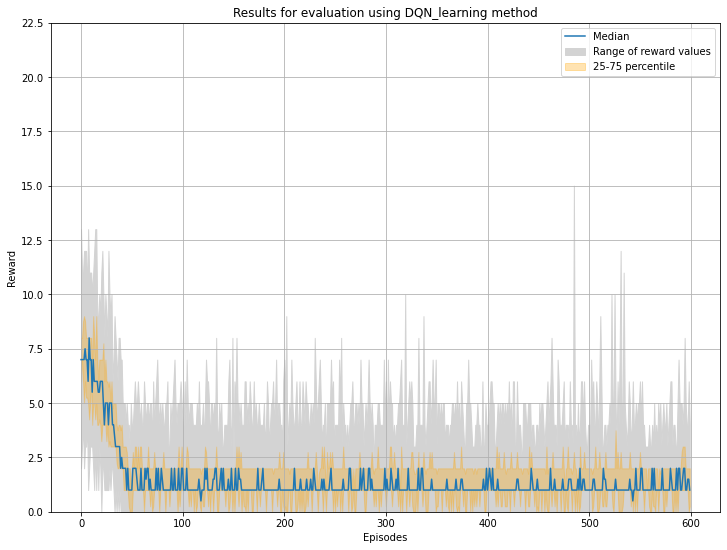

In [26]:
plot_rewards(train_rewards_all, "DQN_learning")

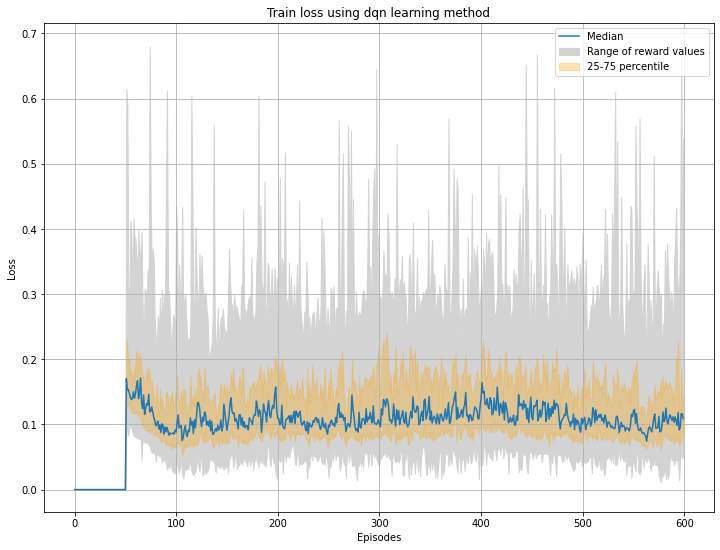

In [33]:
episodes = list(range(len(train_loss_all[0])))
rewards_all = np.array(train_loss_all)

median_rewards = np.median(train_loss_all, axis=0)
q1_rewards = np.percentile(train_loss_all, 25, axis=0)
q3_rewards = np.percentile(train_loss_all, 75, axis=0)
min_rewards = np.min(train_loss_all, axis=0)
max_rewards = np.max(train_loss_all, axis=0)

plt.figure(figsize=(12, 9))

# Plot the range of values in light grey
plt.fill_between(episodes, min_rewards, max_rewards, color='lightgrey', label='Range of reward values')

# Plot the median values
plt.plot(episodes, median_rewards, label='Median')
plt.grid()
plt.fill_between(episodes, q1_rewards, q3_rewards, alpha=0.3, color='orange', label='25-75 percentile')

plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title(f'Train loss using dqn learning method')
plt.legend()
plt.show()

### EVALUATION

In [ ]:
# todo
def test_model(model, nb_episodes):
    test_rewards = []
    for e in range(nb_episodes):
        state = env.reset().to_numpy()
        test_episode_reward_sum = 0
        for step in range(nmb_of_iterations_per_episode):
            state, reward, action, action_type = dqn.epsilon_greedy_policy(model, env, state, action_space[1])
            state = state.to_numpy()
            test_episode_reward_sum += reward
        test_rewards.append(test_episode_reward_sum)
        print("Episode test for best: {}, rewards: {}, eps: {:.3f}".format(e, test_episode_reward_sum, epsilon), end="\n")

    test_best_avg_rewards = sum(test_rewards) / len(test_rewards)